In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym

In [2]:
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

def display_frames_as_gif(frames):
    plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')
    
    def animate(i):
        patch.set_data(frames[i])
    
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    
    anim.save('movie_cartpole_DQN.mp4')
    display(display_animation(anim, default_mode='loop'))

In [3]:
from collections import namedtuple

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [4]:
ENV = 'CartPole-v0'
GAMMA = 0.99
MAX_STEPS = 200
NUM_EPISODES = 500

In [10]:
# 経験を保存するメモリクラスを定義

class ReplayMemory:
    def __init__(self, CAPACITY):
        self.capacity = CAPACITY  # メモリの最大長
        self.memory = []                 # 経験を保存する変数
        self.index = 0                       # 保存するindexを示す変数
        
    def push(self, state, action, state_next, reward):
        ''' trainsition = (state, action, state_next, reward) をメモリに保存する　'''
        
        if len(self.memory) < self.capacity:
            self.memory.append(None)    # メモリが満タンでないときは追加
        
        # namedtuple の Transition を使用し, 値とフィールド名をペアにして保存する
        self.memory[self.index] = Transition(state, action, state_next, reward)
        self.index = (self.index + 1)%self.capacity   # 保存するindexを1つずらす
        
    def sample(self, batch_size):
        ''' batch_size 分だけ, ランダムに保存内容を取り出す '''
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        ''' 関数 len に対して, 現在の変数 memory の長さを返す '''
        return len(self.memory)

In [11]:
# エージェントが持つ脳となるクラス
# Q関数をディープラーニングのネットワークをクラスとして定義

import random
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

BATCH_SIZE = 32
CAPACITY = 10000

class Brain:
    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions        # CartPole の行動数 (右 or 左) の2を取得
        
        # 経験を記憶するメモリオブジェクトを生成
        self.memory = ReplayMemory(CAPACITY)
        
        # ニューラルネットワークを構築
        self.model = nn.Sequential()
        self.model.add_module('fc1', nn.Linear(num_states, 32))
        self.model.add_module('relu1', nn.ReLU())
        self.model.add_module('fc2', nn.Linear(32, 32))
        self.model.add_module('relu2', nn.ReLU())
        self.model.add_module('fc3', nn.Linear(32, num_actions))
        print(self.model)
        
        # 最適化手法の設定
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001)
        
    def replay(self):
        ''' Experience Replay でネットワークの結合パラメータを学習 '''
        # ----------------------------------------------------------
        #  1. メモリサイズの確認
        # ----------------------------------------------------------
        #  1.1 メモリサイズがミニバッチより小さい間は何もしない
        if len(self.memory) < BATCH_SIZE:
            return
        
        # ----------------------------------------------------------
        #  2. ミニバッチの作成
        # ----------------------------------------------------------
        #  2.1 メモリからミニバッチ分のデータを取り出す
        transitions = self.memory.sample(BATCH_SIZE)
        
        #  2.2 各変数をミニバッチに対応する形に変形
        # trainsitions は 1step ごとの (state, action, state_next, reward) が BATCH_SIZE 分格納されている = (state, action, state_next, reward) * BATCH_SIZE
        # これを (state*BATCH_SIZE, action*BATCH_SIZE, state_next*BATCH_SIZE, reward*BATCH_SIZE) にする
        batch = Transition(*zip(*transitions))
        
        #  2.3 各変数の要素を見にバッチに対応する形に変形する
        # cat は Concatenates (結合) のこと
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        
        # ----------------------------------------------------------
        #   3. 教師信号となる Q(s_t, a_t)値を求める
        # ----------------------------------------------------------
        #  3.1 ネットワークを推論モードに切り替える
        self.model.eval()
        
        #  3.2 ネットワークが出力した Q(s_t, a_t) を求める
        # self.model(state_batch) は右左の両方のQ値を出力している
        # 実行したアクションa_tに対応するQ値を求めるため, action_batch で行った行動a_tが右か左かのindexを求め, それに対応するQ値をgatherで出す
        state_action_values = self.model(state_batch).gather(1, action_batch)
        
        # 3.3 max{Q(s_t+1, a)} 値を求める. 次の状態があるかに注意.
        
        # cartpoleがdoneになっておらず, next_stateがあるかをチェックするインデックスマスクを作成
        non_final_mask = torch.ByteTensor(tuple(map(lambda s: s is not None, batch.next_state)))
        # 0で初期化
        next_state_values = torch.zeros(BATCH_SIZE)
        
        # 次の状態があるindexの最大Q値を求める
        next_state_values[non_final_mask] = self.model(non_final_next_states).max(1)[0].detach()
        
        # 3.4 教師となる Q(s_t, a_t)値を, Q学習の式から求める
        expected_state_action_values = reward_batch + GAMMA*next_state_values
        
        # ----------------------------------------------------------
        #  4. 結合パラメータの更新
        # ----------------------------------------------------------
        # 4.1 ネットワークを訓練モードに切り替える
        self.model.train()
        
        # 4.2 損失関数を計算する (smooth_l1_loss = Huber loss)
        # expected_train_action_values は size = [minibatch] になっているので unsqeeze で [minibatch * 1]
        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        
        # 4.3 結合パラメータを更新する
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def decide_action(self, state, episode):
        ''' 現在の状態に応じて, 行動を決定する '''
        # epsilon-greedy 法で徐々に最適行動のみを採用する
        epsilon = 0.5 * (1/(episode + 1))
        
        if epsilon <= np.random.uniform(0, 1):
            self.model.eval()
            with torch.no_grad():
                action = self.model(state).max(1)[1].view(1, 1)
            # .view(1, 1) は[torch.LongTensor of size 1] を size 1x1 に変換する
        else:
            # 0, 1の行動をランダムに返す
            action = torch.LongTensor([[random.randrange(self.num_actions)]])
            # action は [torch.LongTensor of size 1x1] の形になる
        
        return action

In [12]:
class Agent:
    def __init__(self, num_states, num_actions):
        ''' 課題の状態と行動の数を設定する '''
        self.brain = Brain(num_states, num_actions)  # エージェントが行動を決定するための頭脳を生成
        
    def update_q_function(self):
        ''' Q関数を更新する '''
        self.brain.replay()
        
    def get_action(self, state, episode):
        ''' 行動を決定する '''
        action = self.brain.decide_action(state, episode)
        return action
    
    def memorize(self, state, action, state_next, reward):
        ''' memory オブジェクトに, state, action, state_next, reward の内容を保存する '''
        self.brain.memory.push(state, action, state_next, reward)

In [13]:
class Environment:
    def __init__(self):
        self.env = gym.make(ENV)
        self.num_states = self.env.observation_space.shape[0]
        self.num_actions = self.env.action_space.n
        self.agent = Agent(self.num_states, self.num_actions)
    
    def run(self):
        ''' 実行 '''
        episode_10_list = np.zeros(10)
        complete_episodes = 0
        episode_final = False
        frames = []
        
        for episode in range(NUM_EPISODES):
            observation = self.env.reset()
            
            state = observation
            state = torch.from_numpy(state).type(torch.FloatTensor)
            state = torch.unsqueeze(state, 0)
        
            for step in range(MAX_STEPS):
                if episode_final is True:
                    frames.append(self.env.render(mode='rgb_array'))
                    
                action = self.agent.get_action(state, episode)
                observation_next, _, done, _ = self.env.step(action.item())
                
                if done:
                    state_next = None
                    episode_10_list = np.hstack((episode_10_list[1:], step+1))
                    
                    if step < 195:
                        reward = torch.FloatTensor([-1.0])
                        complete_episodes = 0
                    else:
                        reward = torch.FloatTensor([1.0])
                        complete_episodes = complete_episodes + 1
                else:
                    reward = torch.FloatTensor([0.0])
                    state_next = observation_next
                    state_next = torch.from_numpy(state_next).type(torch.FloatTensor)
                    state_next = torch.unsqueeze(state_next, 0)
                
                self.agent.memorize(state, action, state_next, reward)
                self.agent.update_q_function()
                state = state_next
                
                if done:
                    print('%d Episode: Finished after %d steps : 10試行の平均step数 = %.1lf' % (episode, step+1, episode_10_list.mean()))
                    break
            
            if episode_final is True:
                self.env.close()
                display_frames_as_gif(frames)
                break
            
            if complete_episodes >= 10:
                print('10回連続成功')
                episode_final = True

Sequential(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)
0 Episode: Finished after 14 steps : 10試行の平均step数 = 1.4
1 Episode: Finished after 14 steps : 10試行の平均step数 = 2.8
2 Episode: Finished after 10 steps : 10試行の平均step数 = 3.8
3 Episode: Finished after 12 steps : 10試行の平均step数 = 5.0
4 Episode: Finished after 14 steps : 10試行の平均step数 = 6.4
5 Episode: Finished after 13 steps : 10試行の平均step数 = 7.7
6 Episode: Finished after 10 steps : 10試行の平均step数 = 8.7
7 Episode: Finished after 14 steps : 10試行の平均step数 = 10.1
8 Episode: Finished after 15 steps : 10試行の平均step数 = 11.6
9 Episode: Finished after 51 steps : 10試行の平均step数 = 16.7
10 Episode: Finished after 16 steps : 10試行の平均step数 = 16.9
11 Episode: Finished after 12 steps : 10試行の平均step数 = 16.7
12 Episode: Finished after 10 steps : 10試行の平均step数 = 16.7
13 Episode: Finished after 11 steps


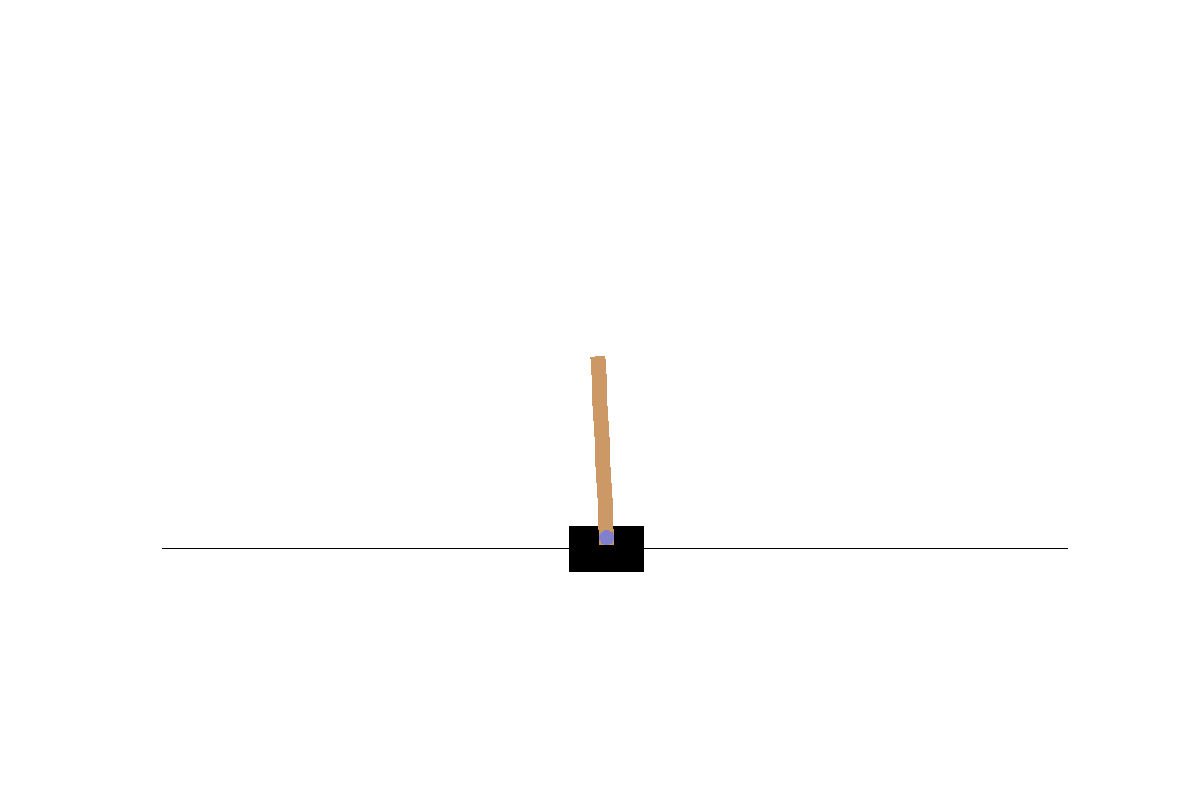
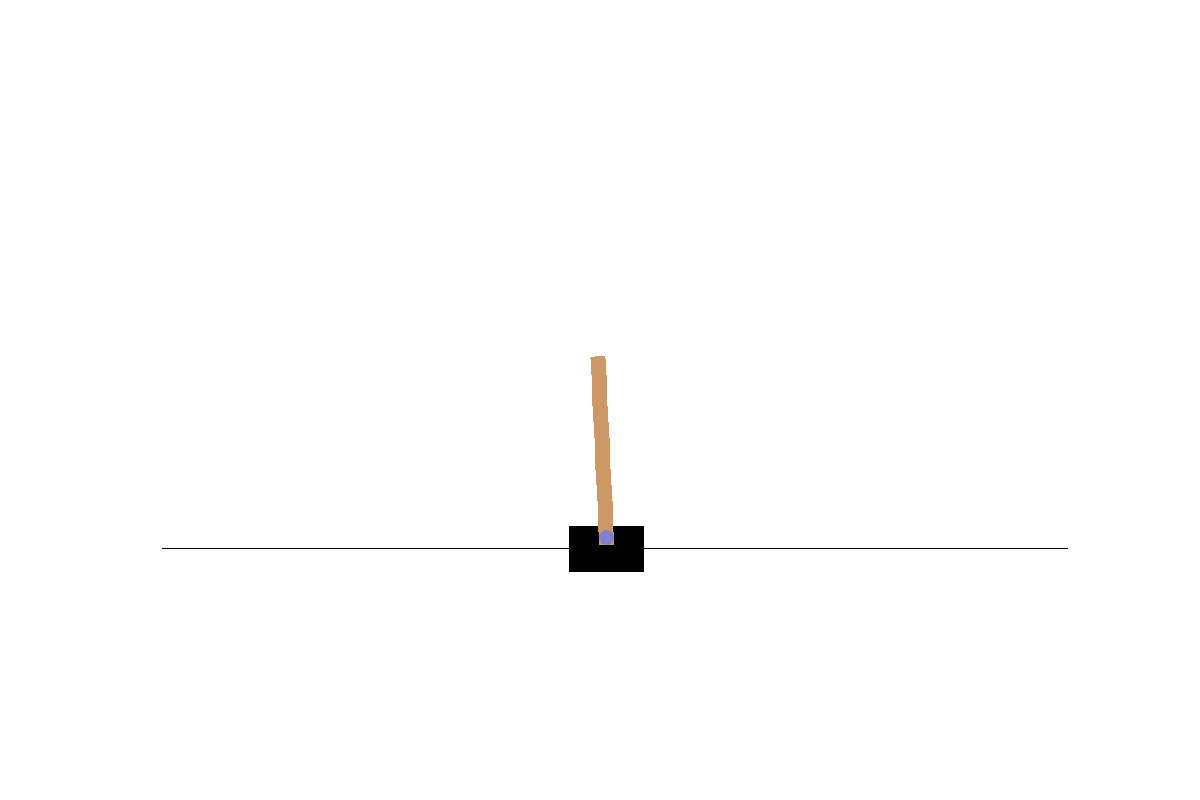
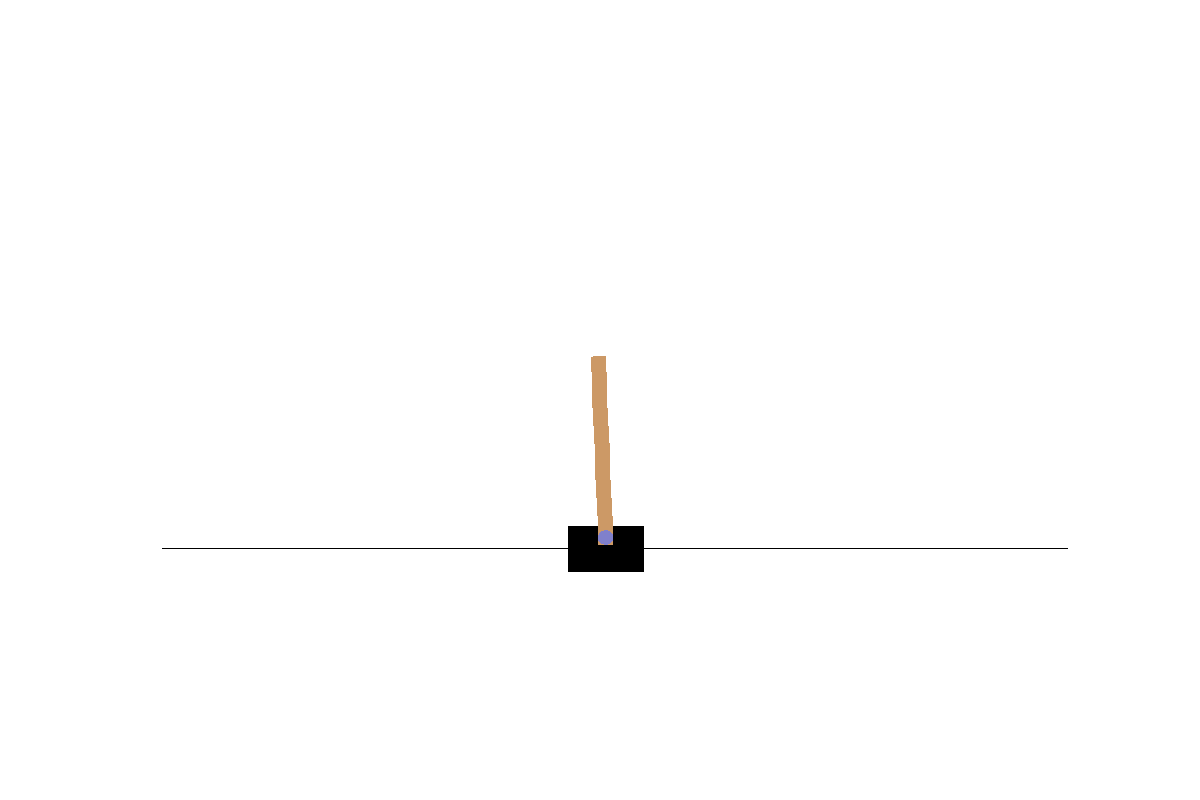
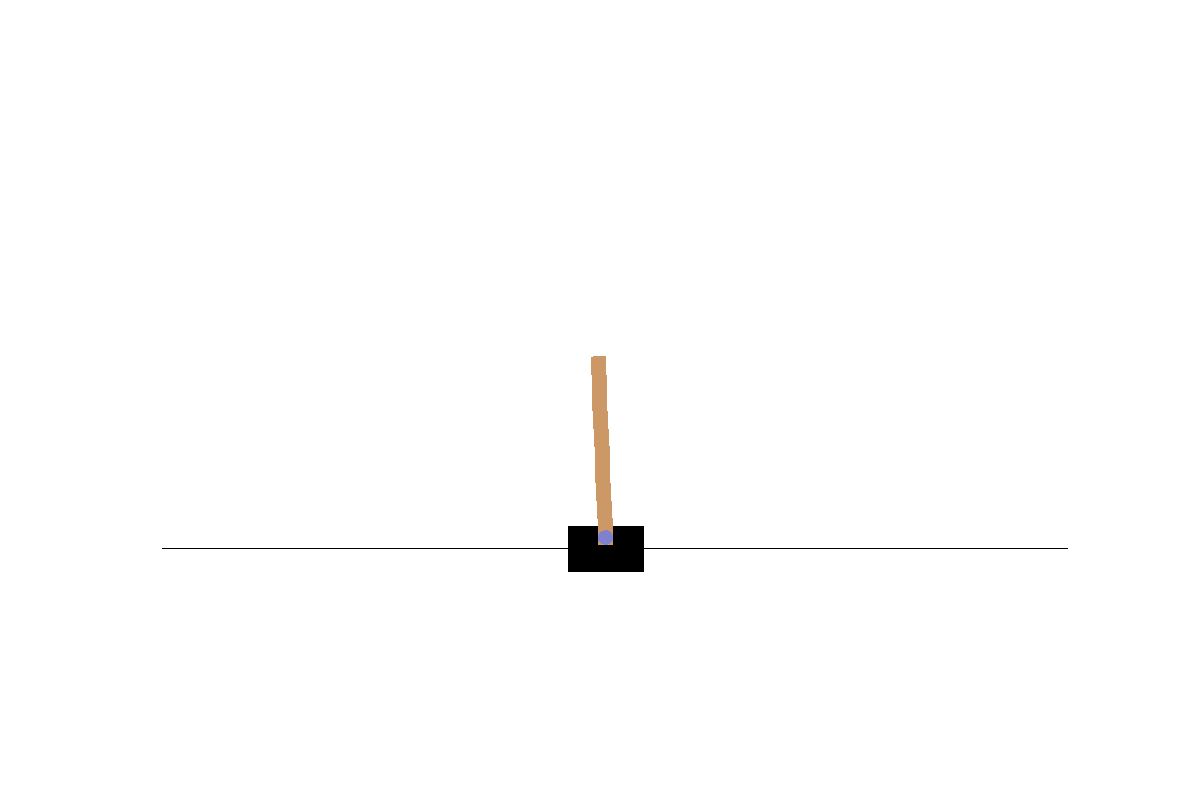
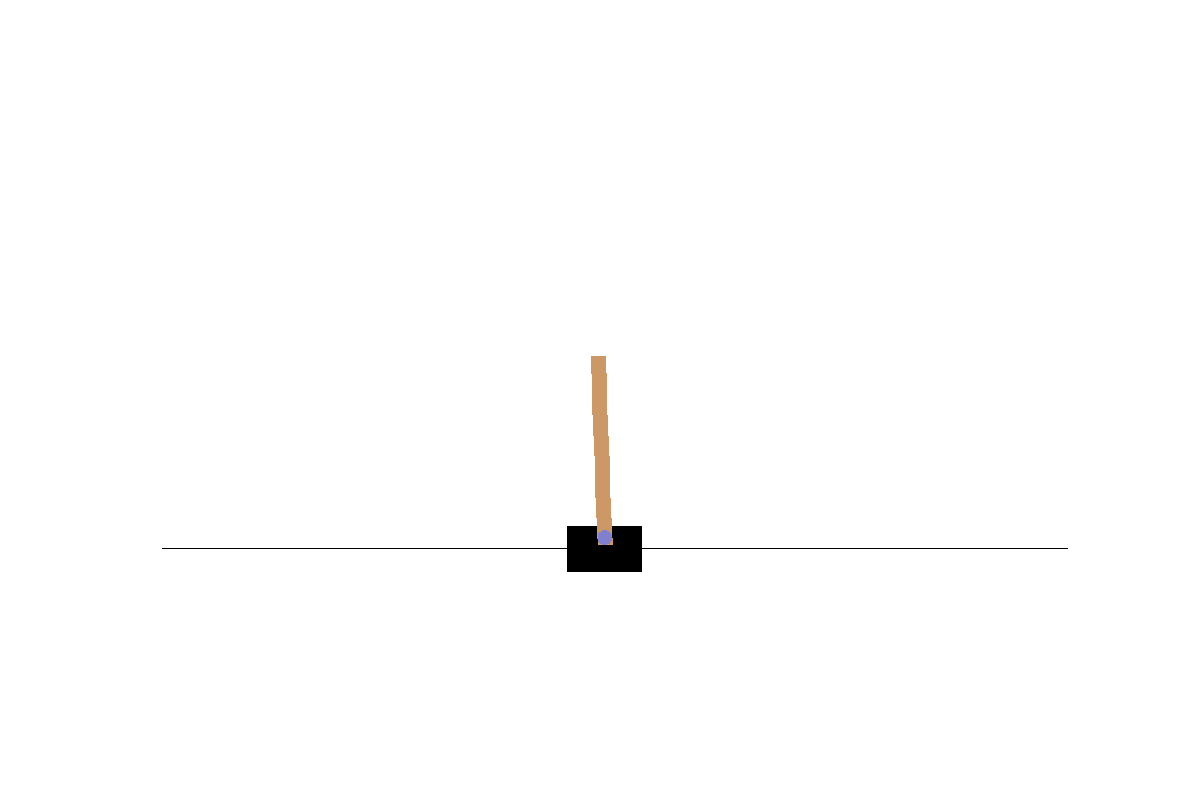
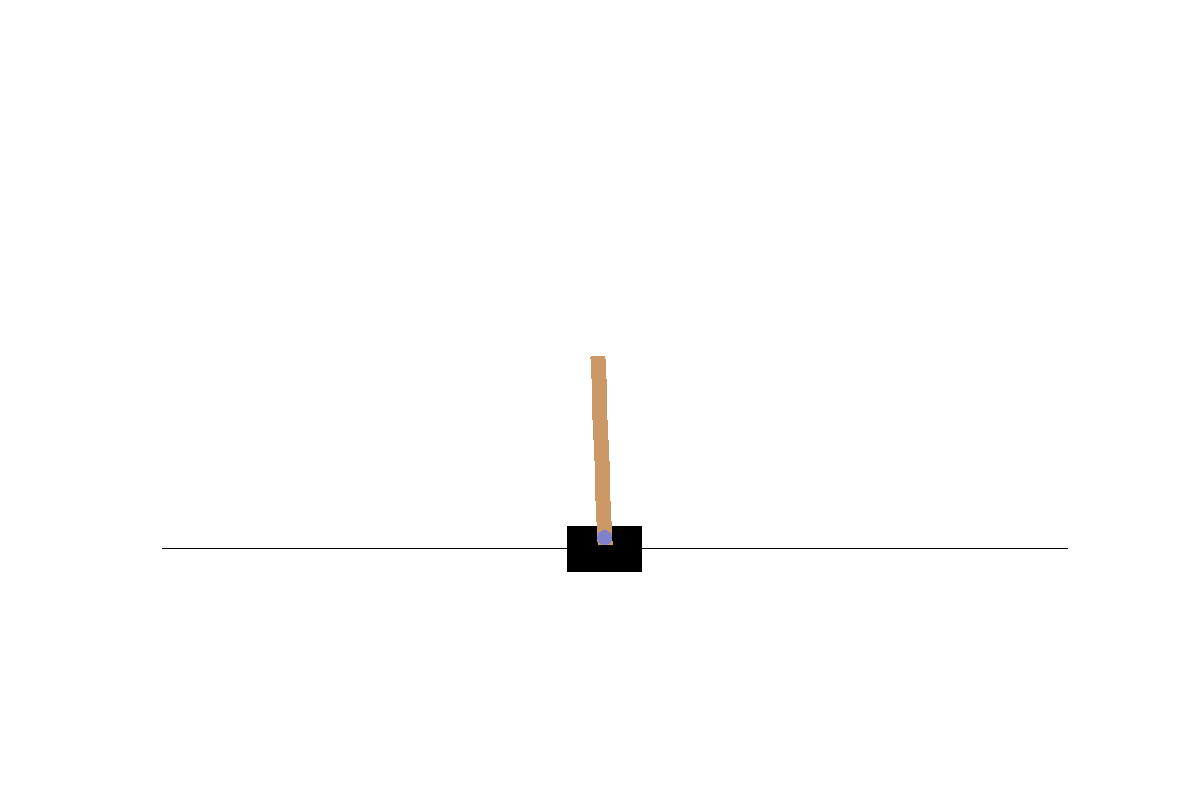
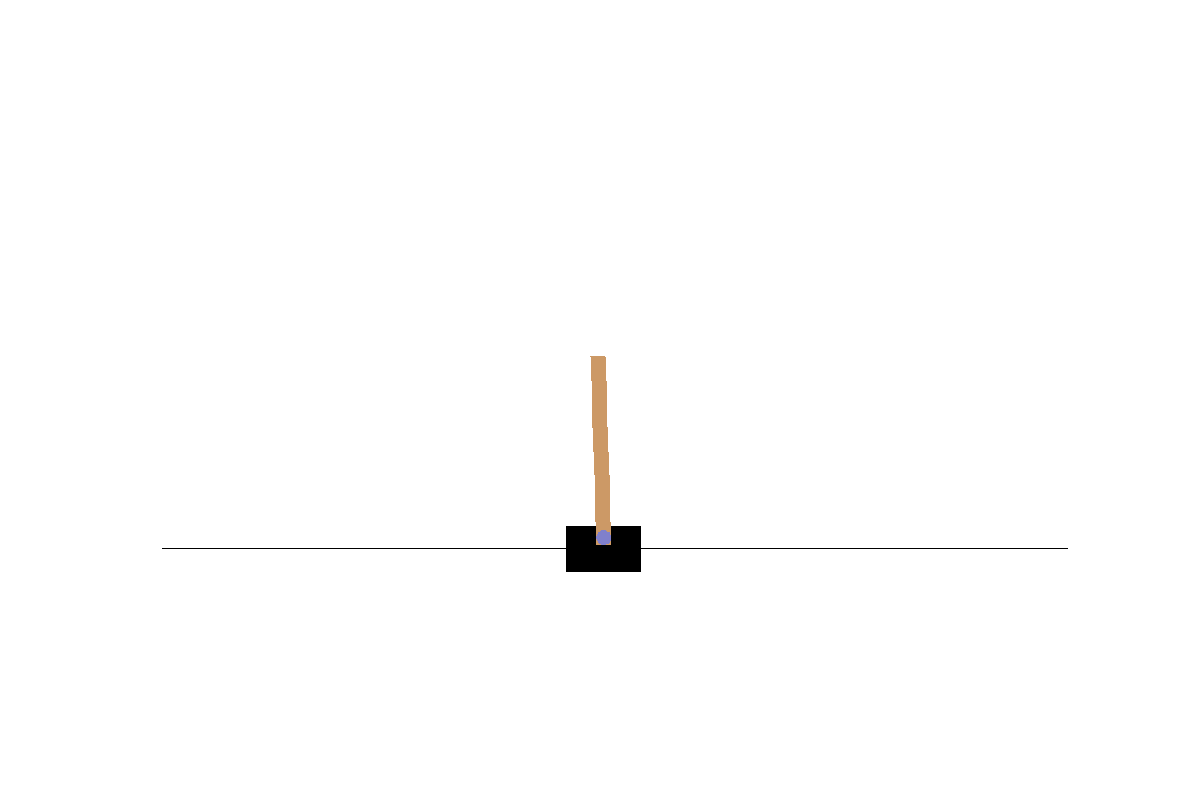
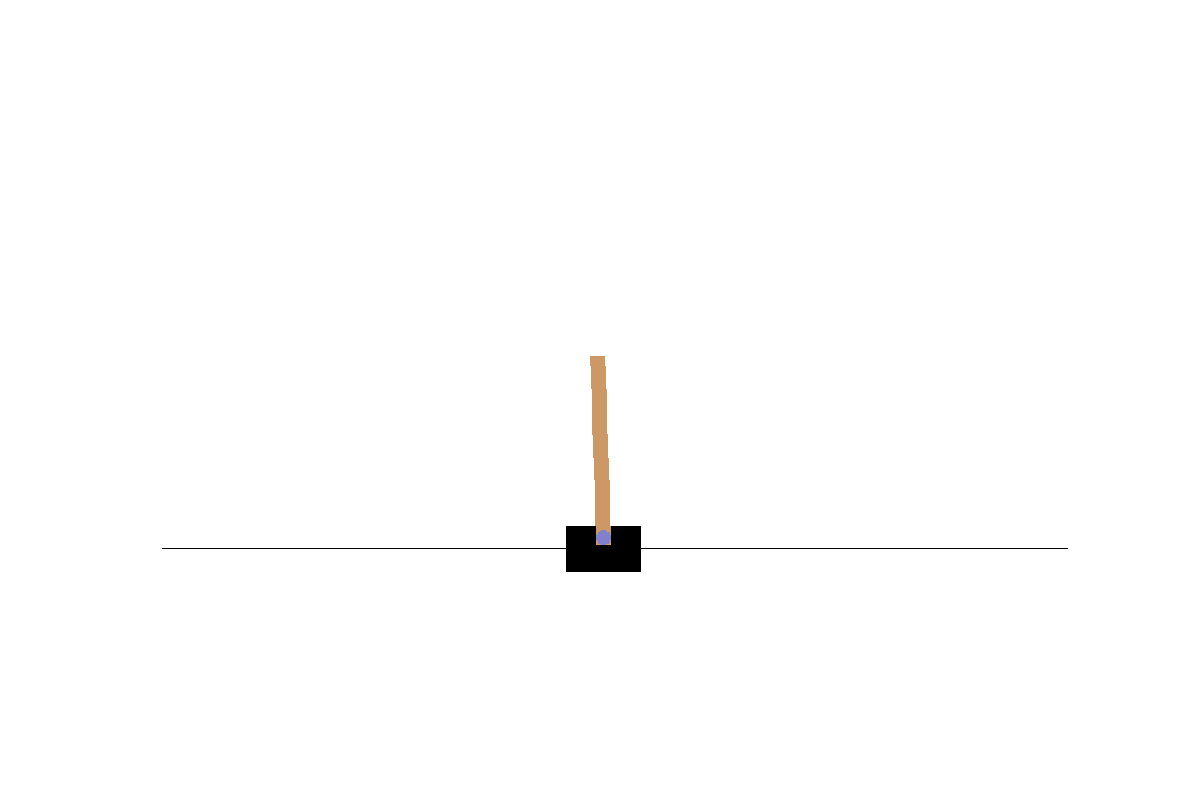
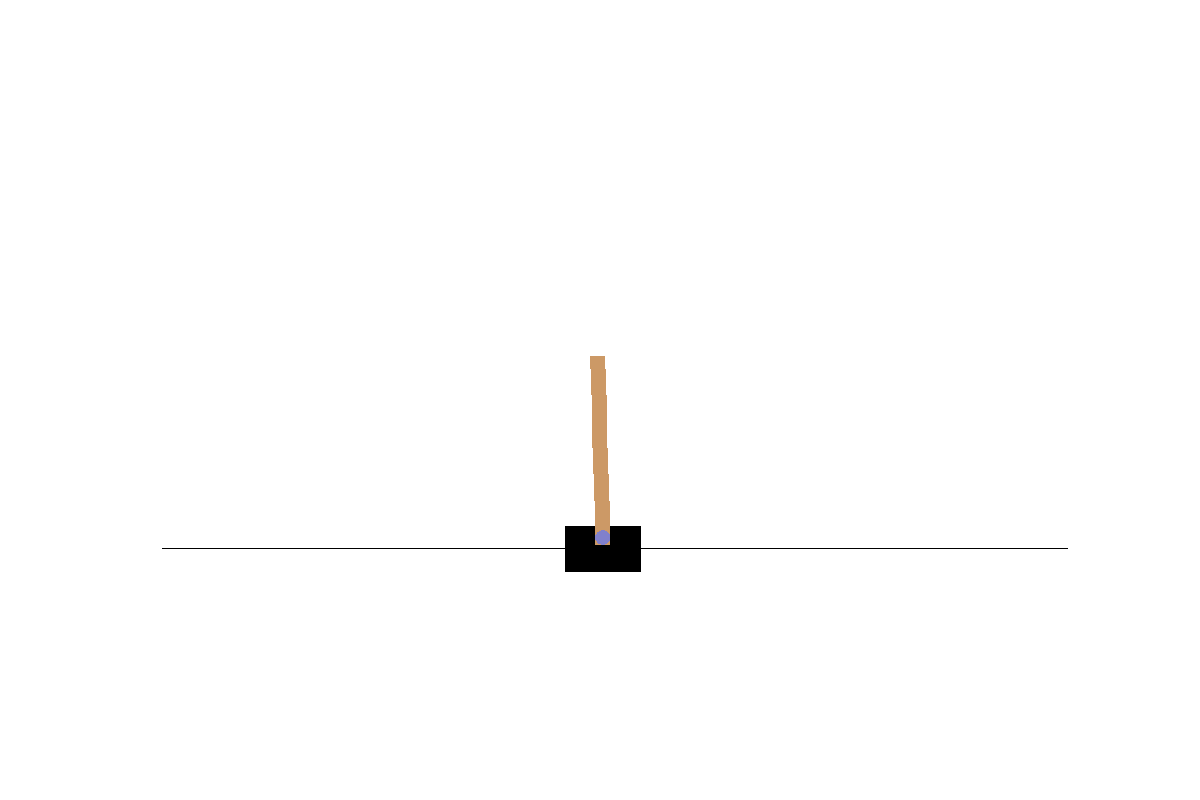
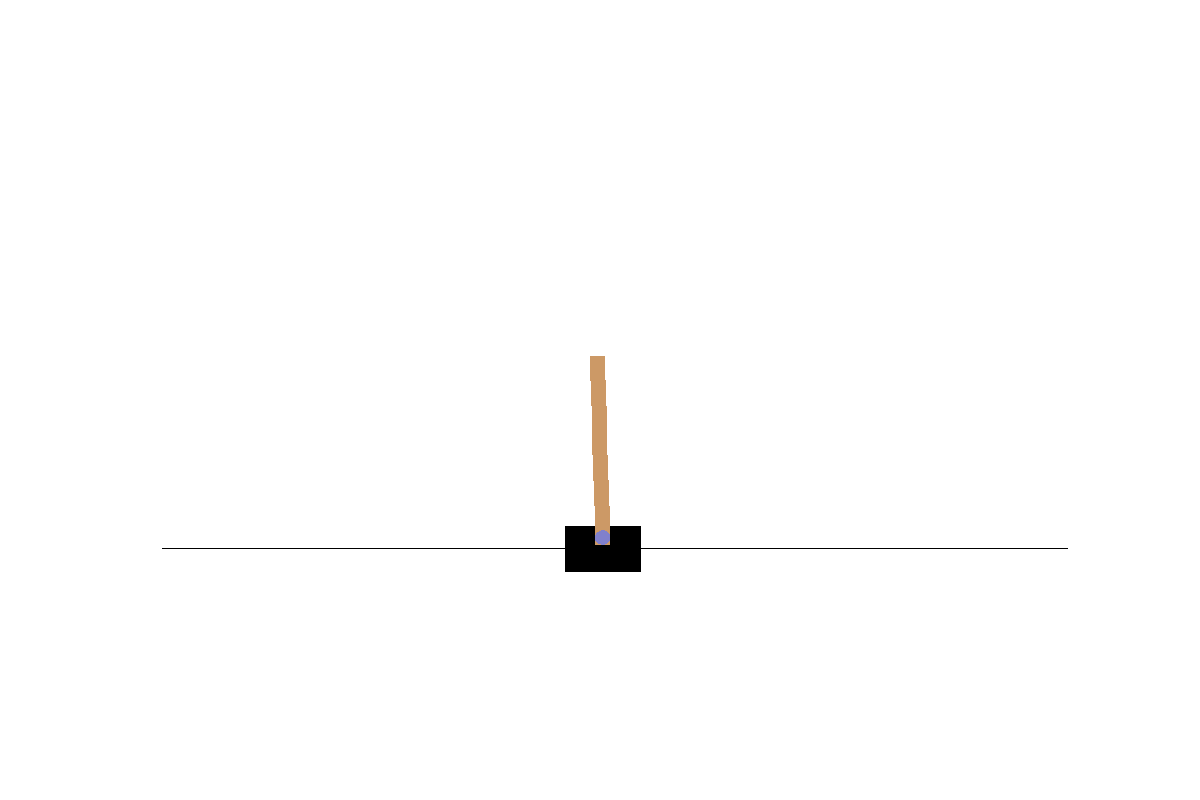
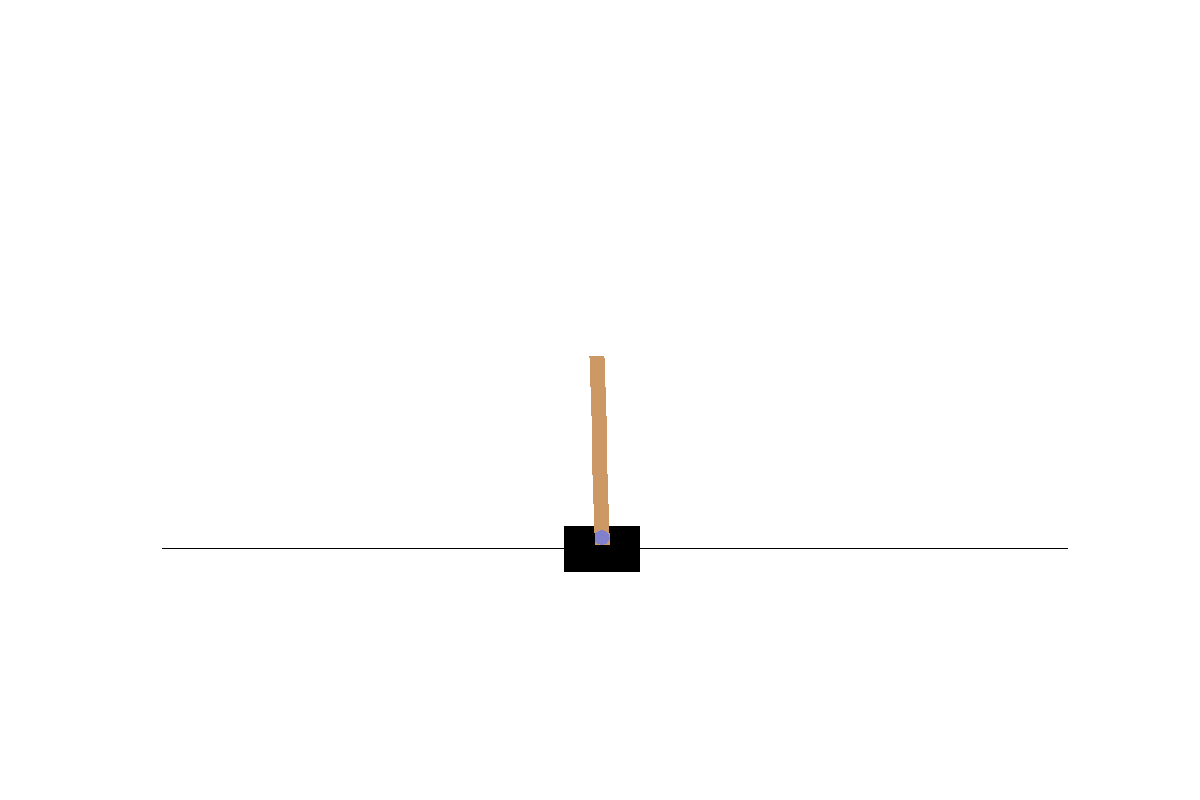
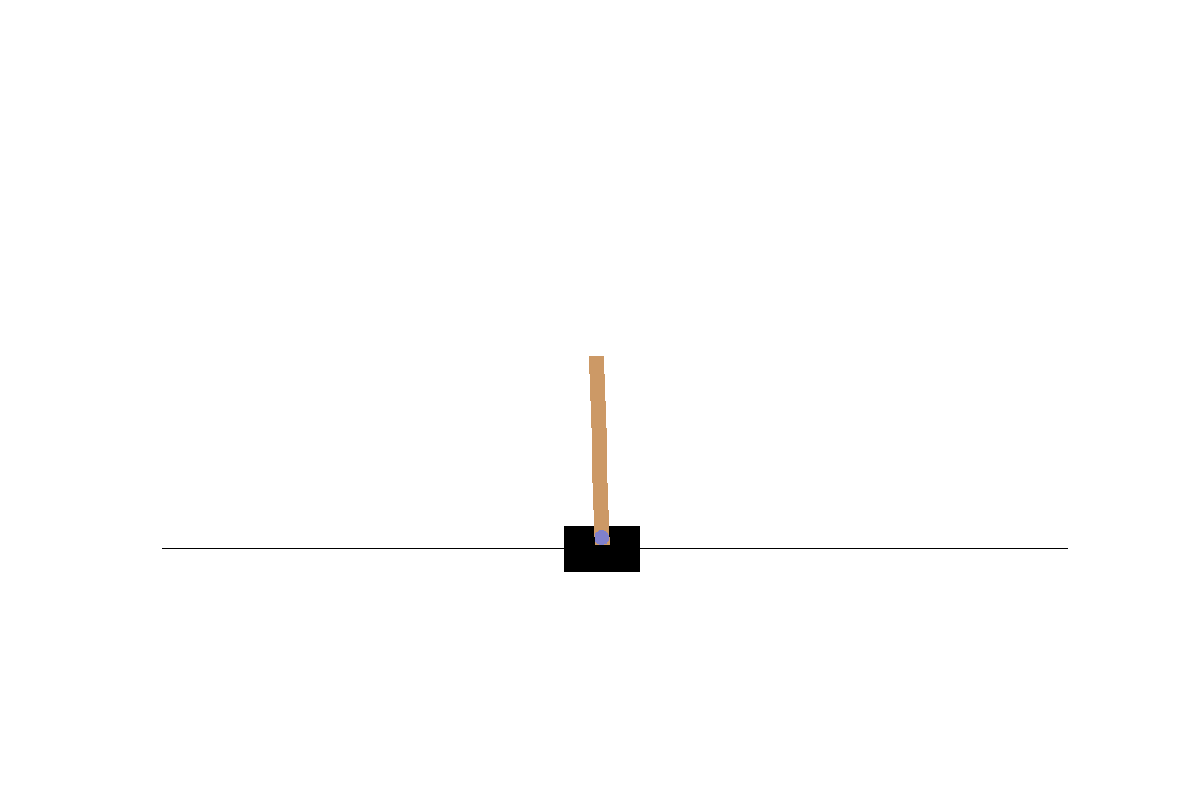
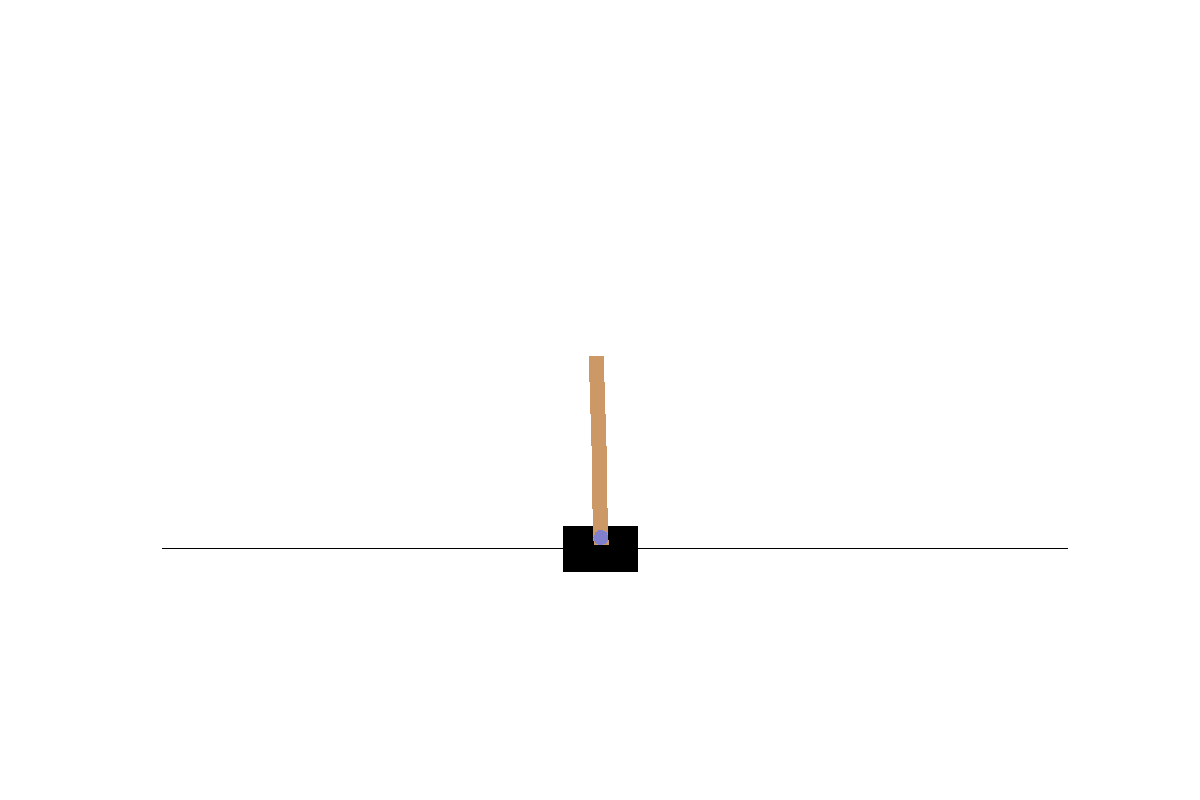
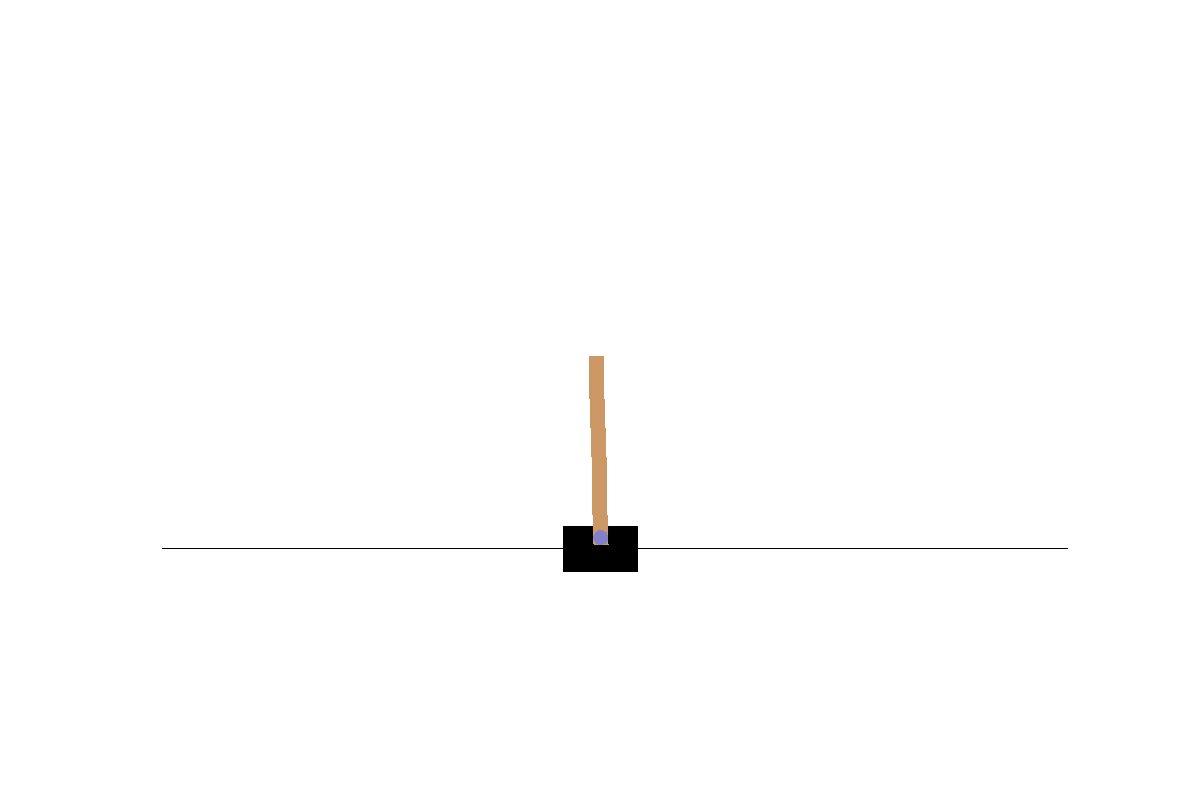
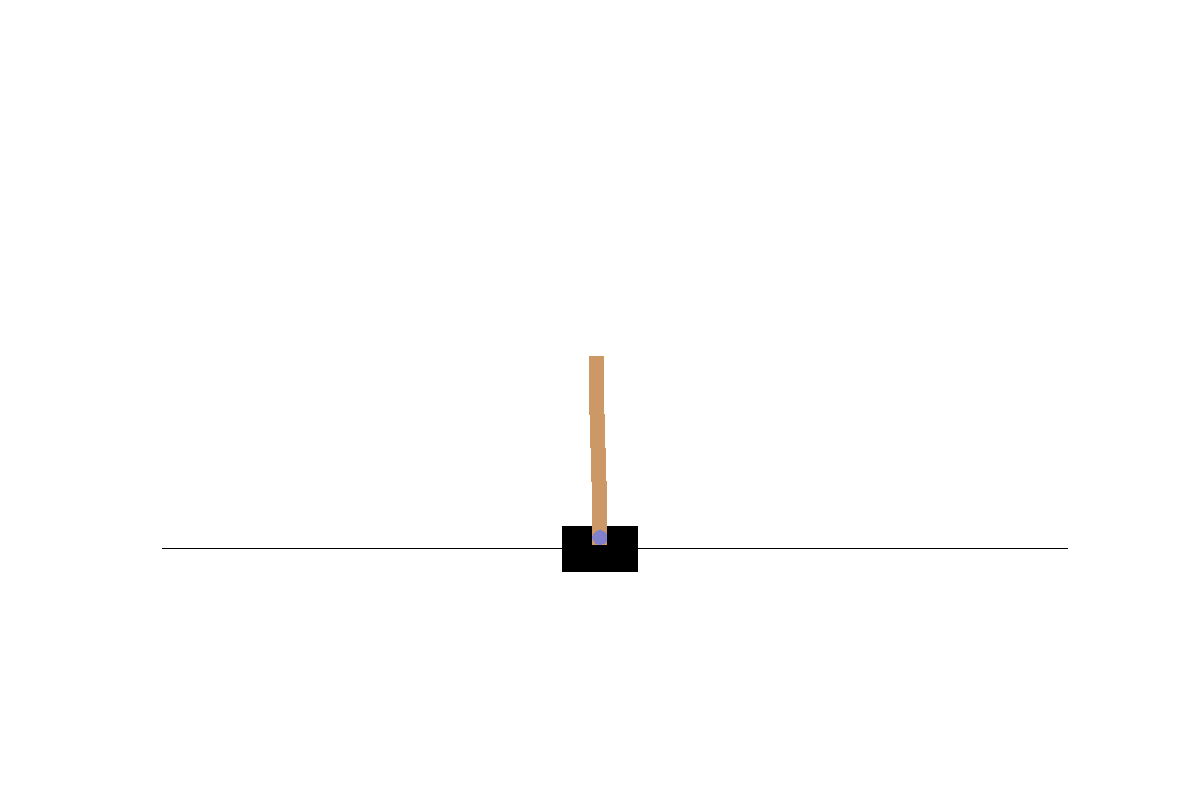
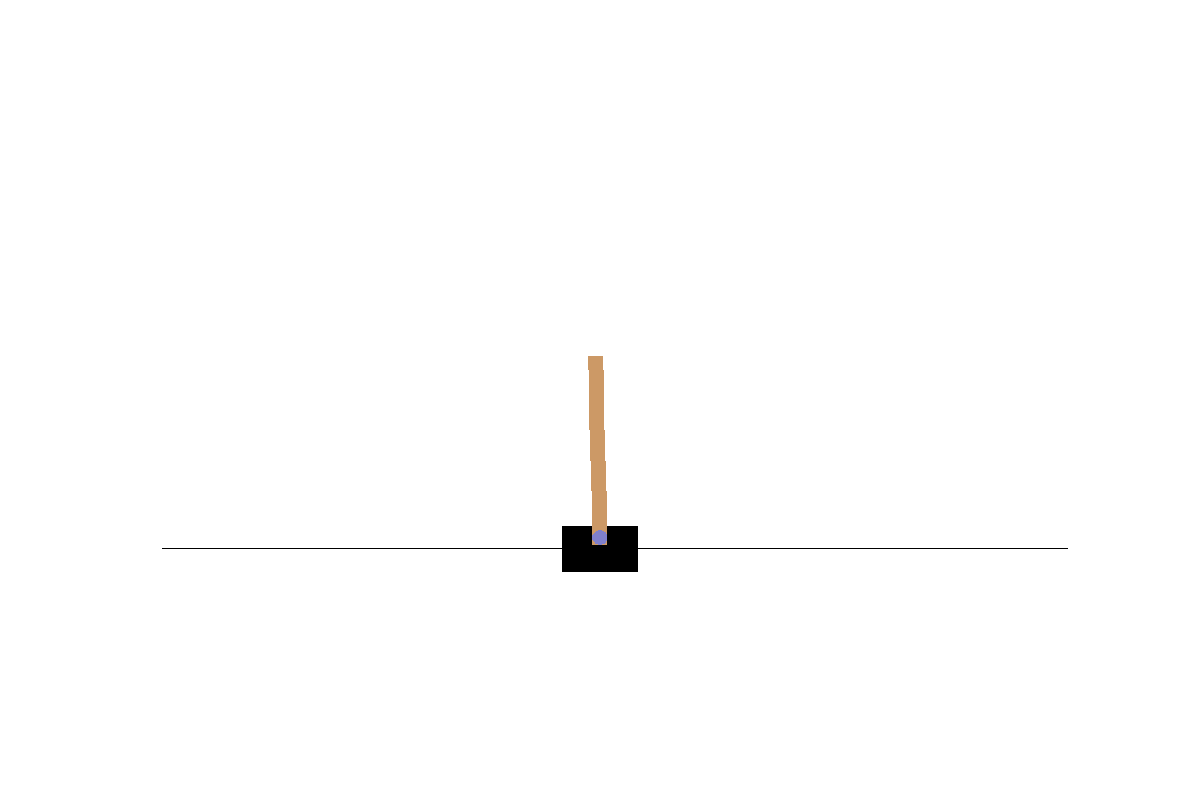
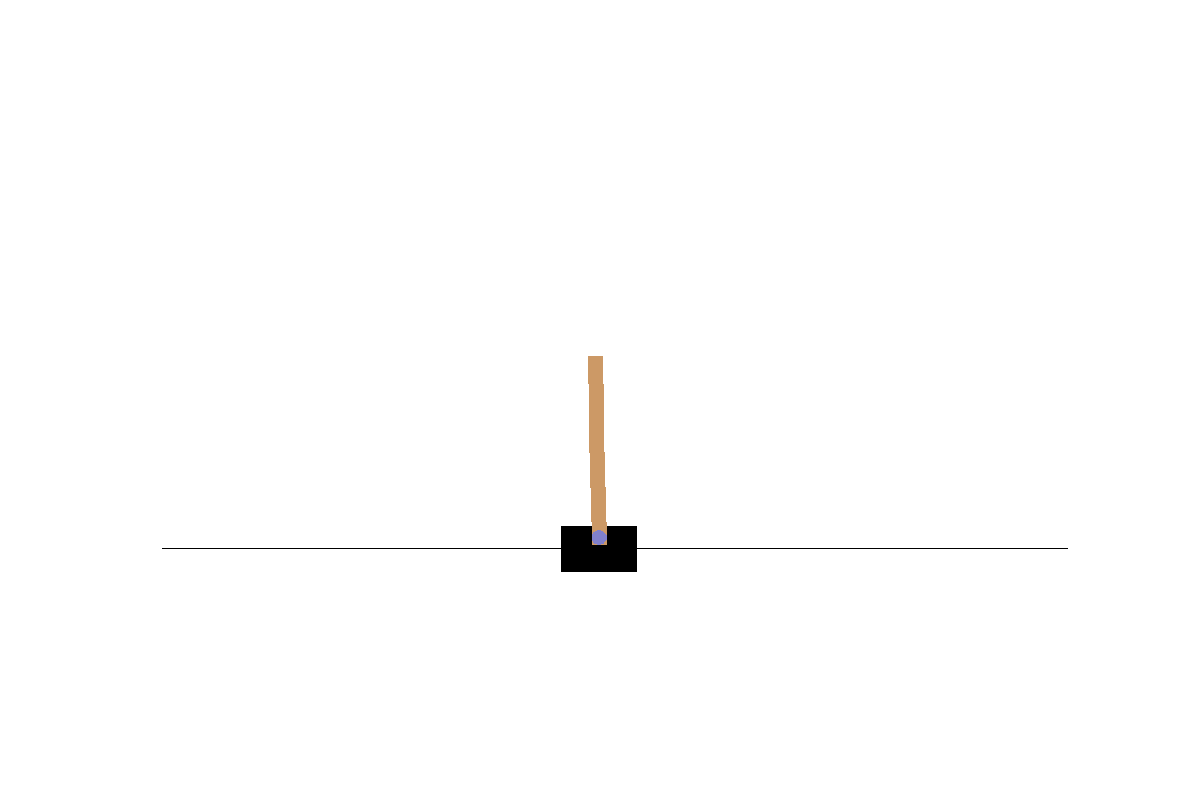
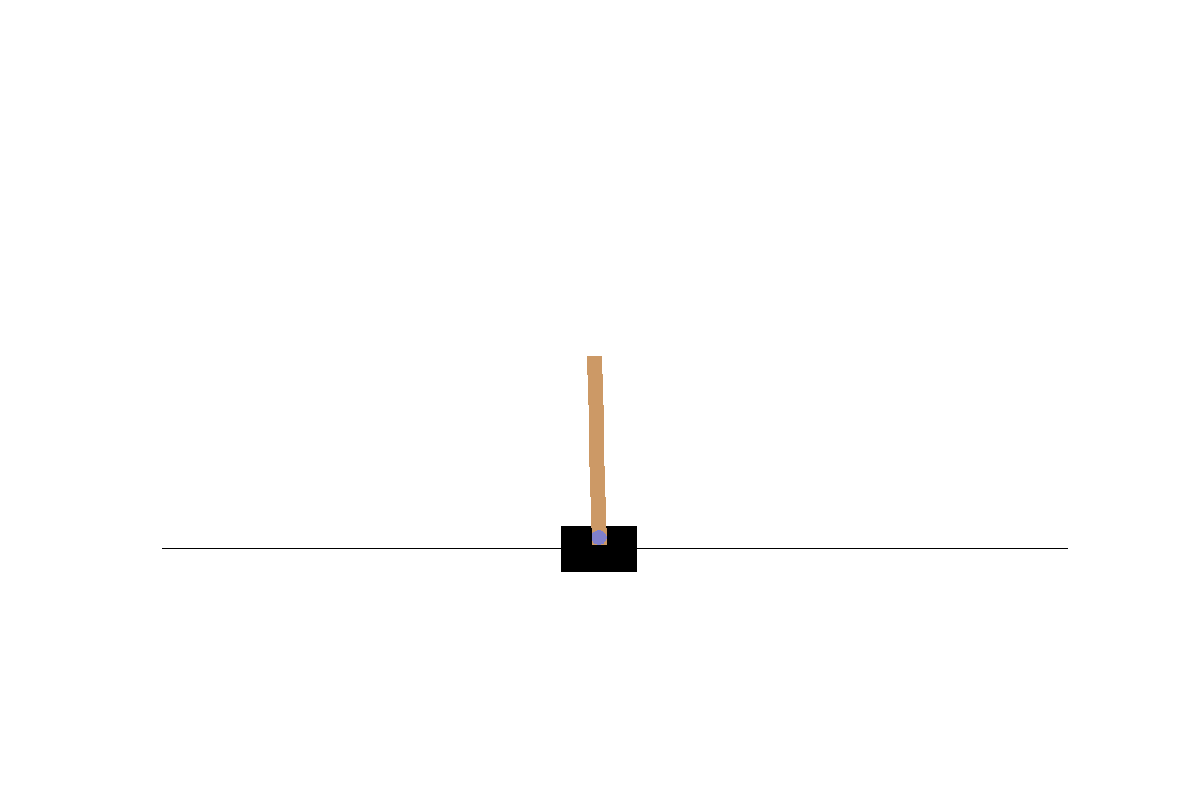
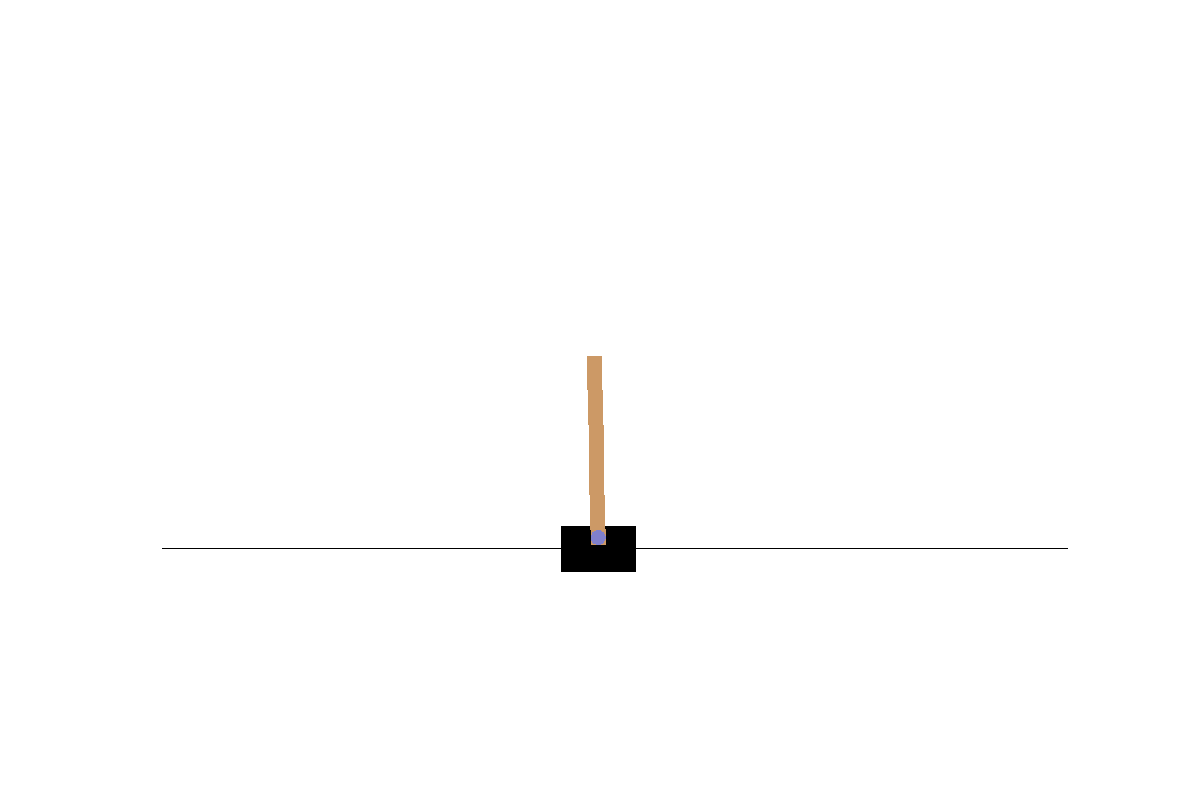
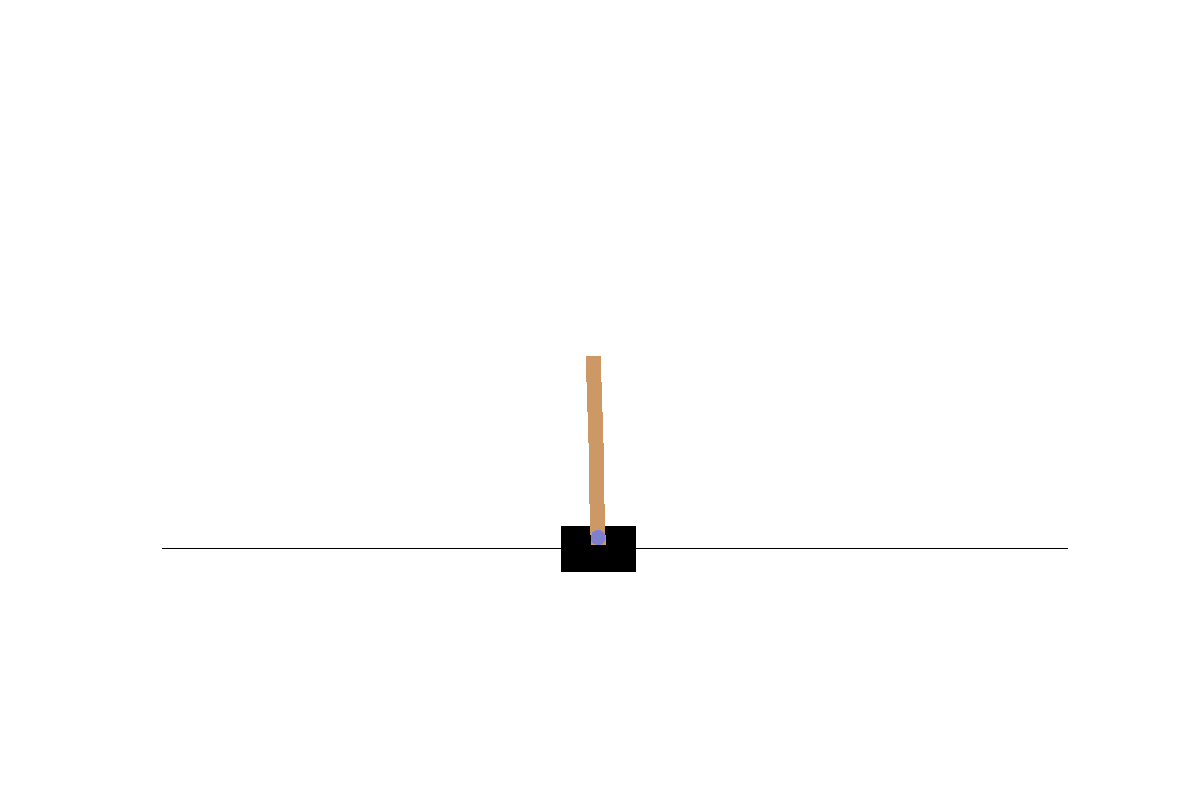
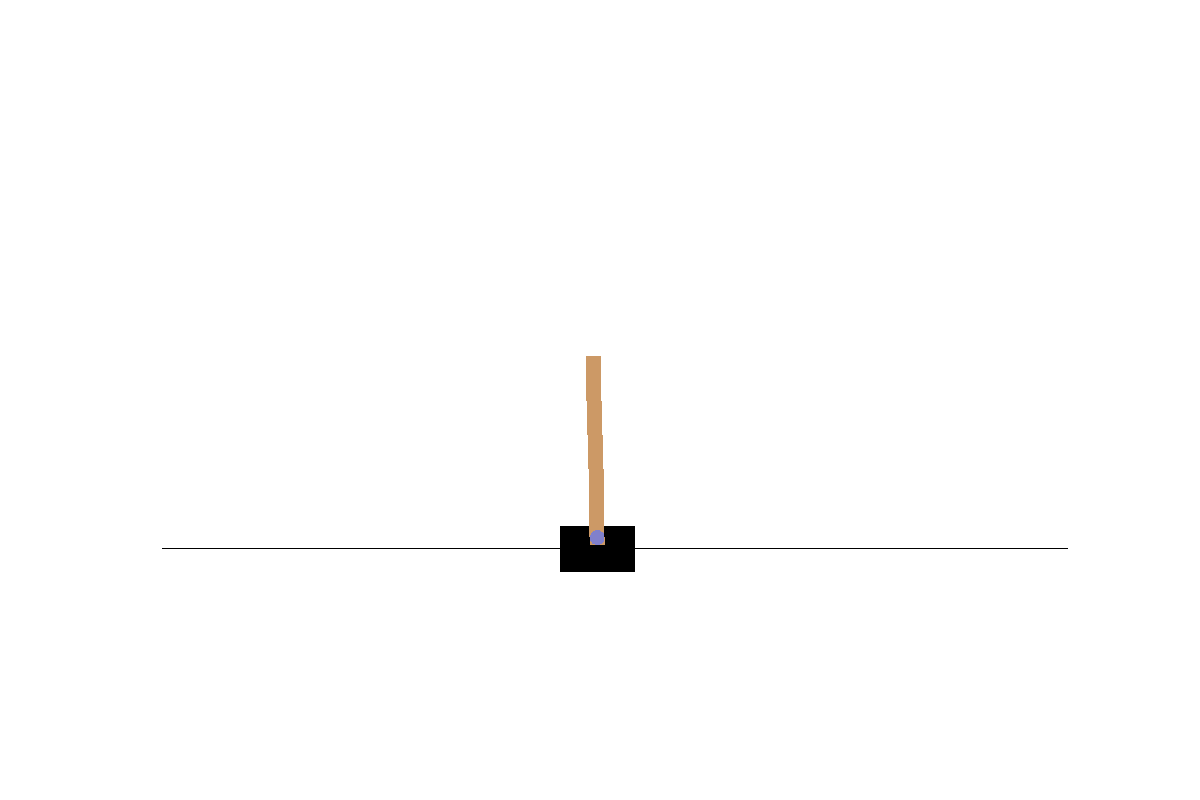
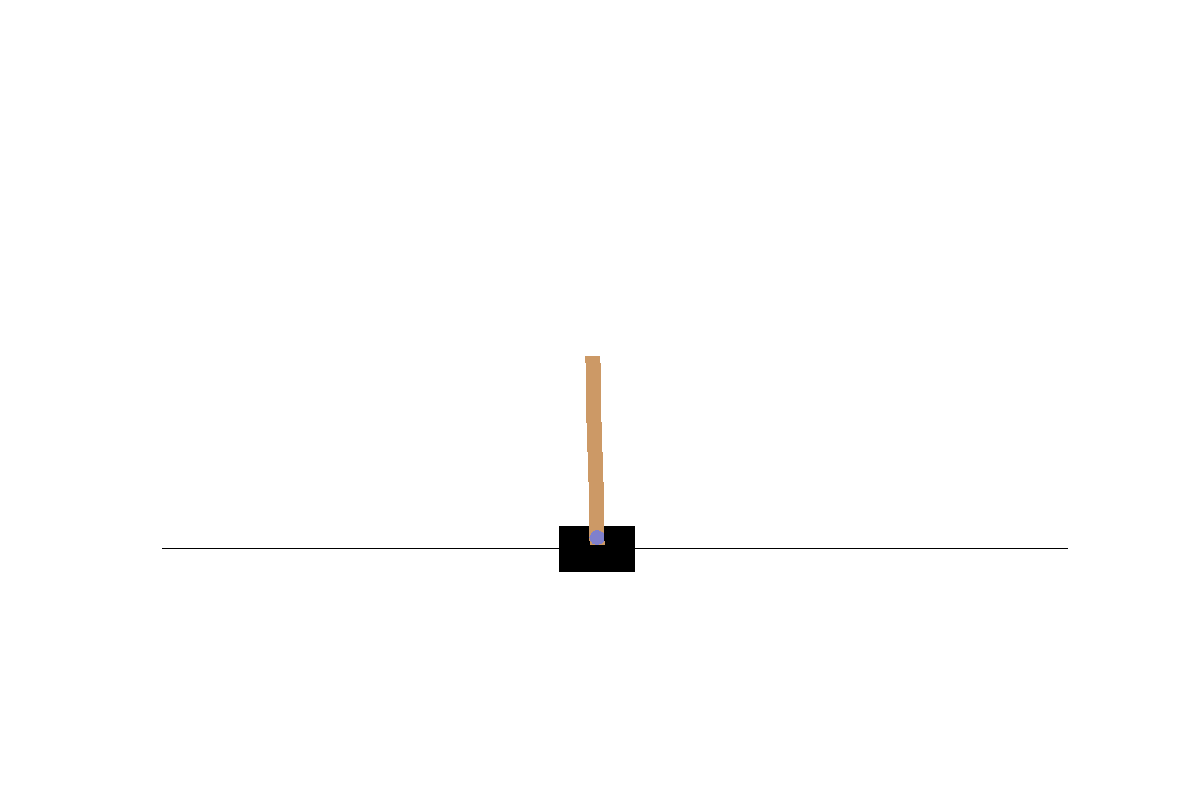
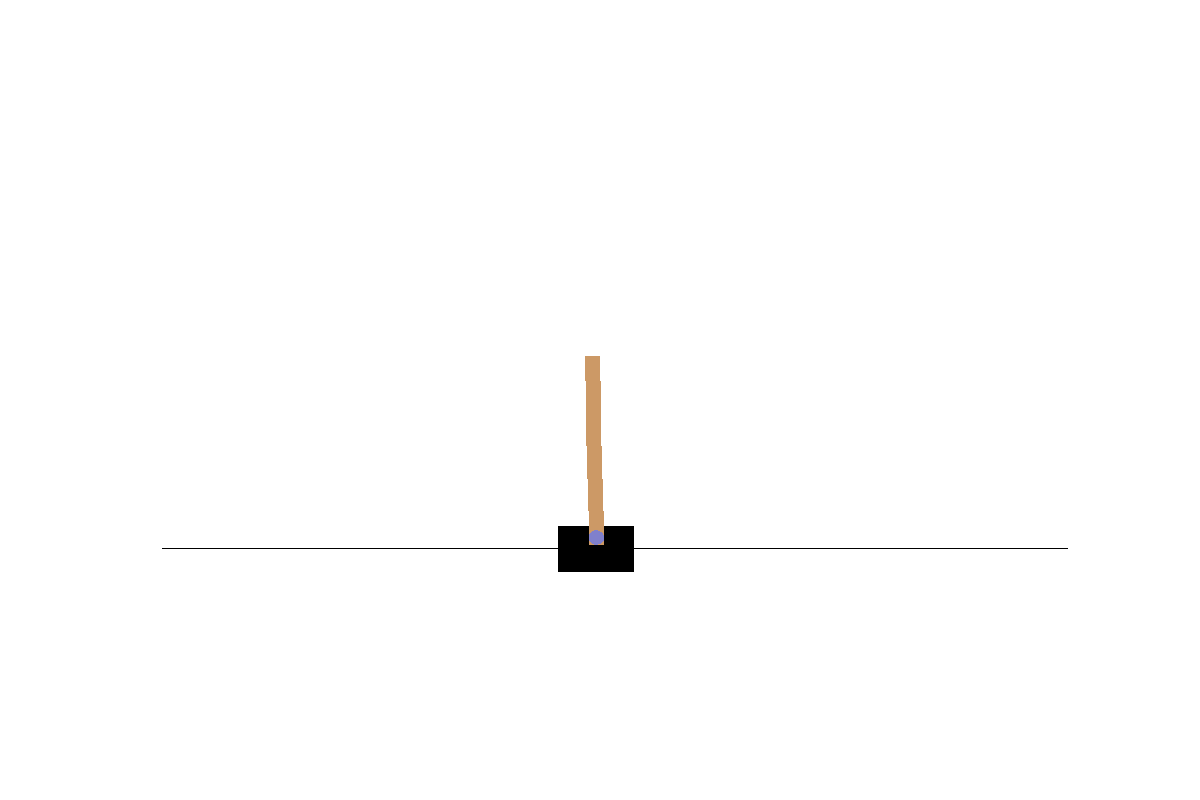
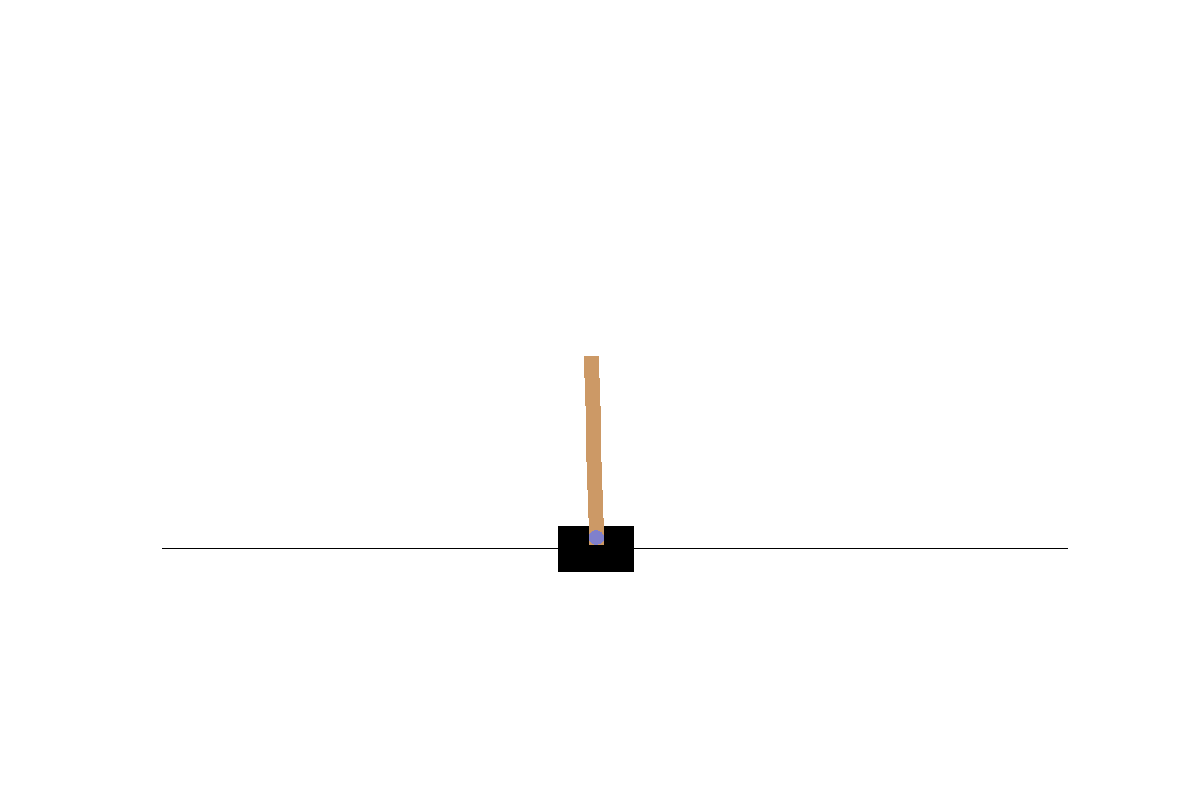
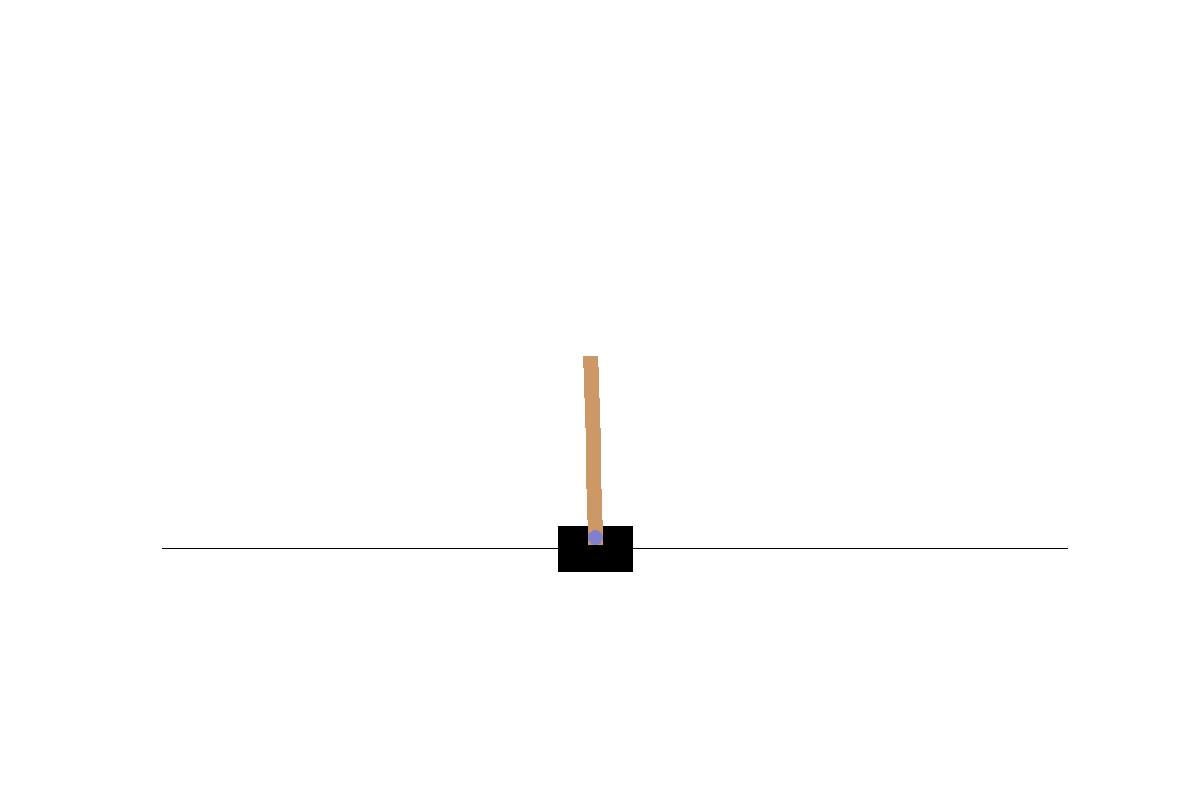
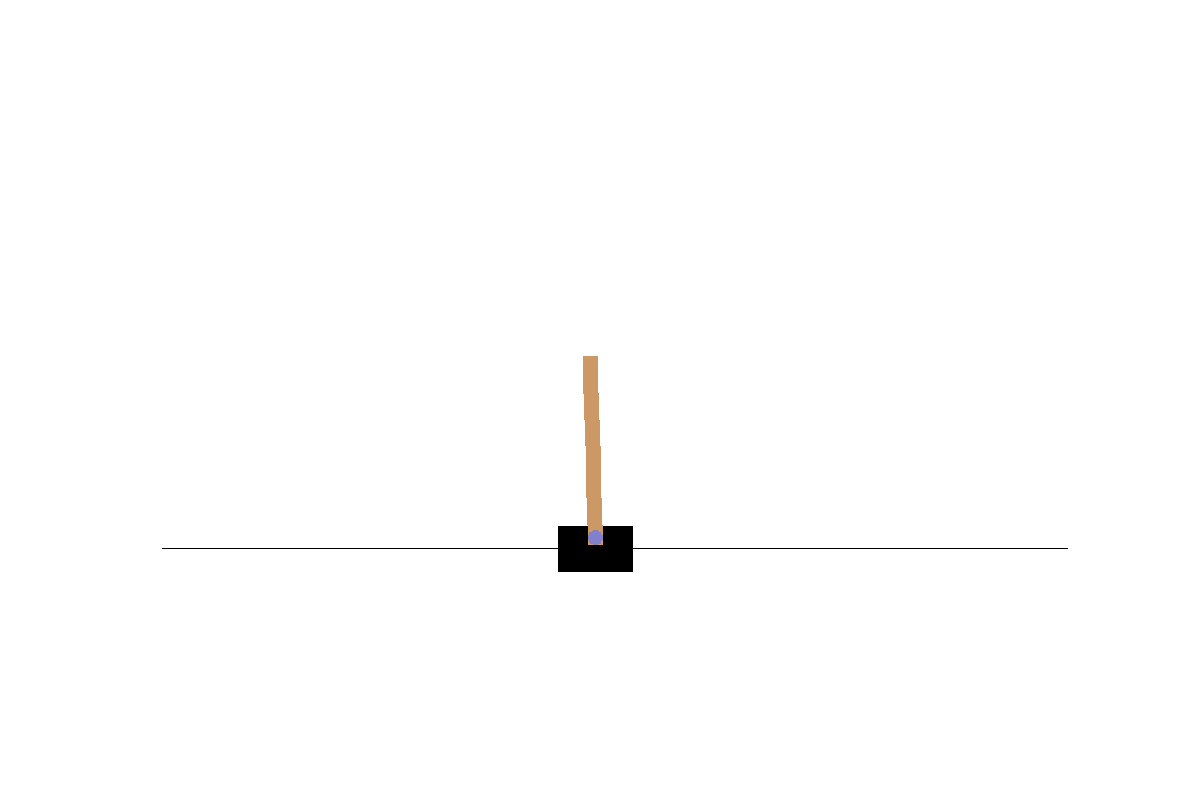
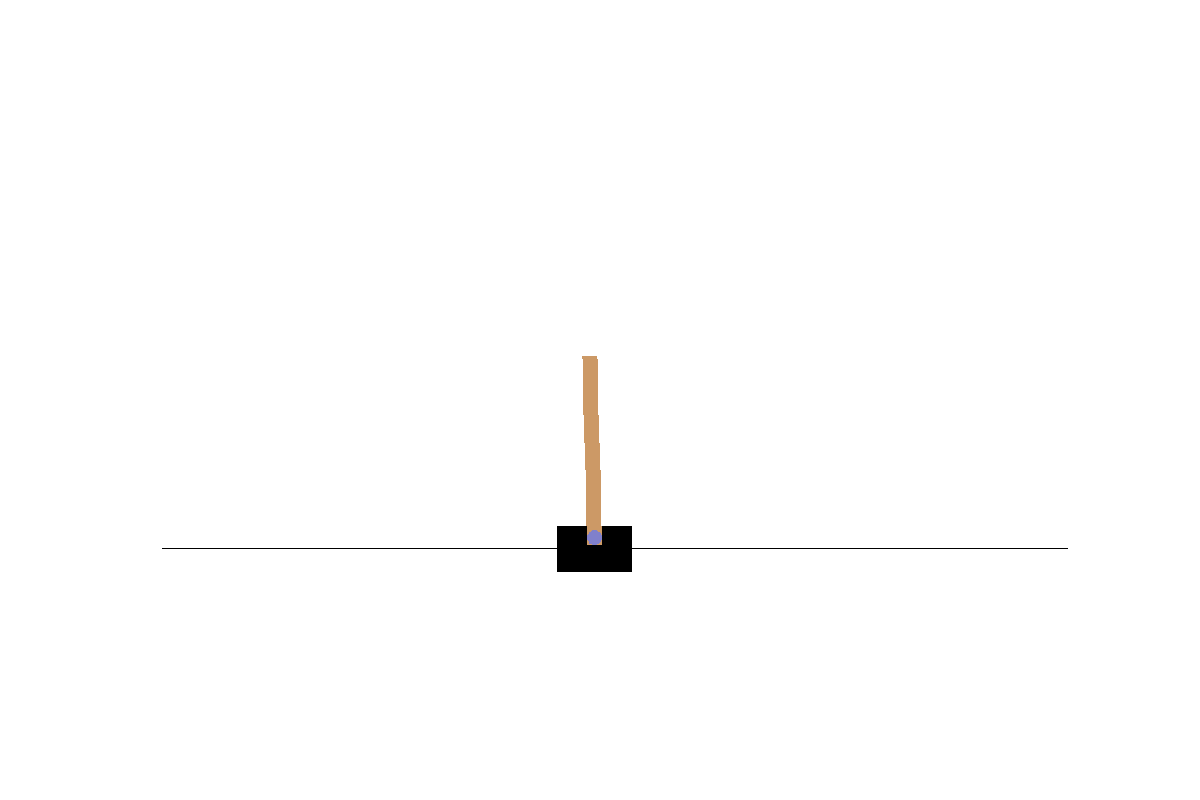
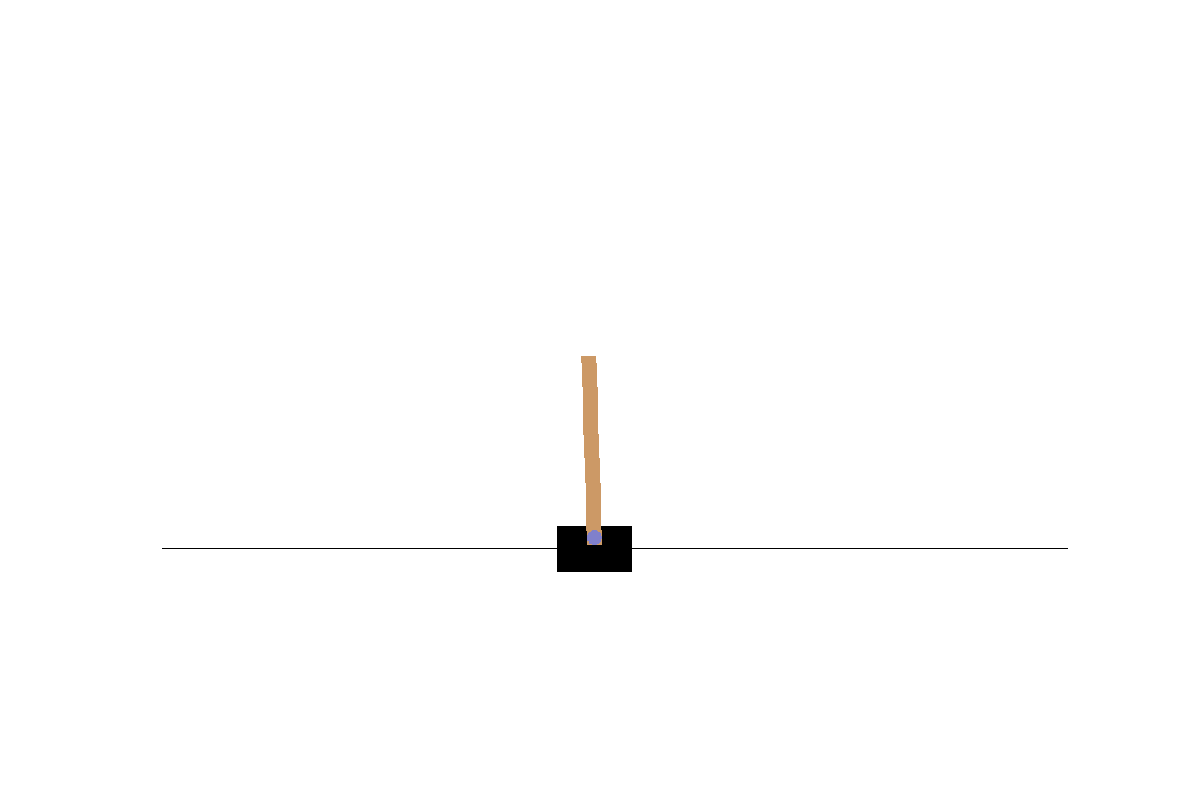
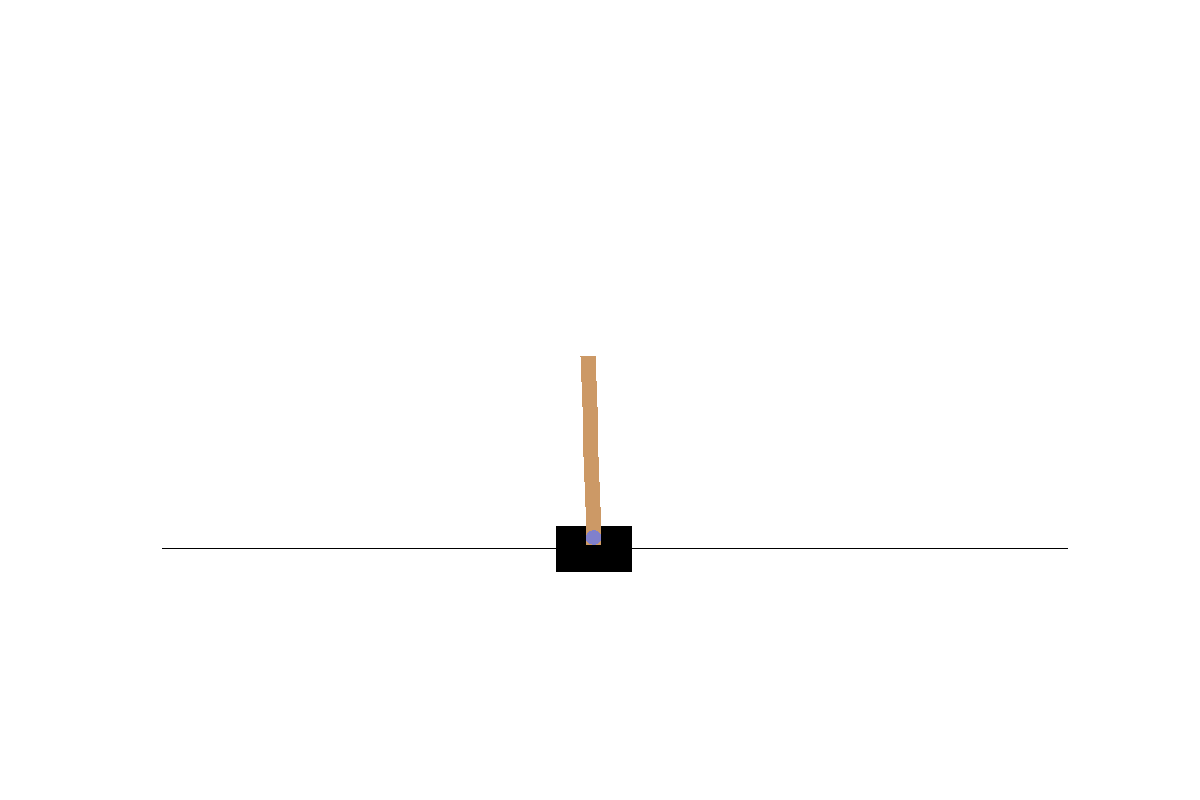
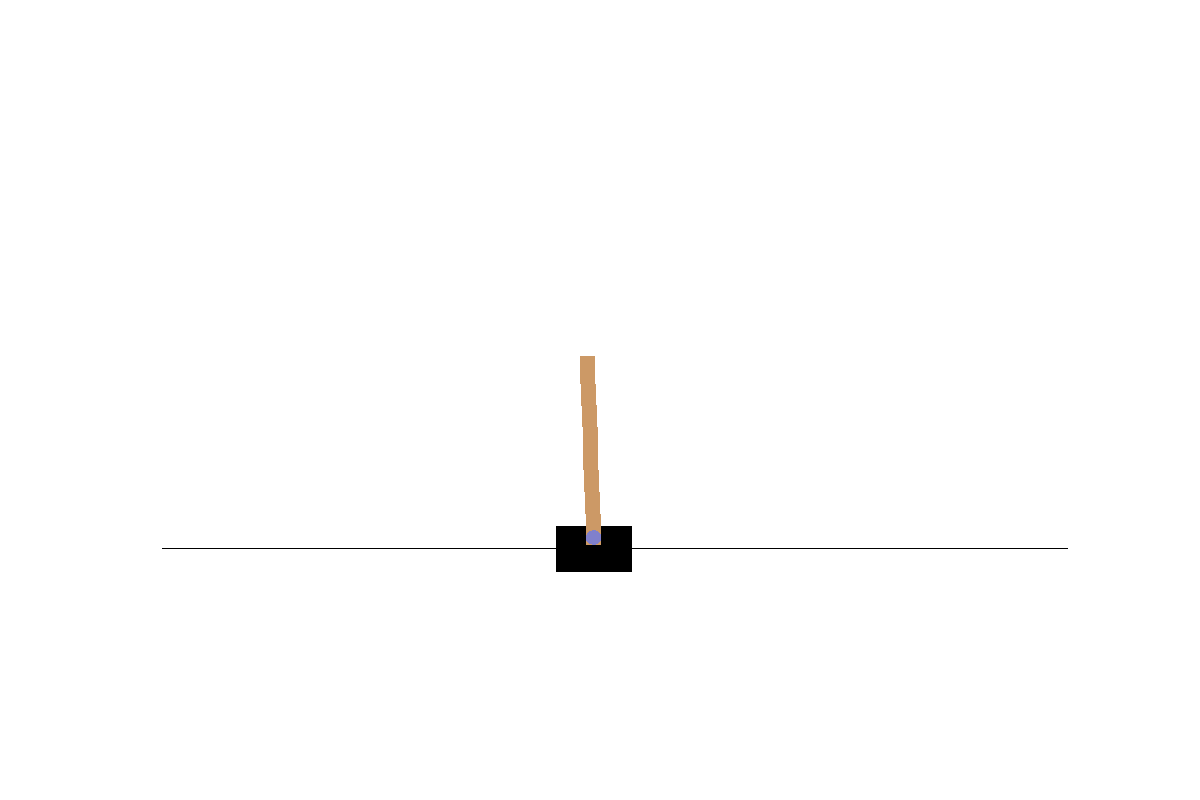
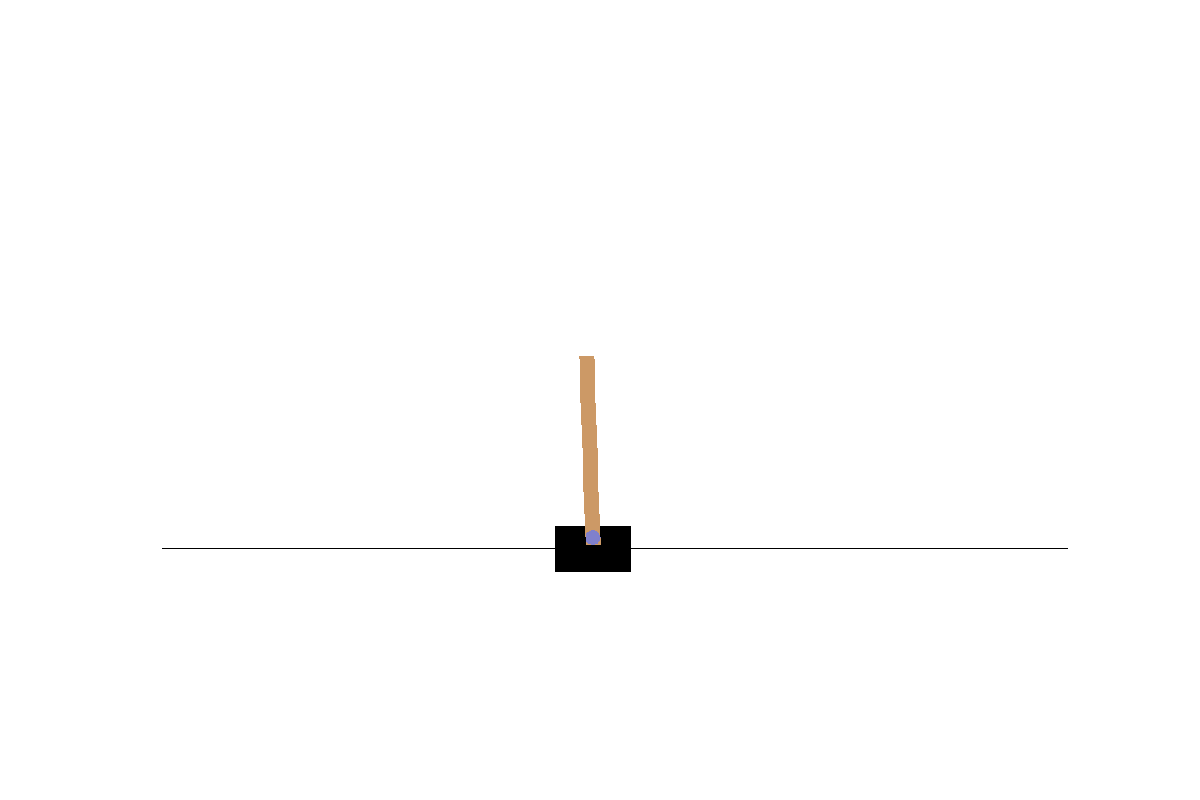
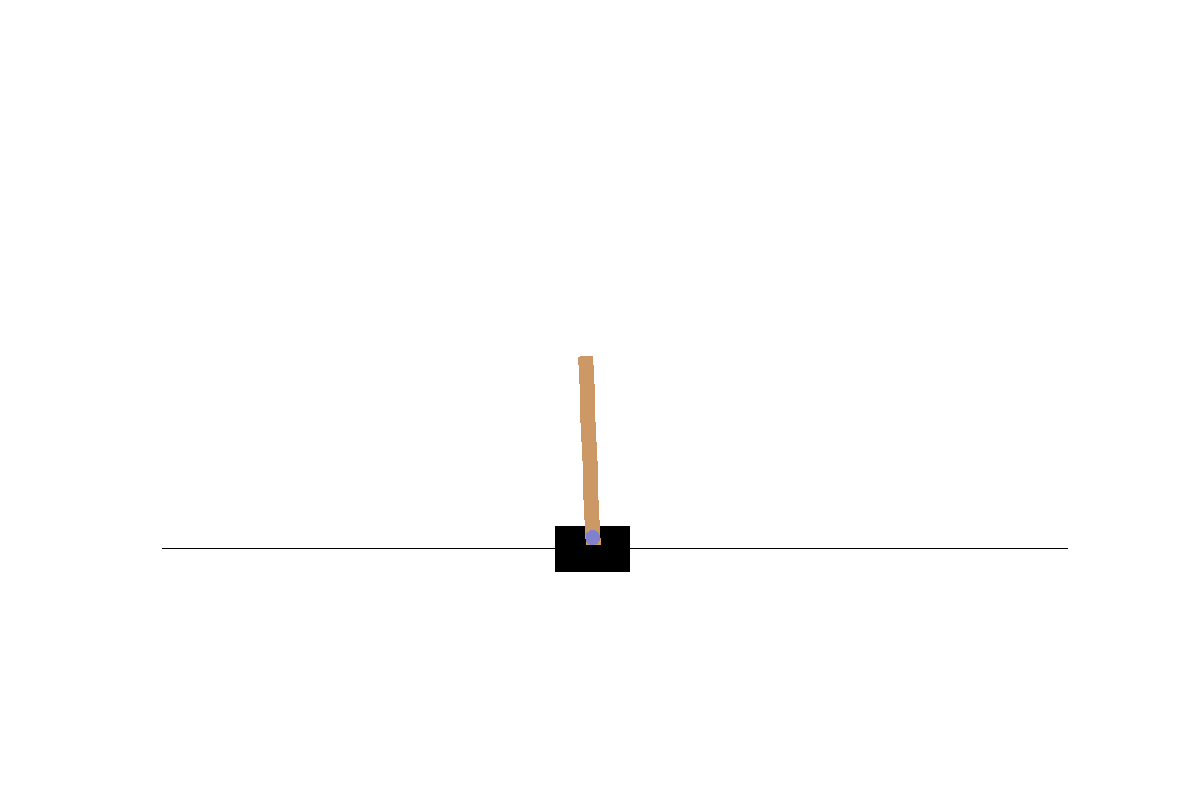
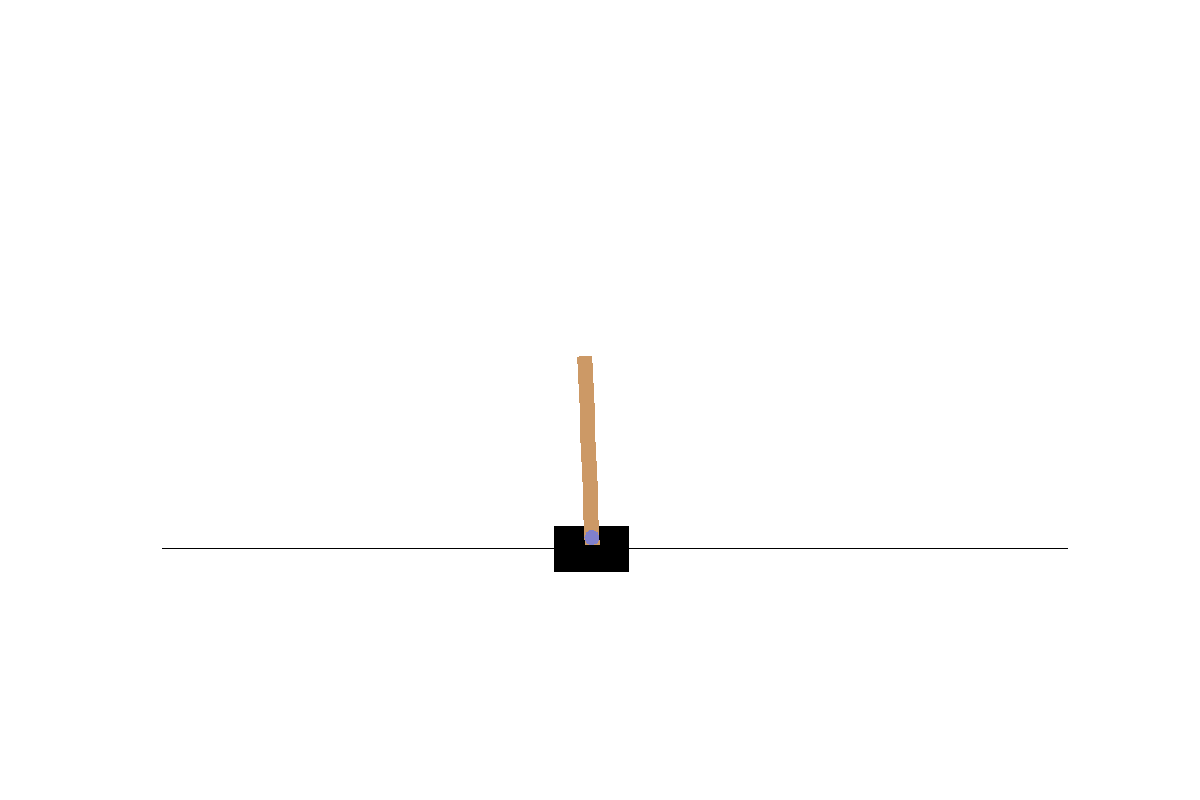
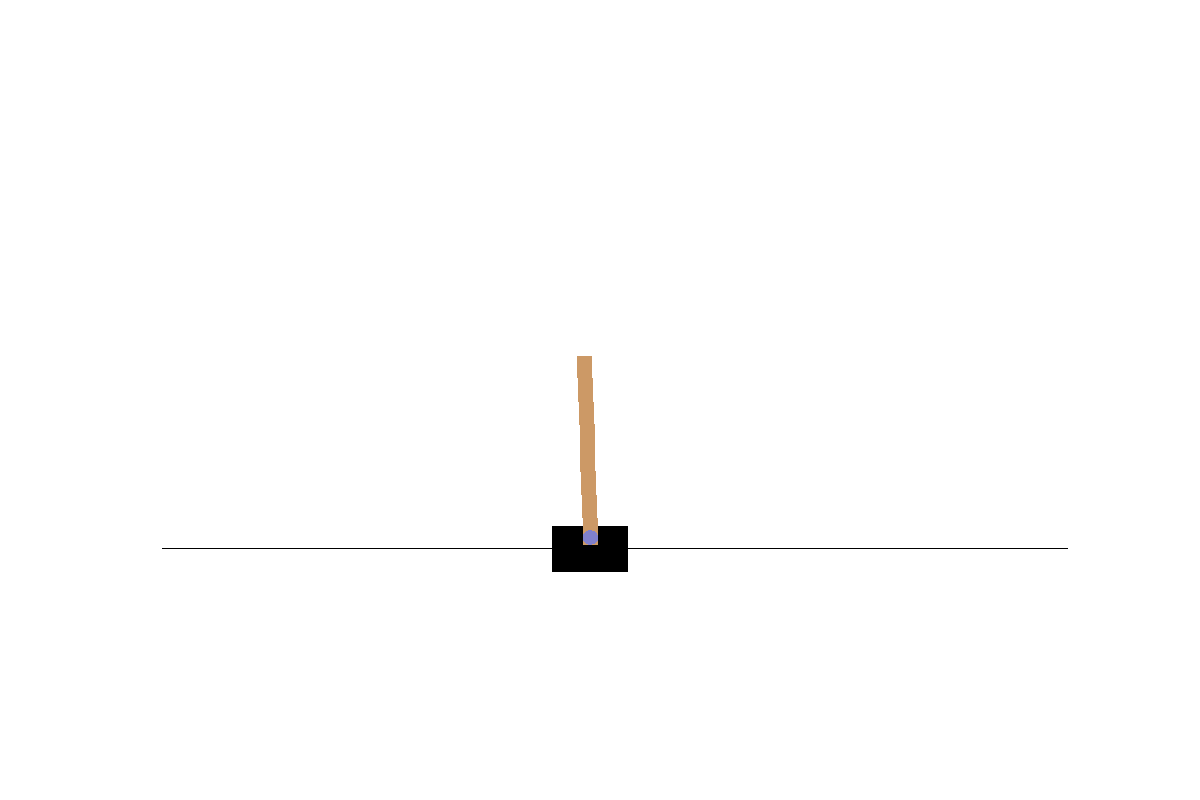
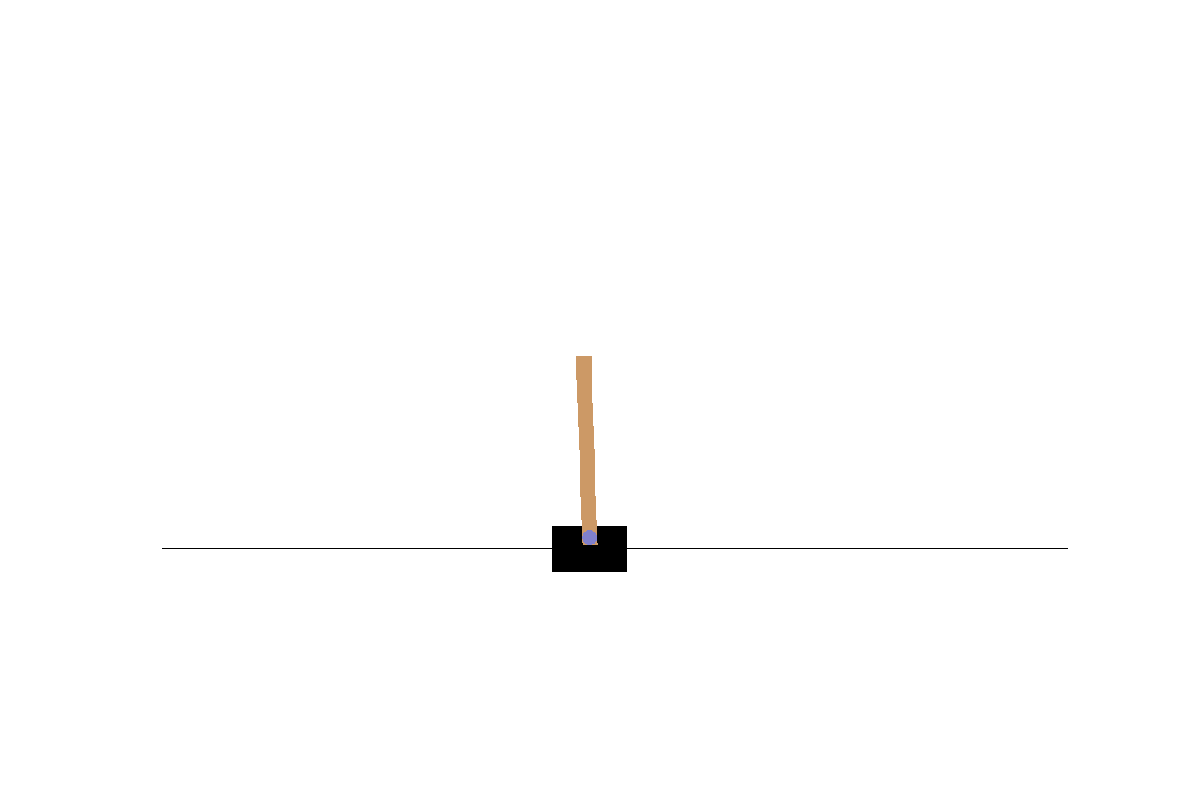
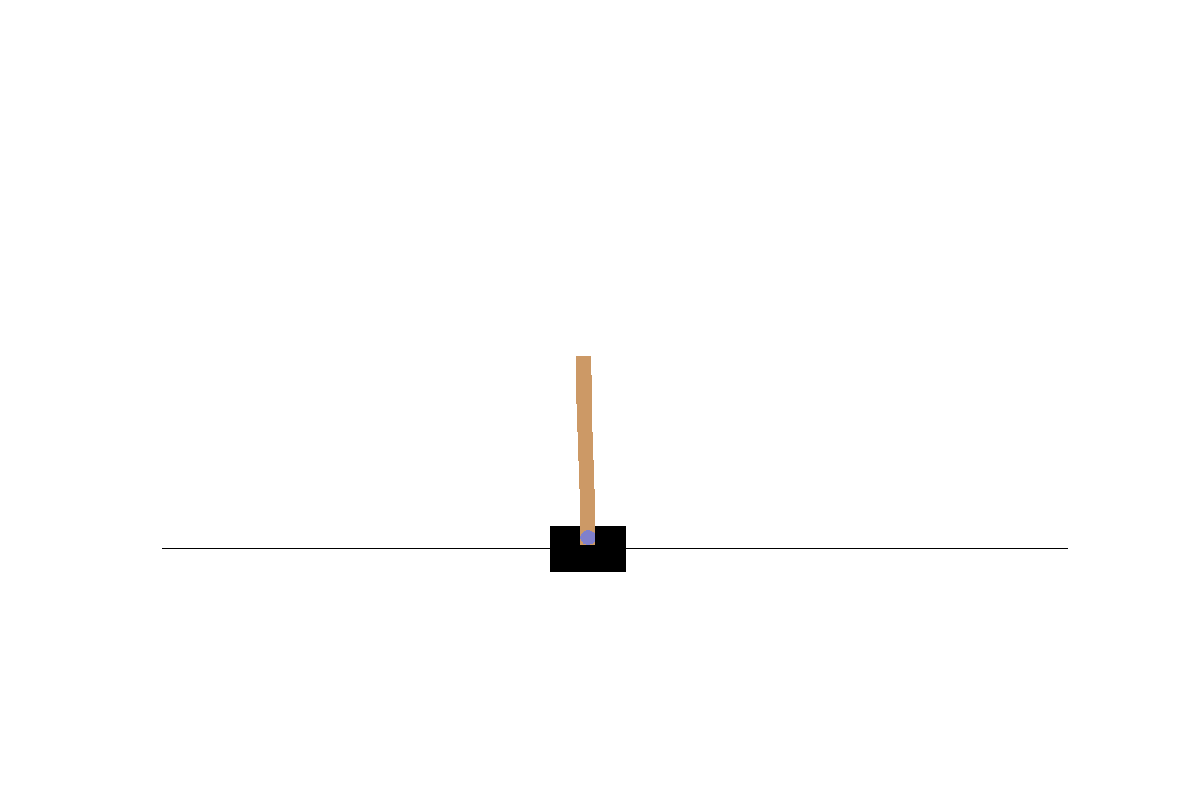
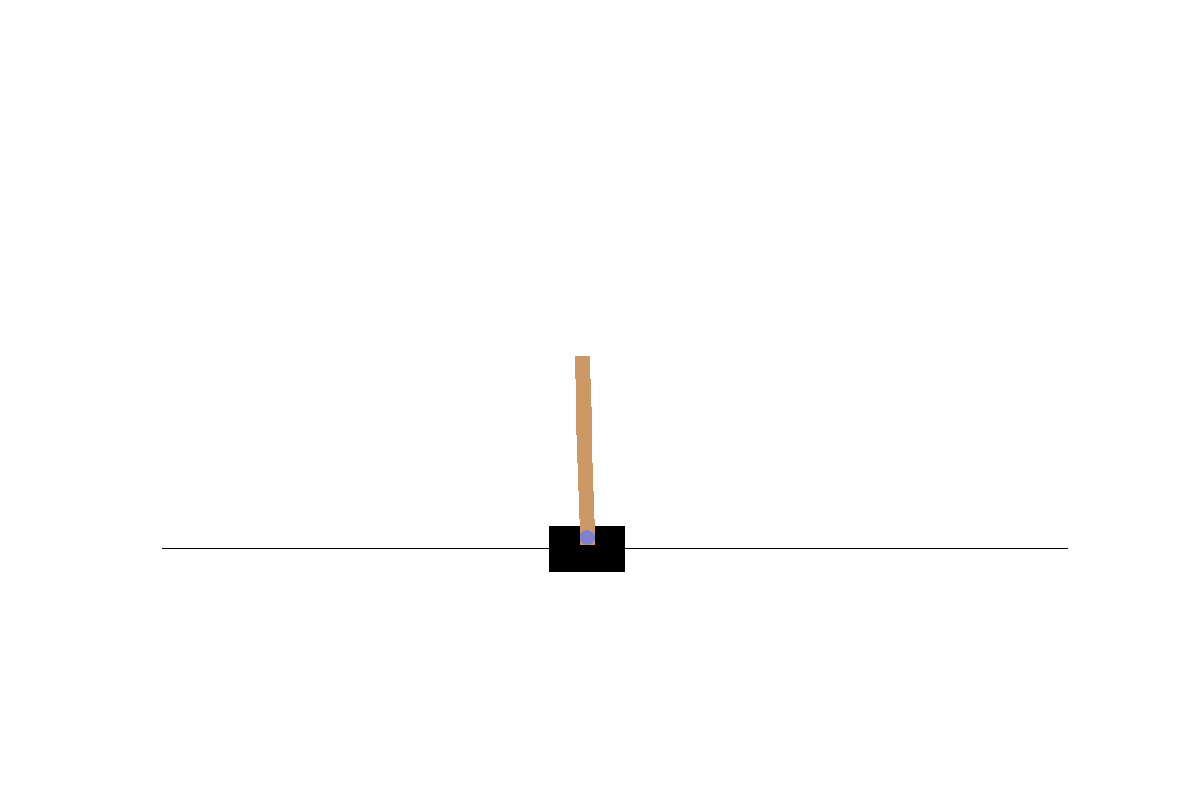
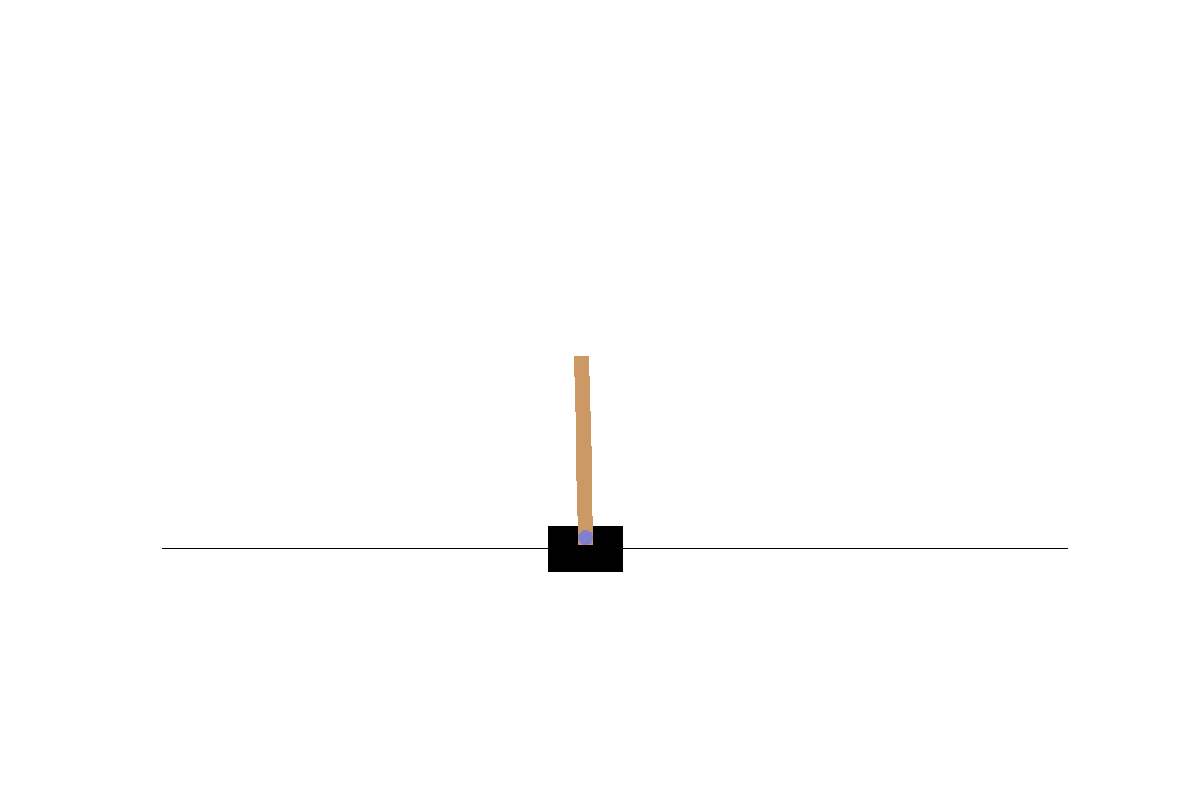
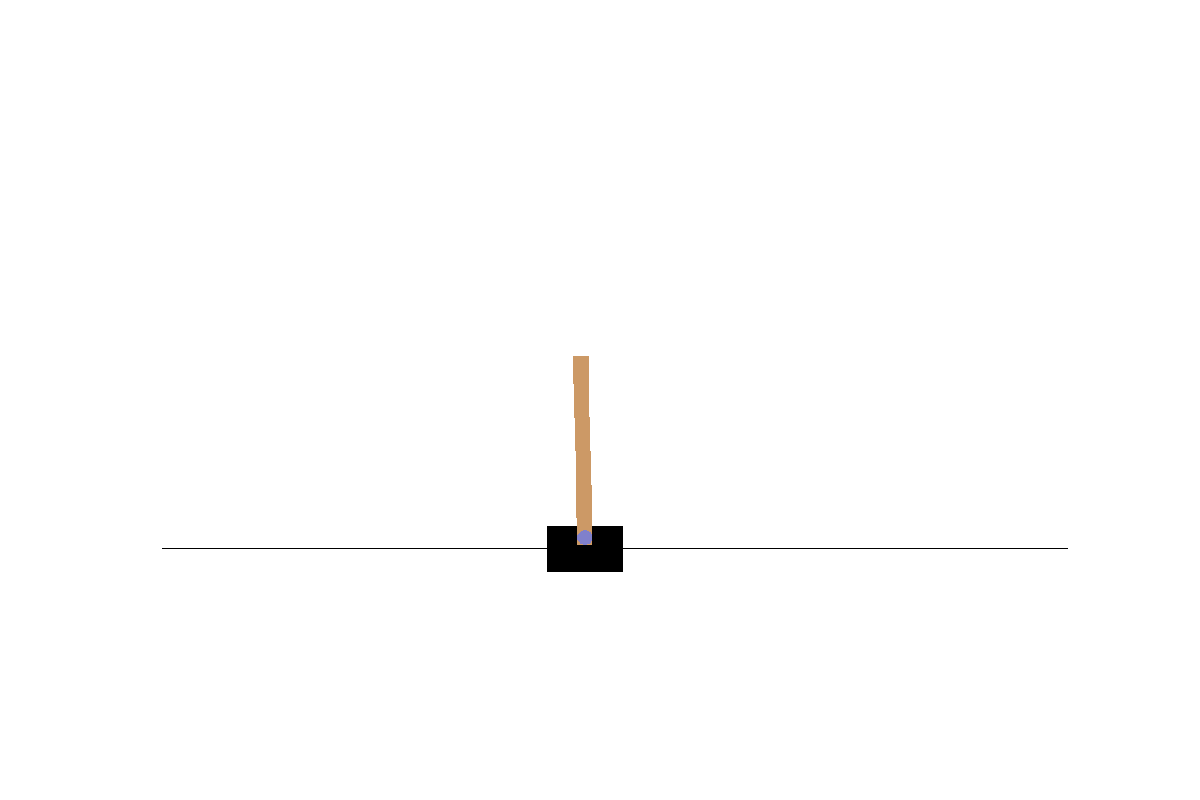
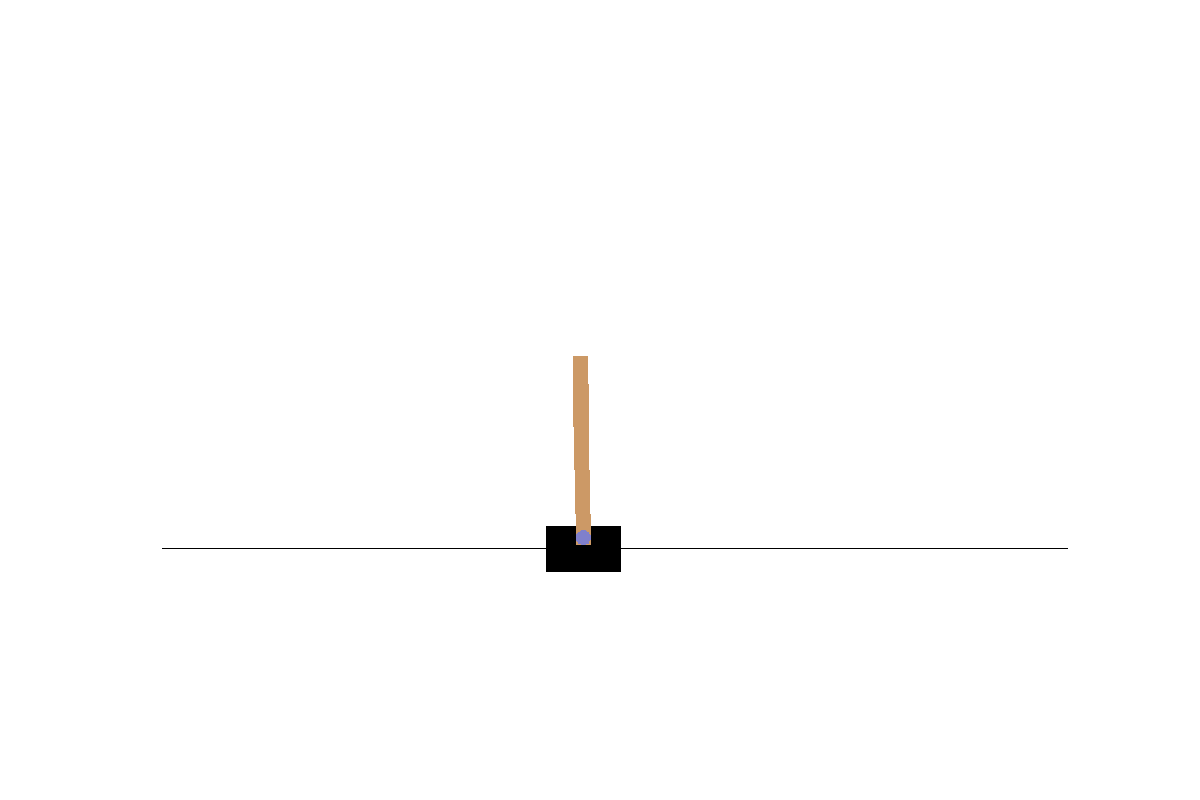
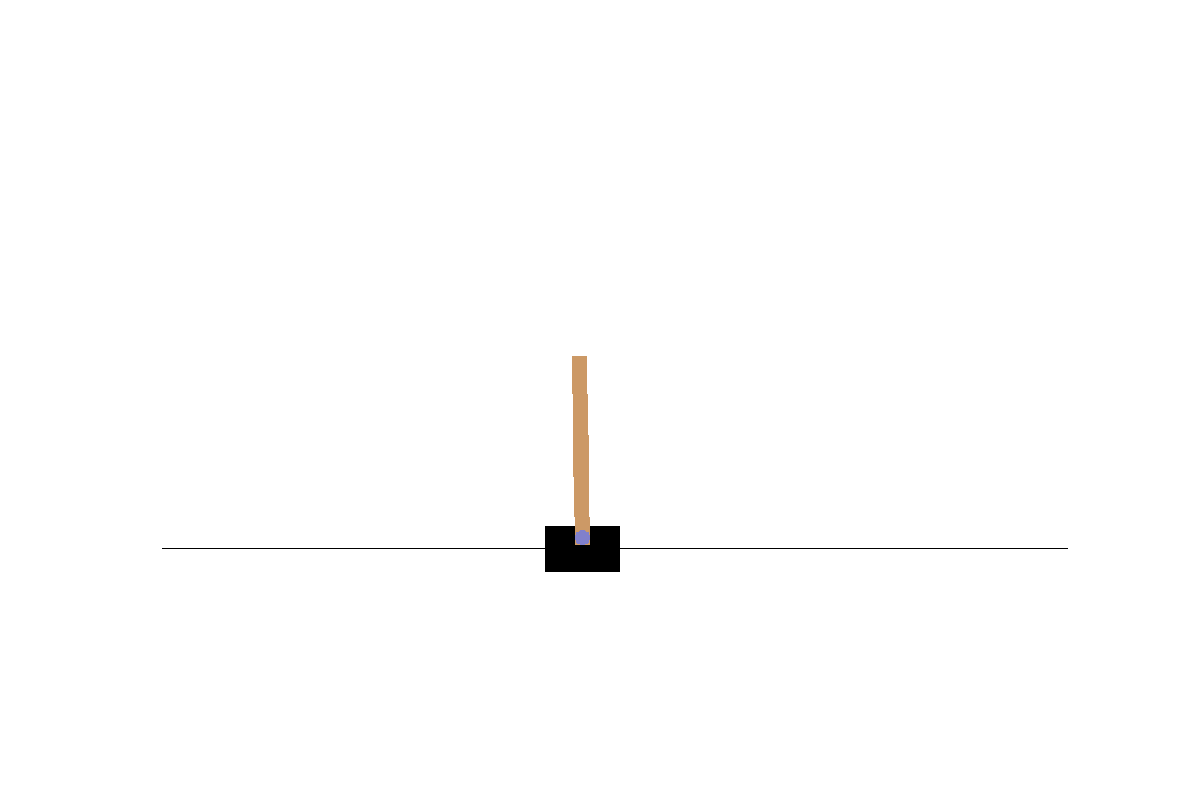
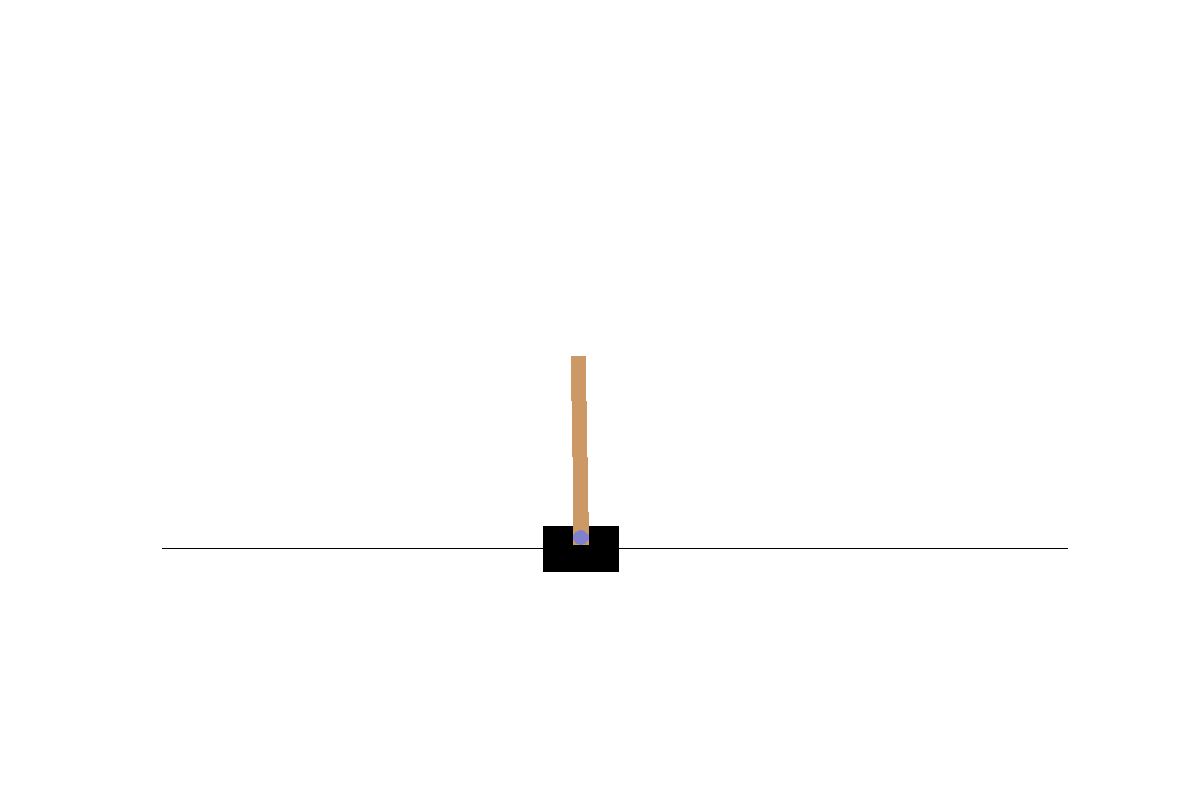
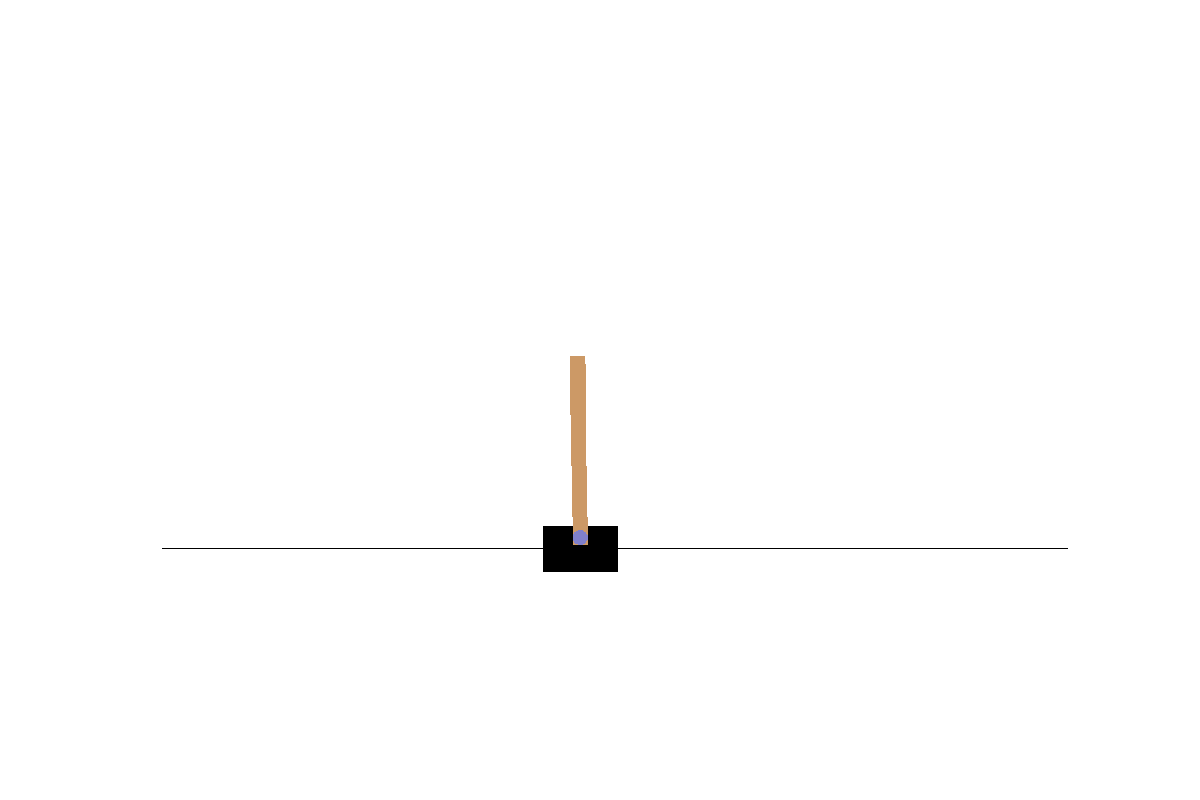
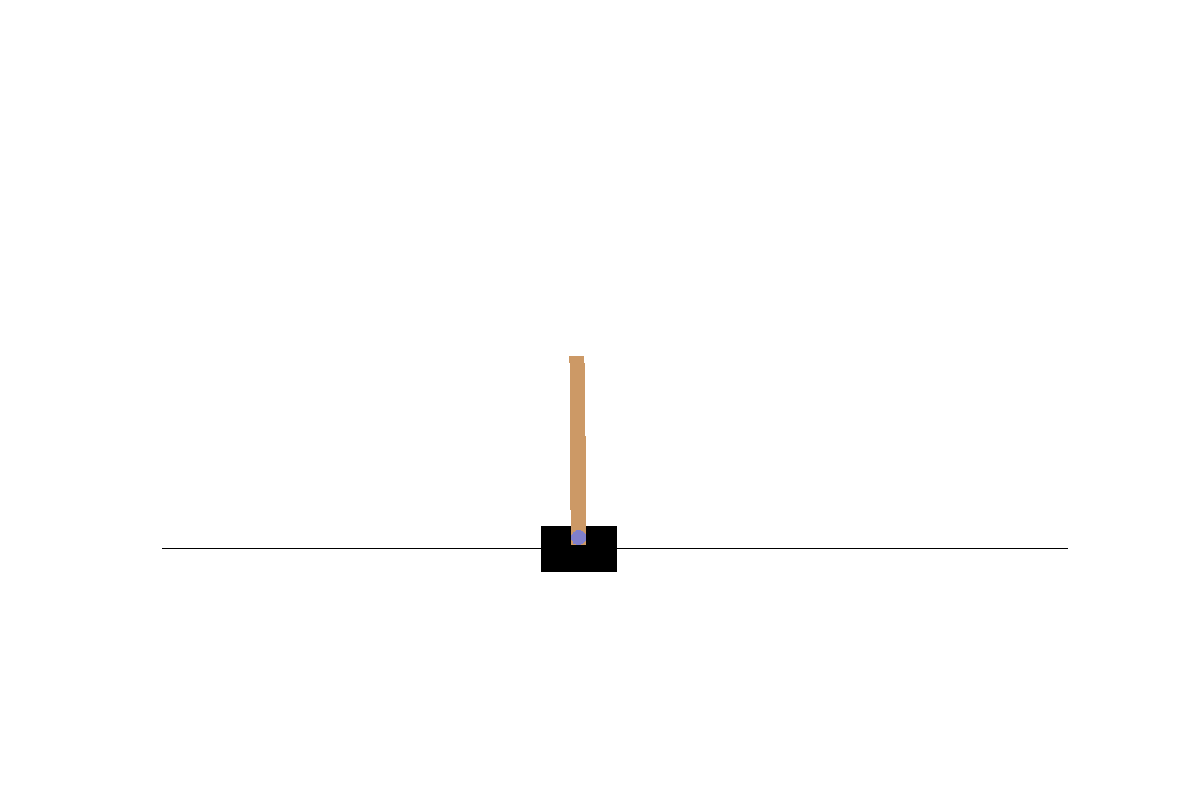
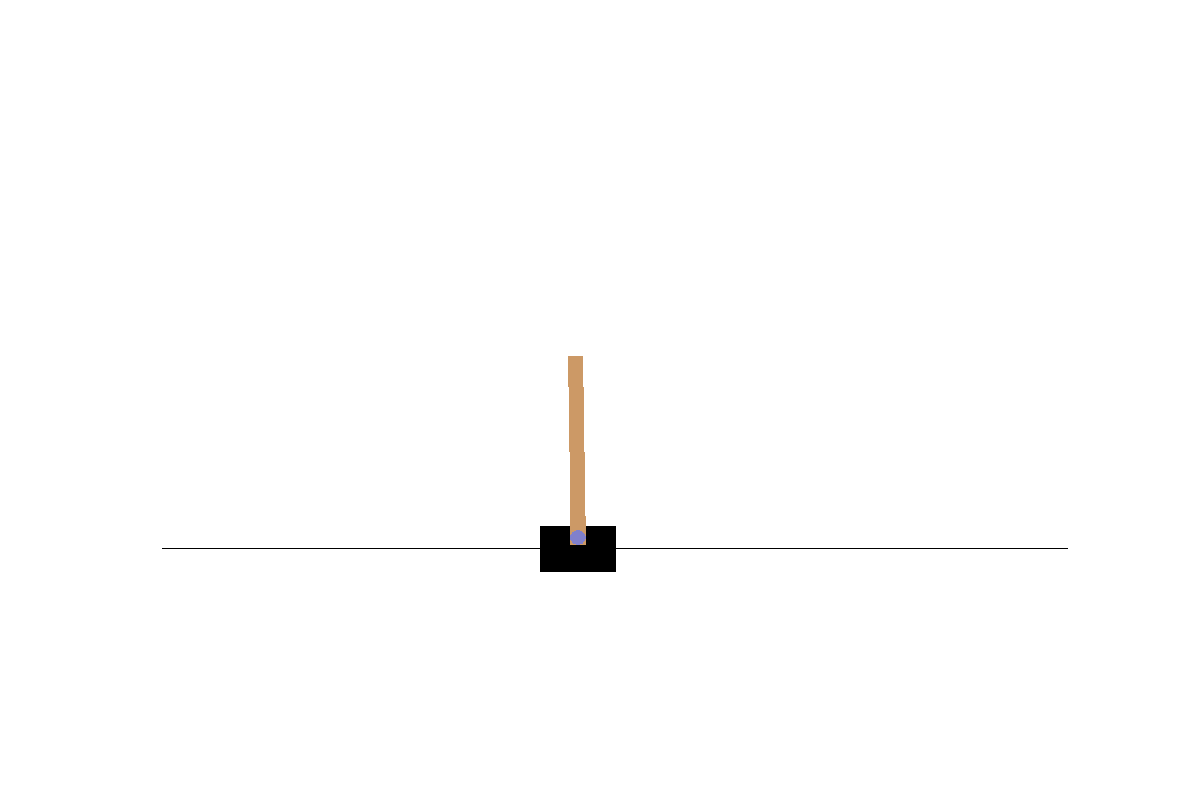
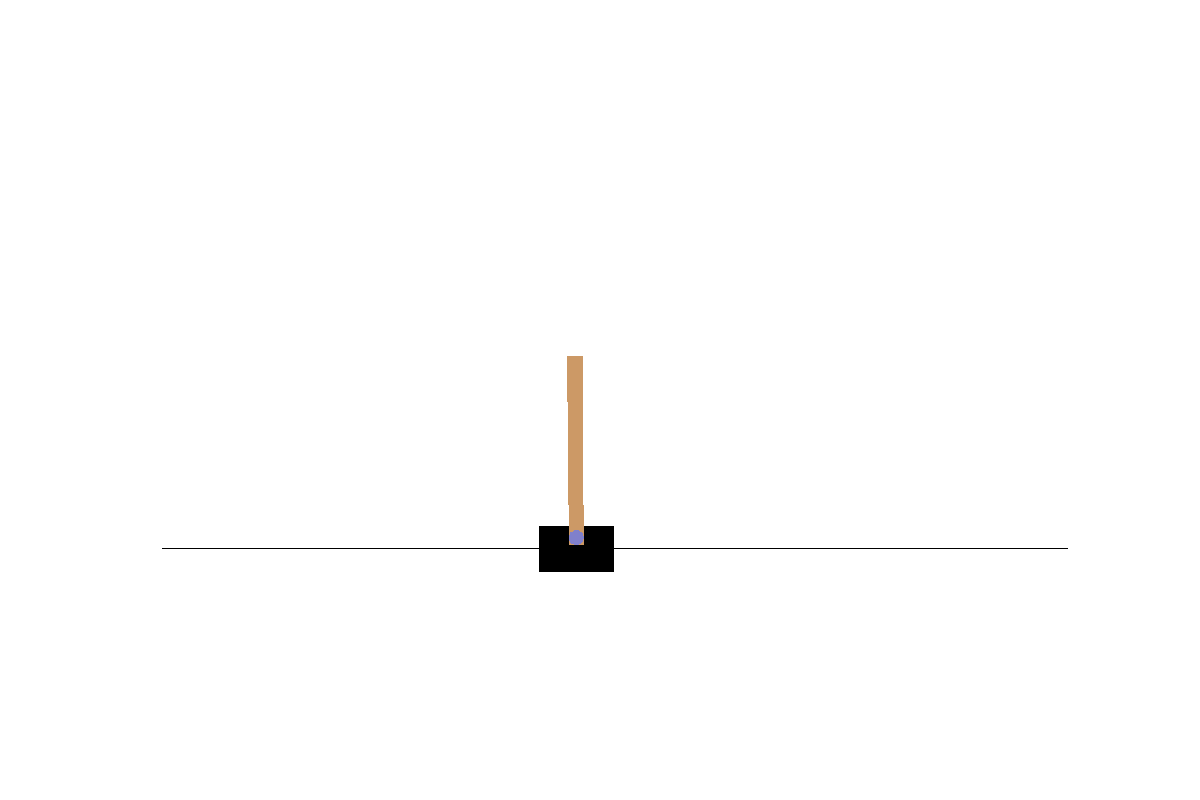
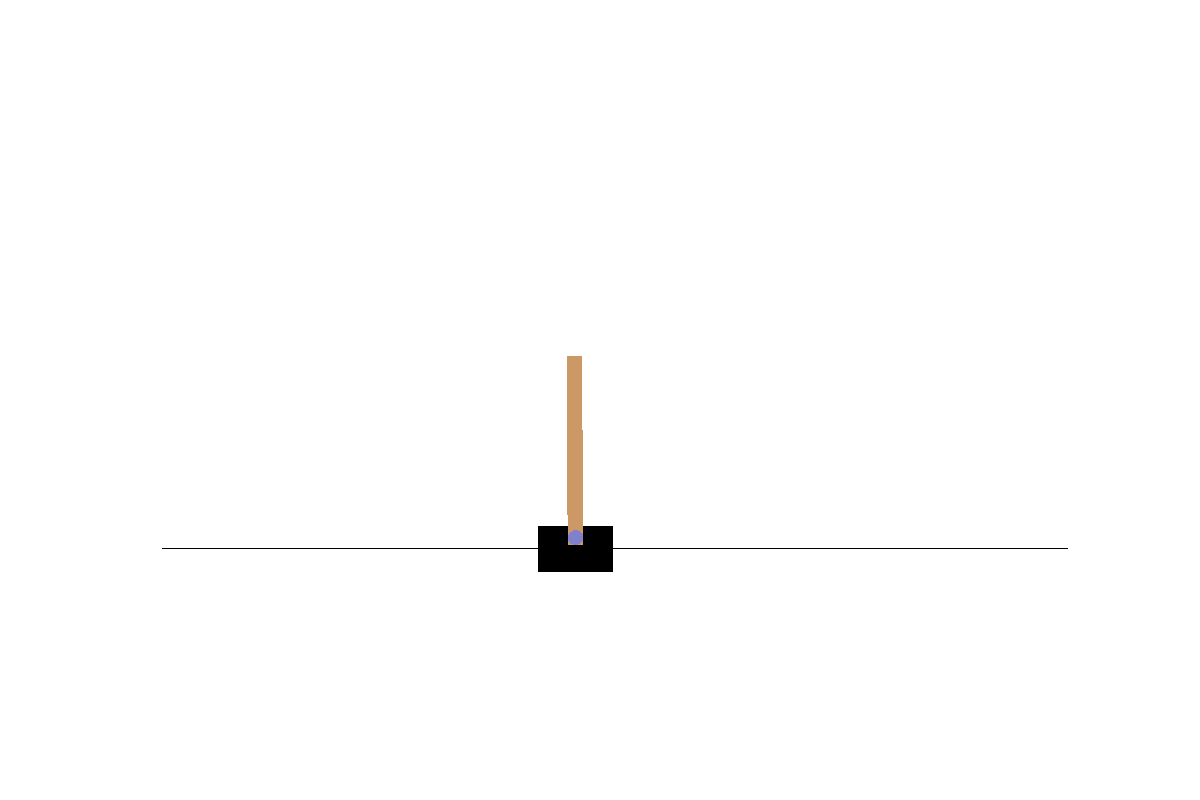
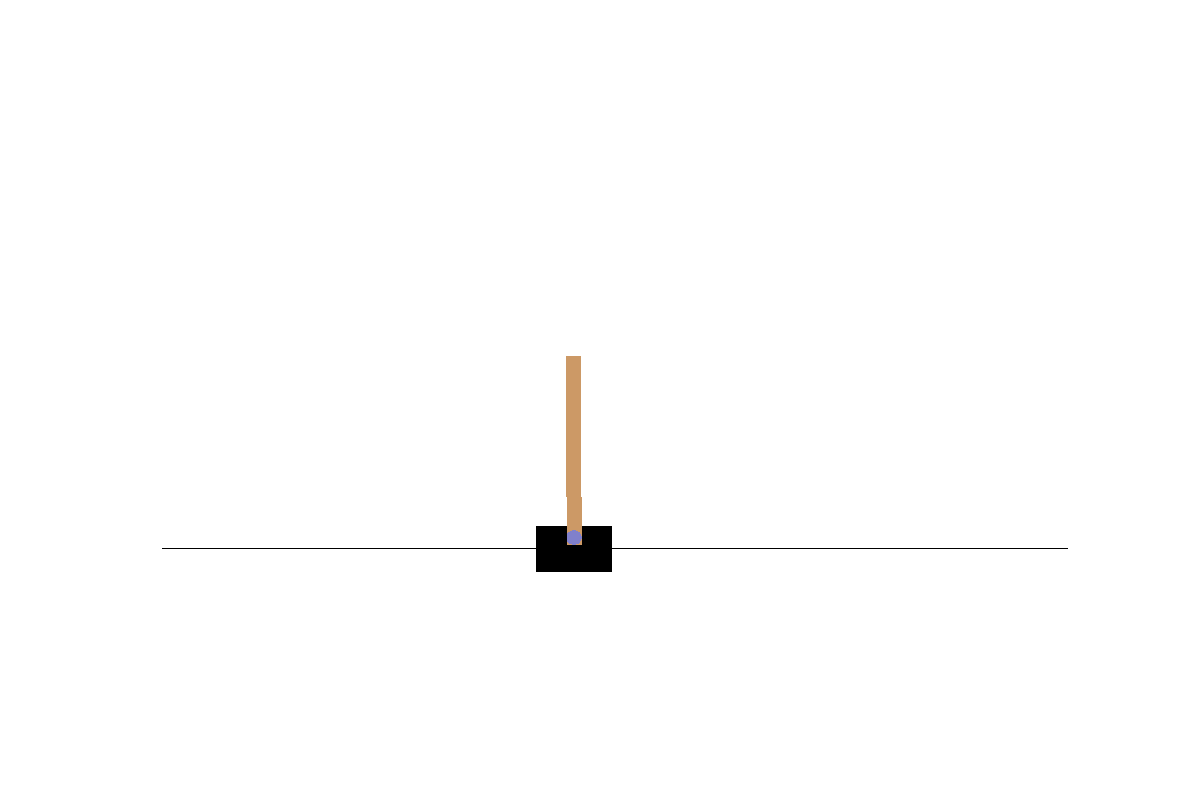
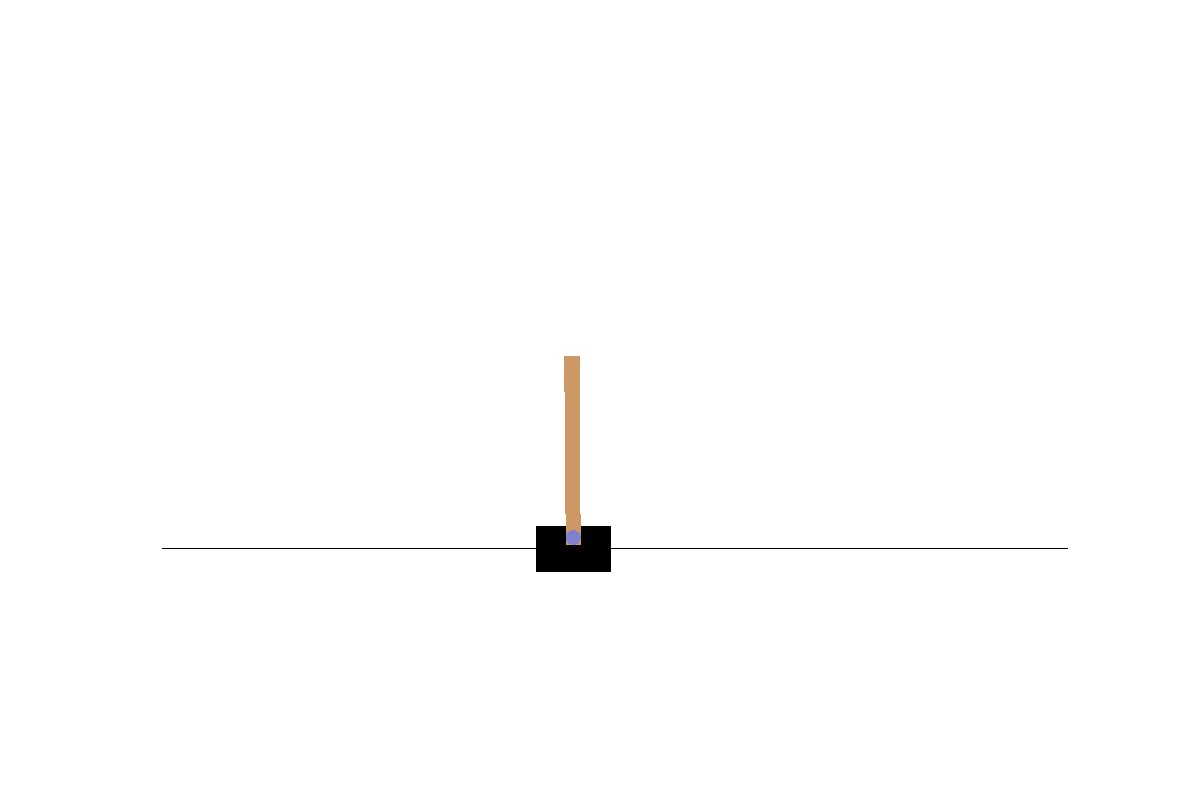
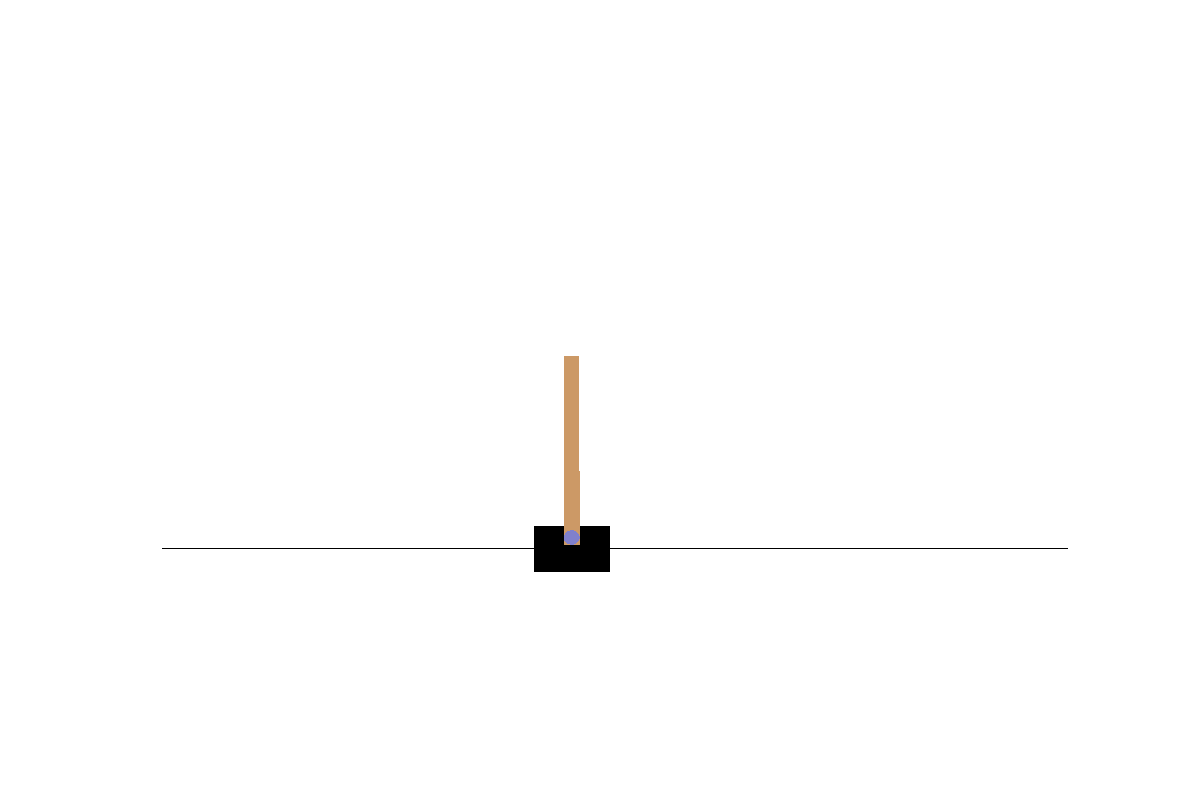
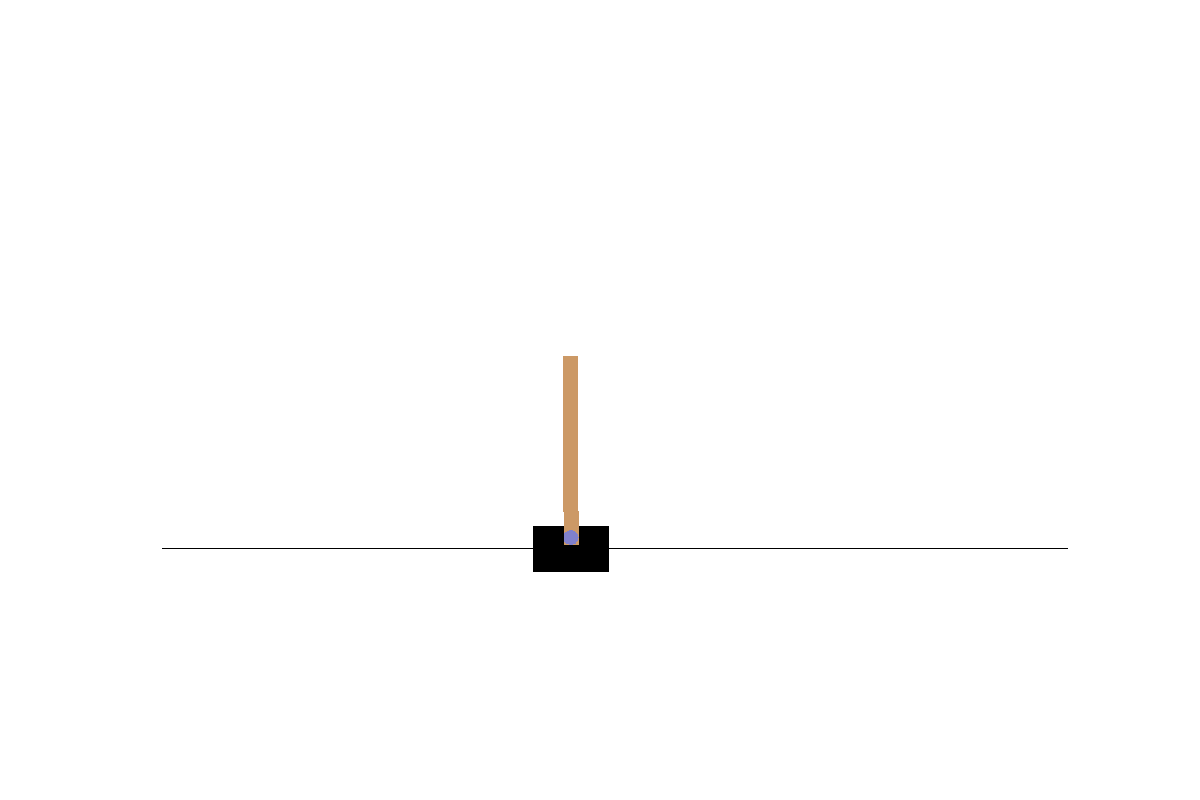
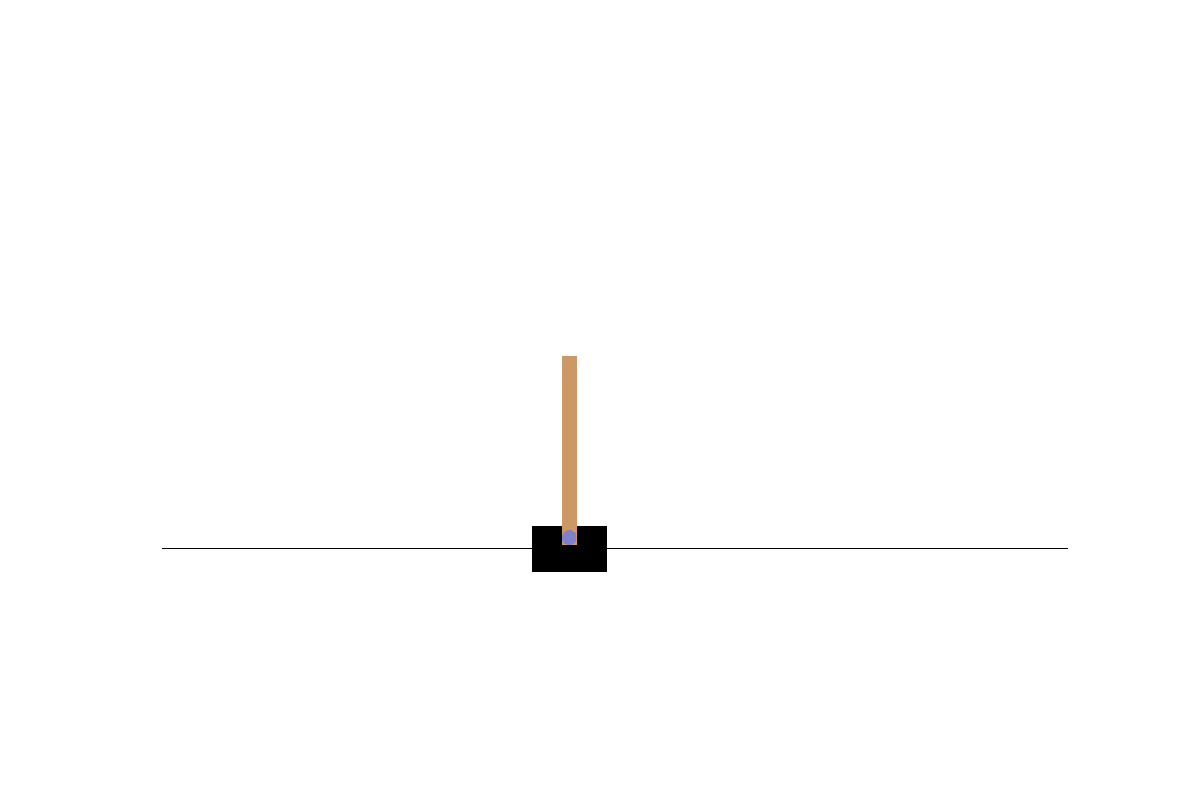
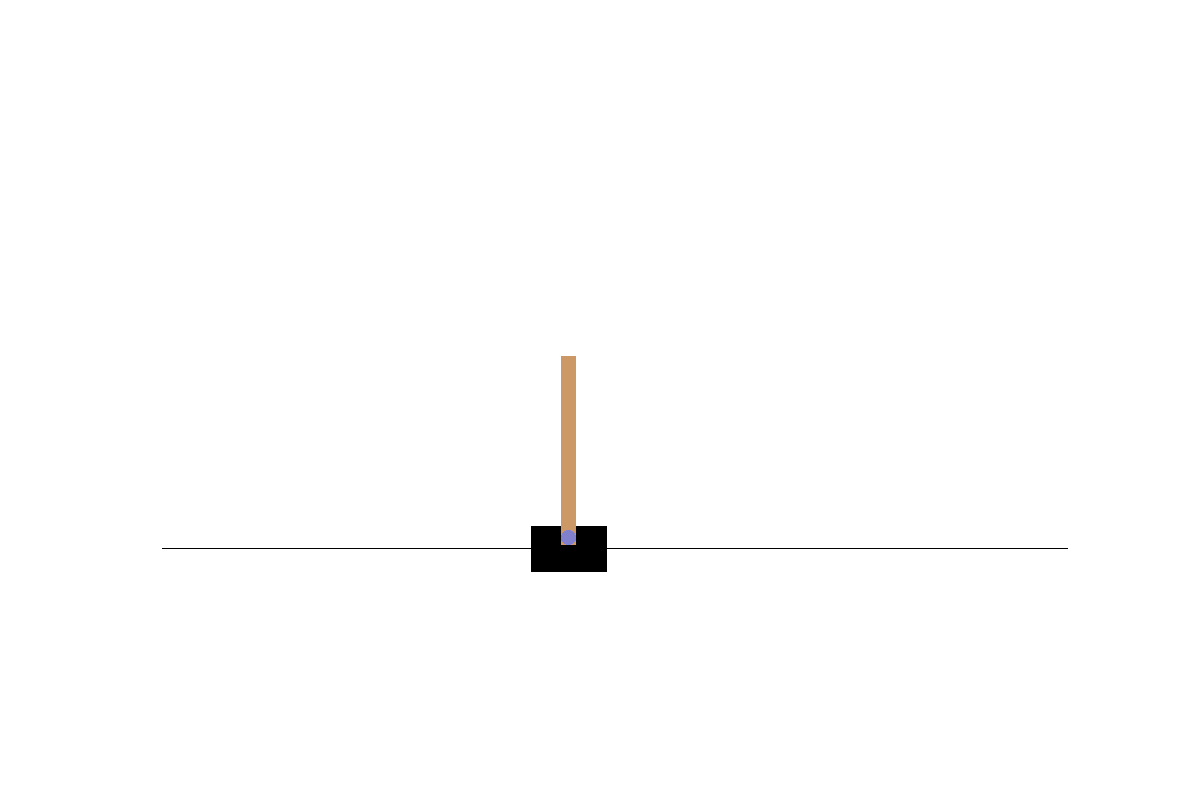
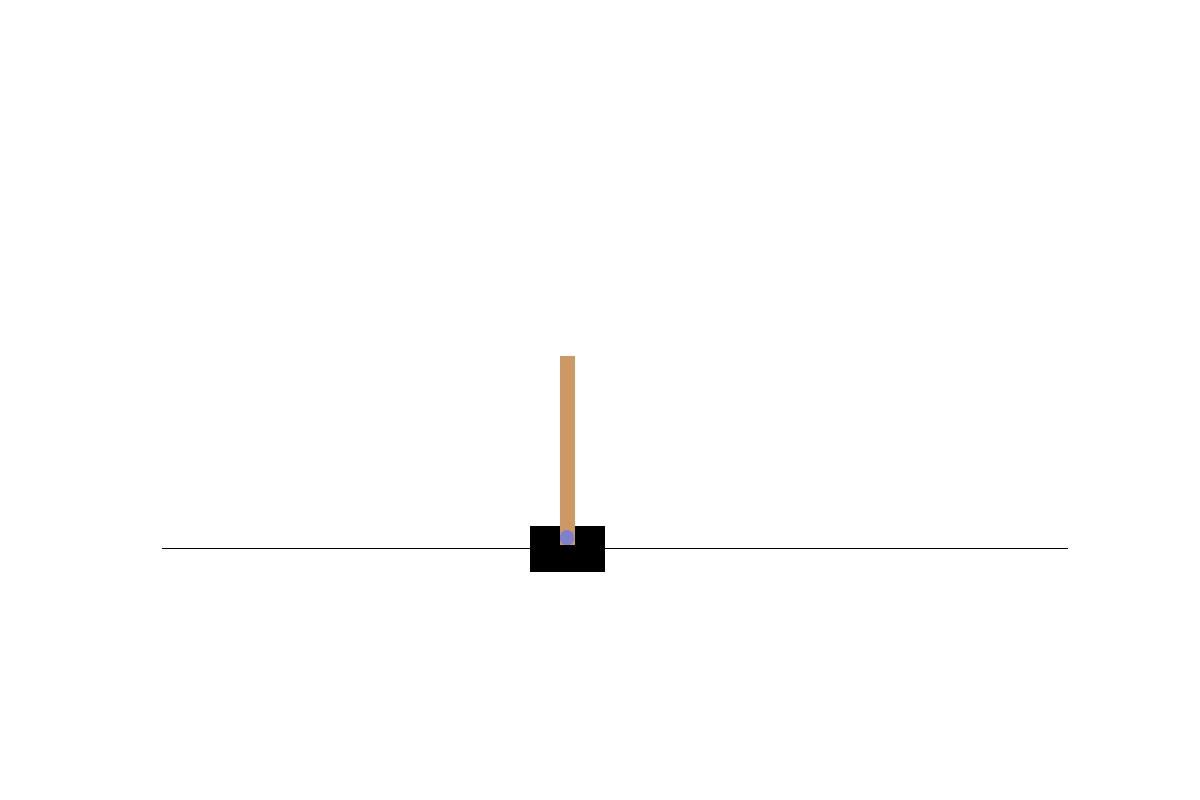
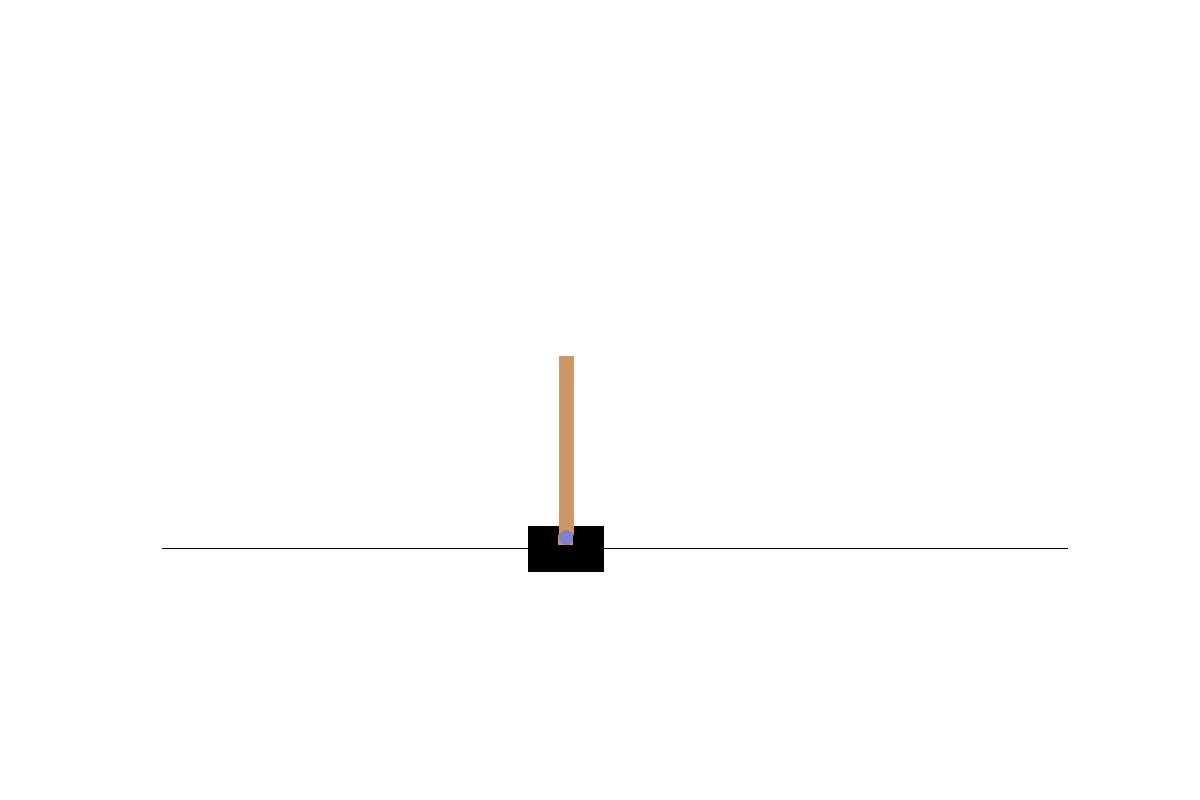
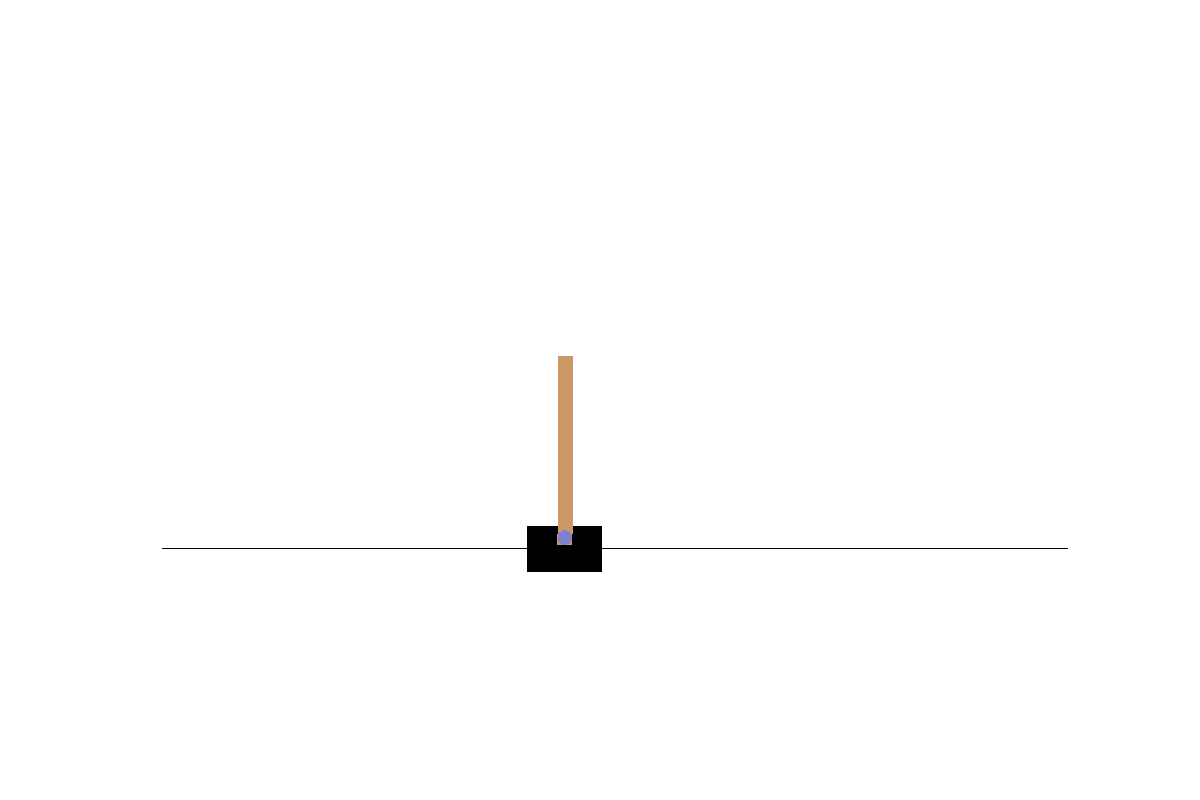
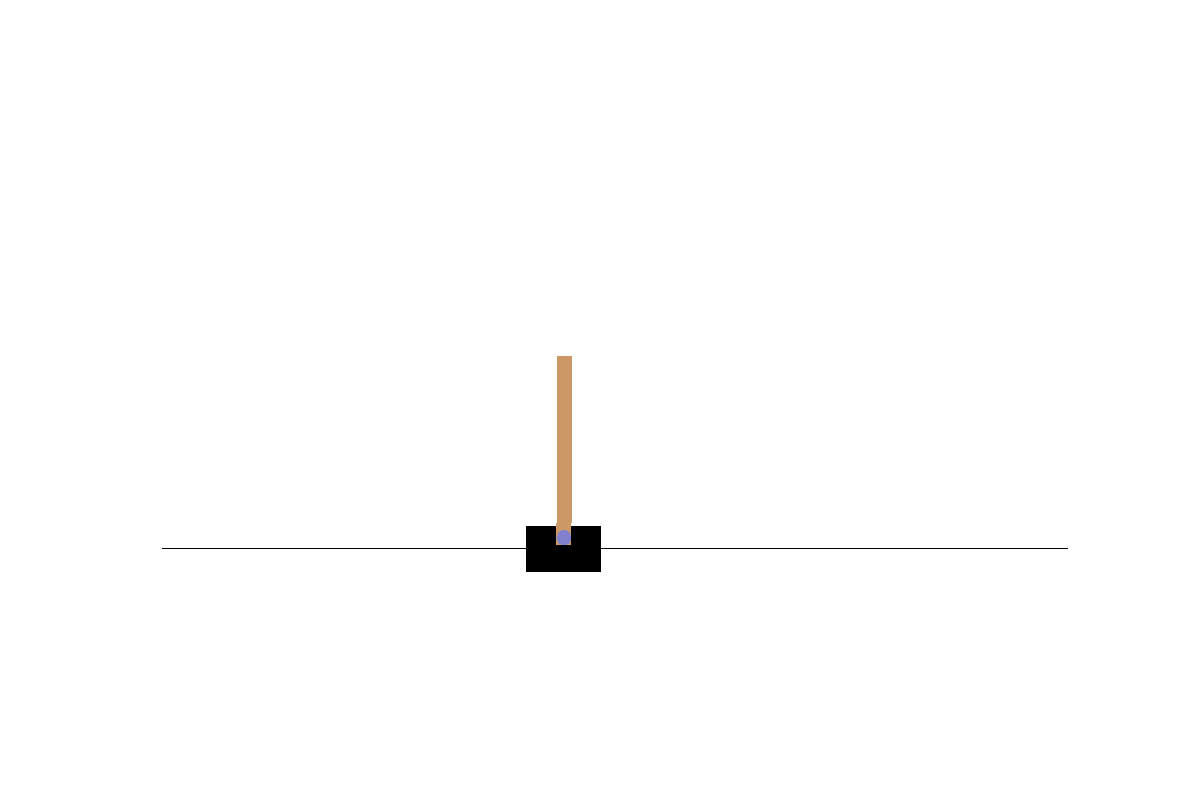
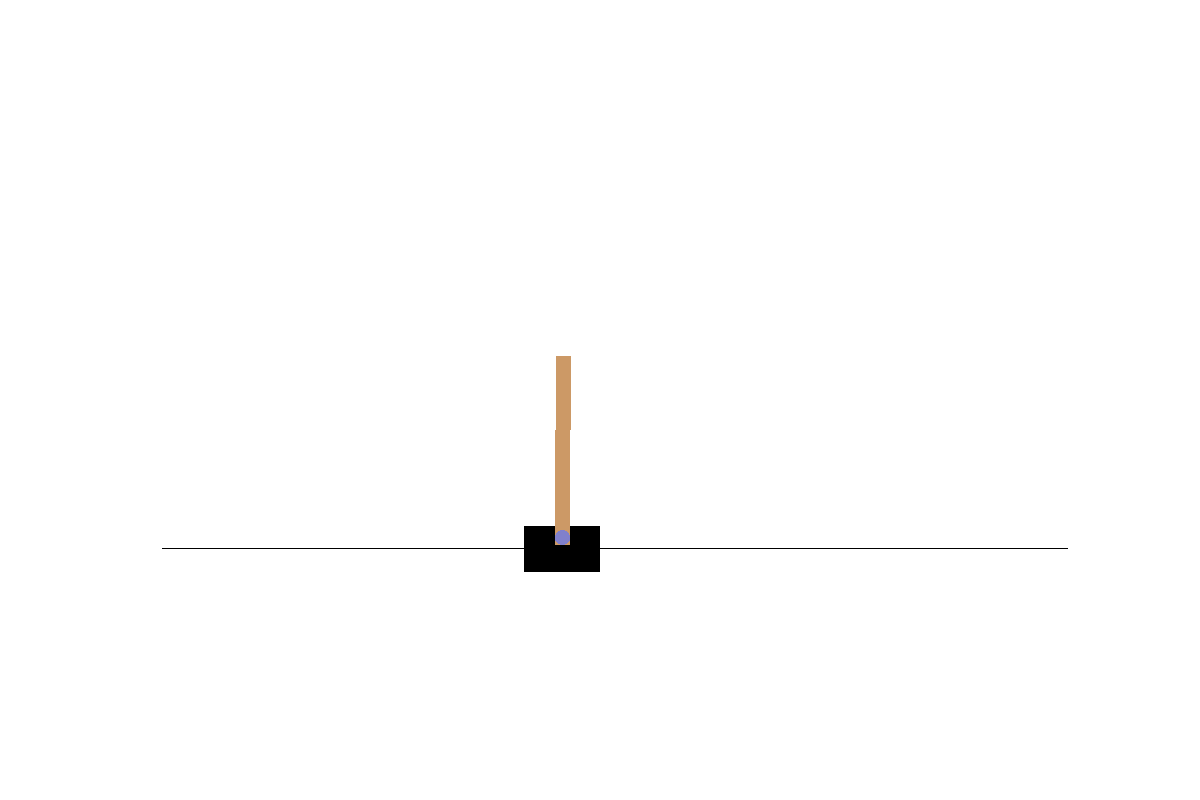
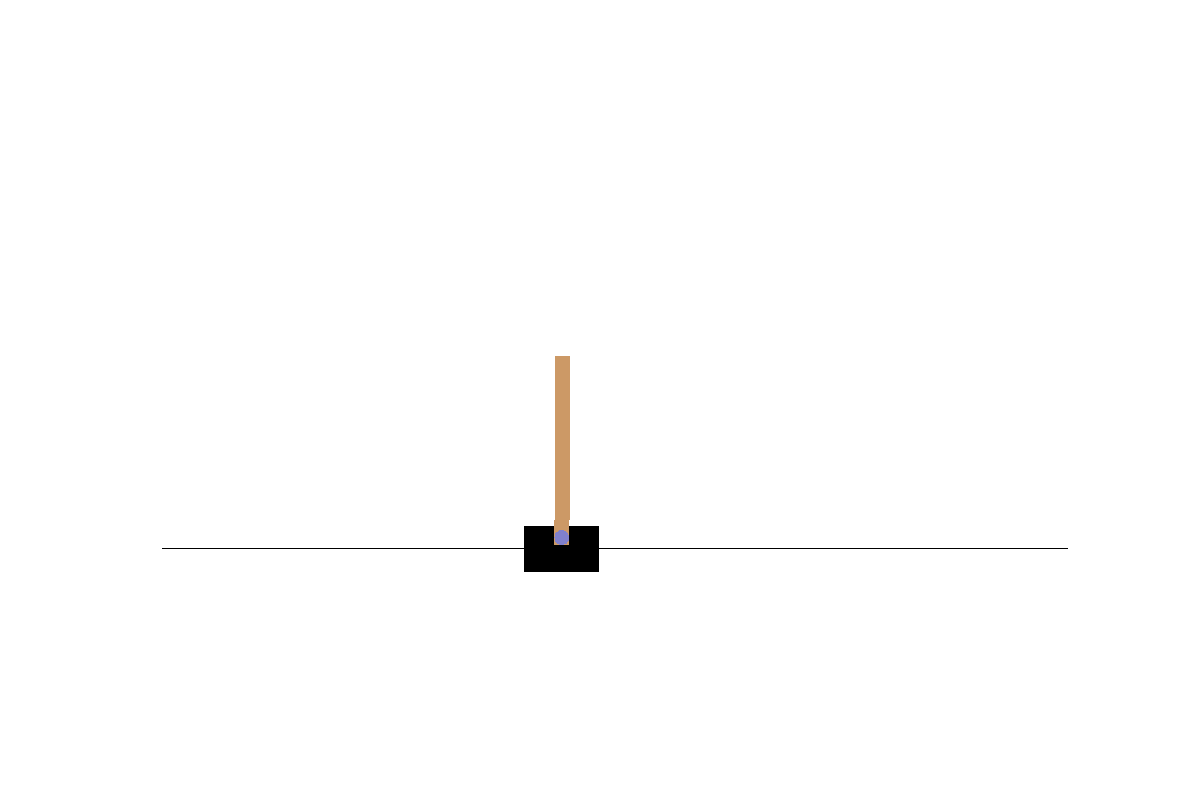
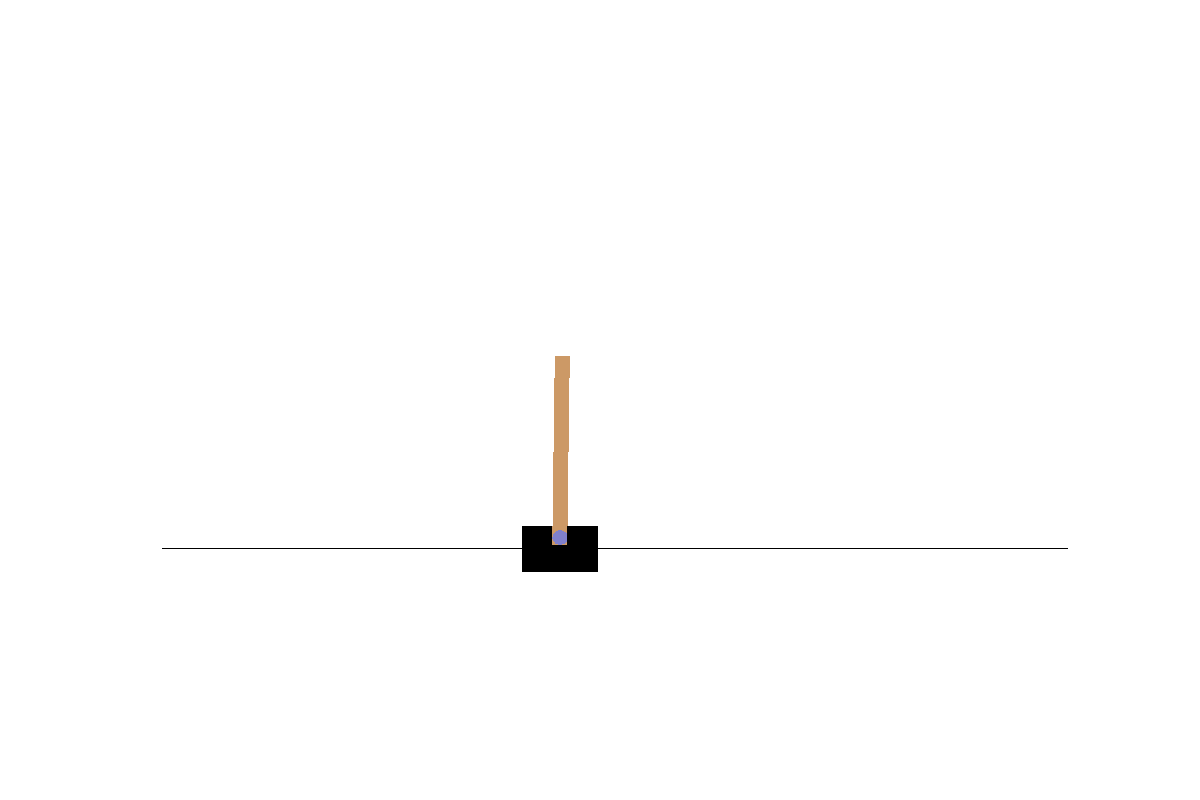
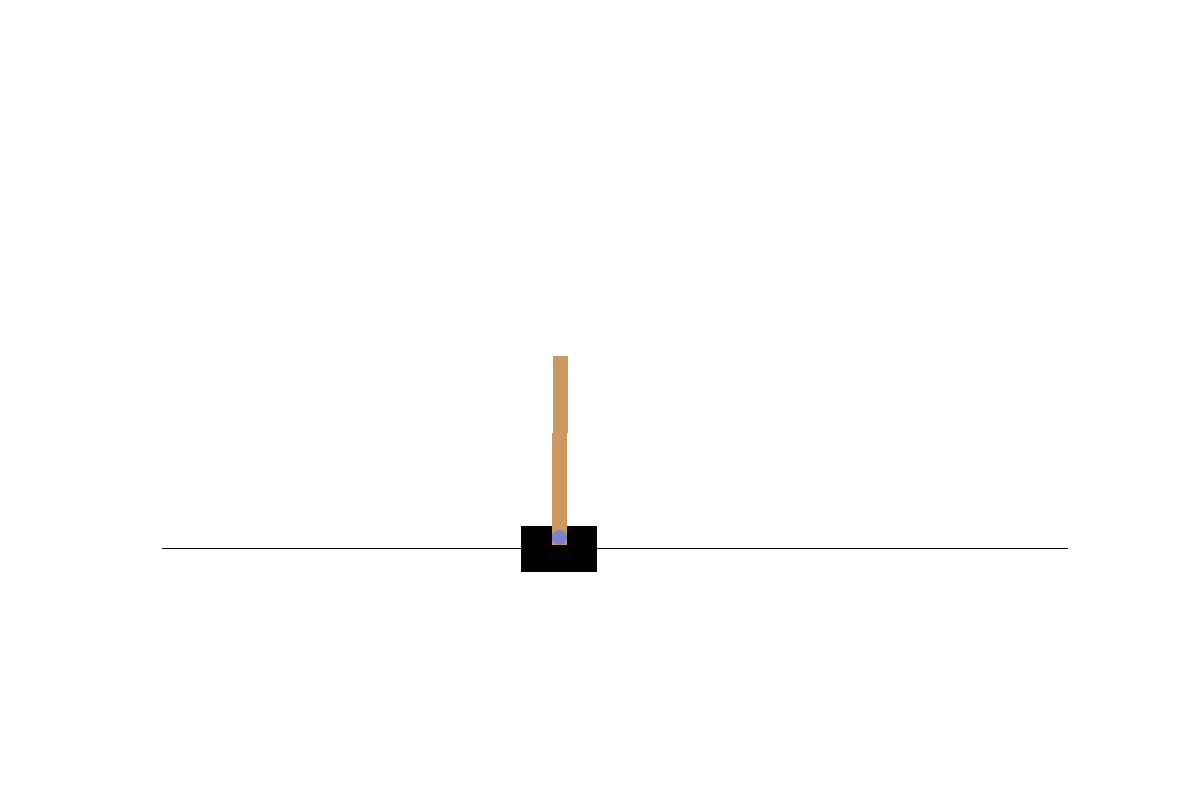
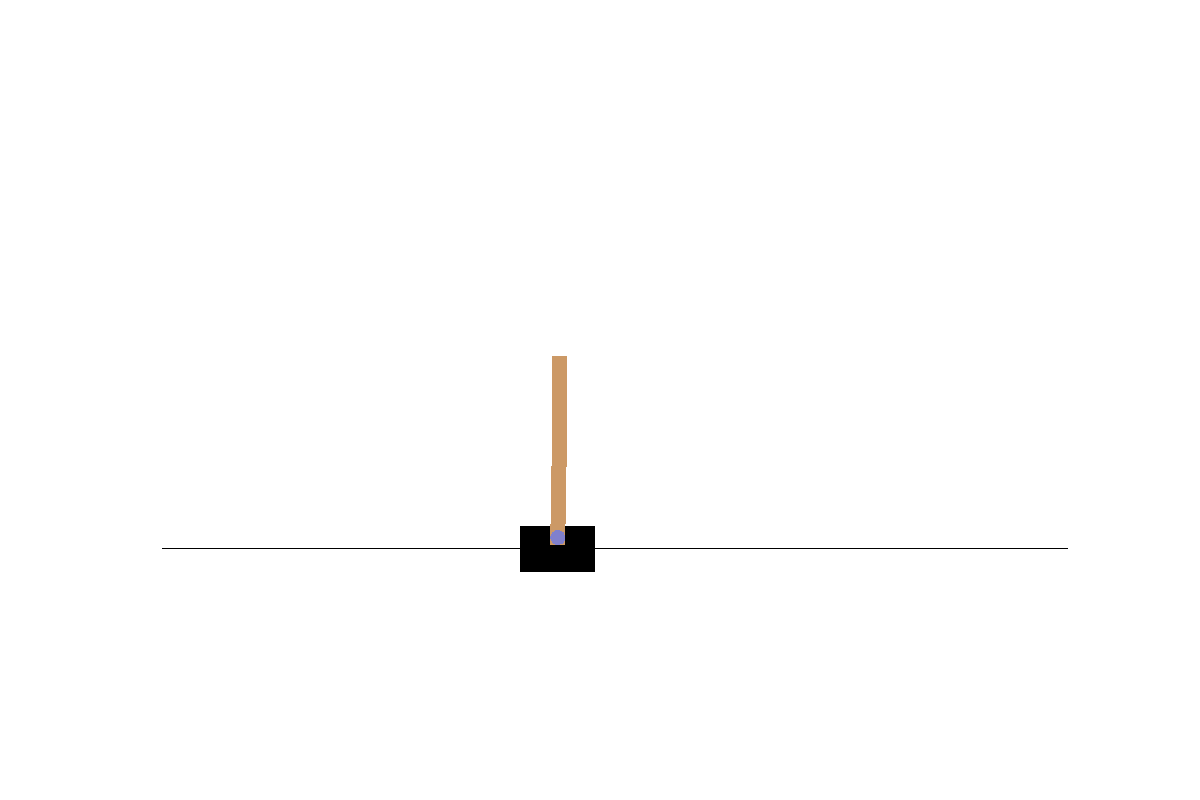
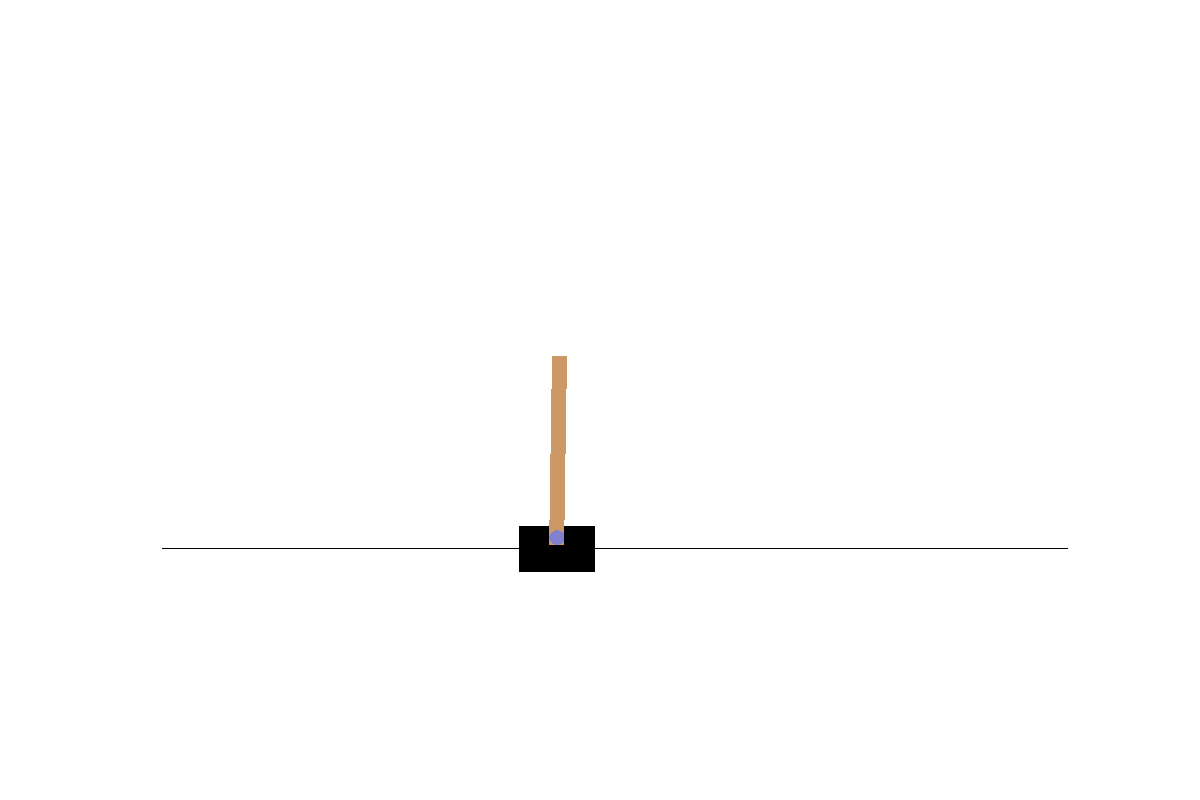
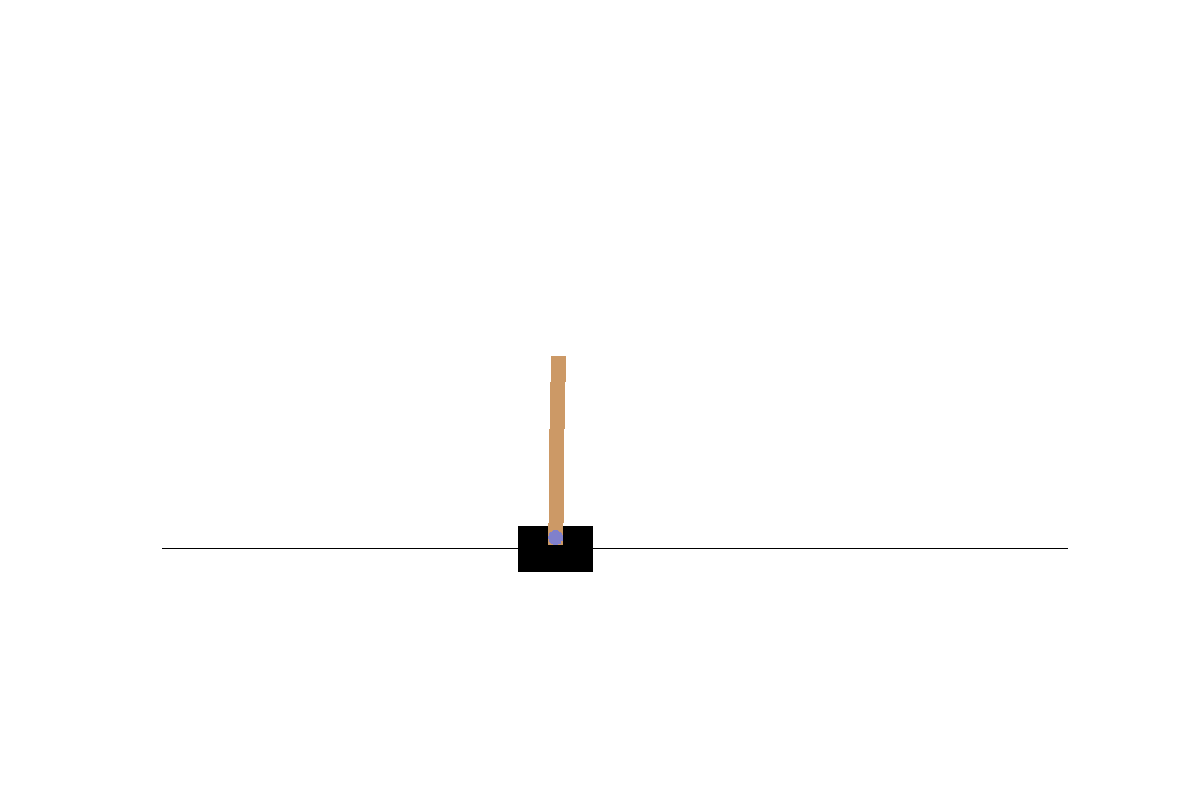
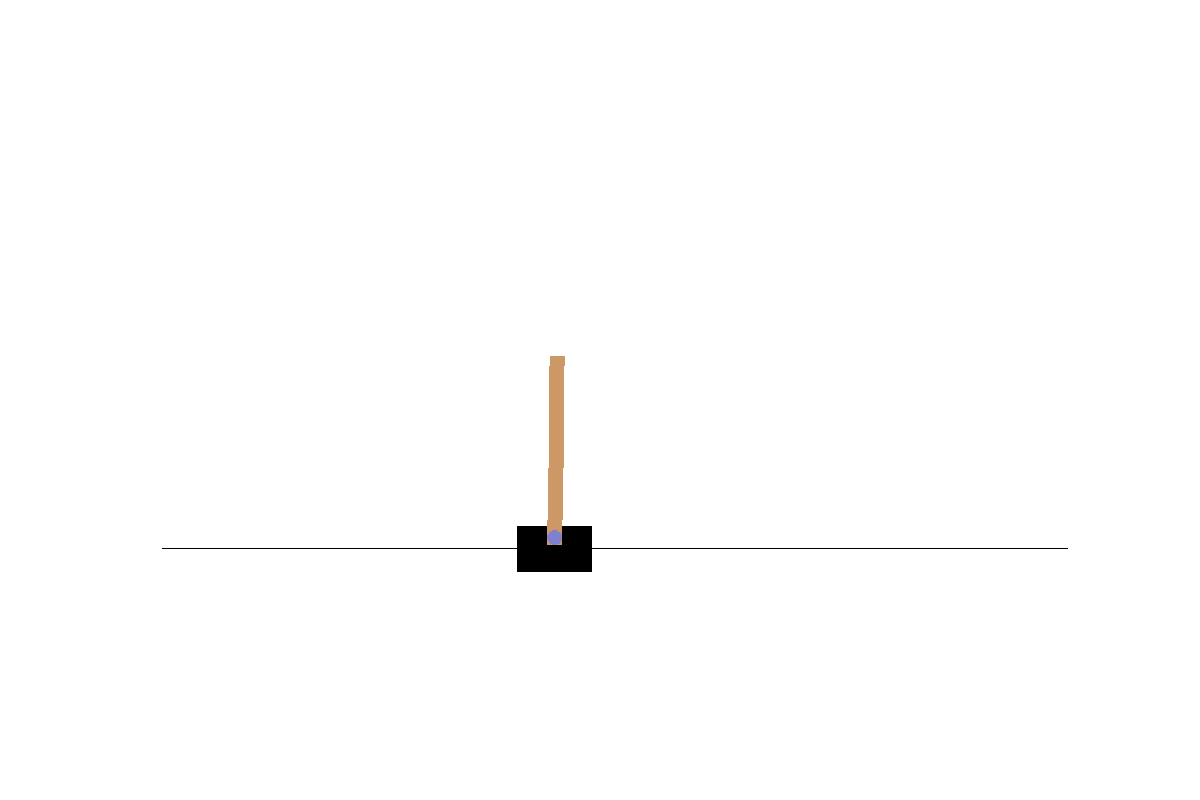
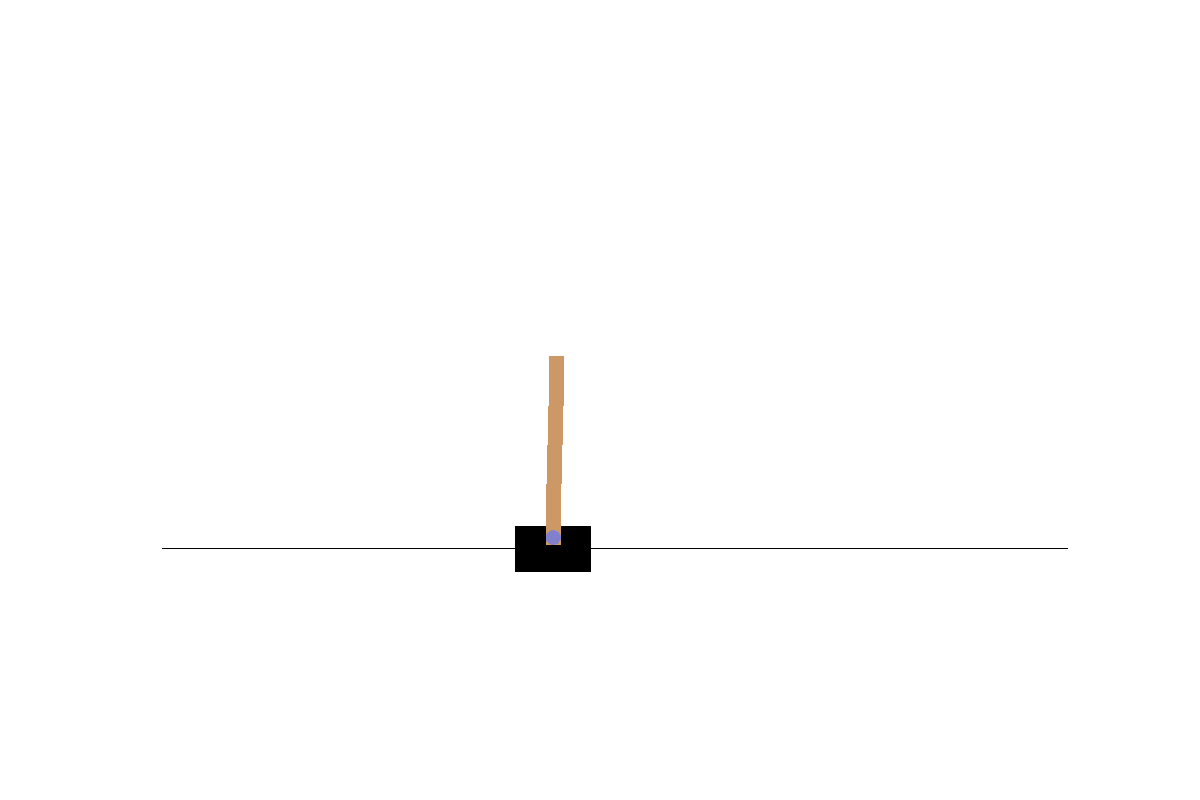
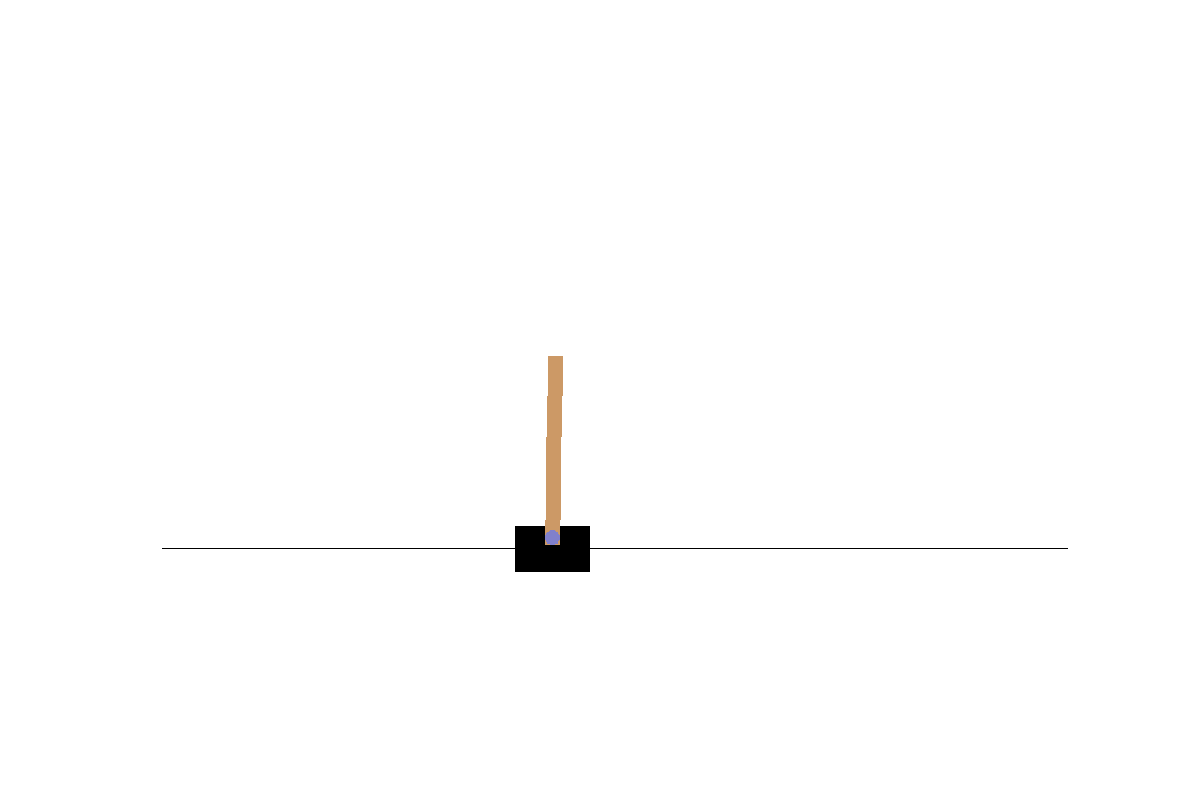
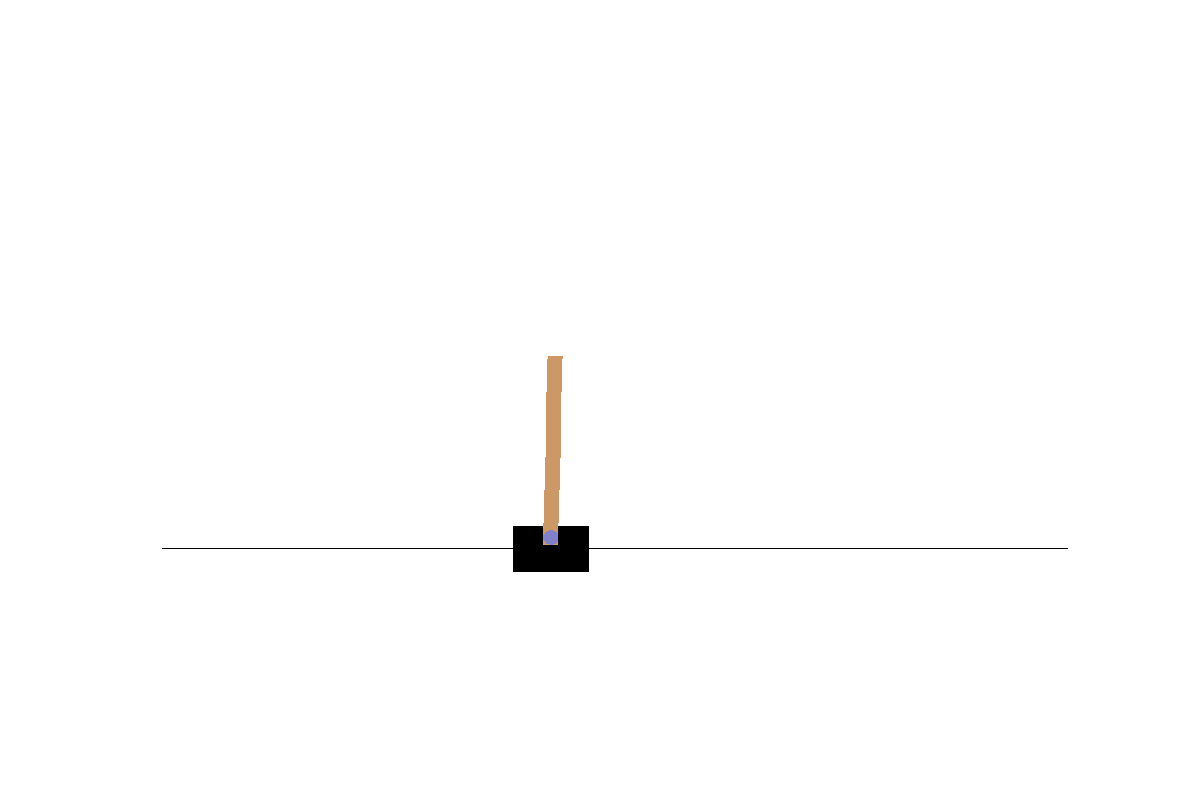
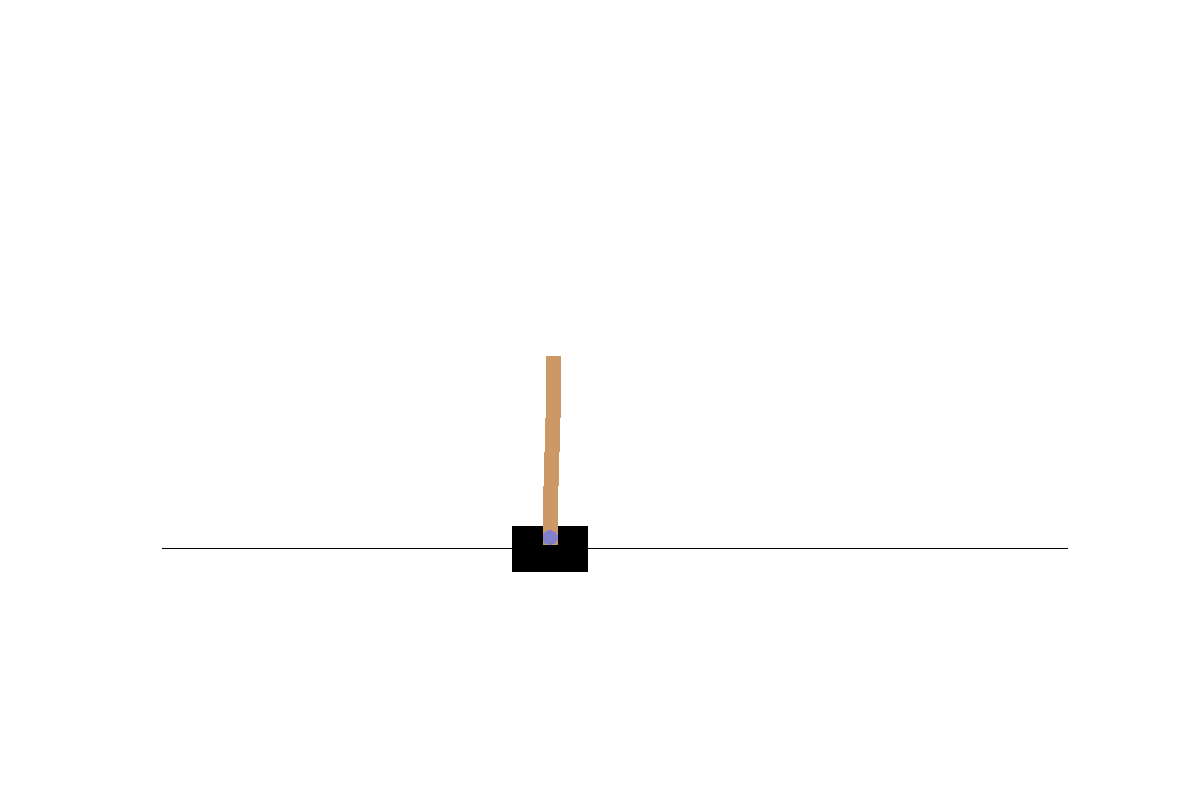
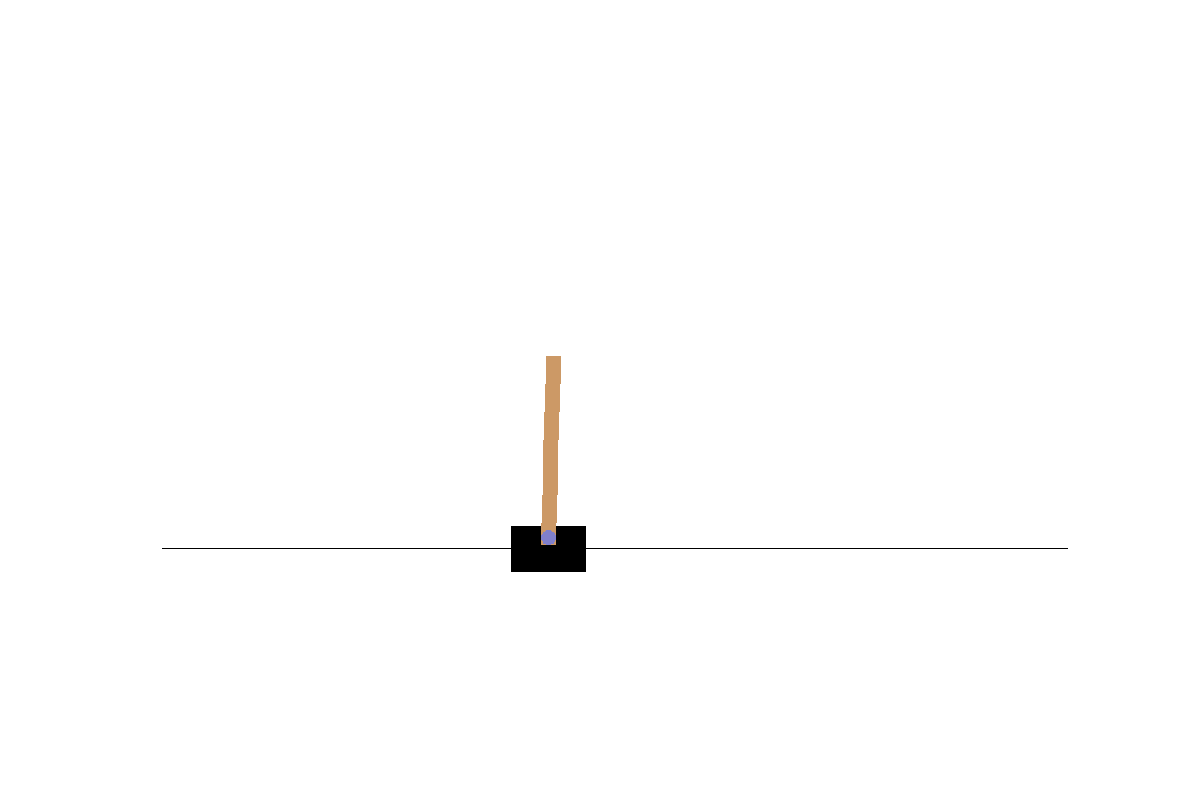
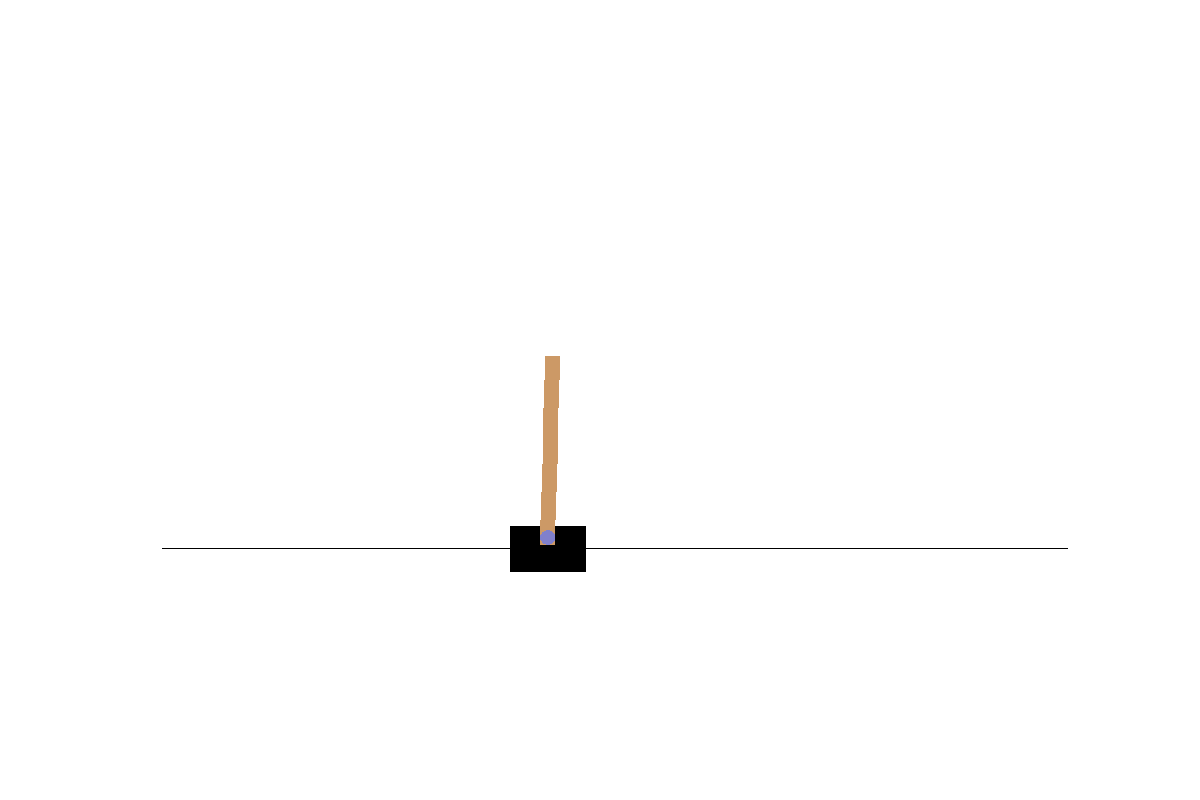
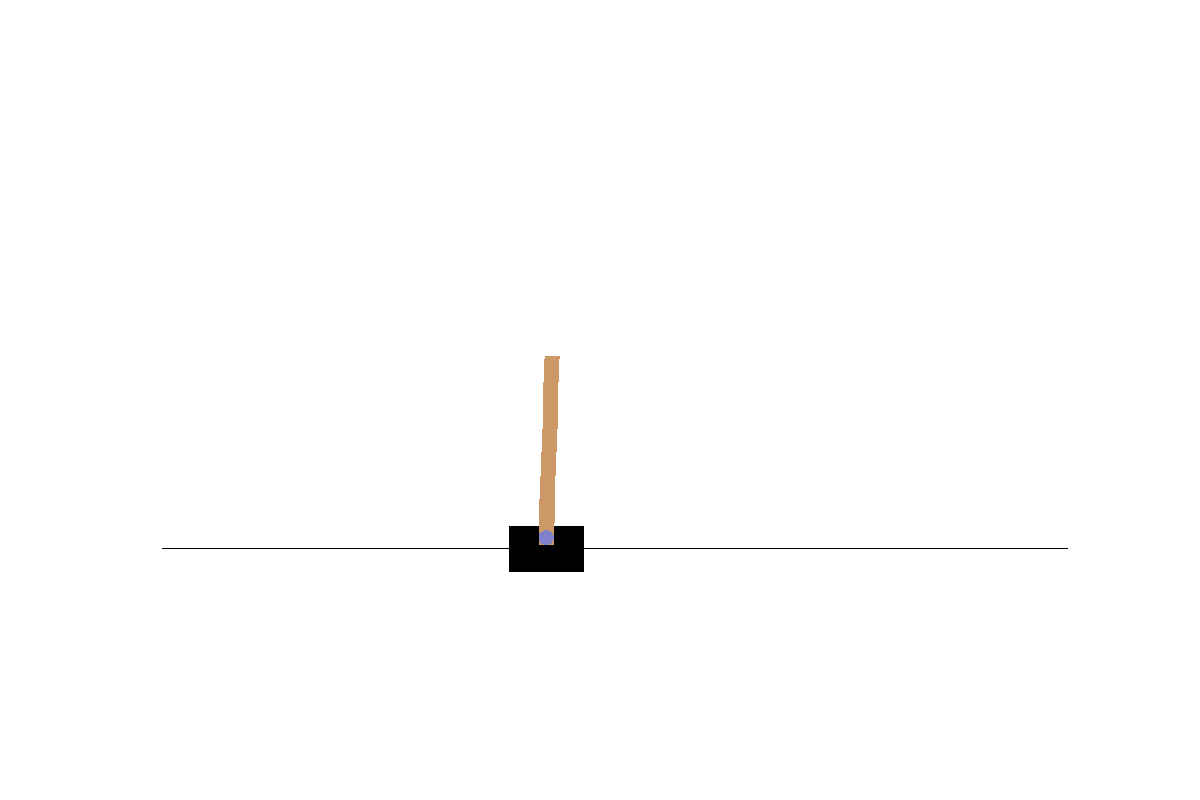
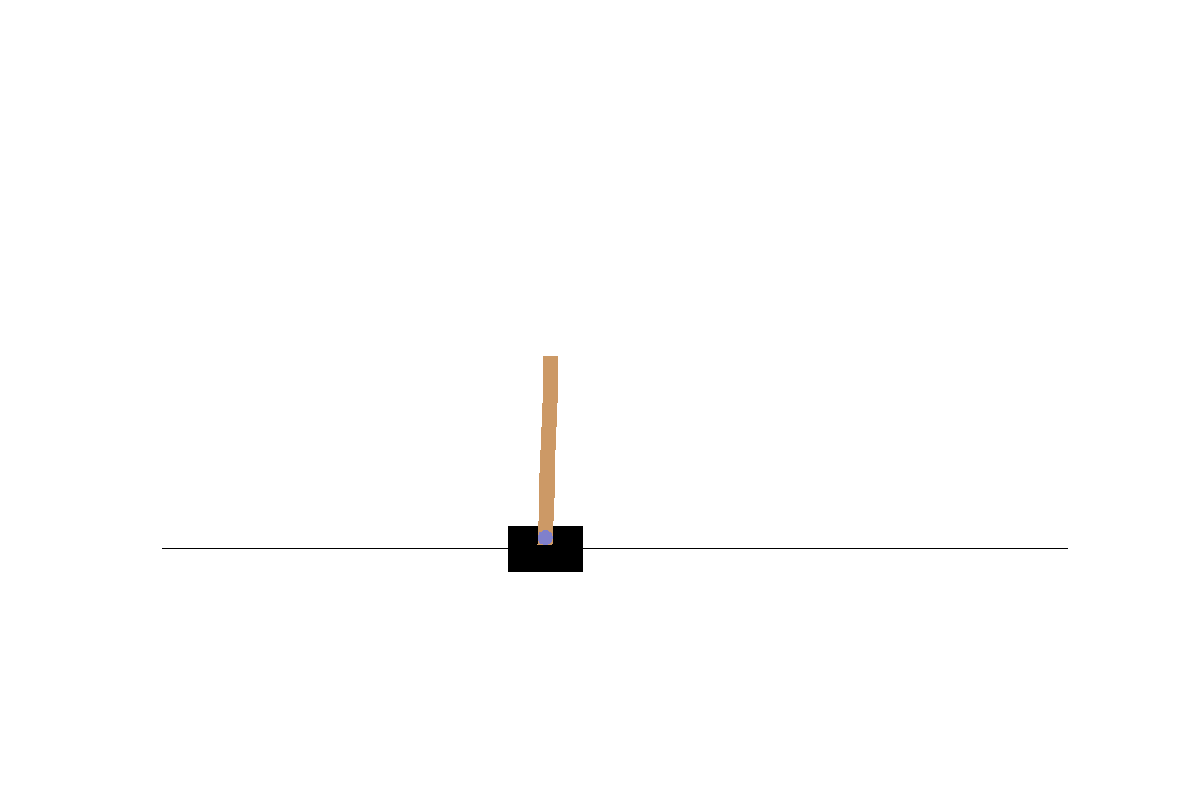
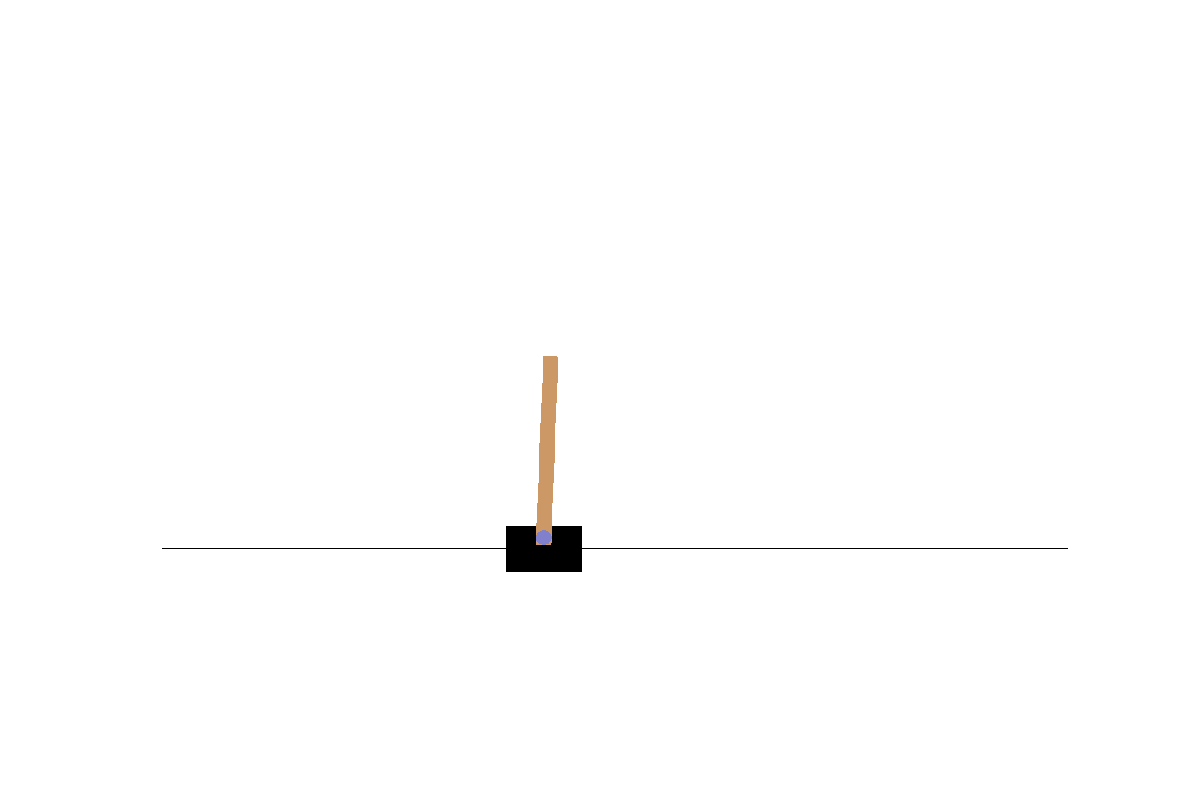
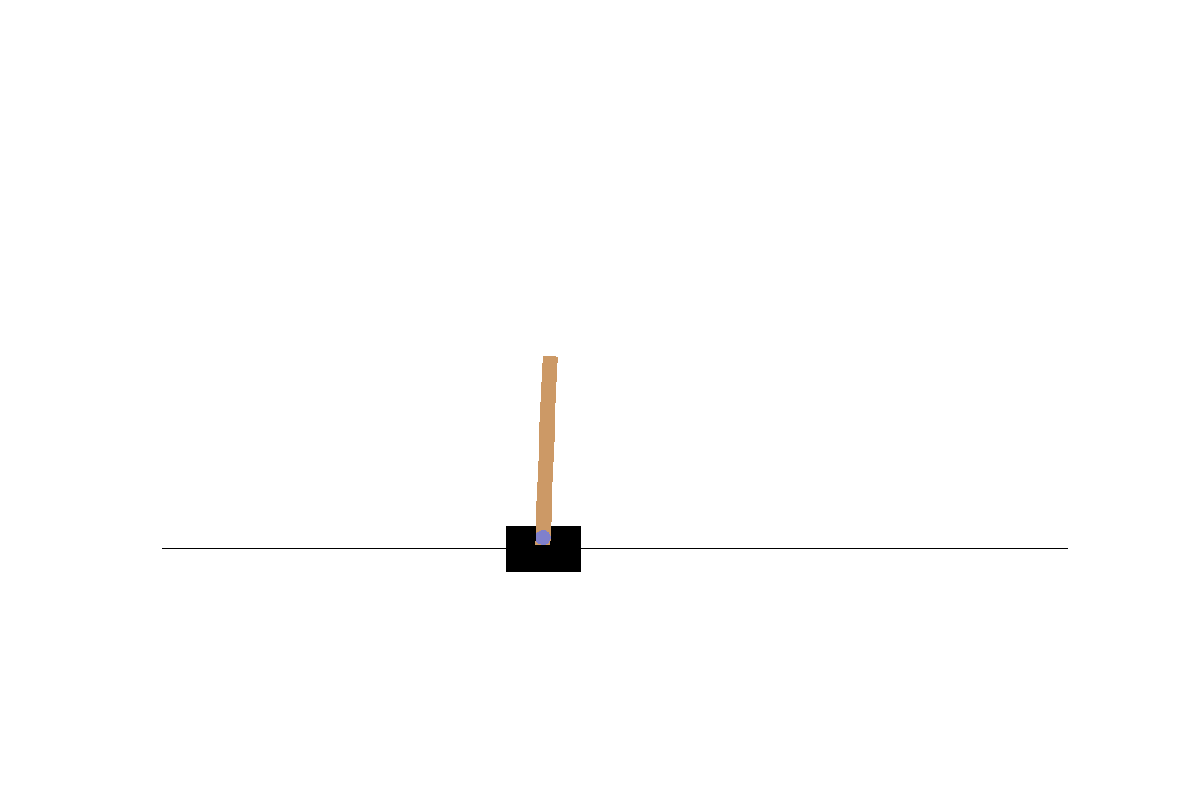
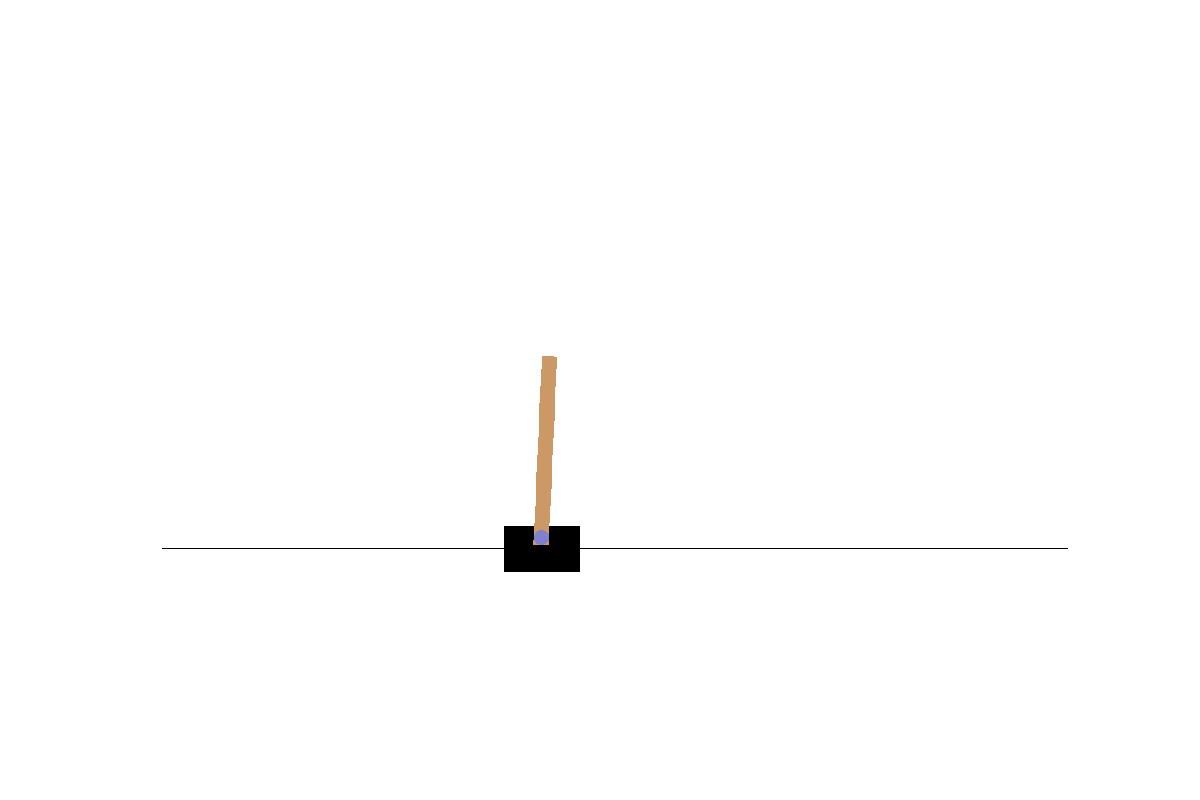
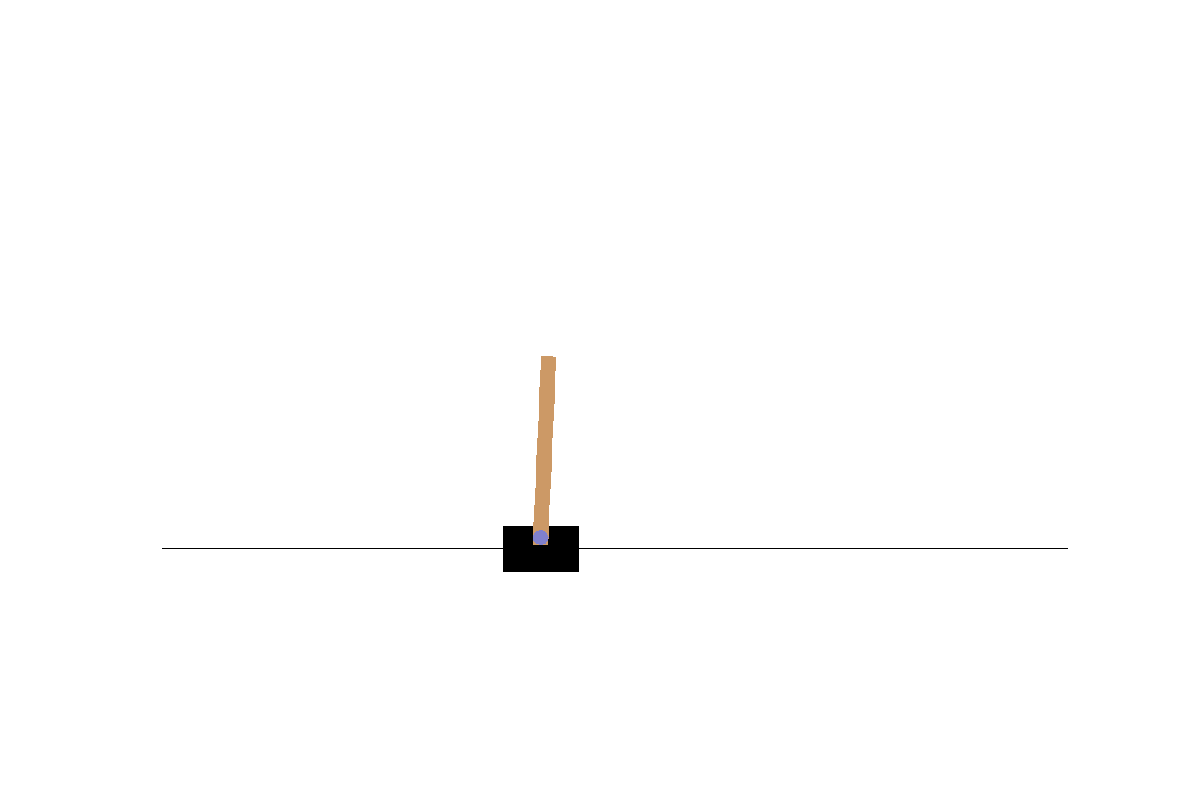
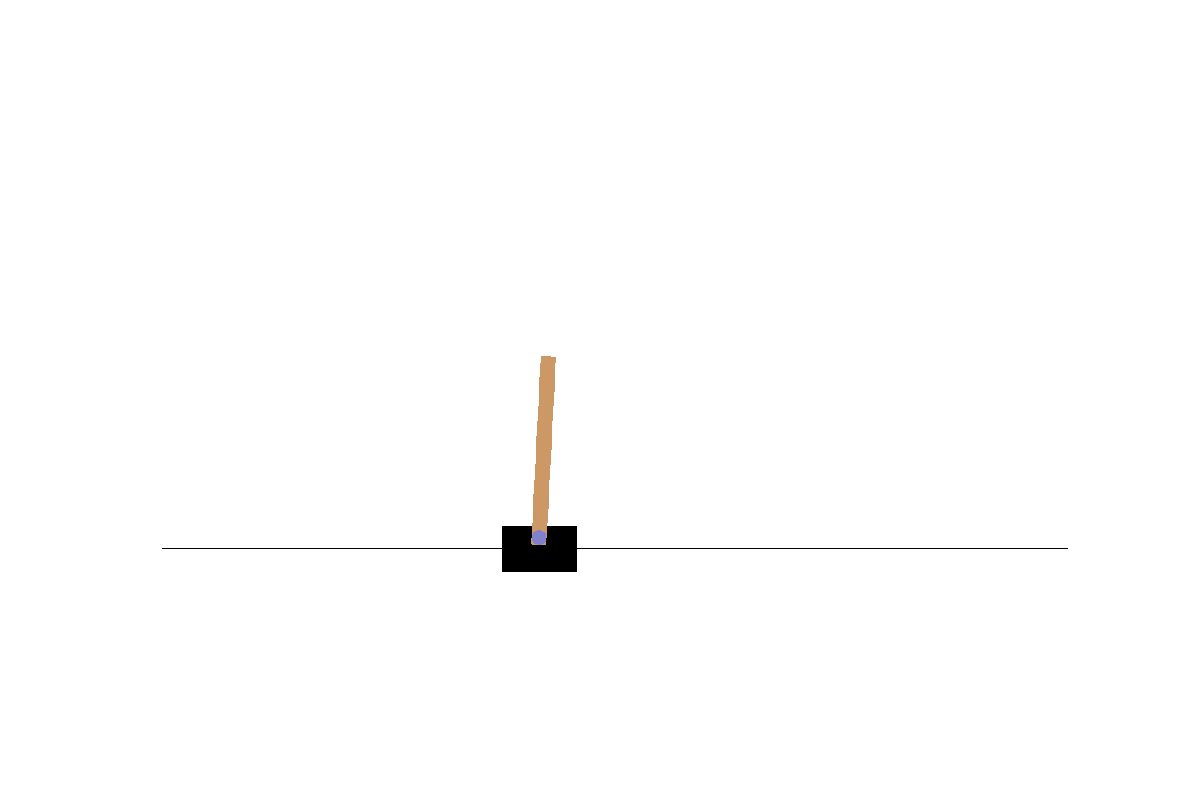
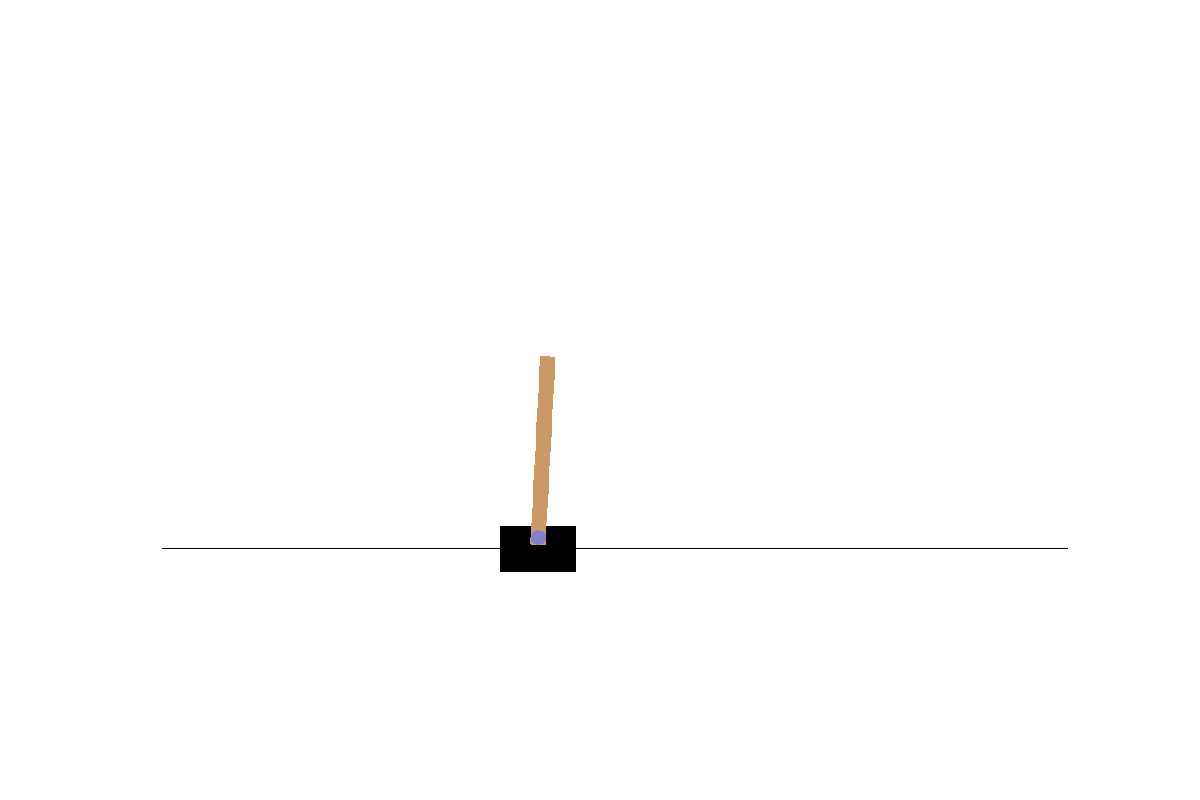
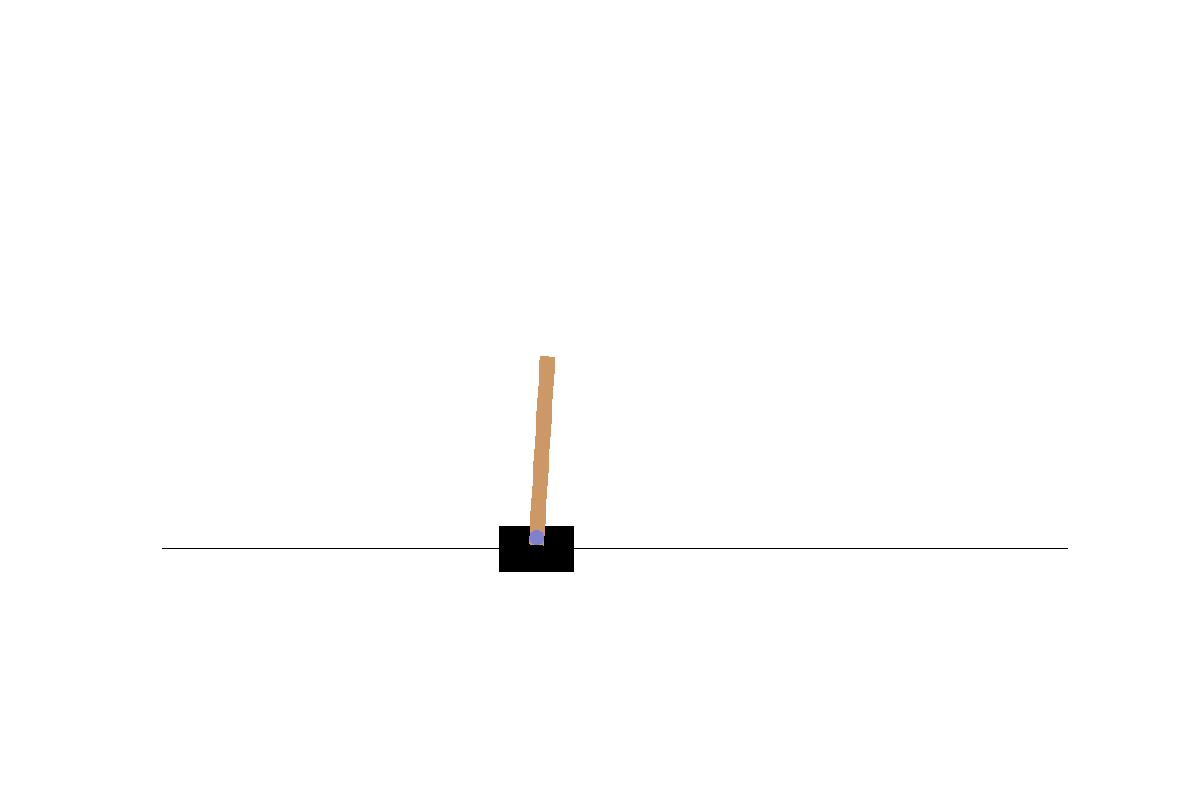
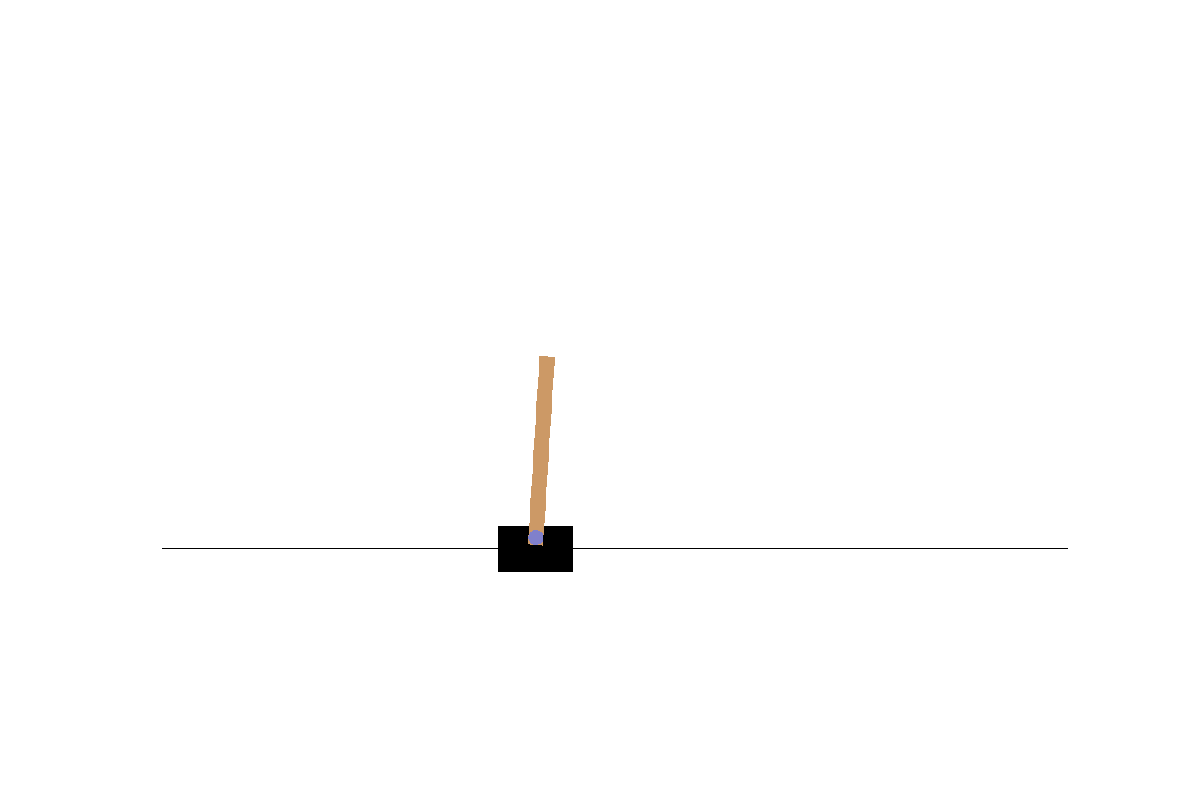
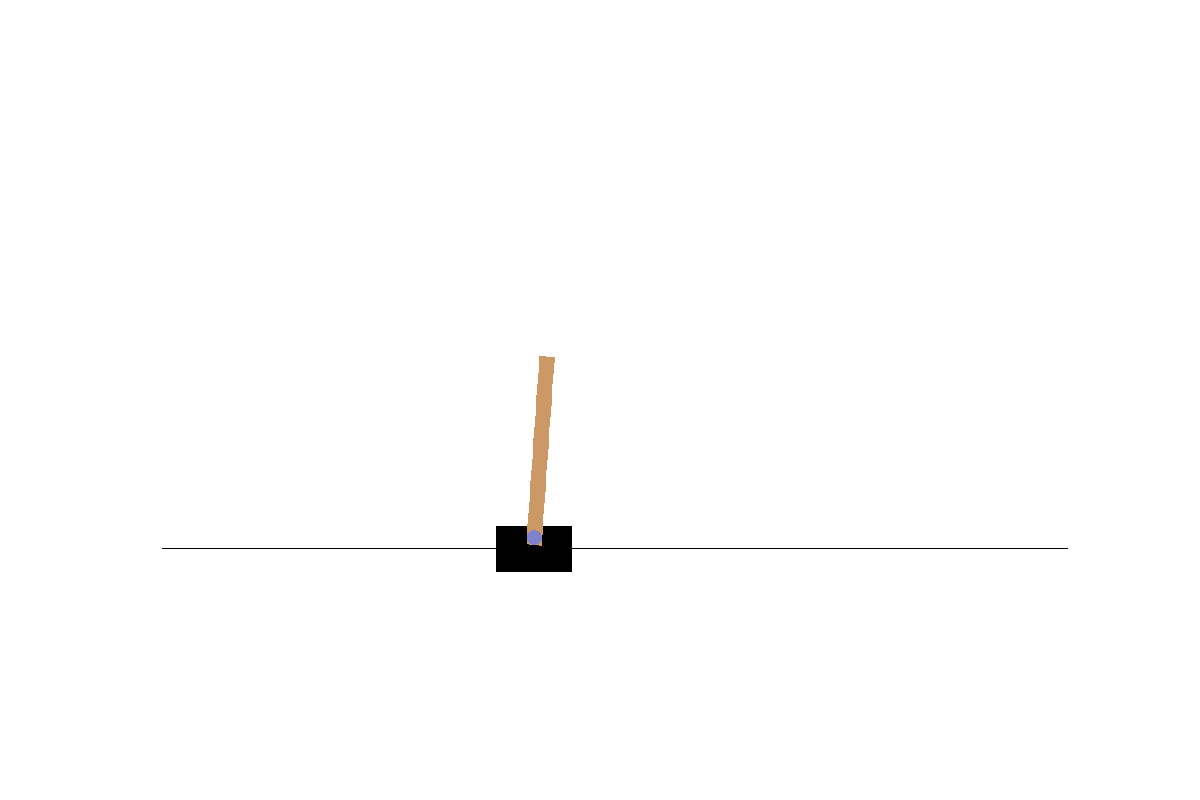
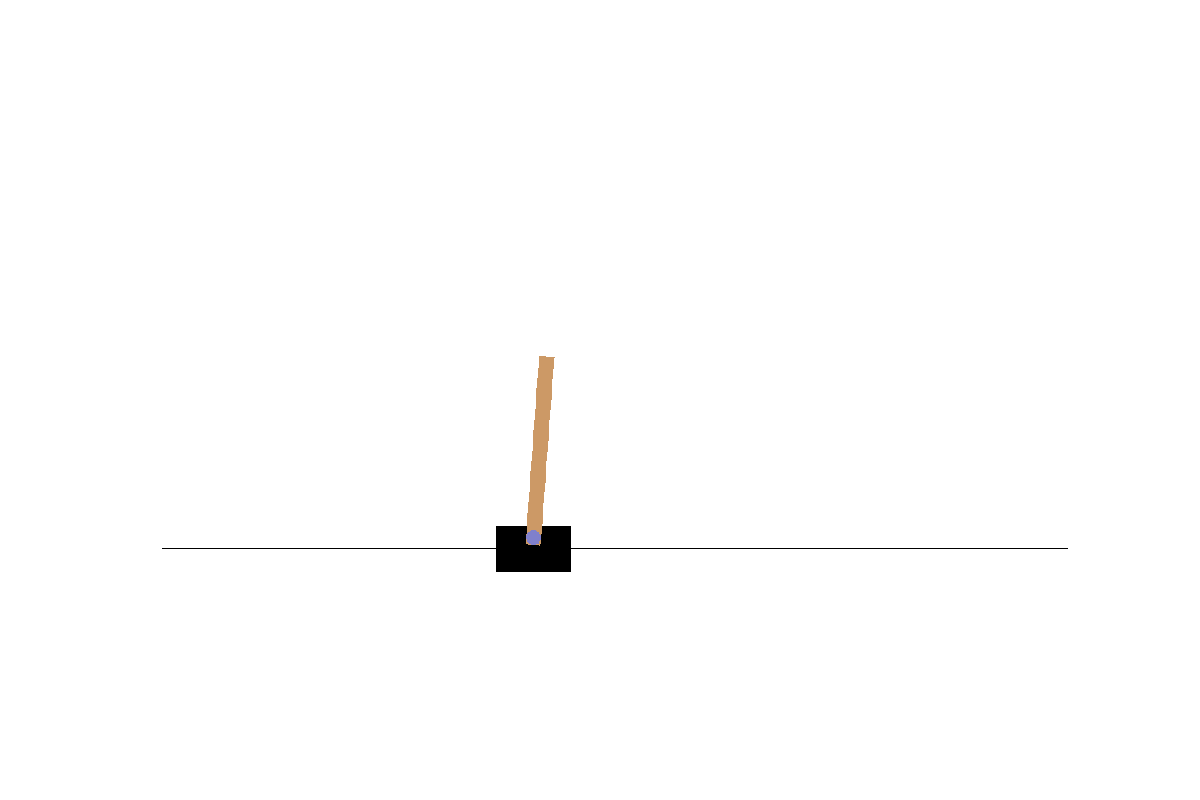
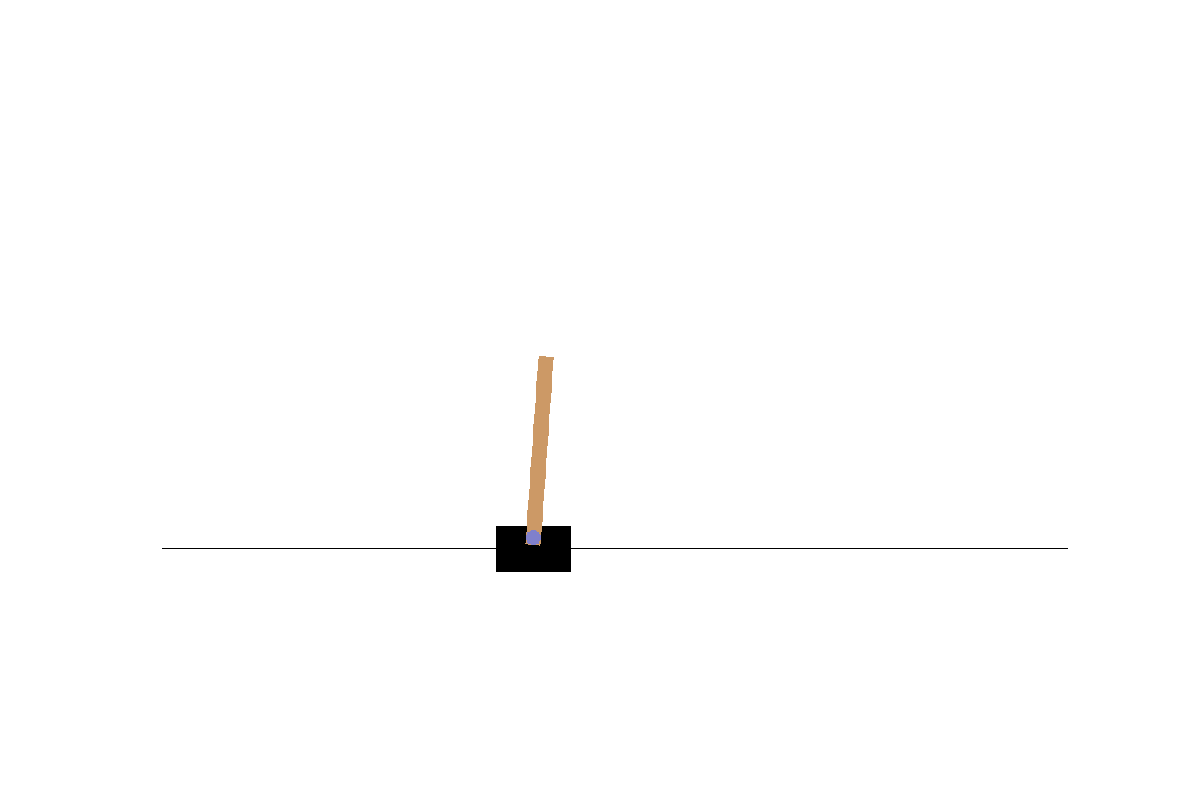
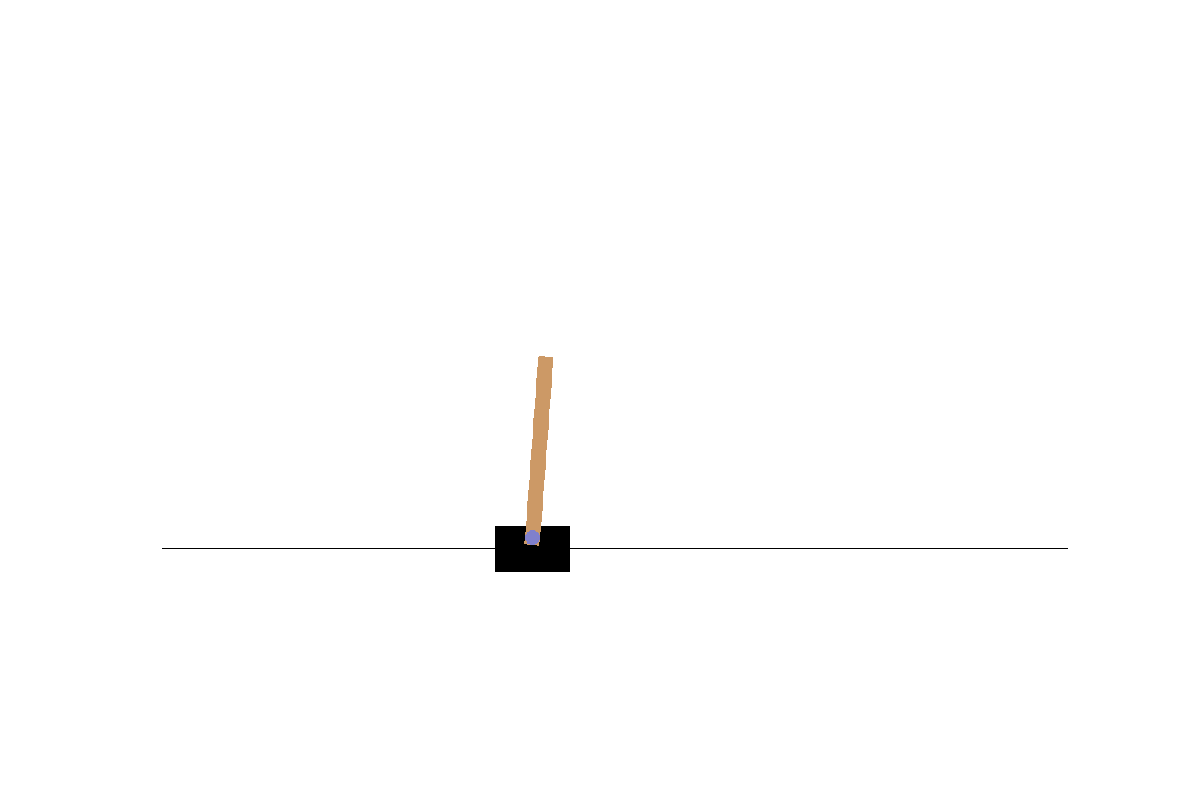
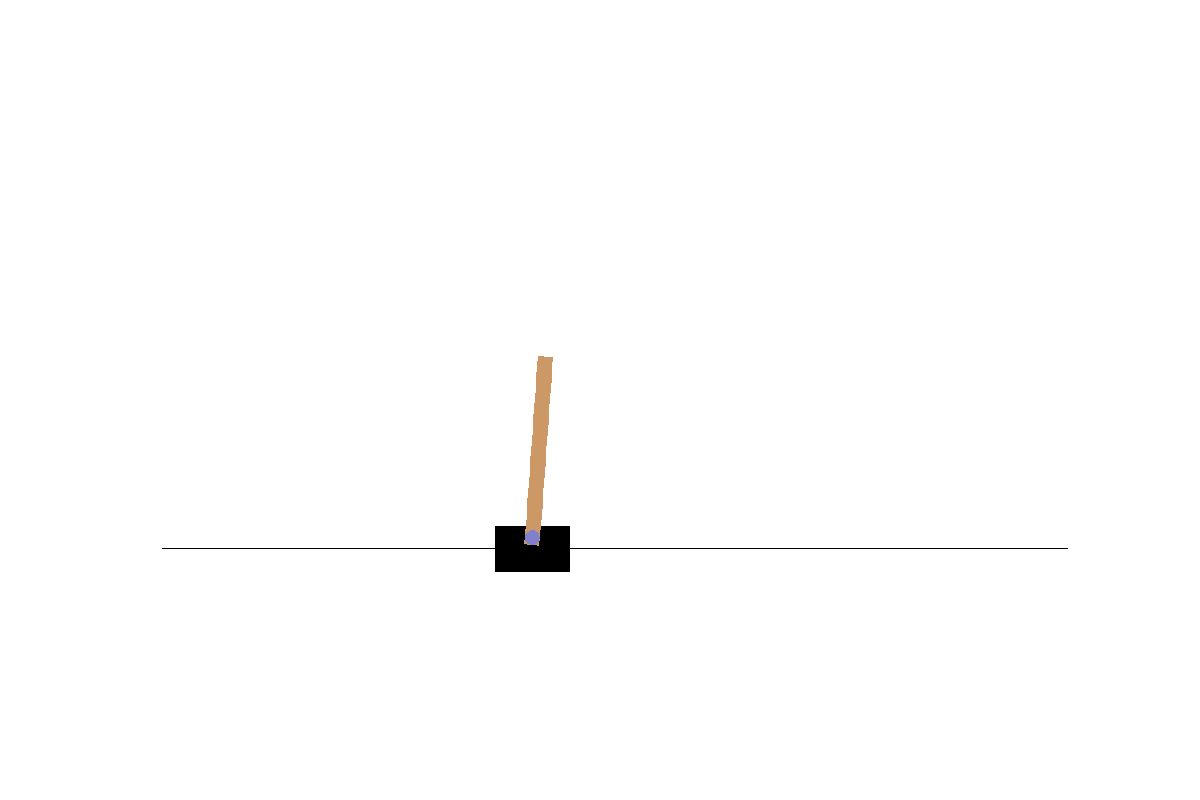
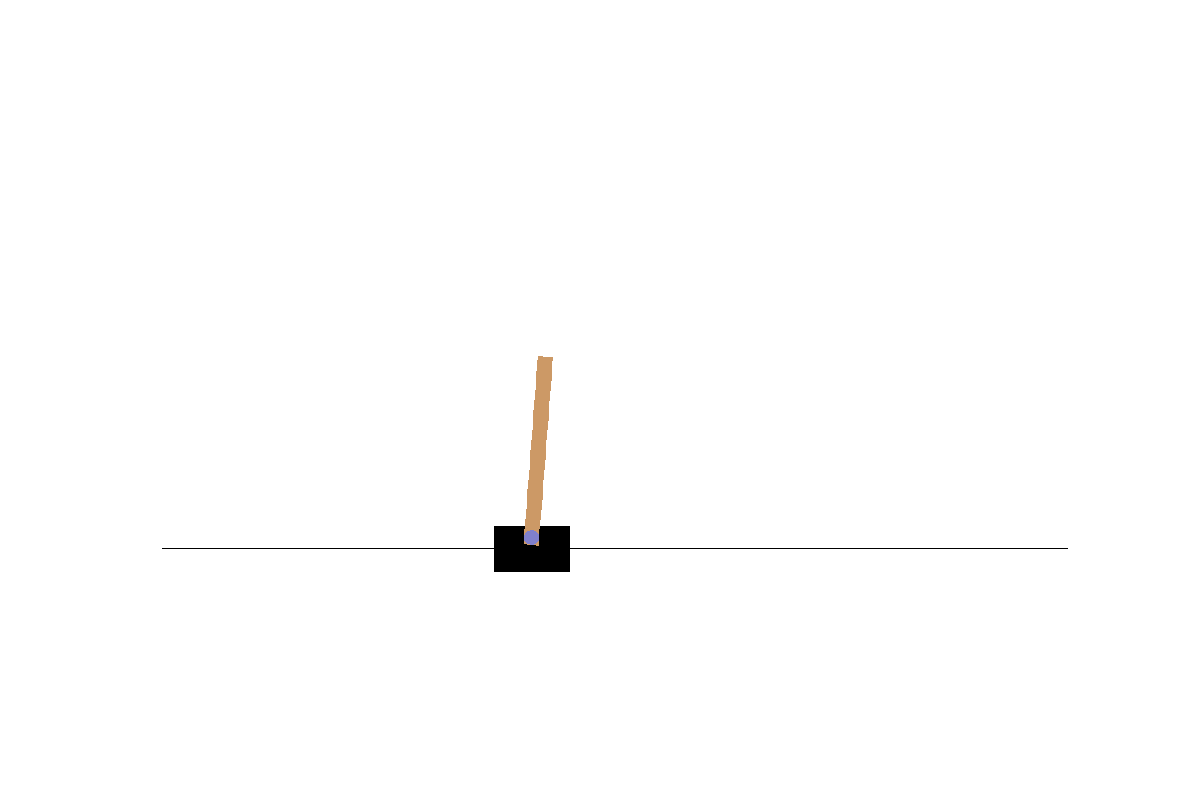
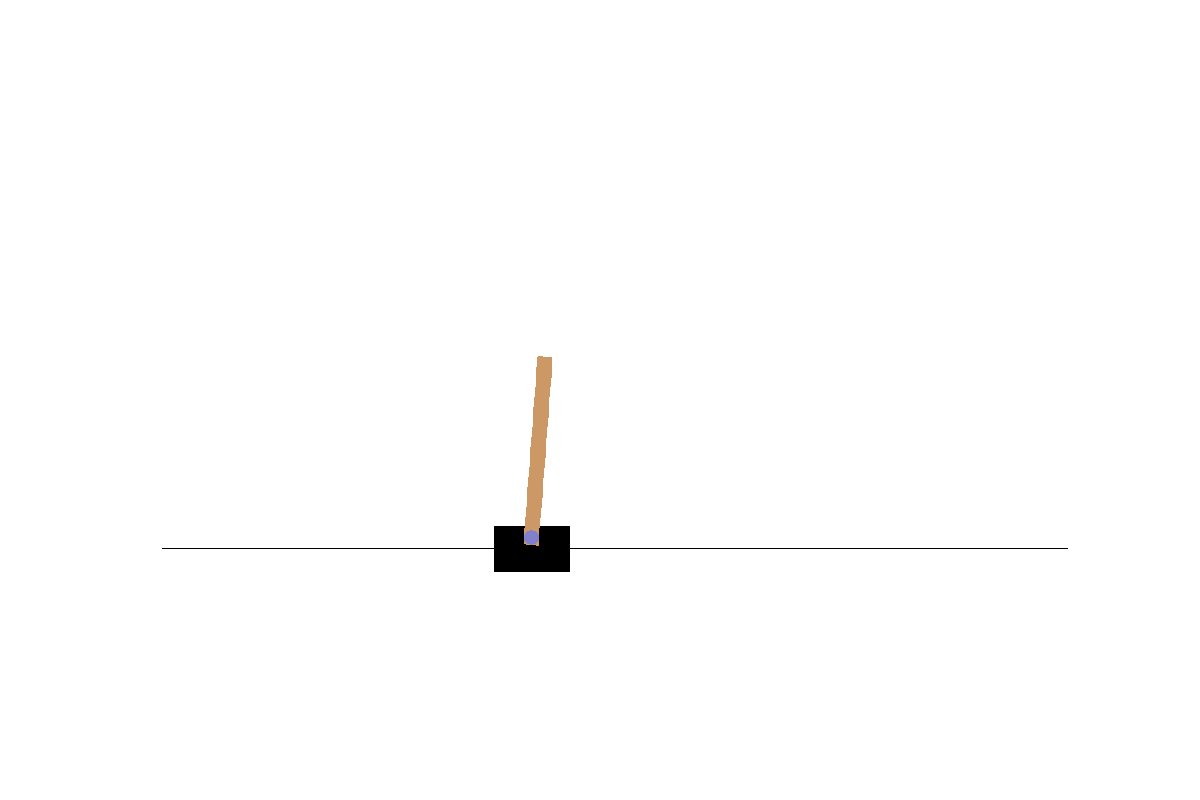
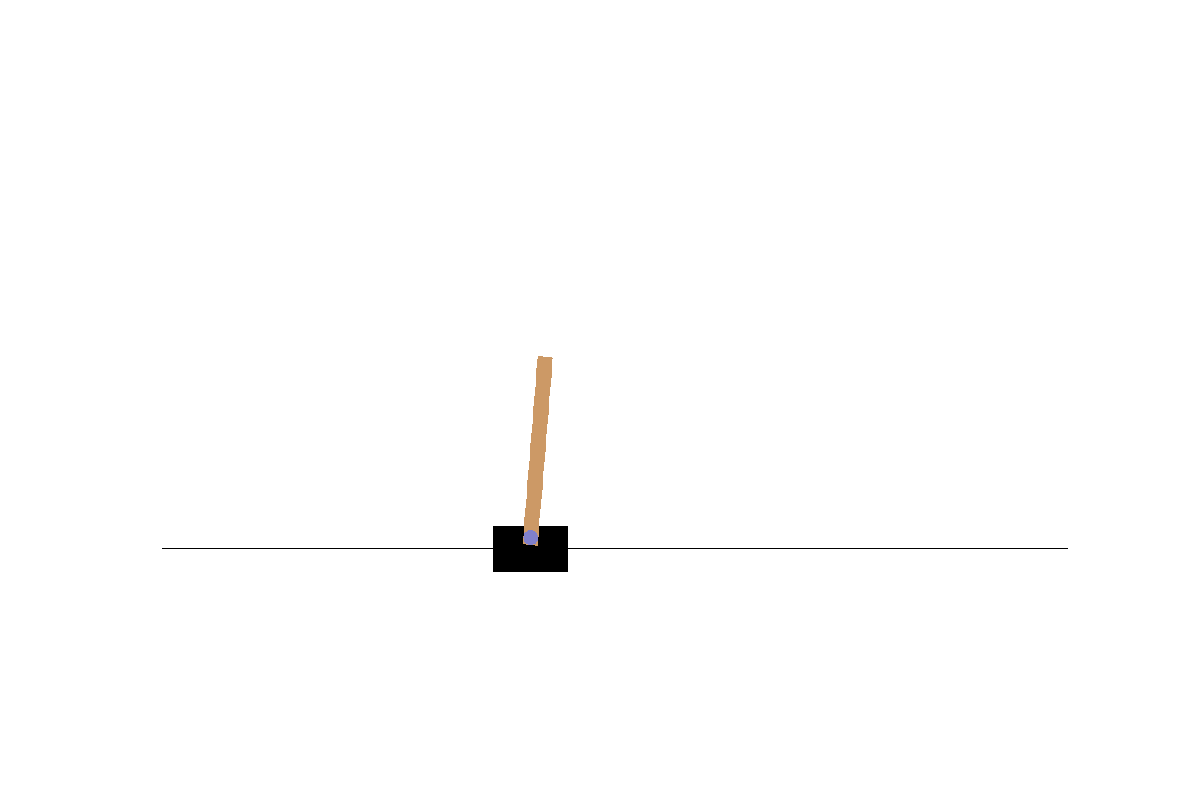
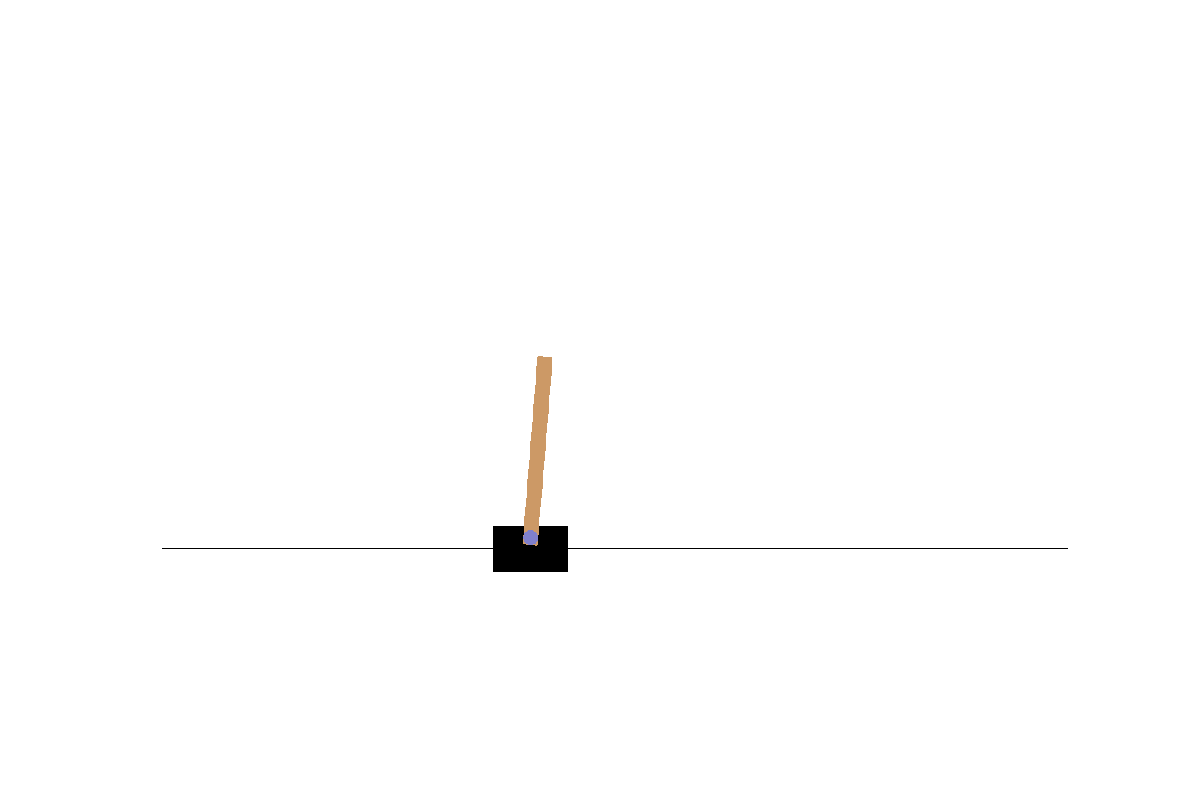
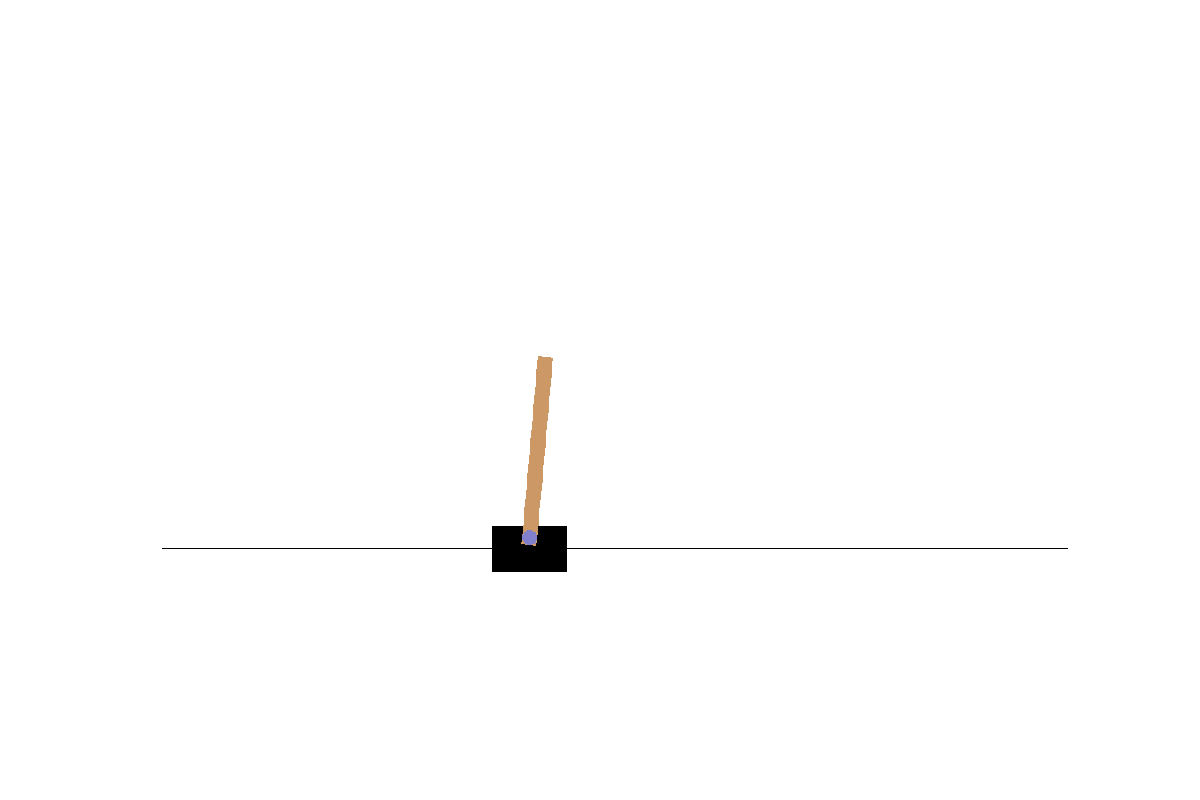
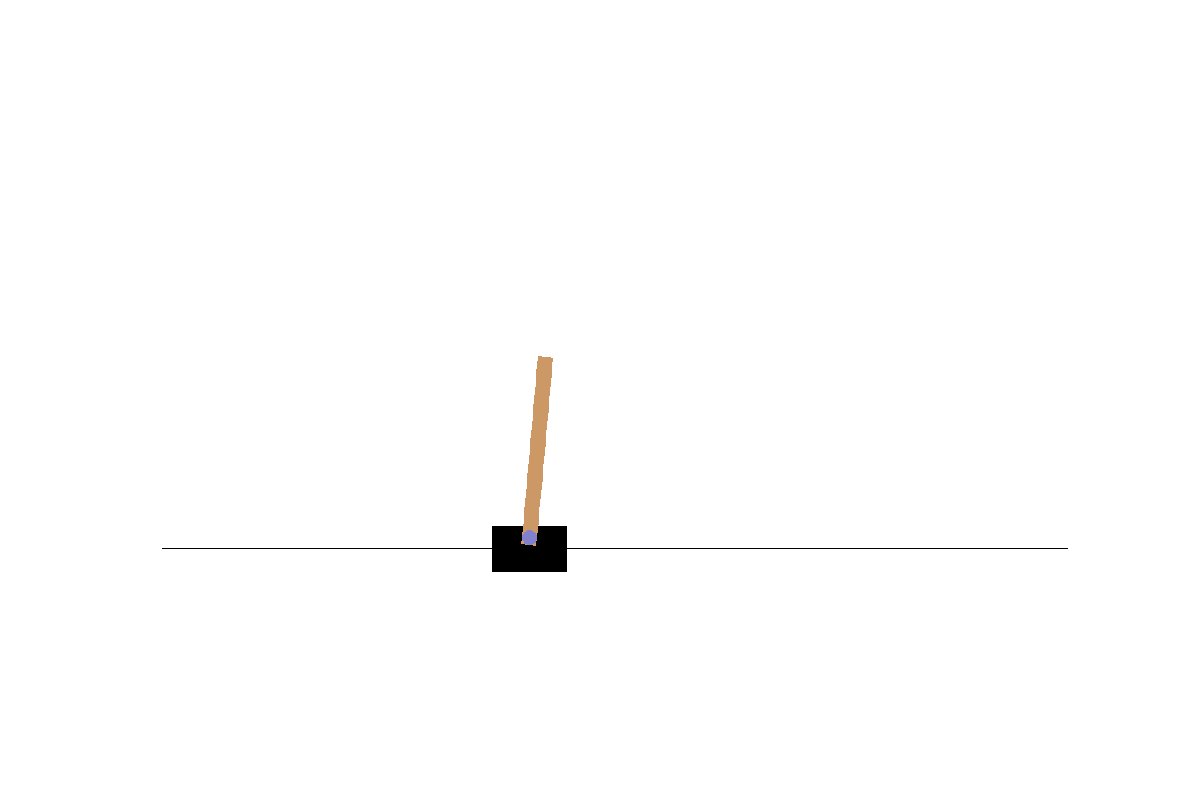
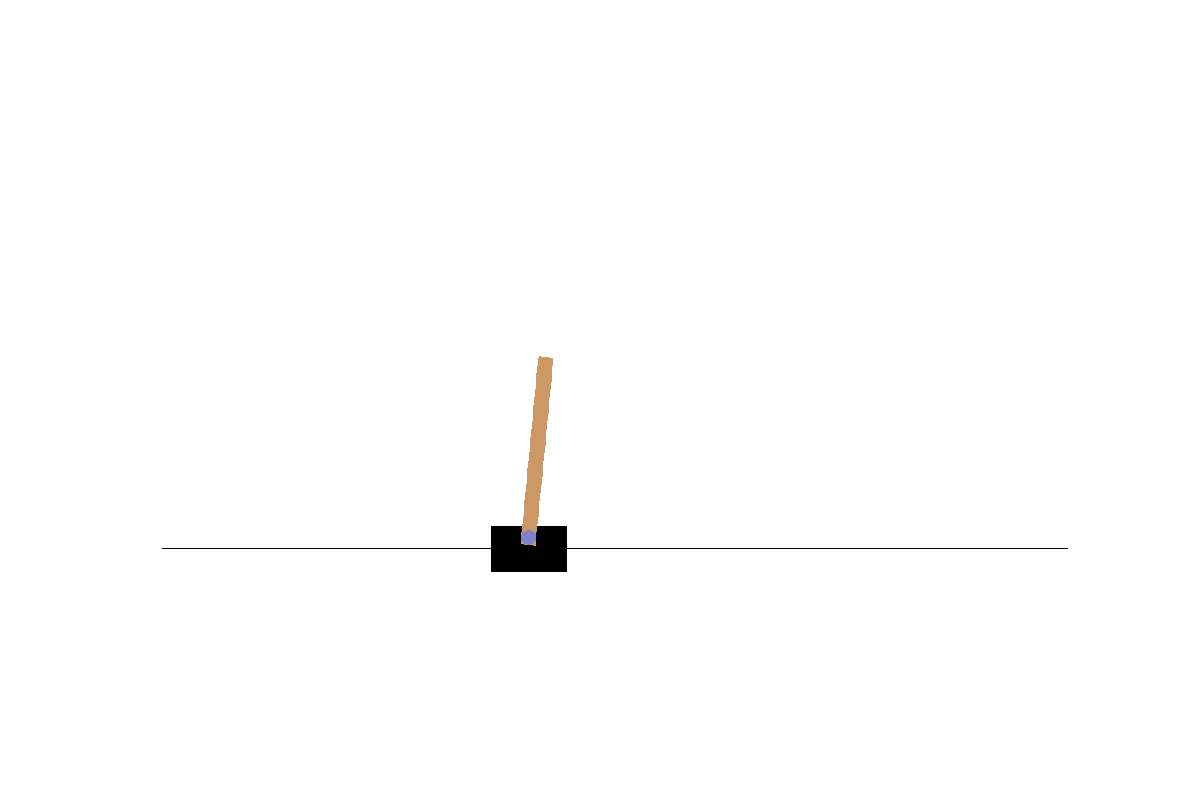
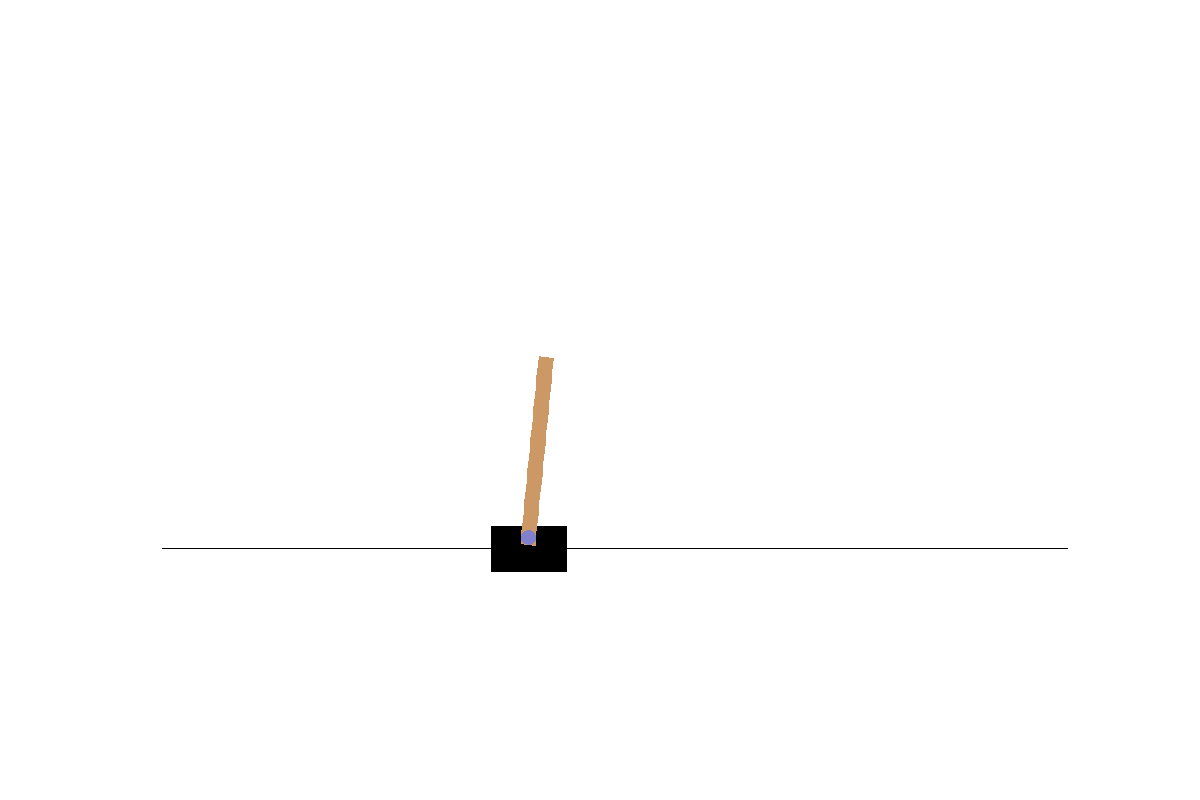
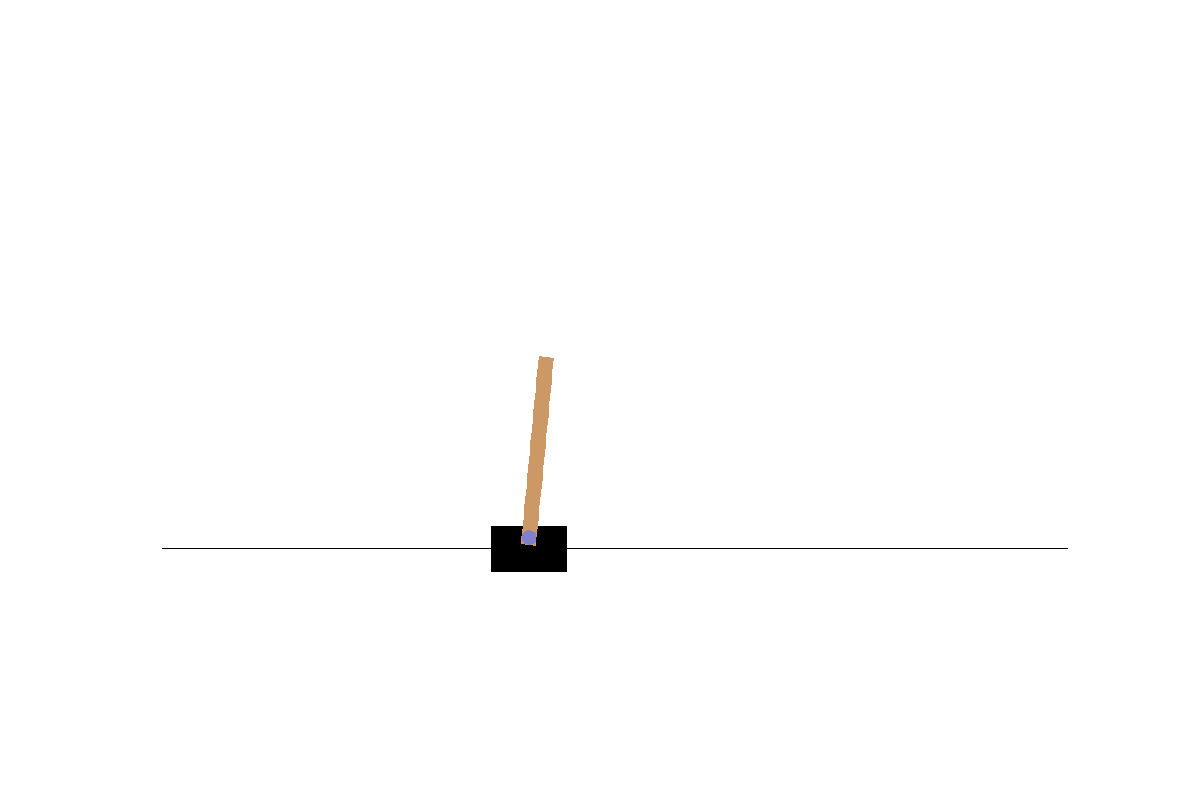
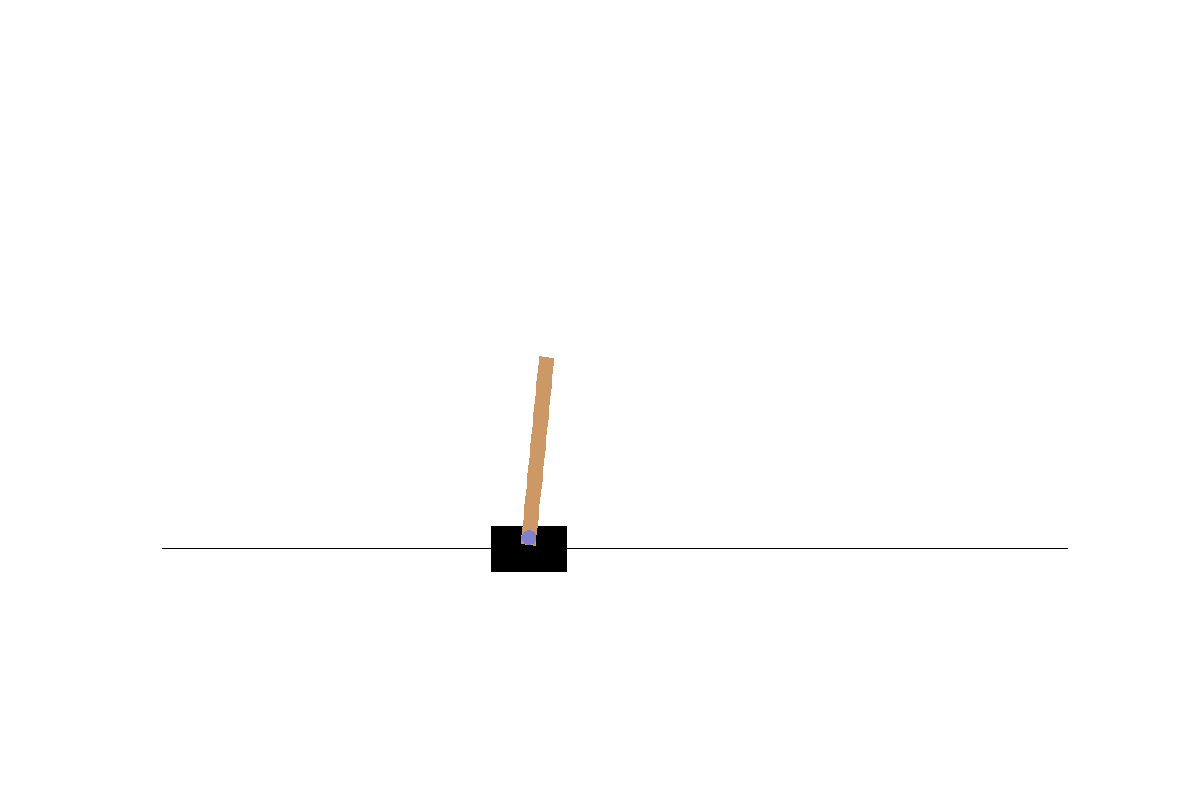
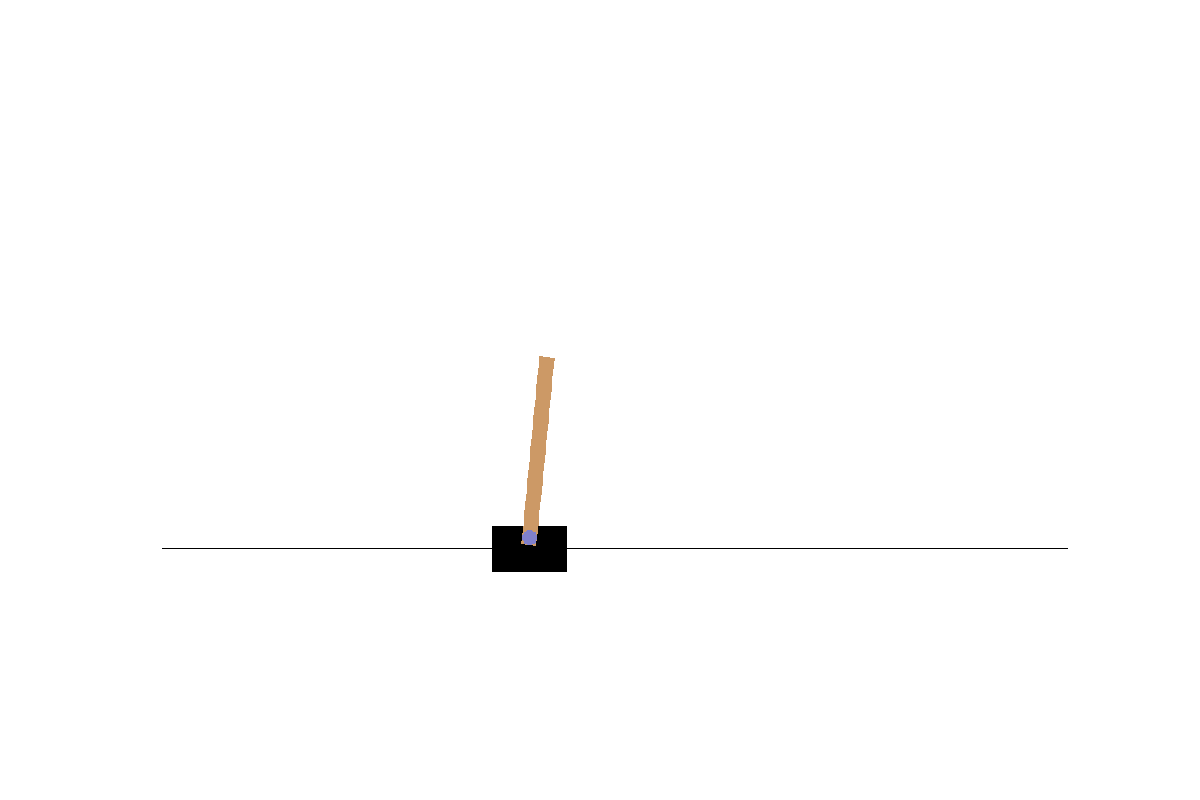
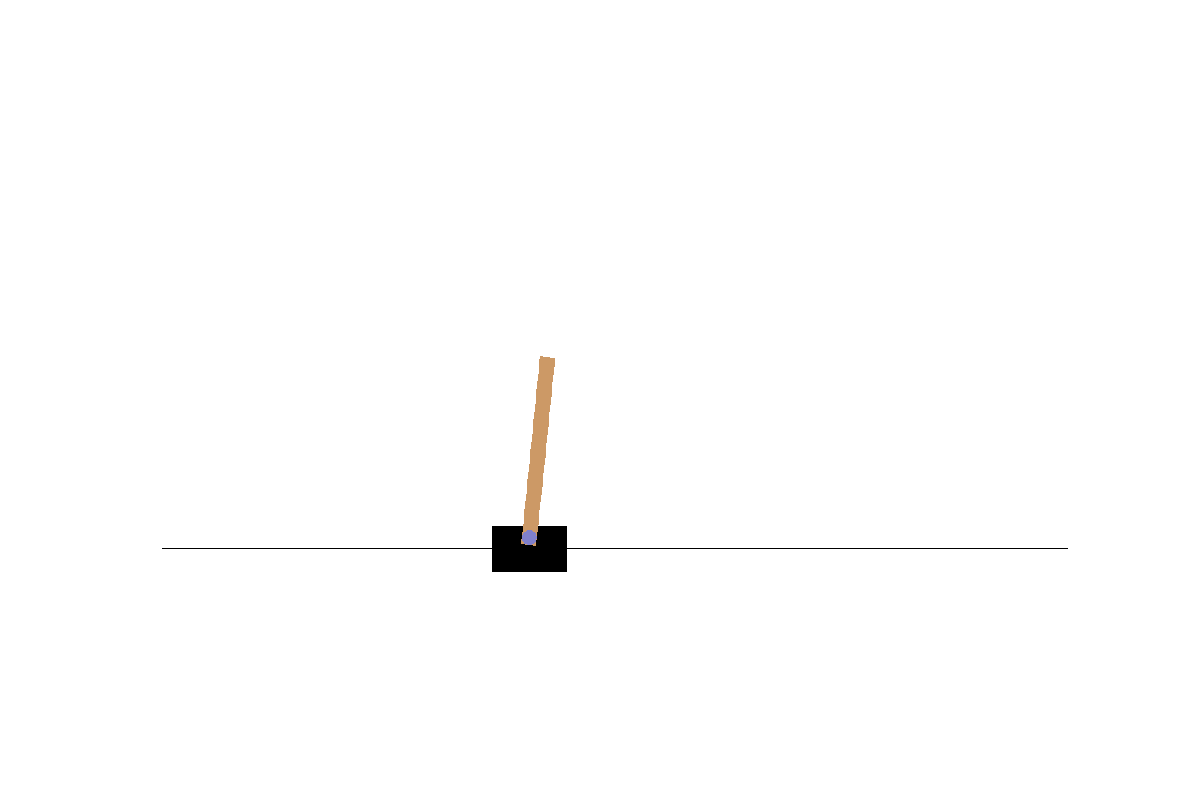
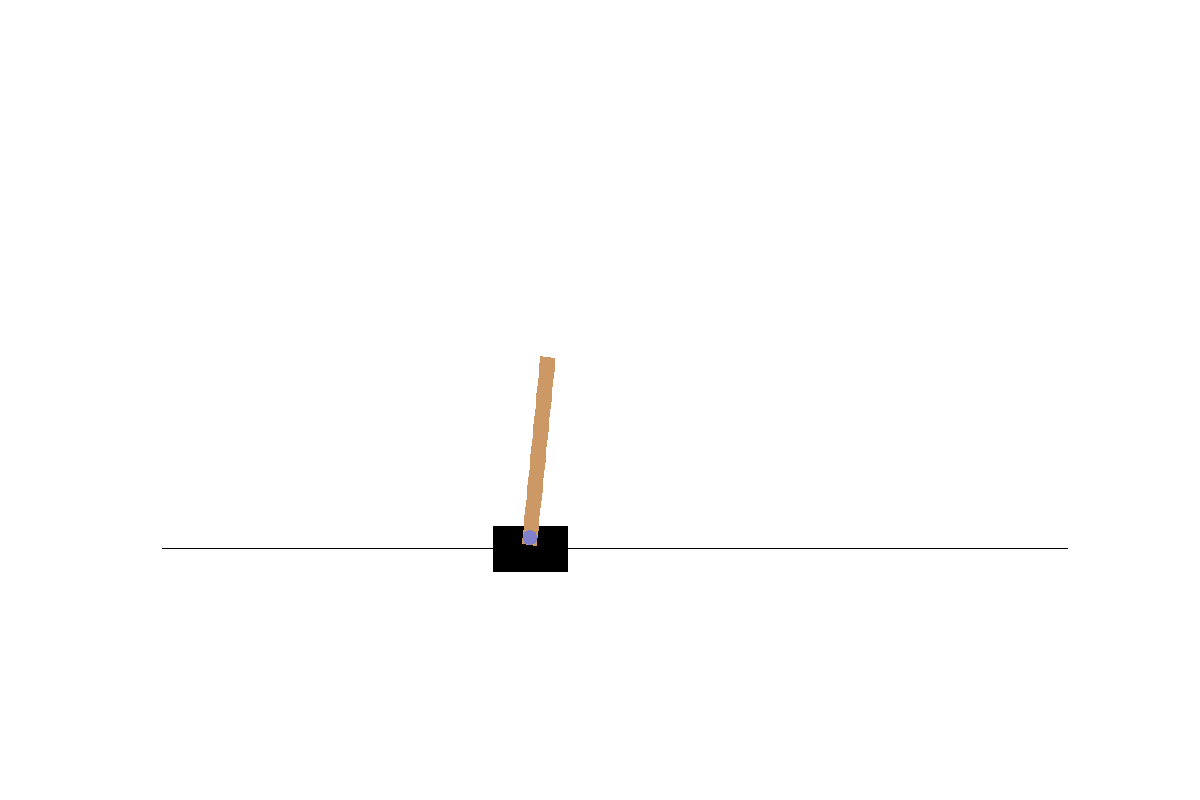
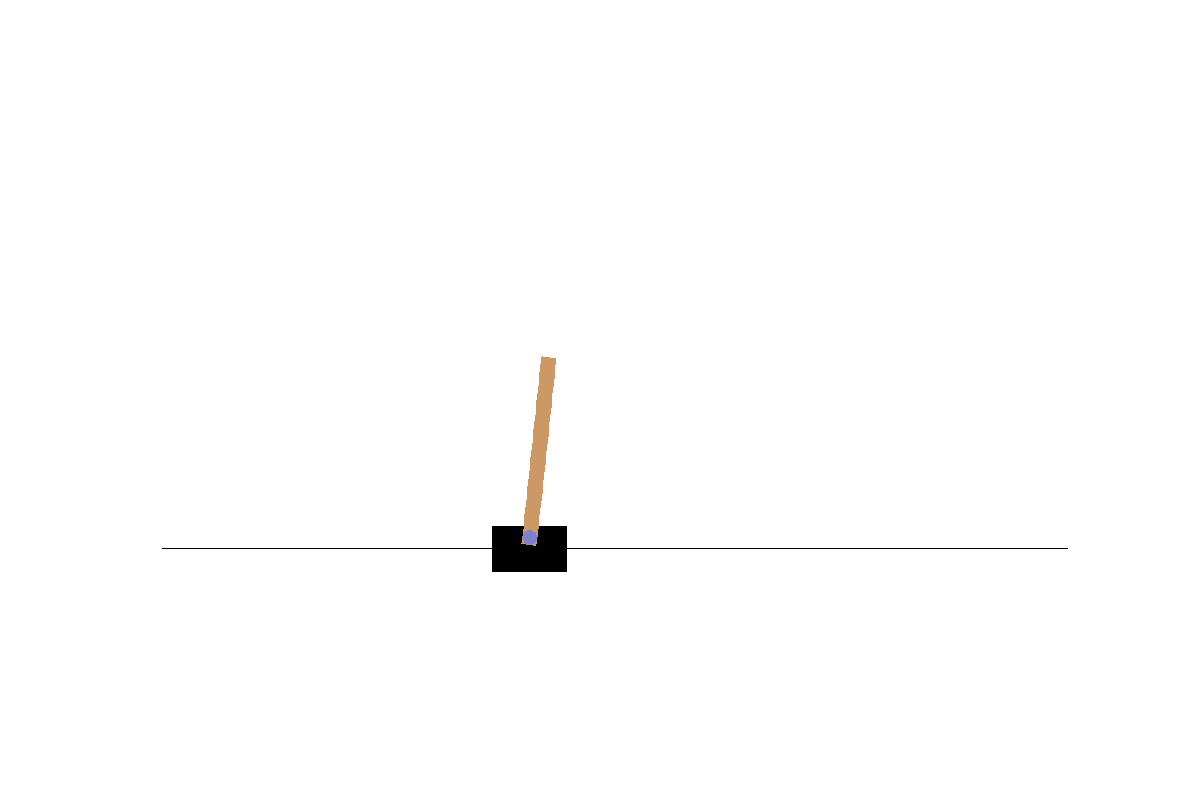
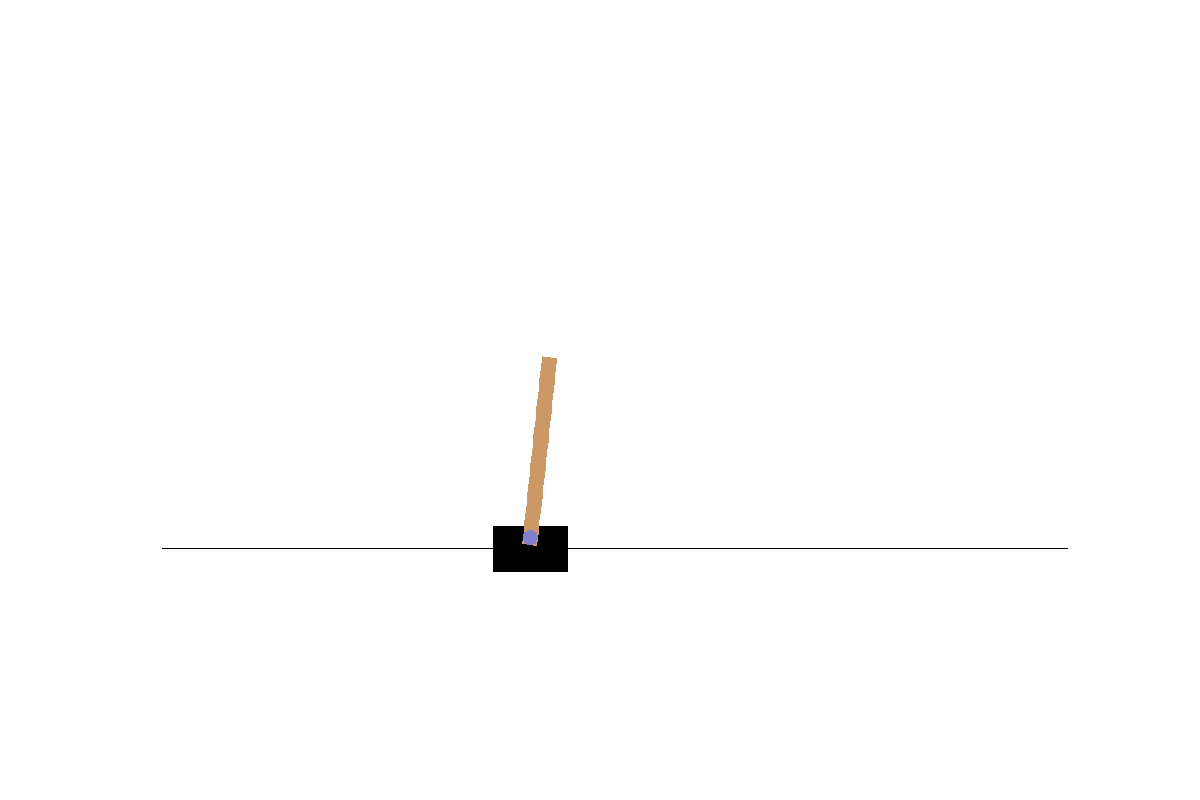
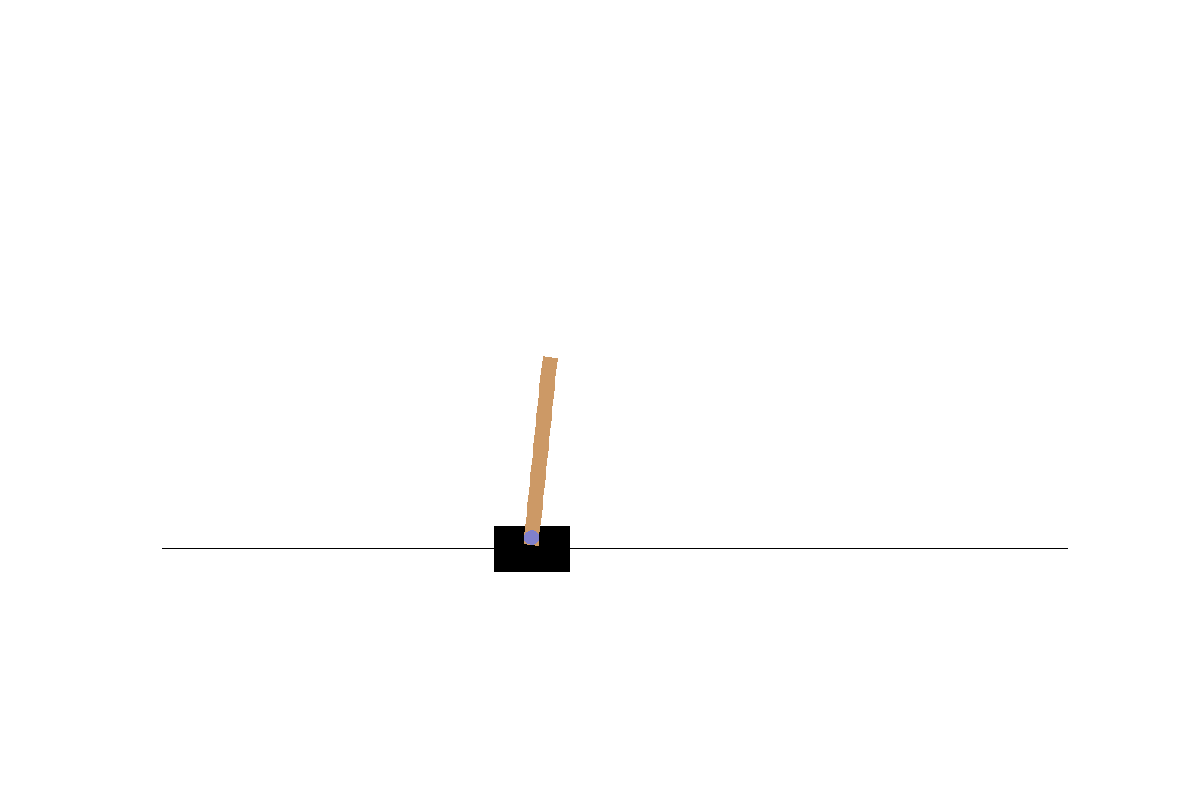
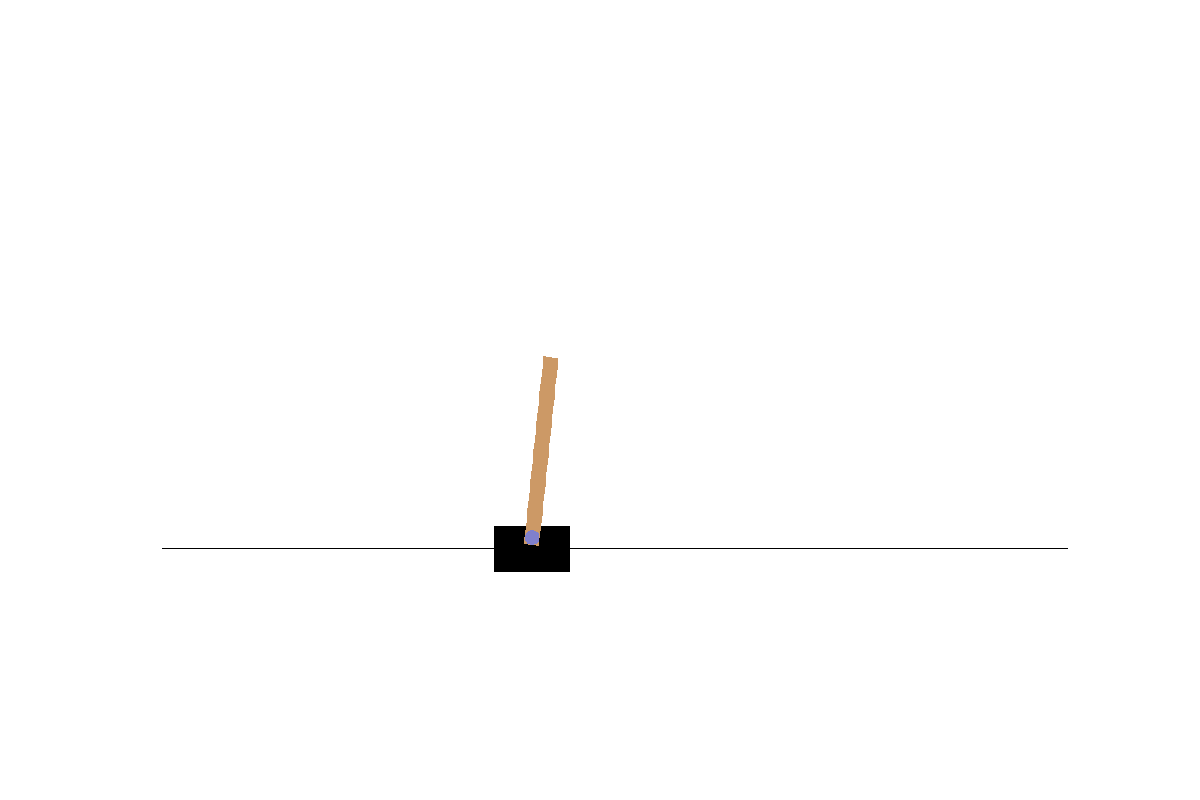
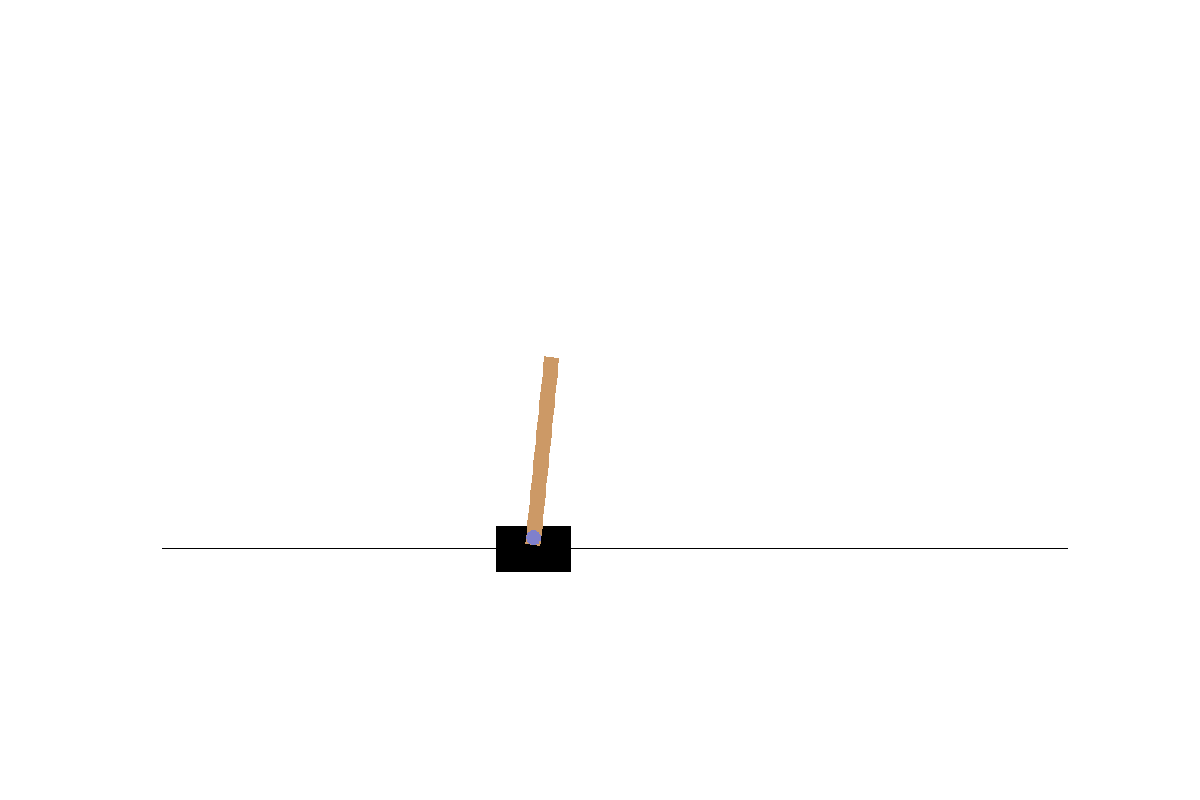
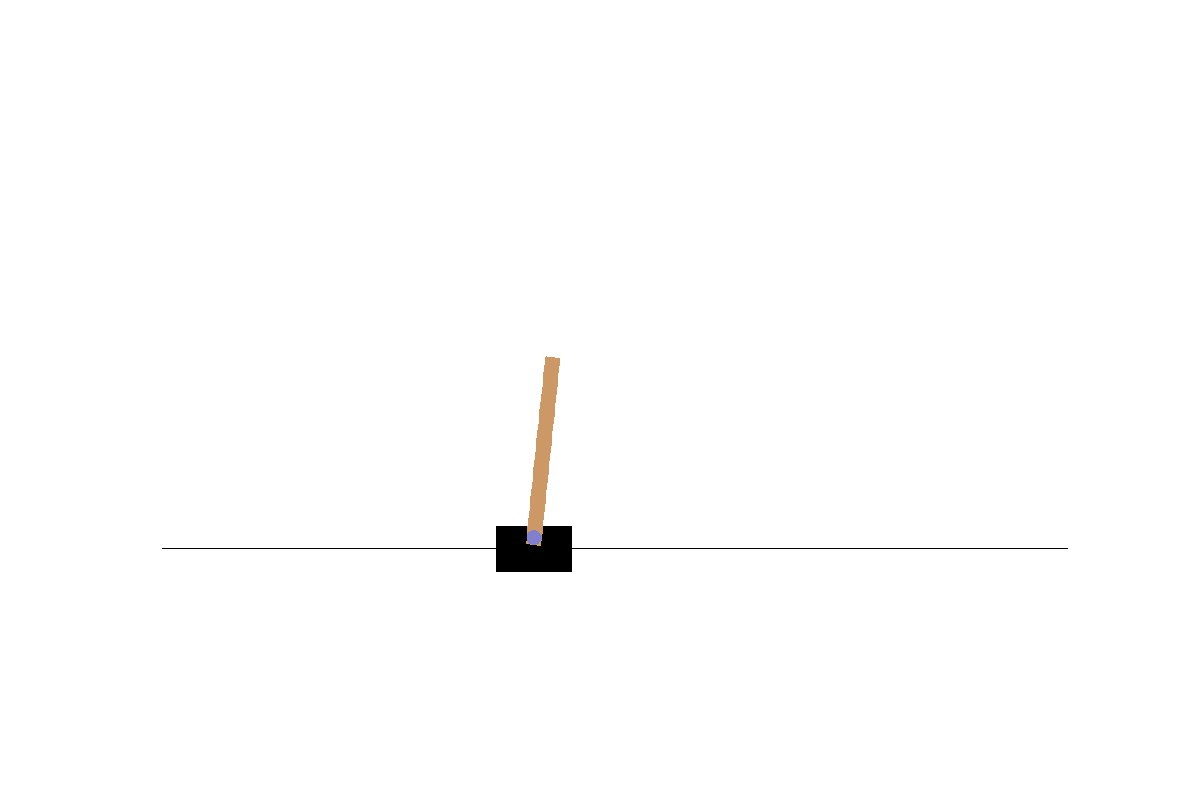
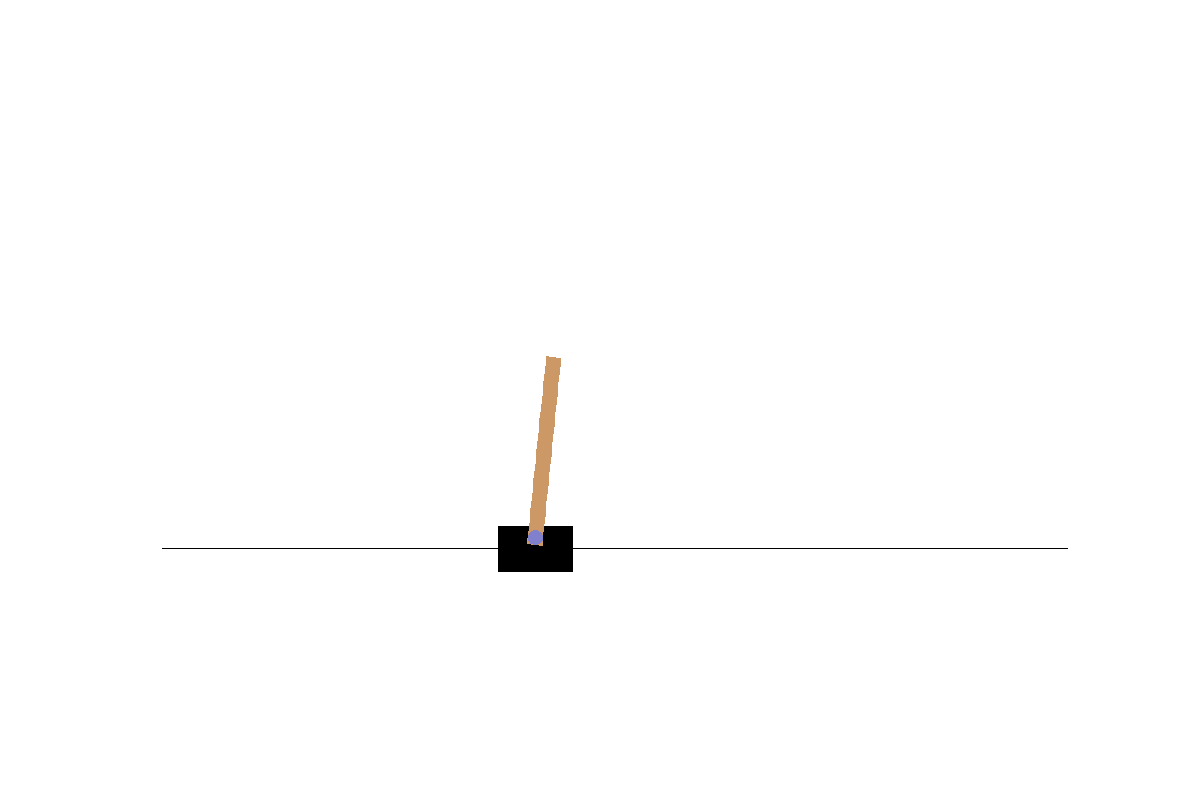
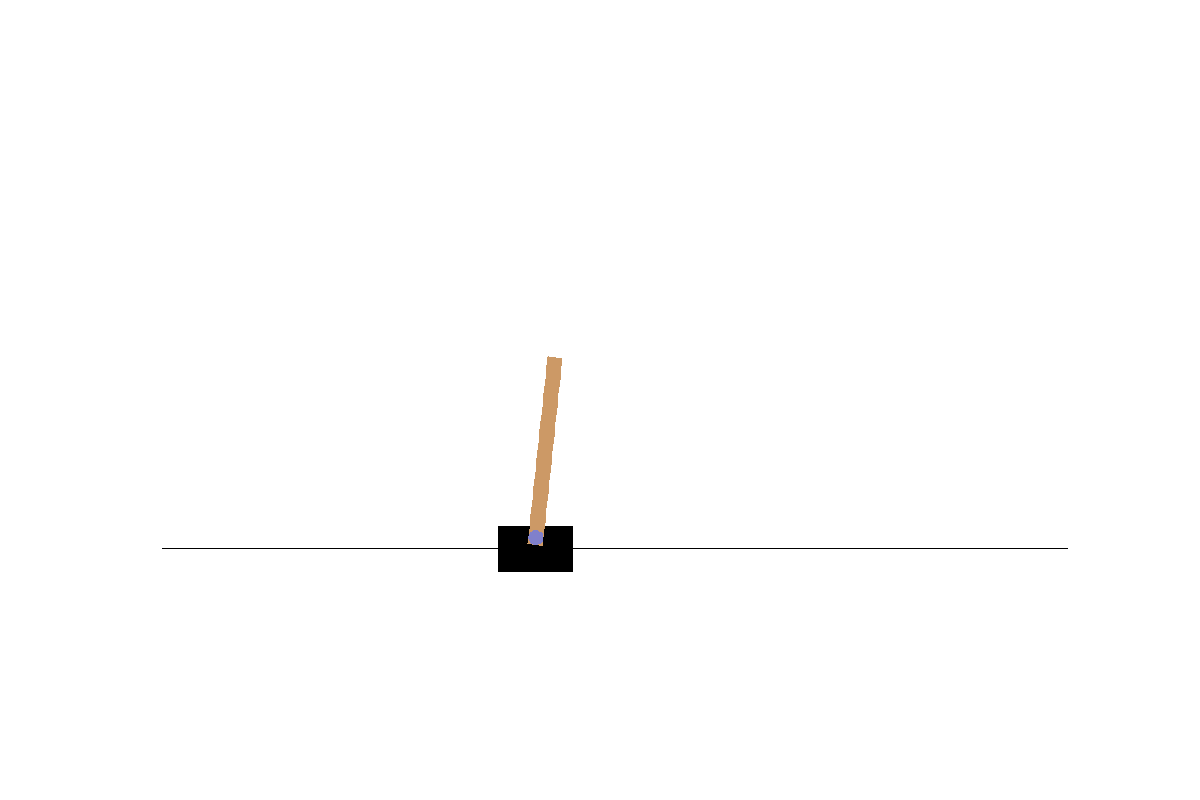
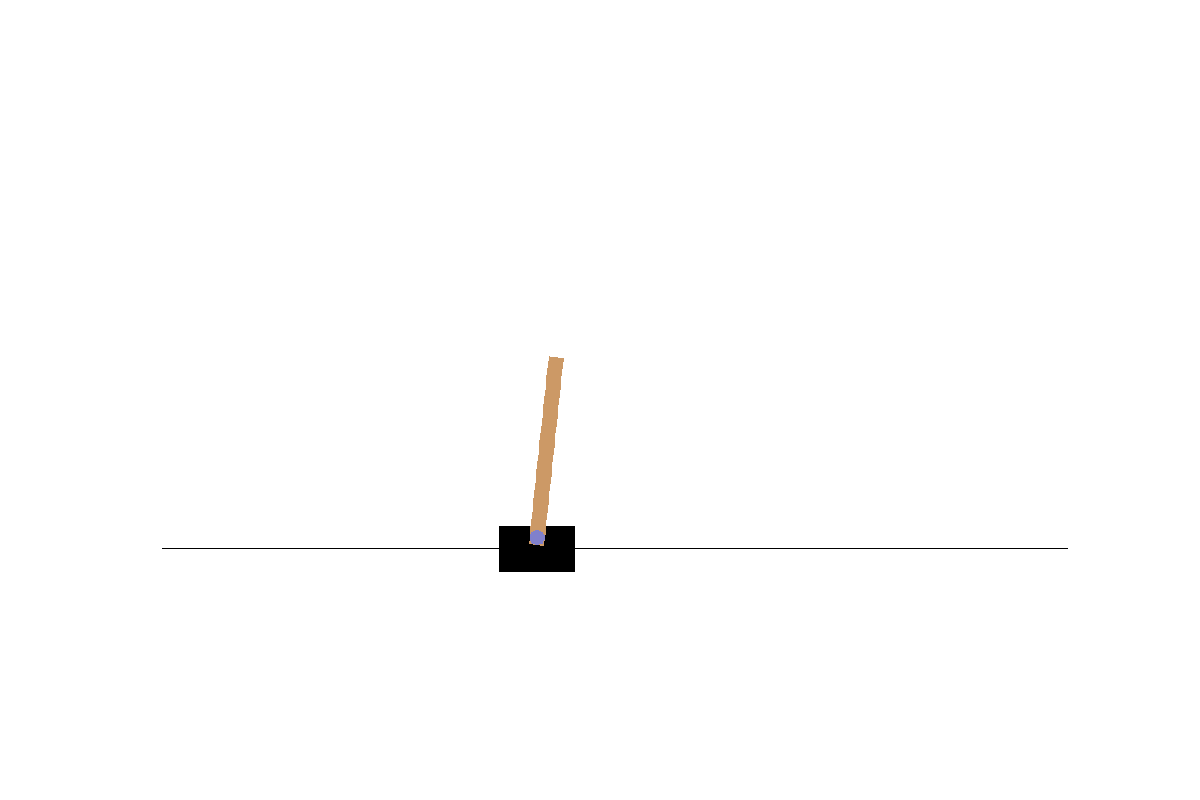
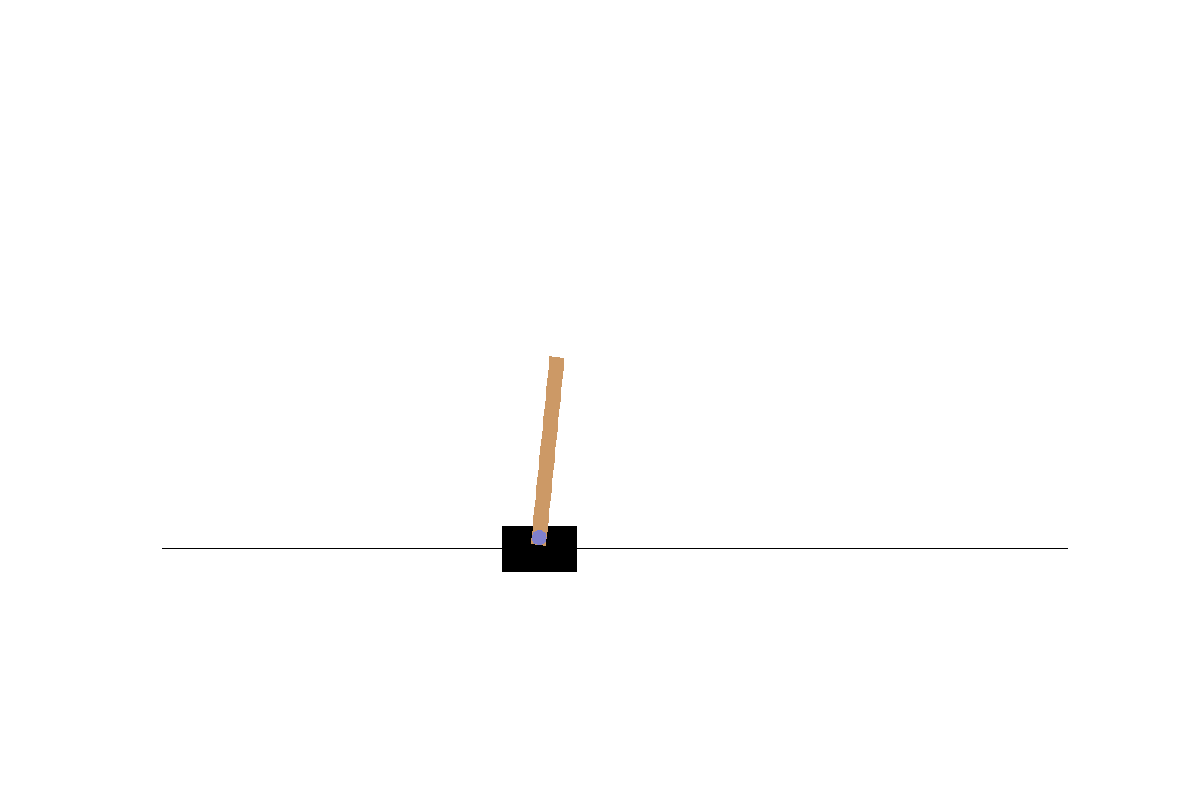
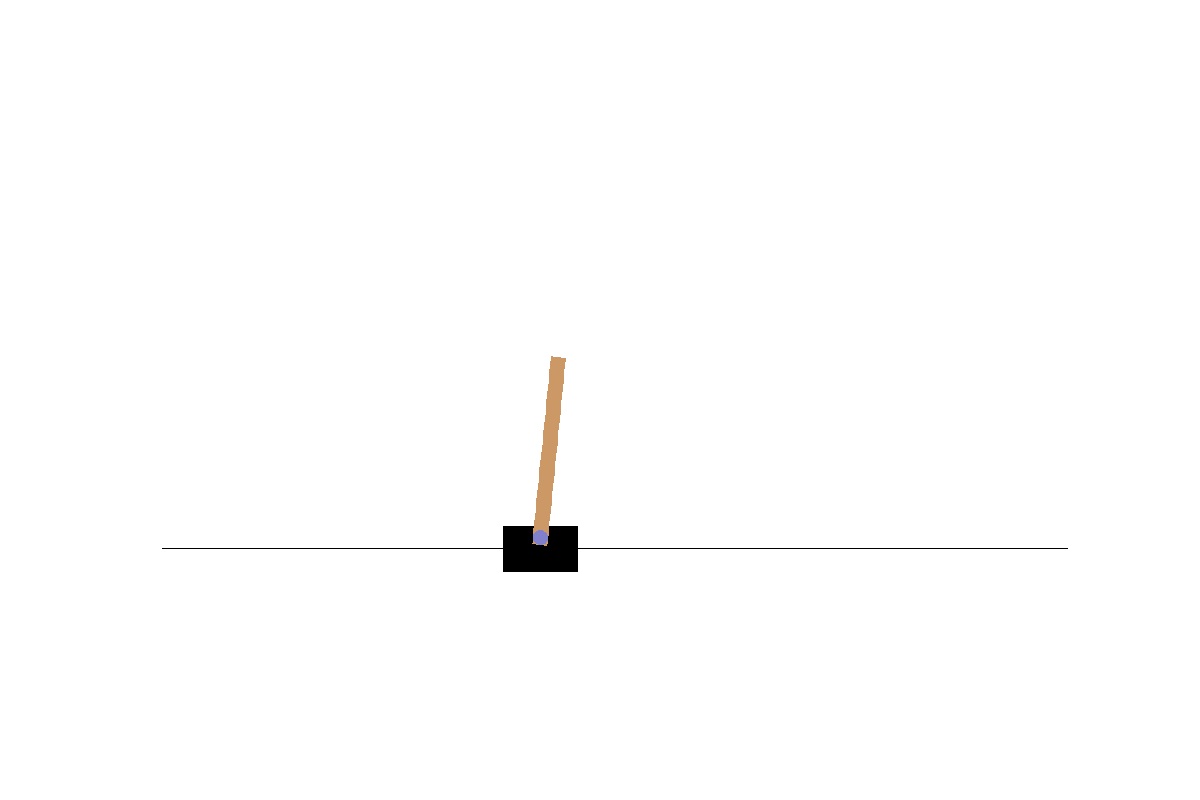
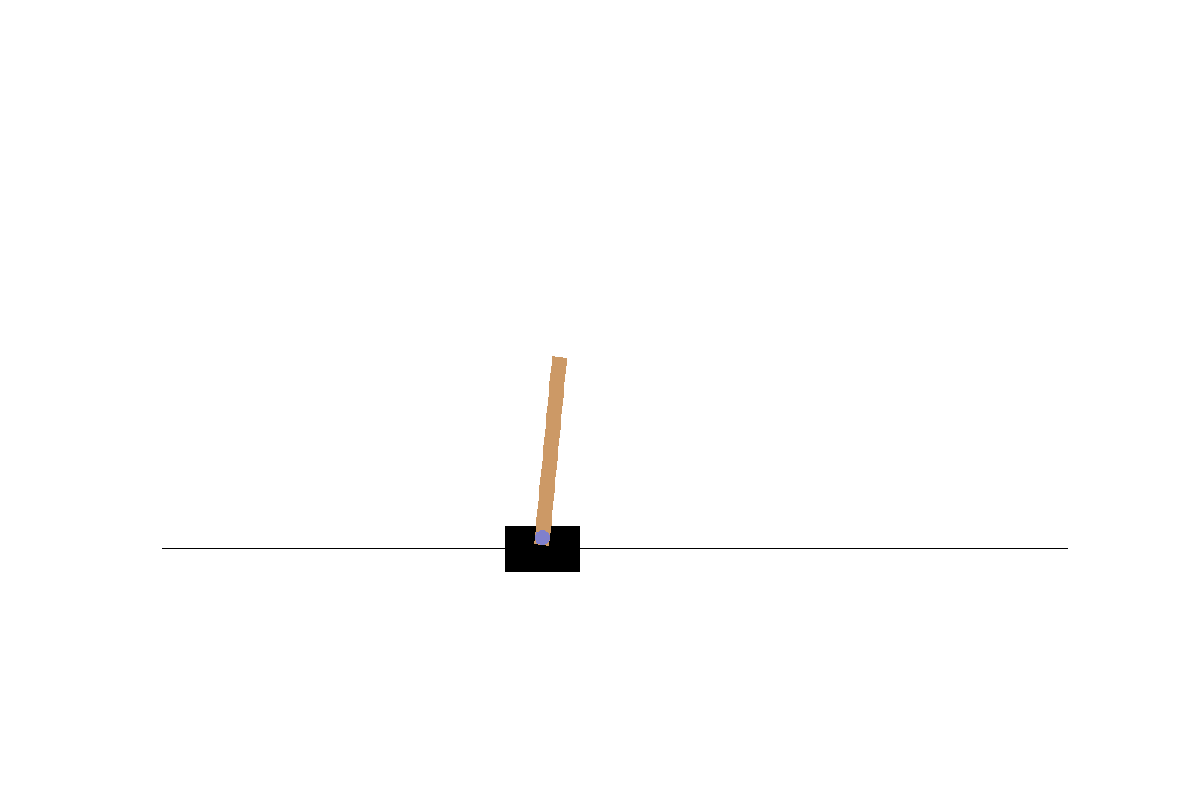
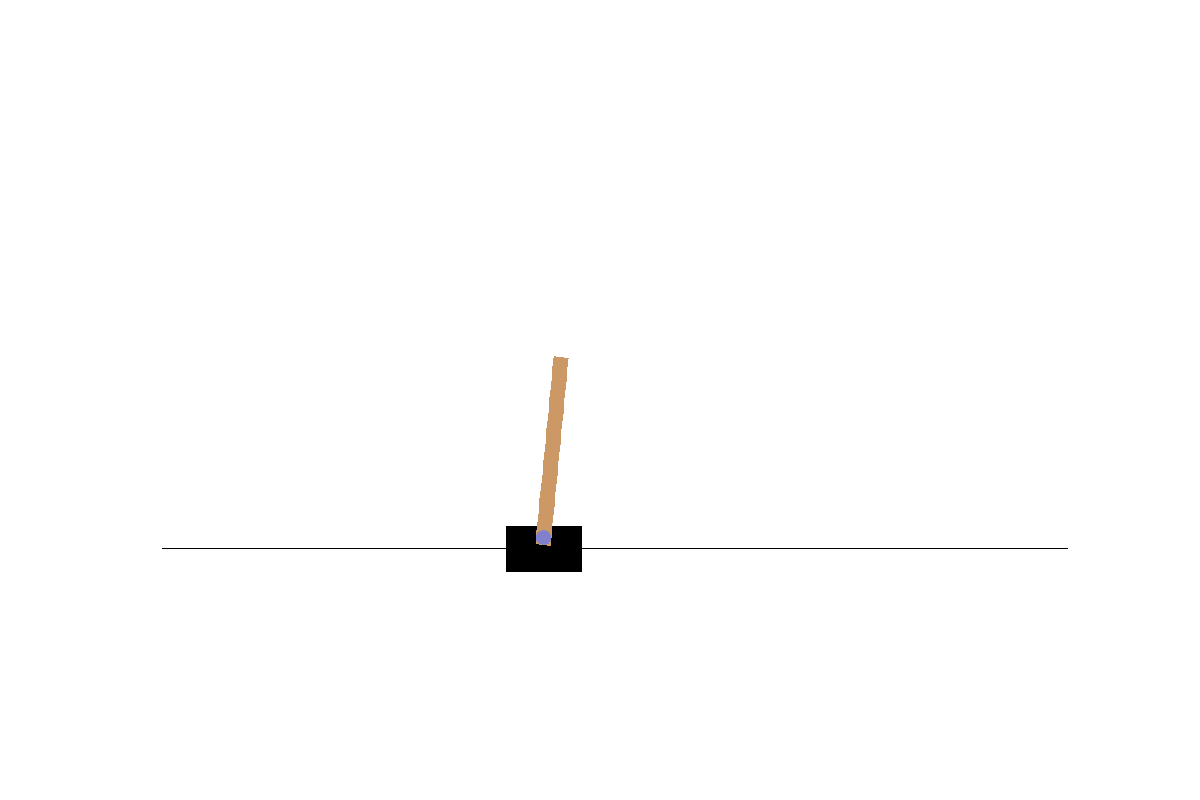
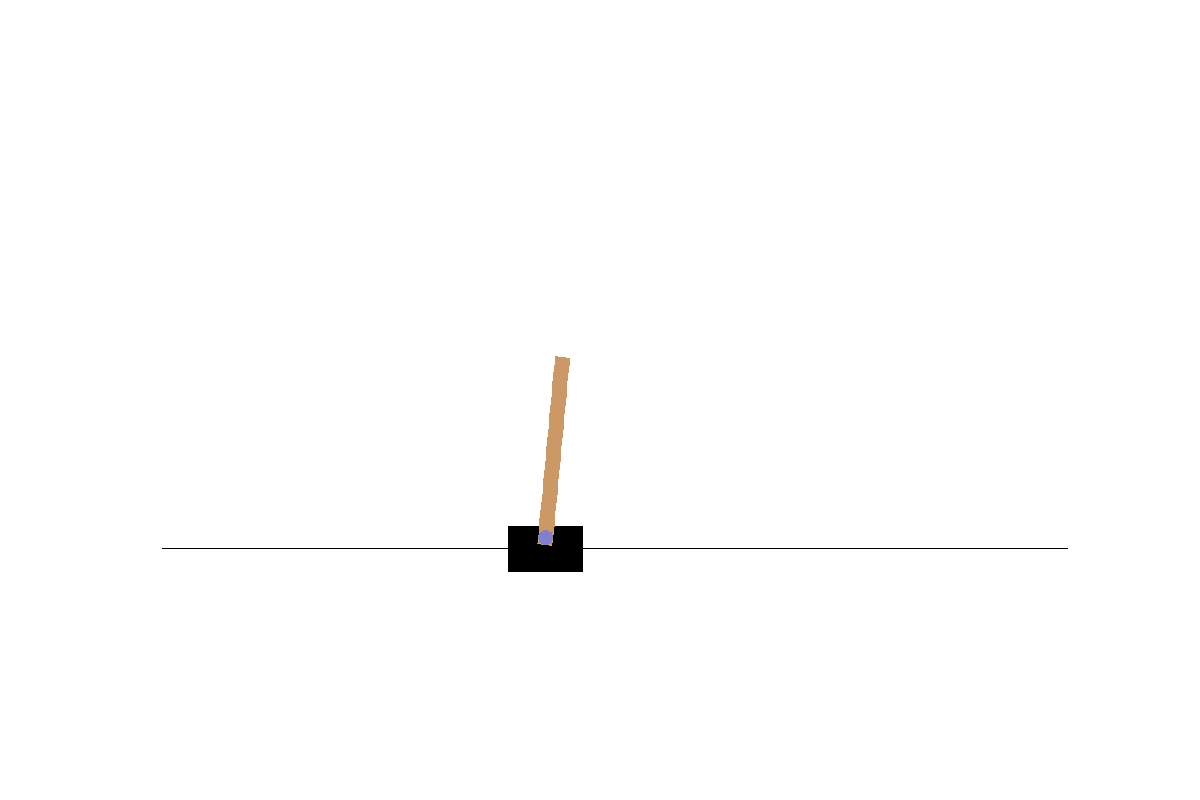
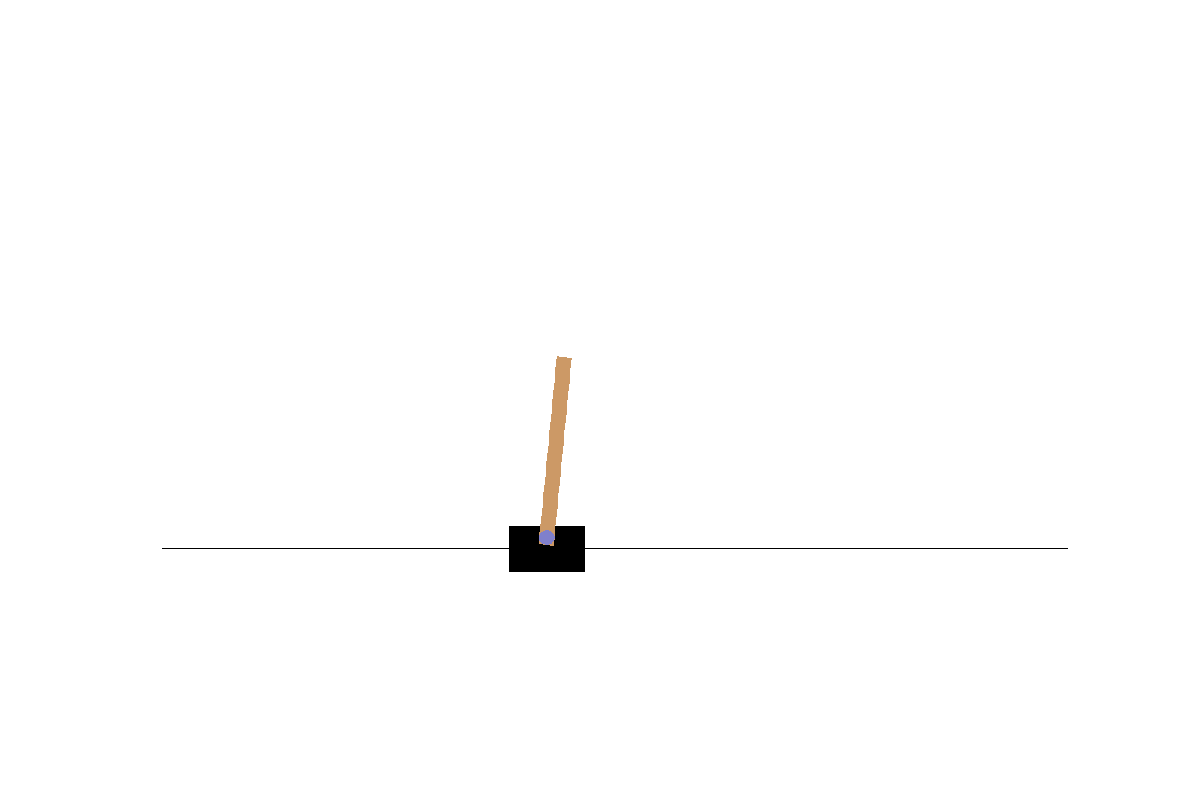
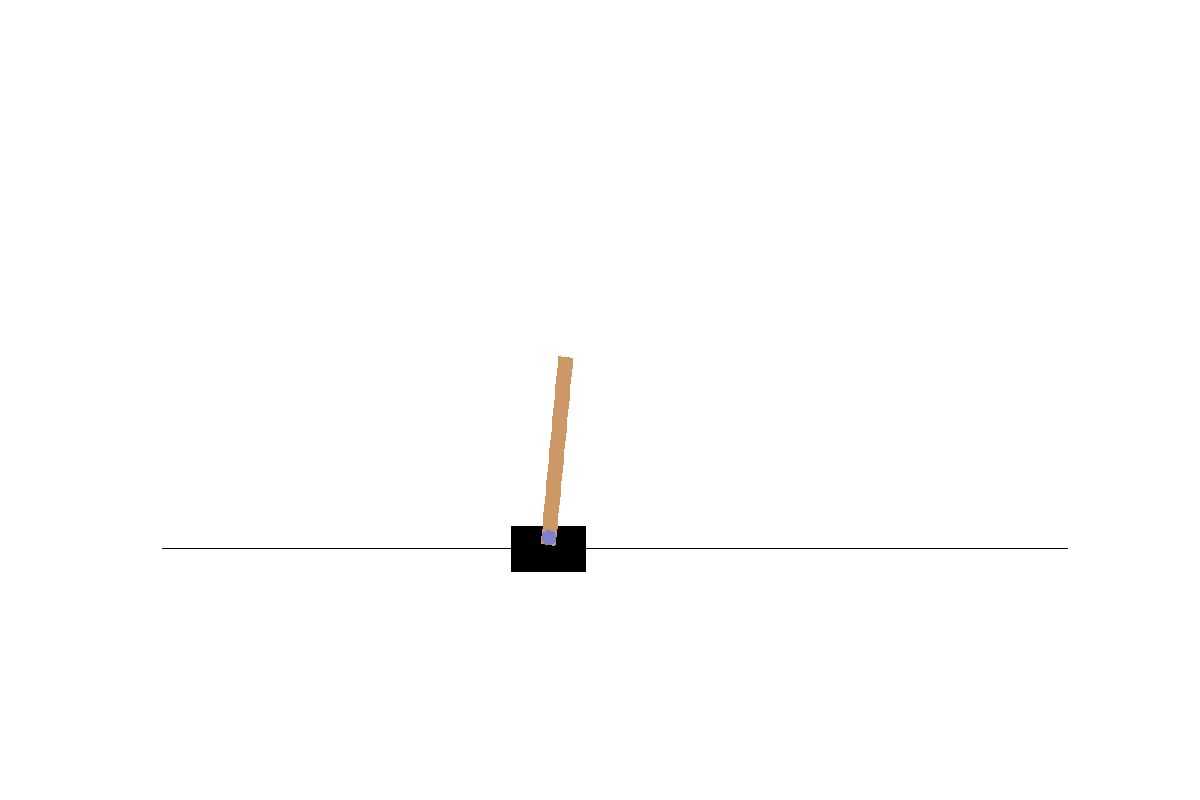
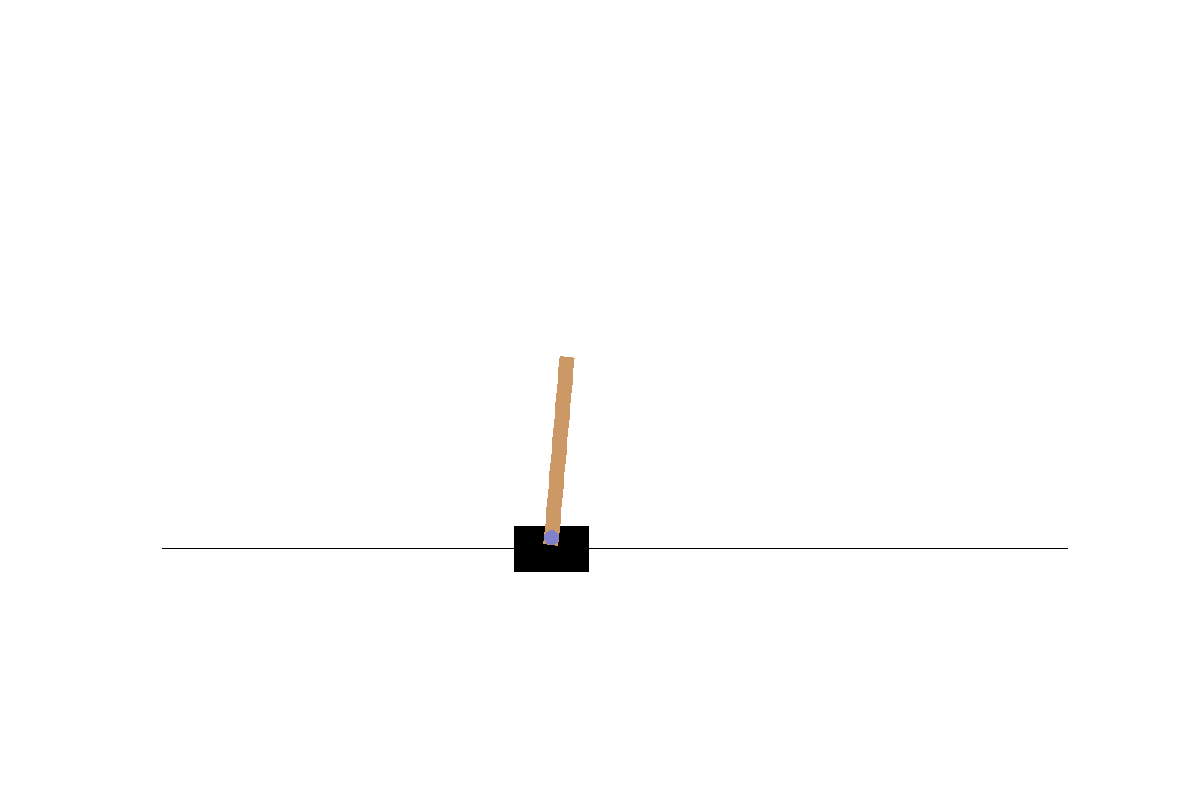
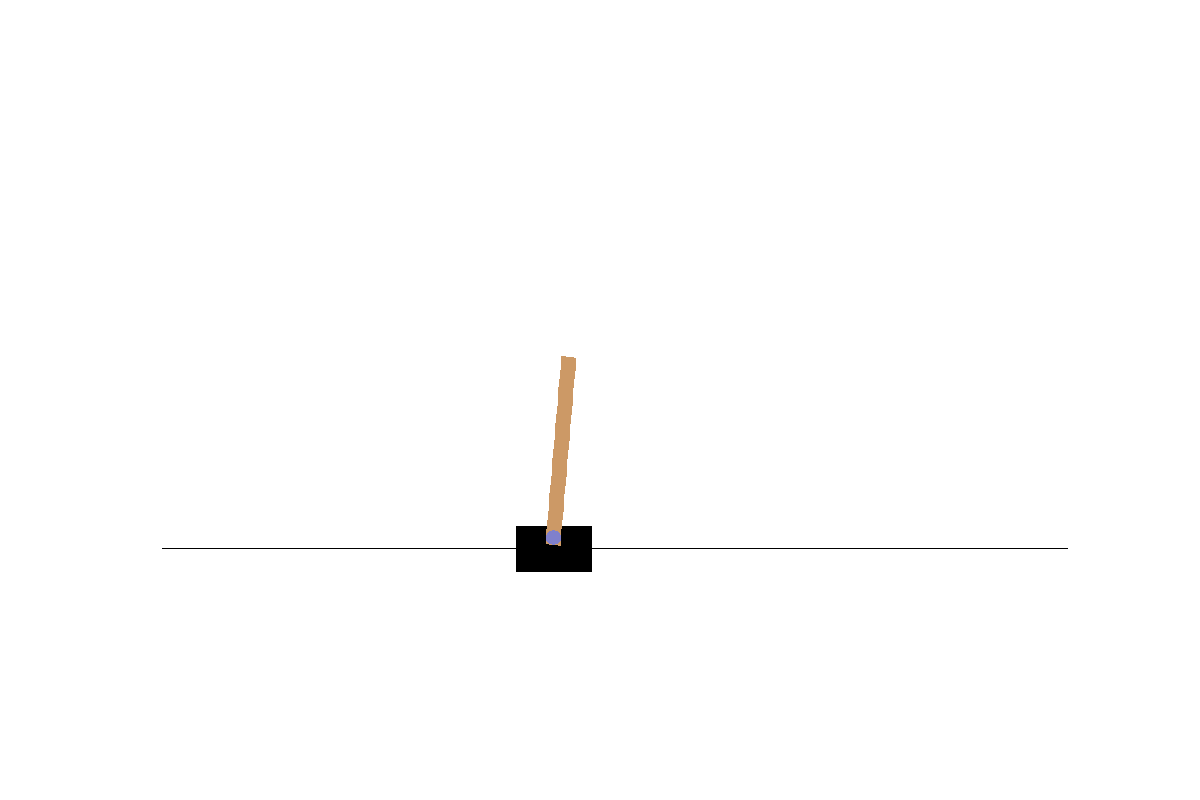
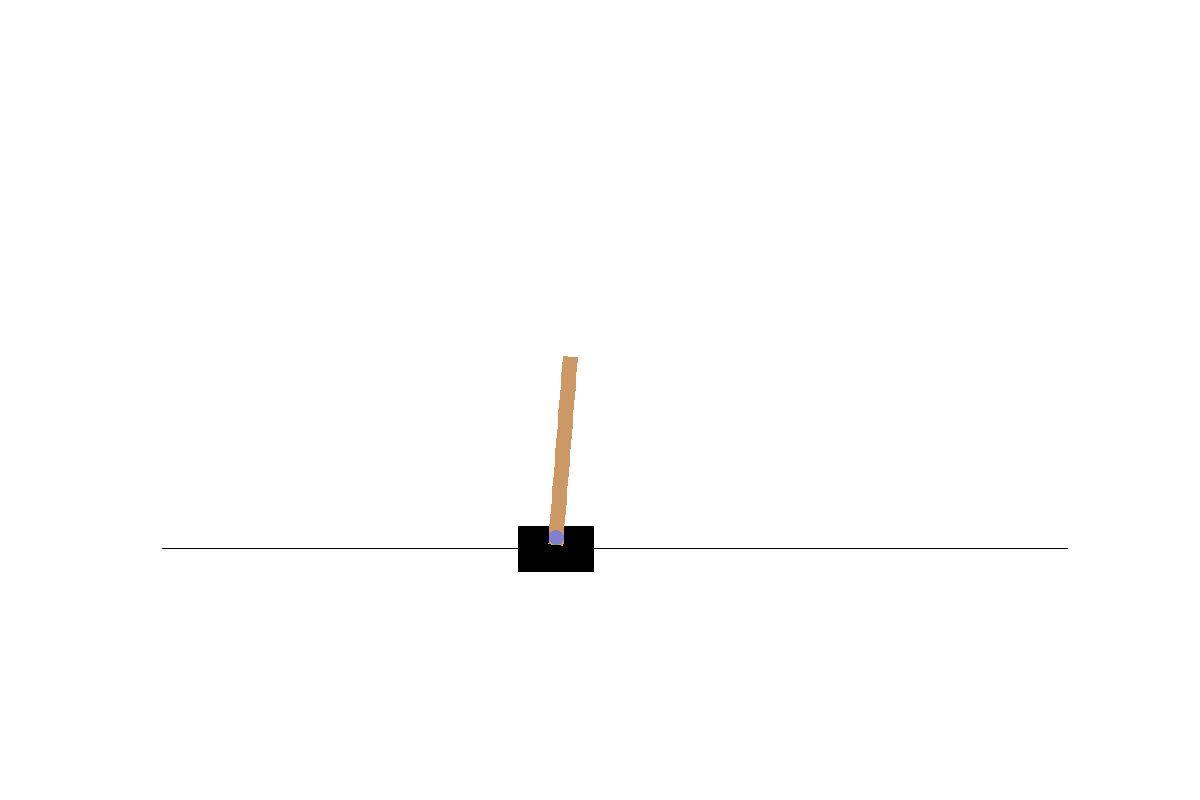
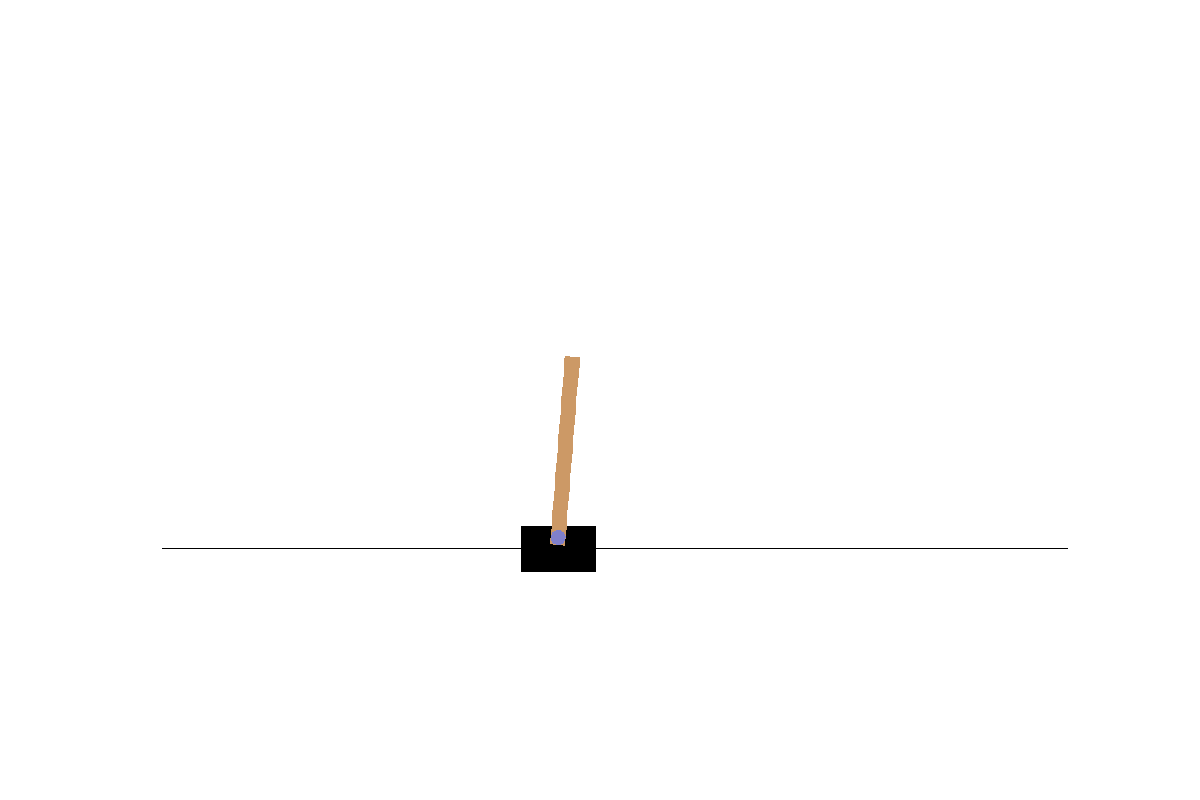
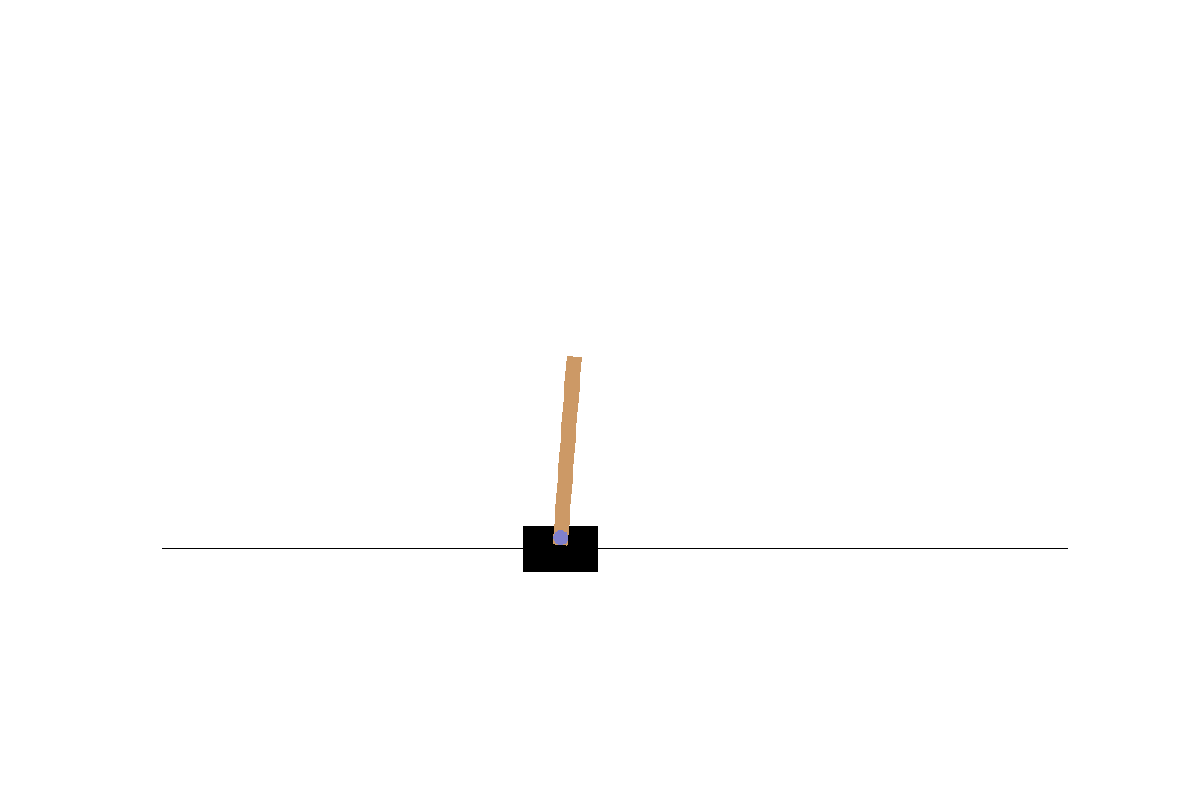
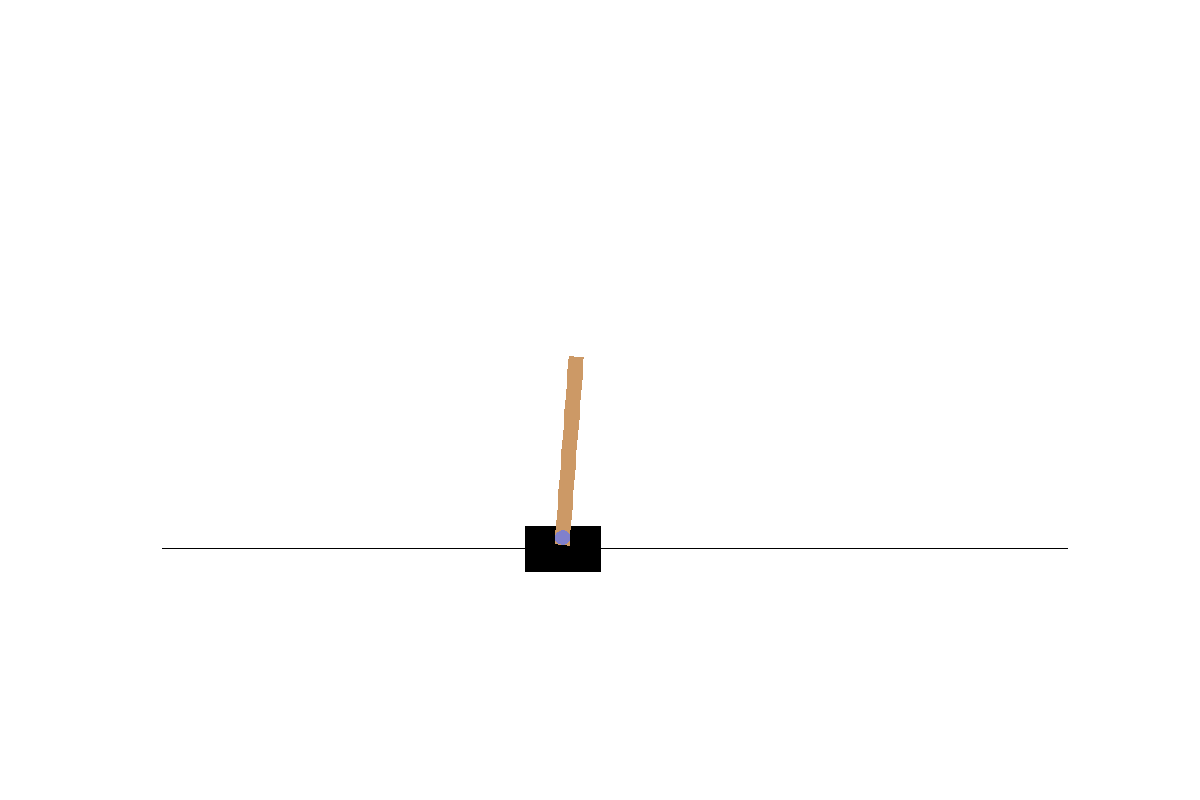
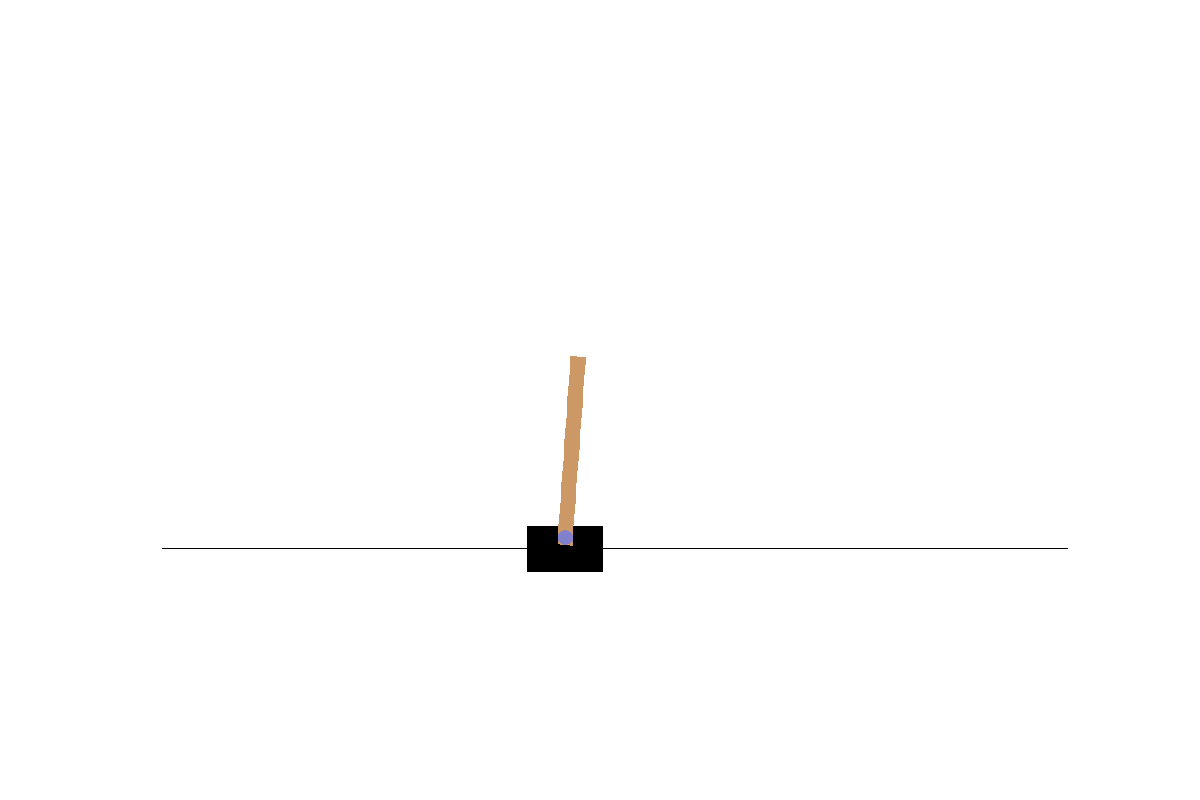
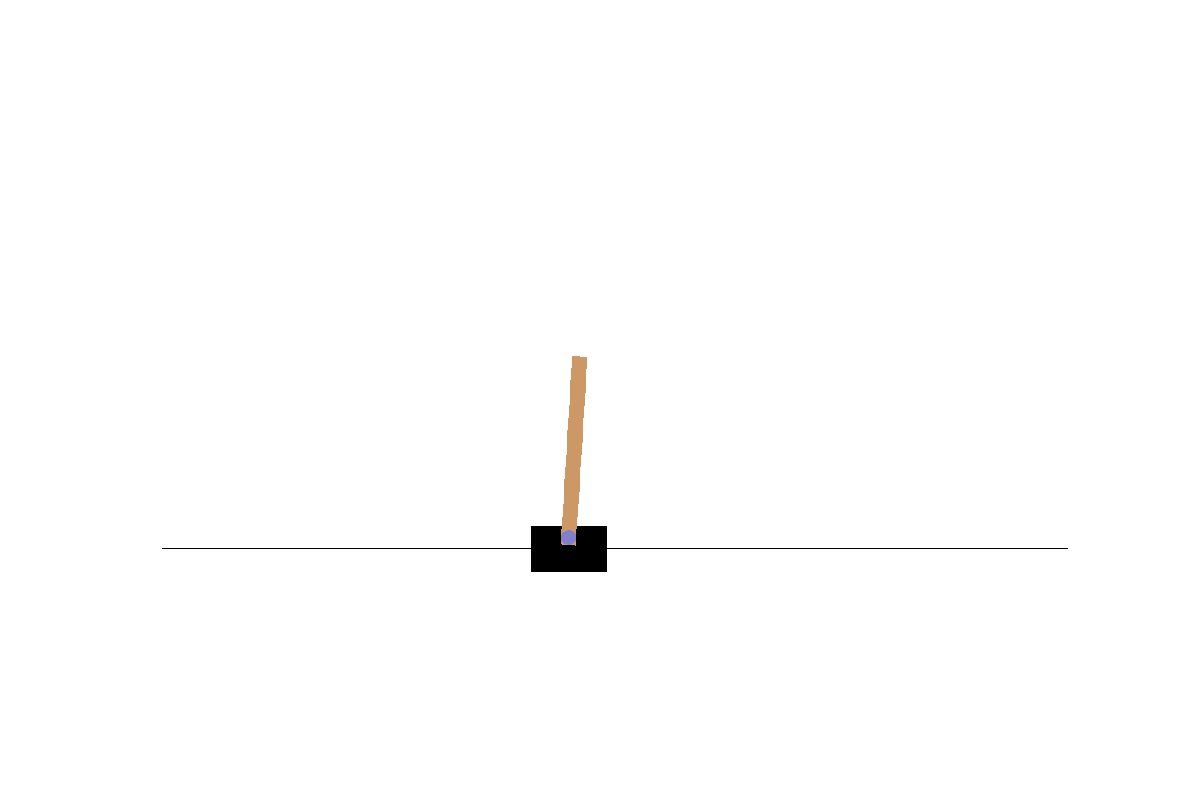
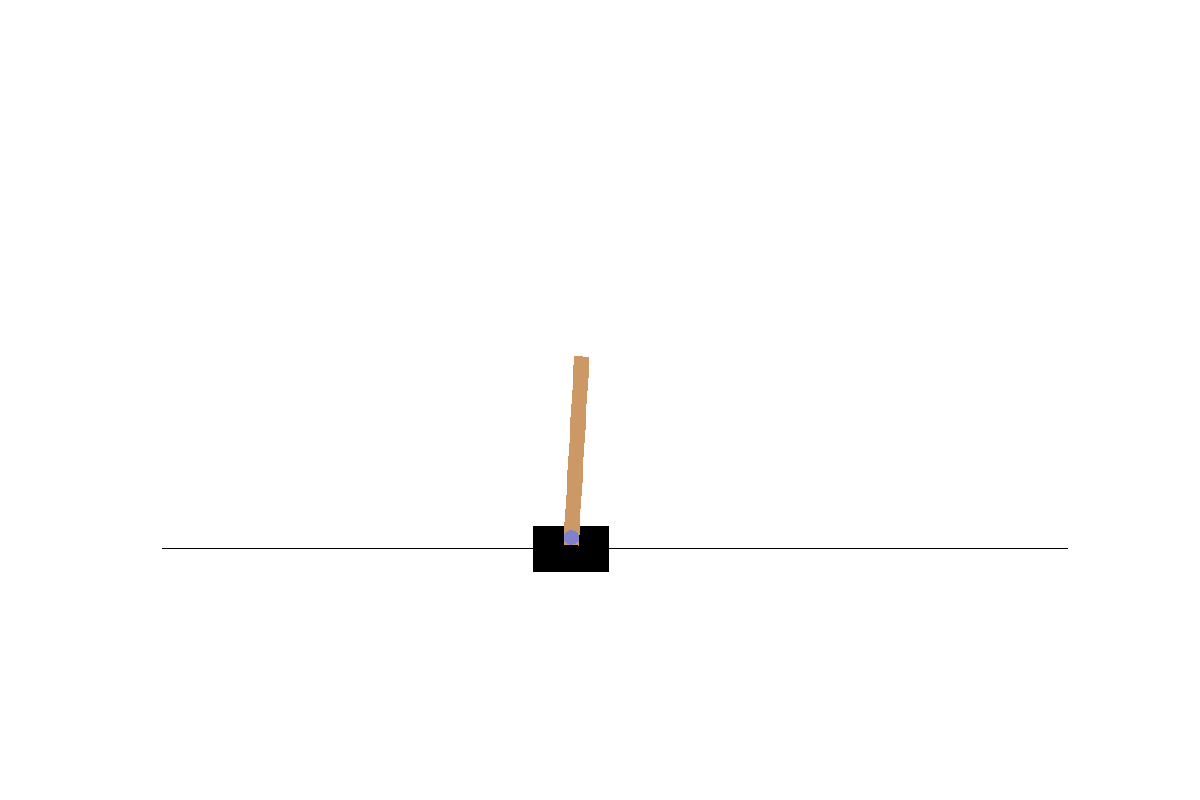
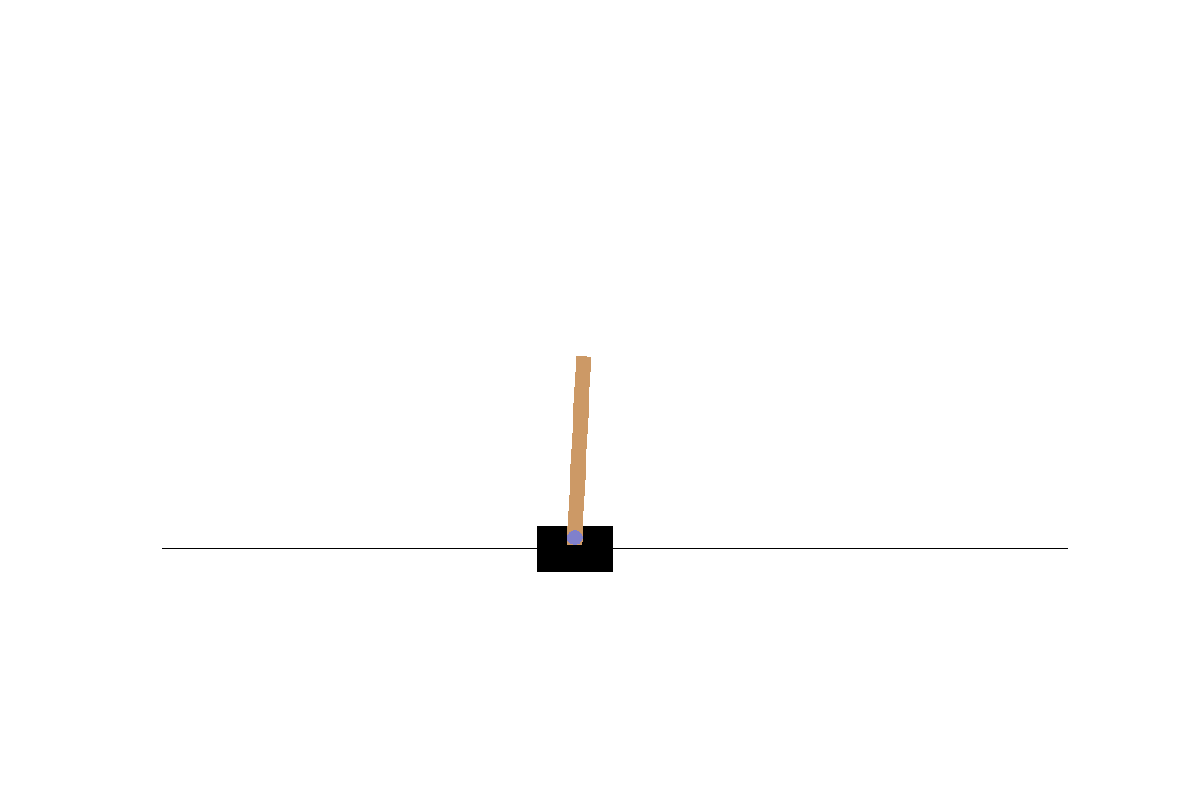
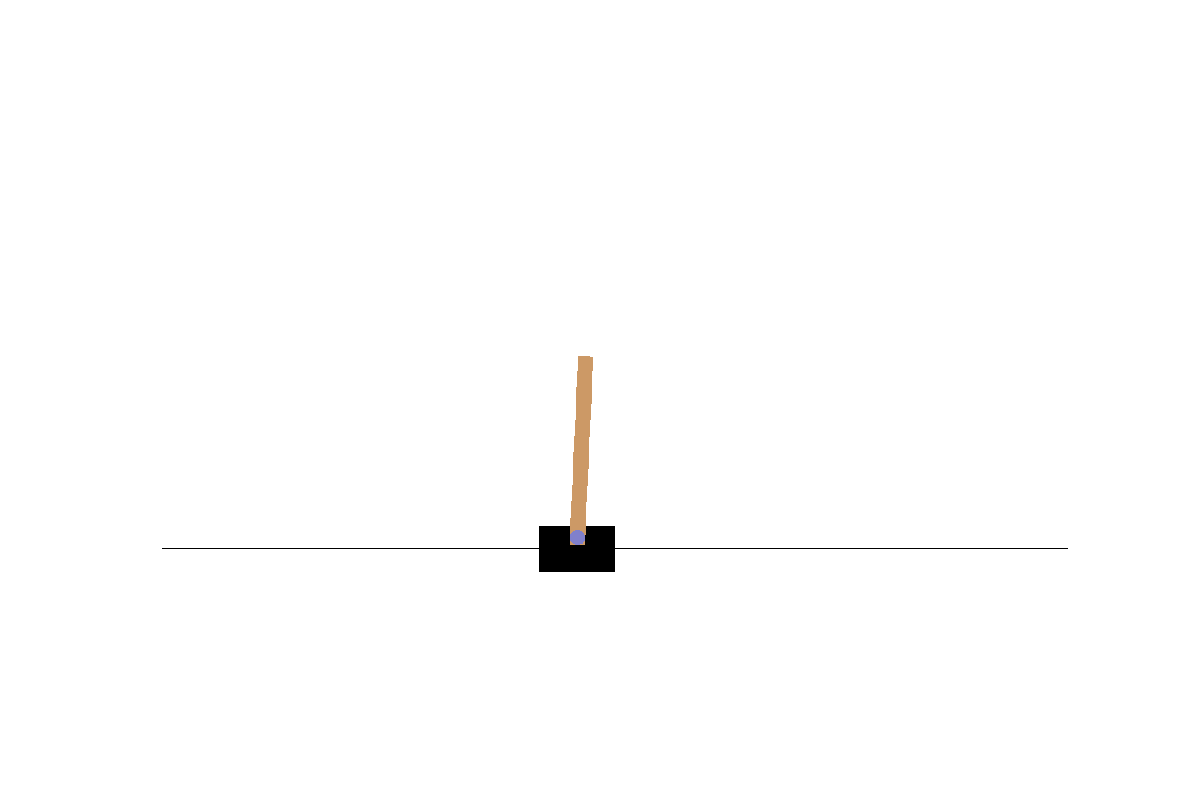
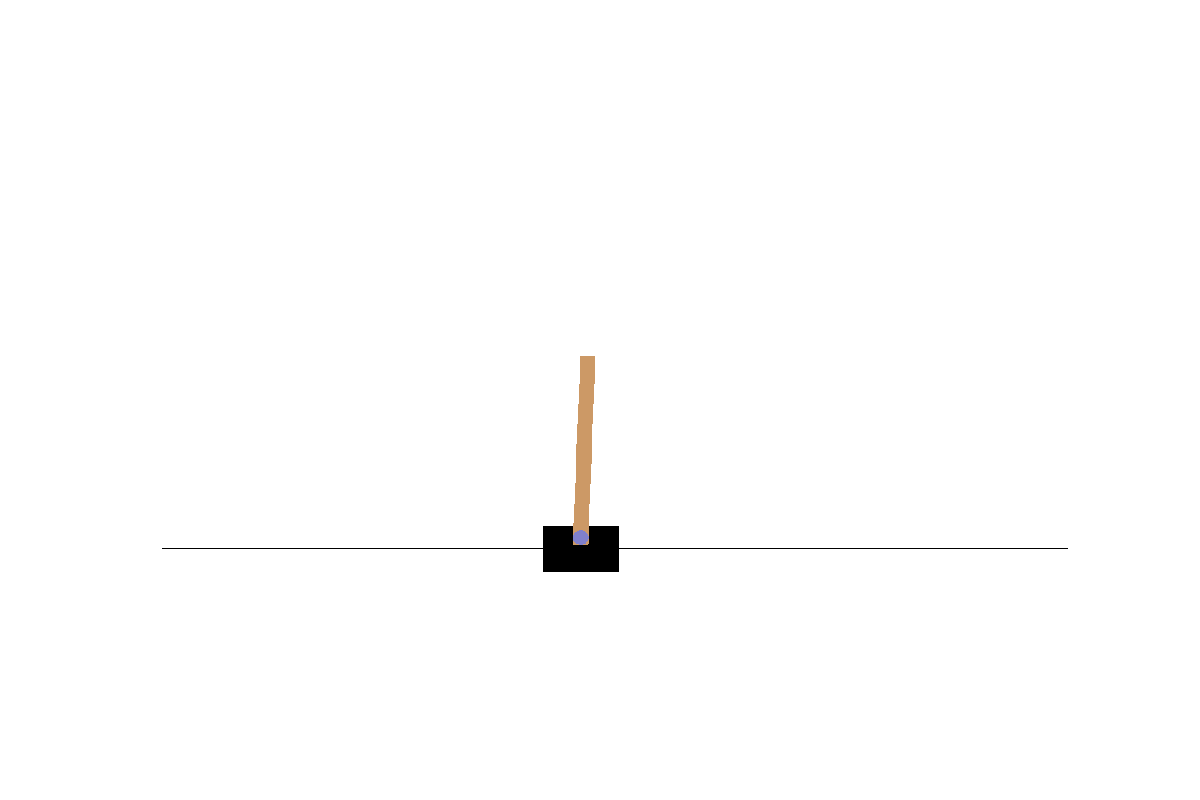
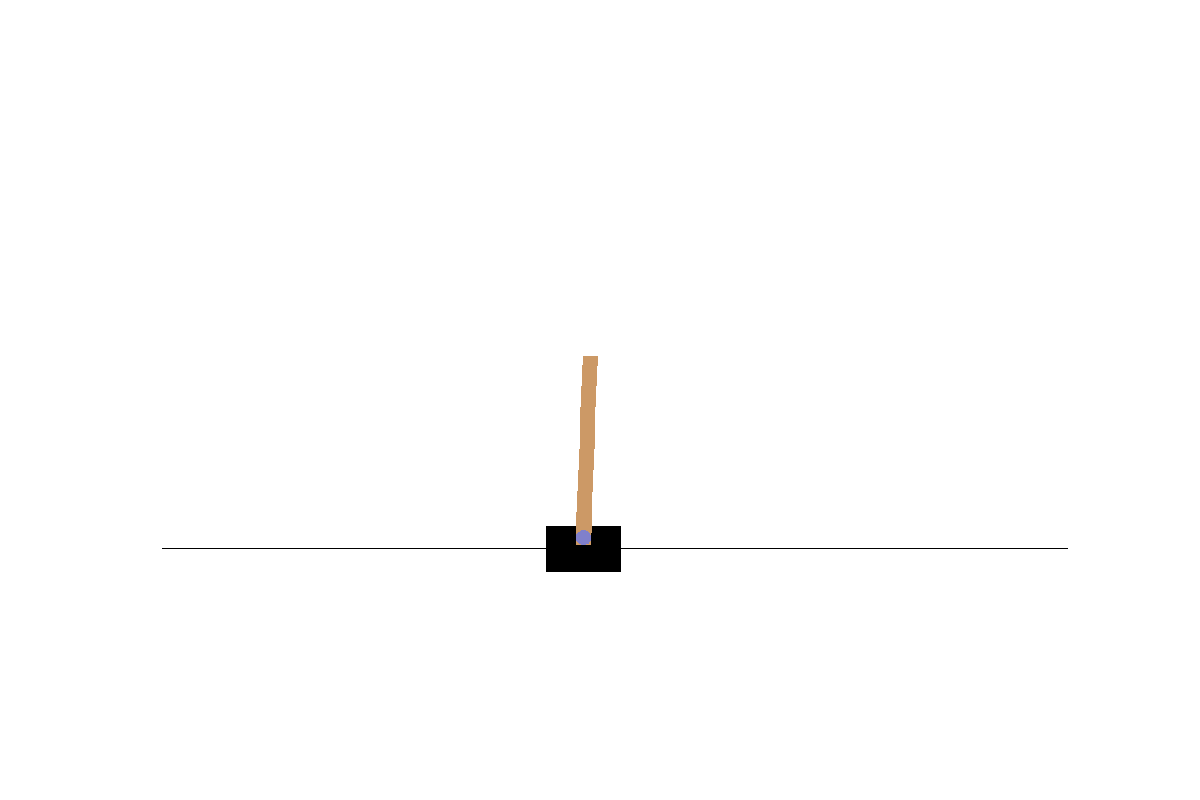
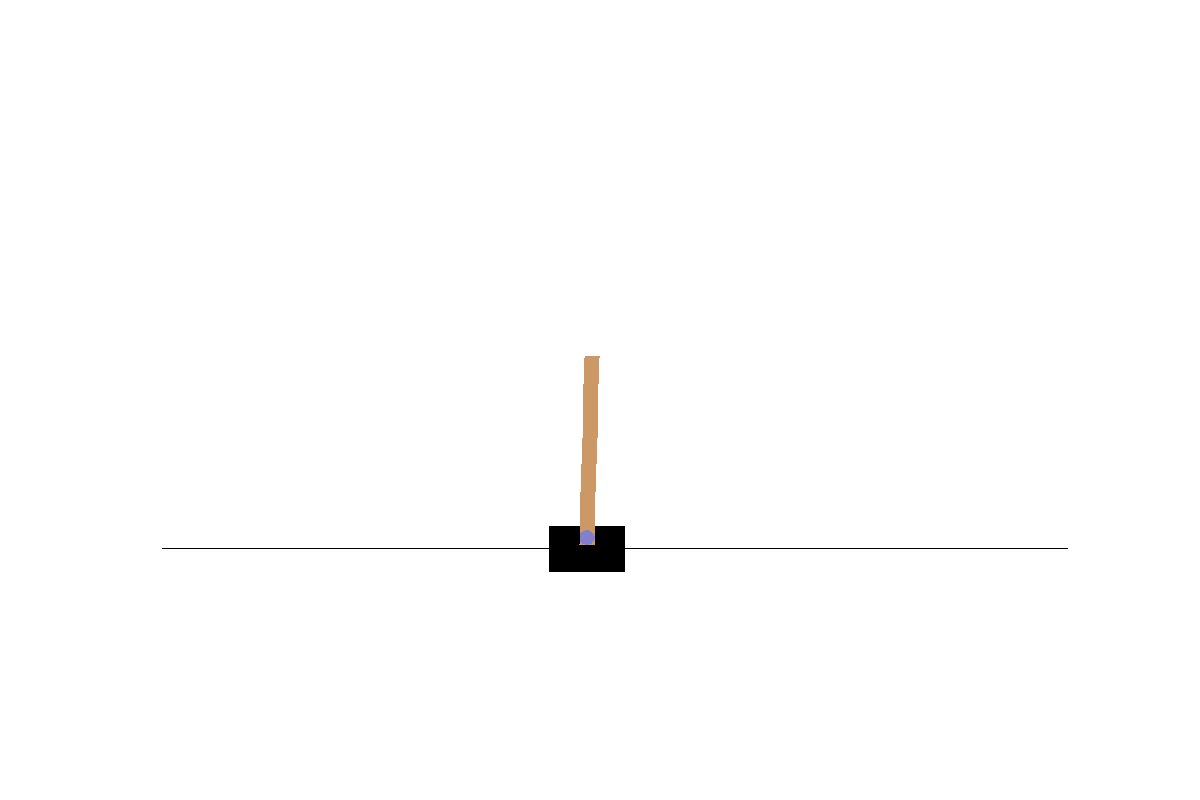
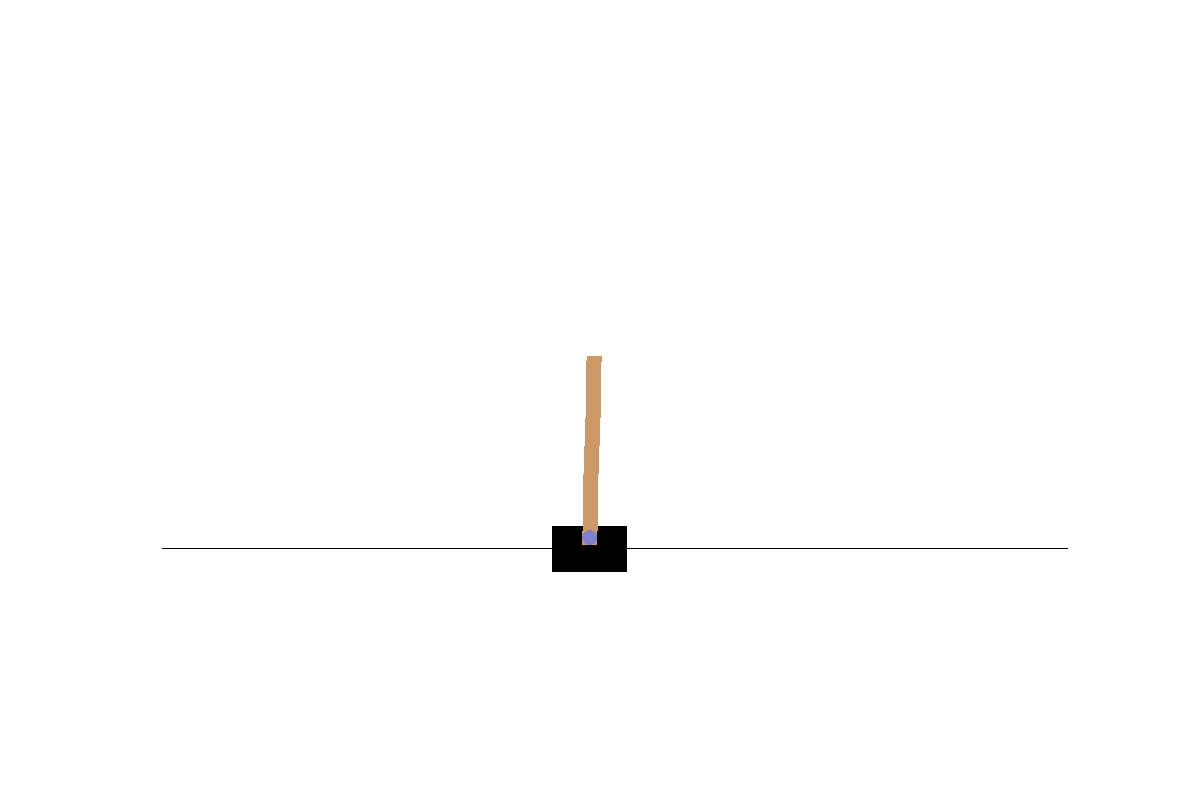
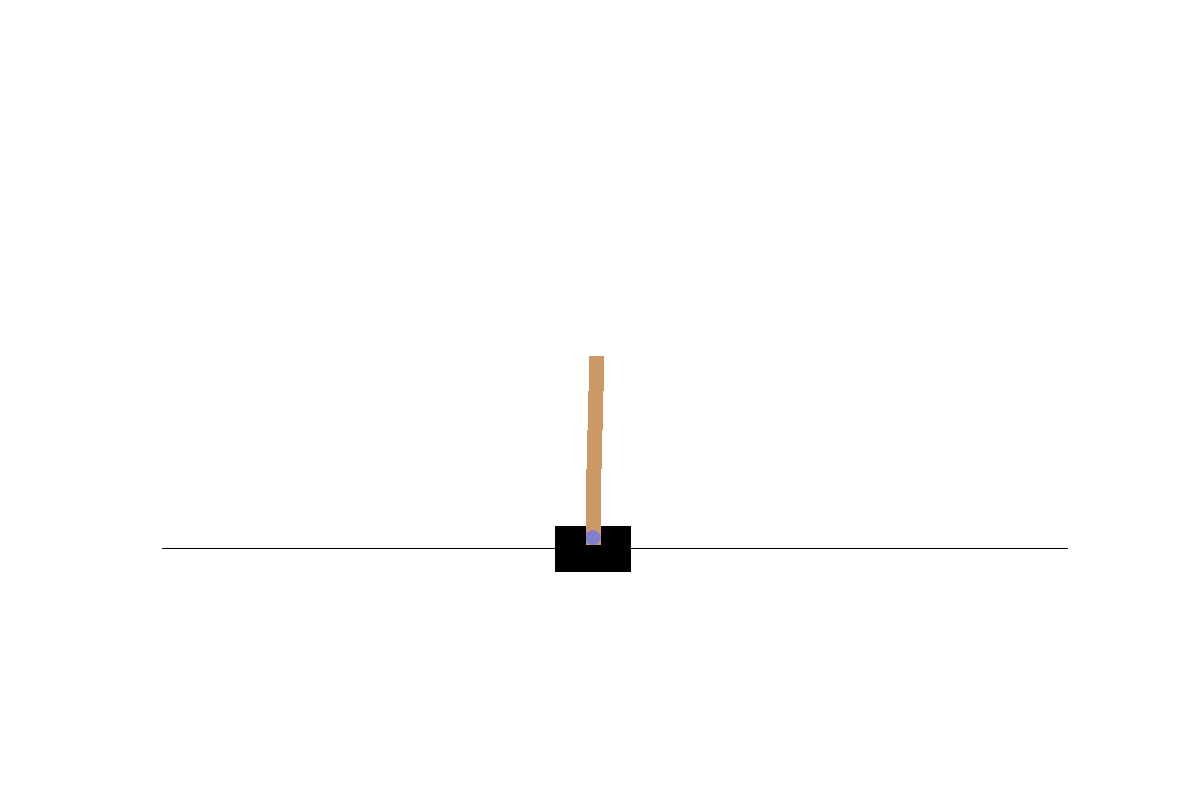
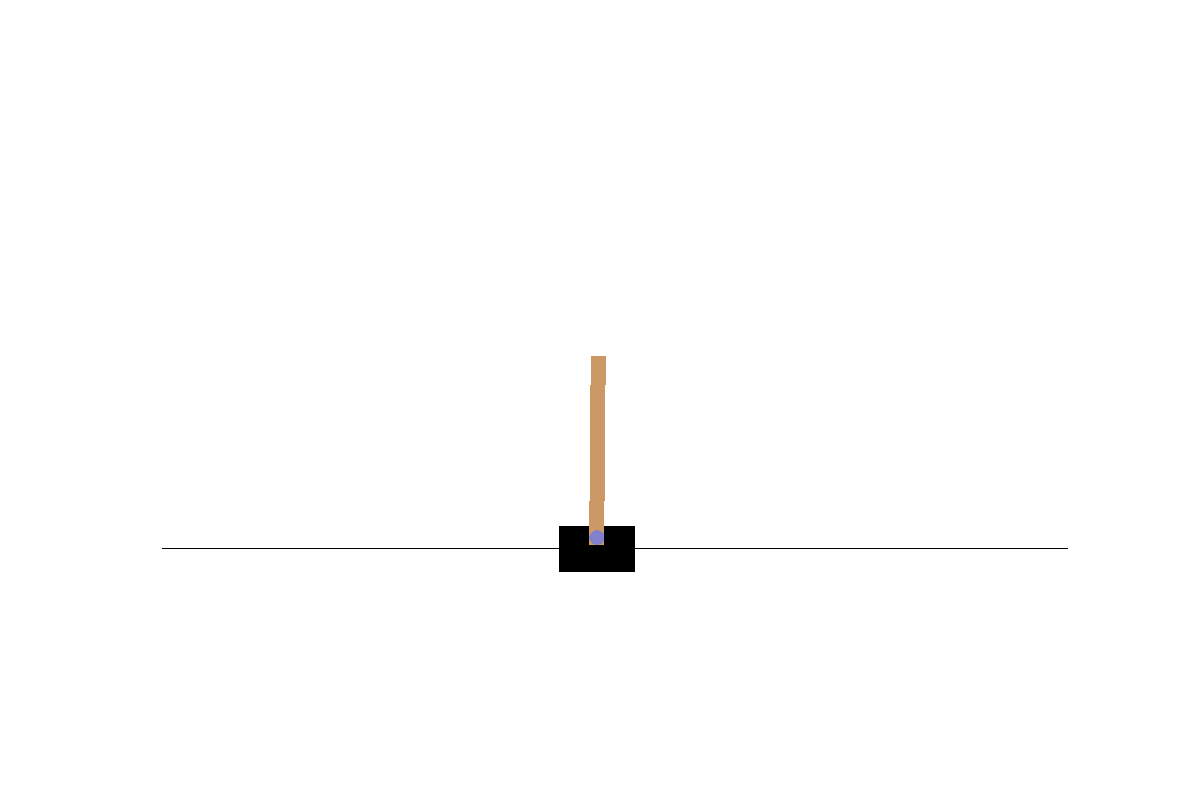
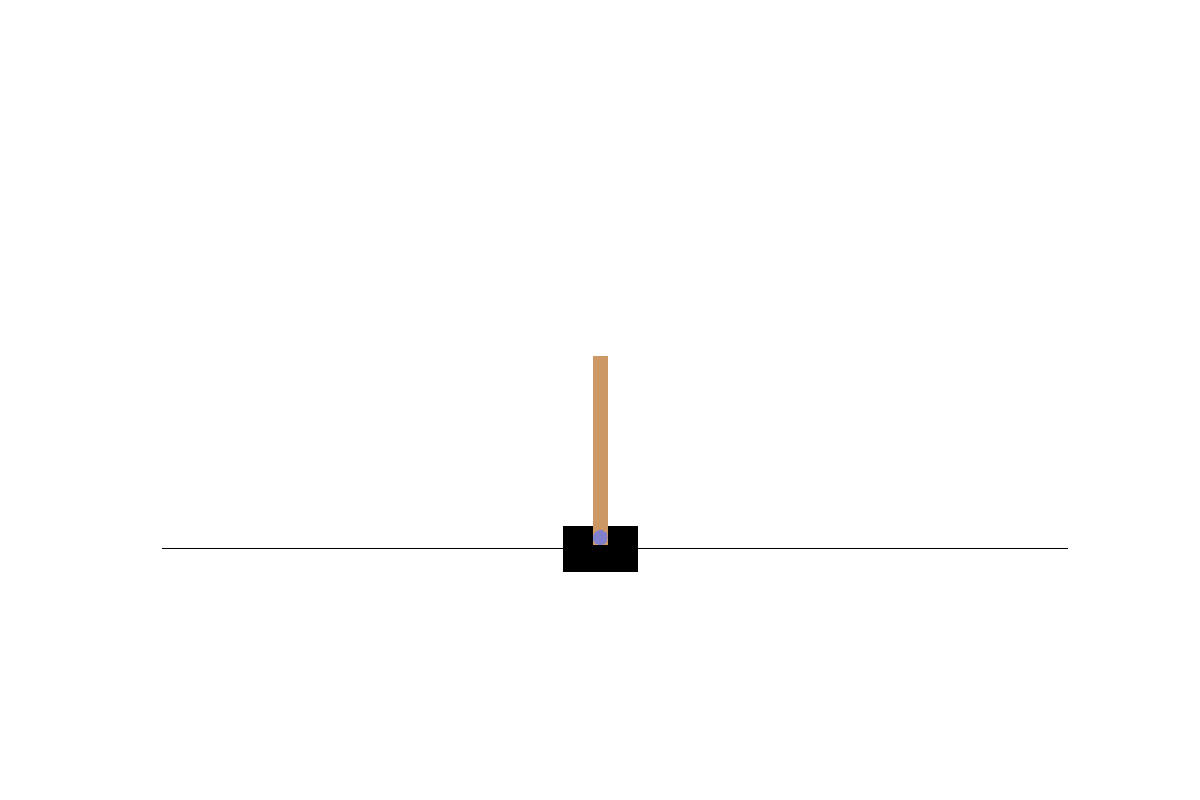
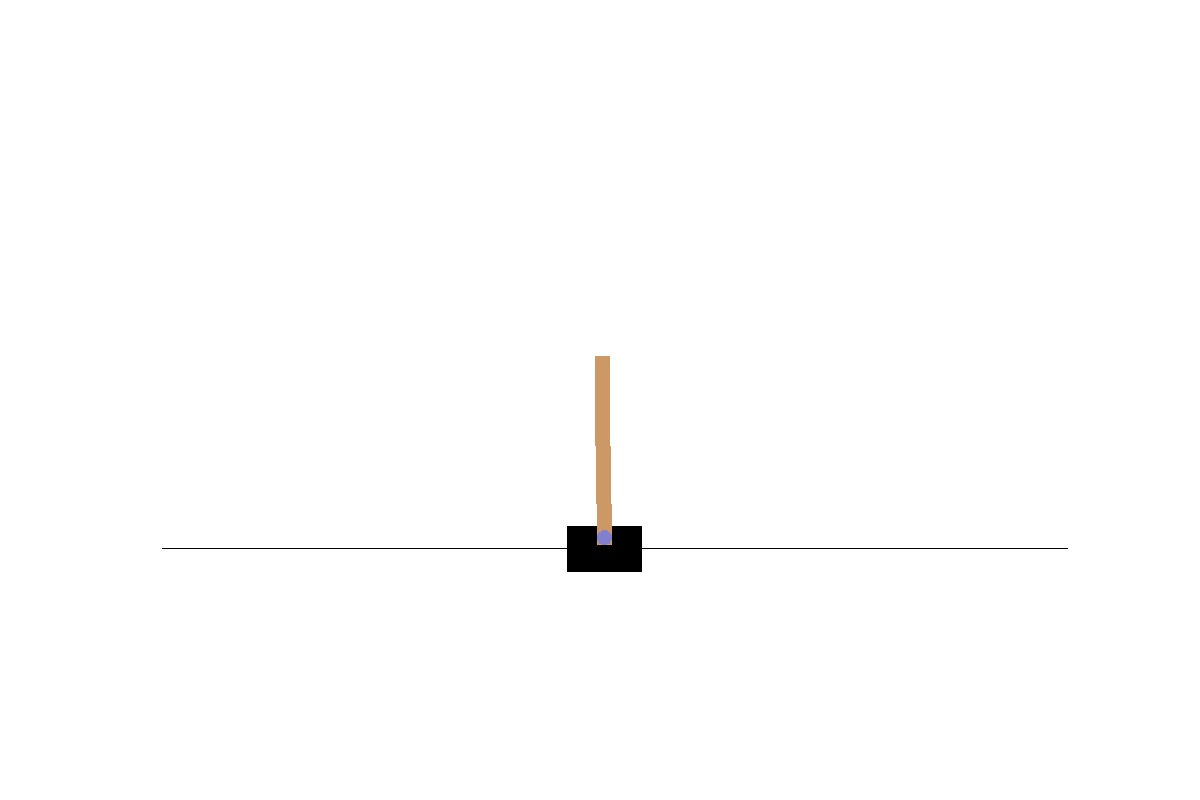
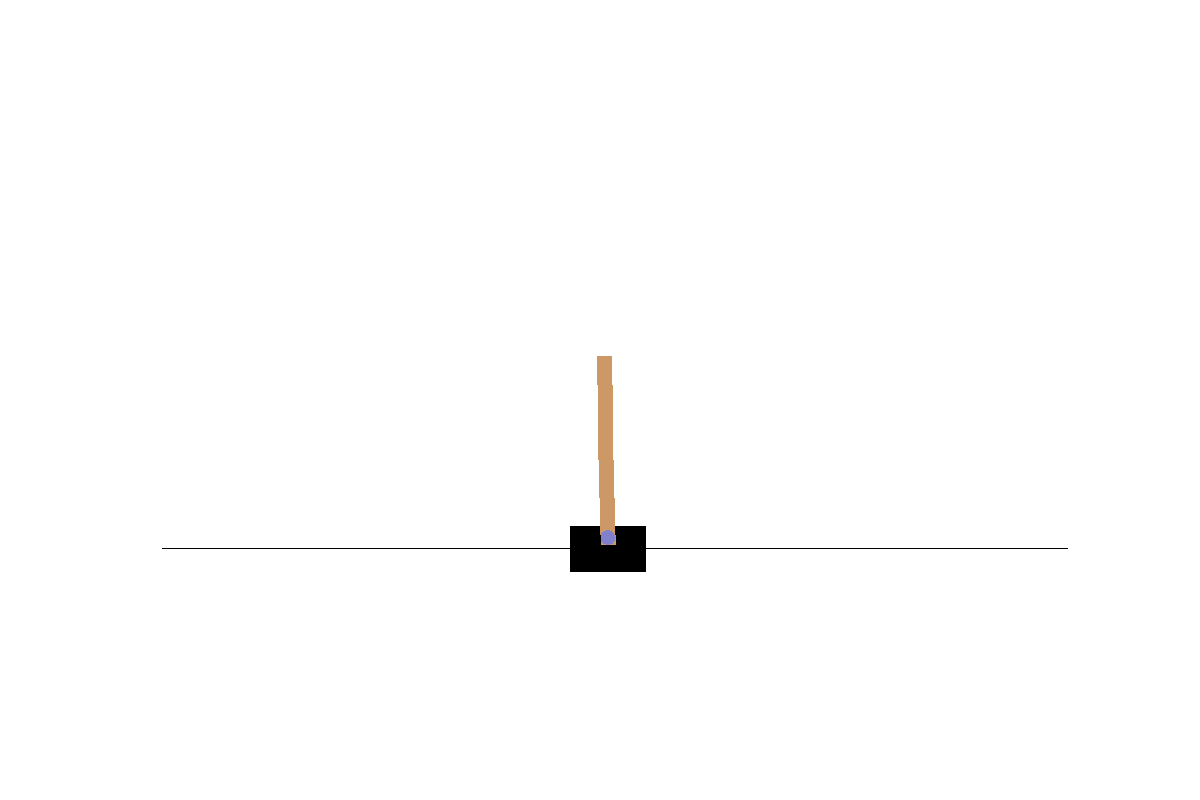
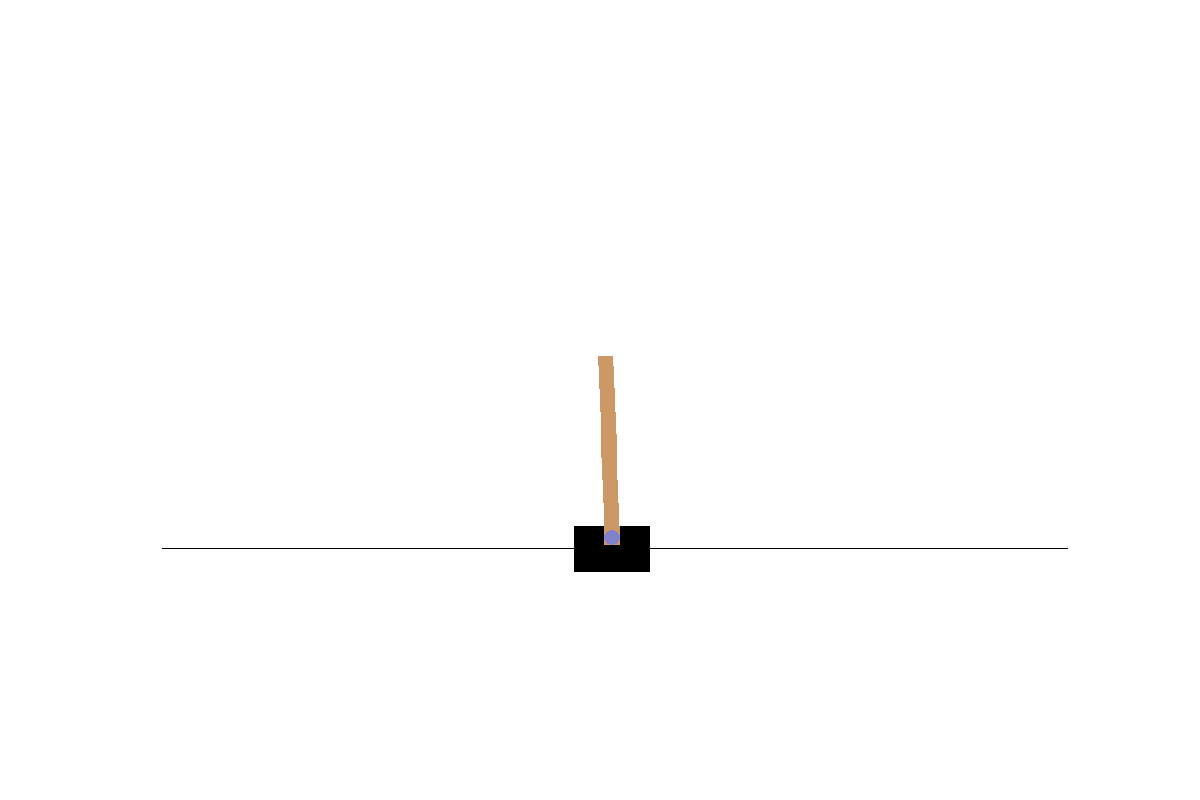
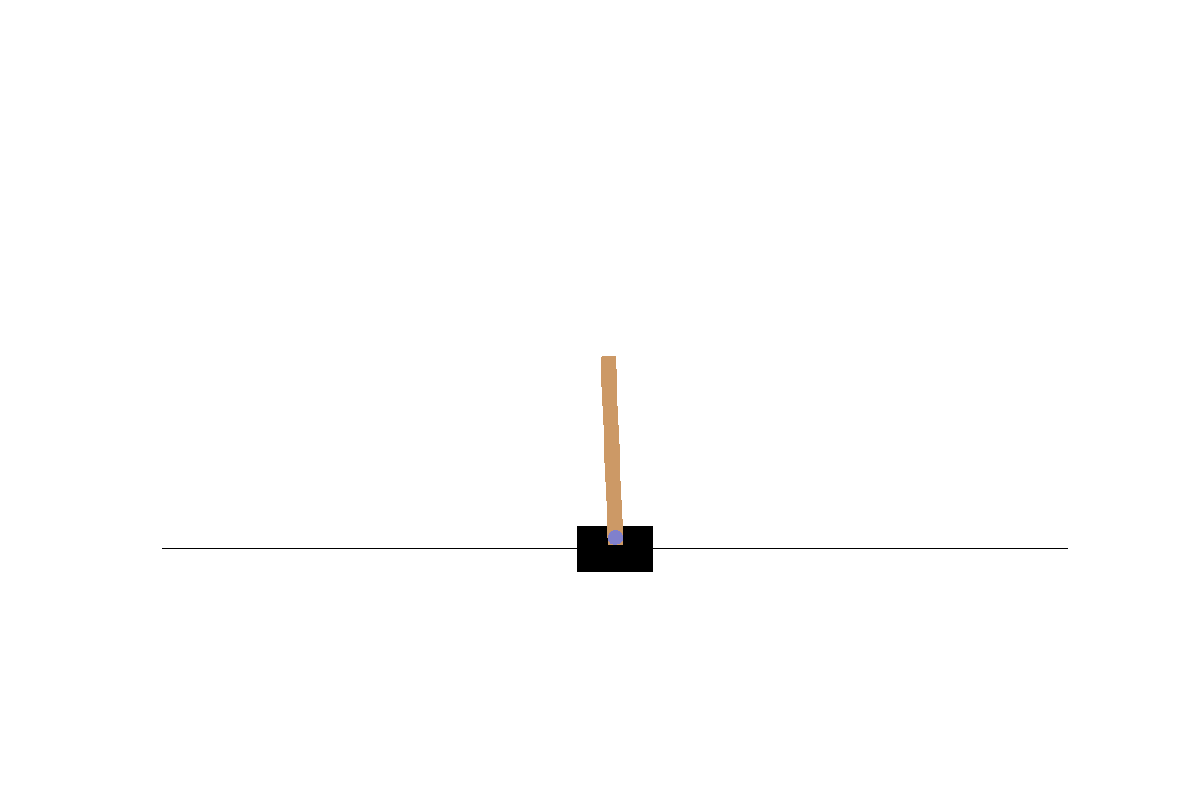
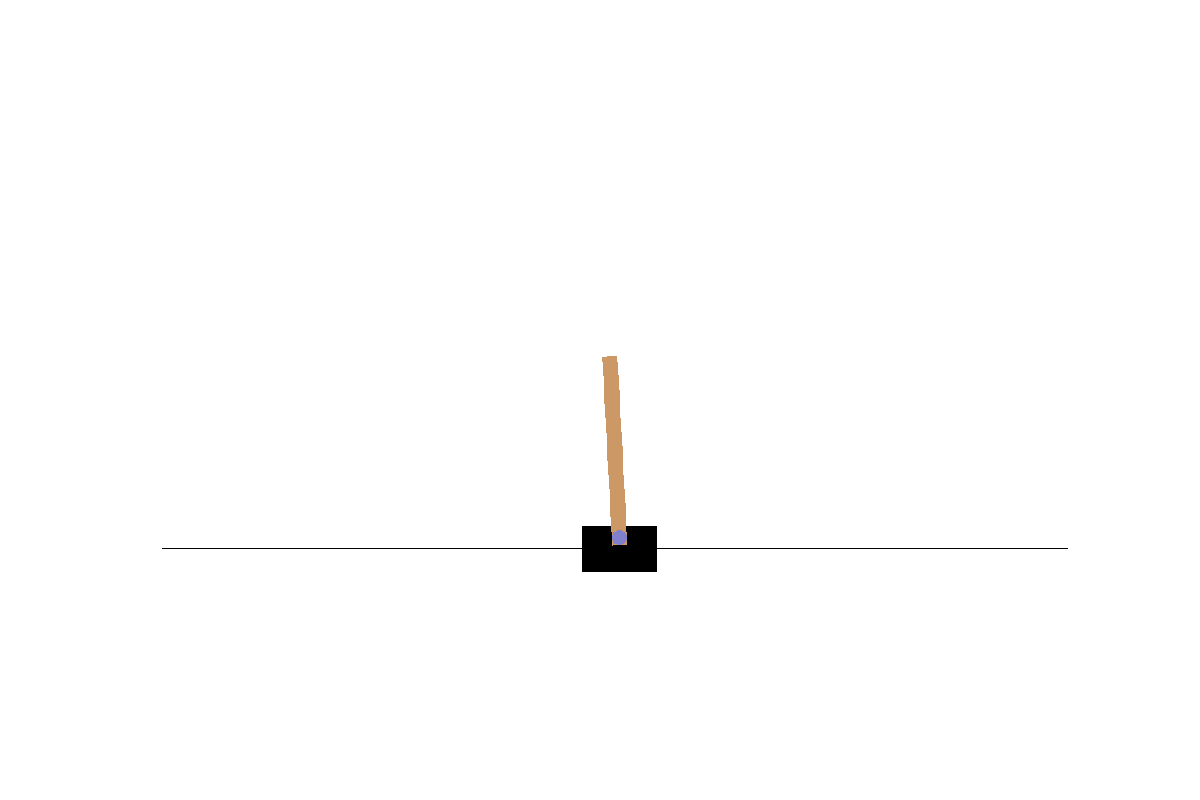
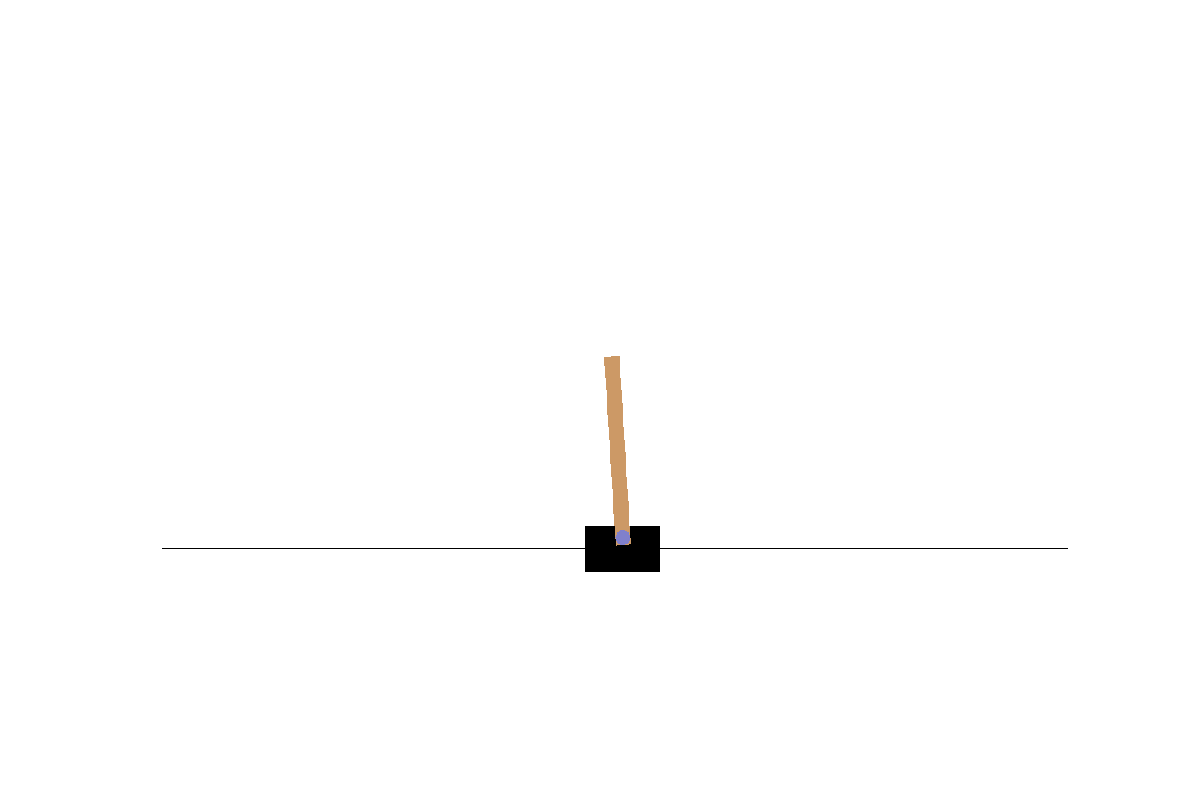
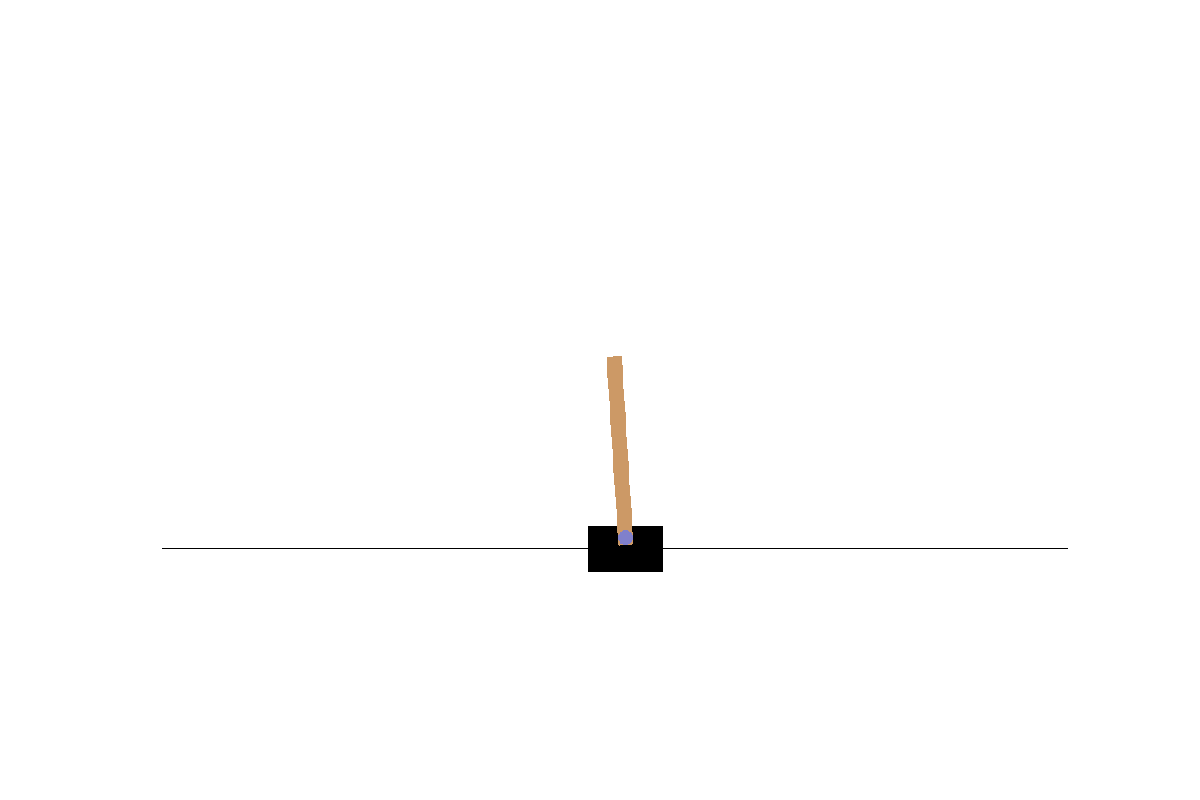
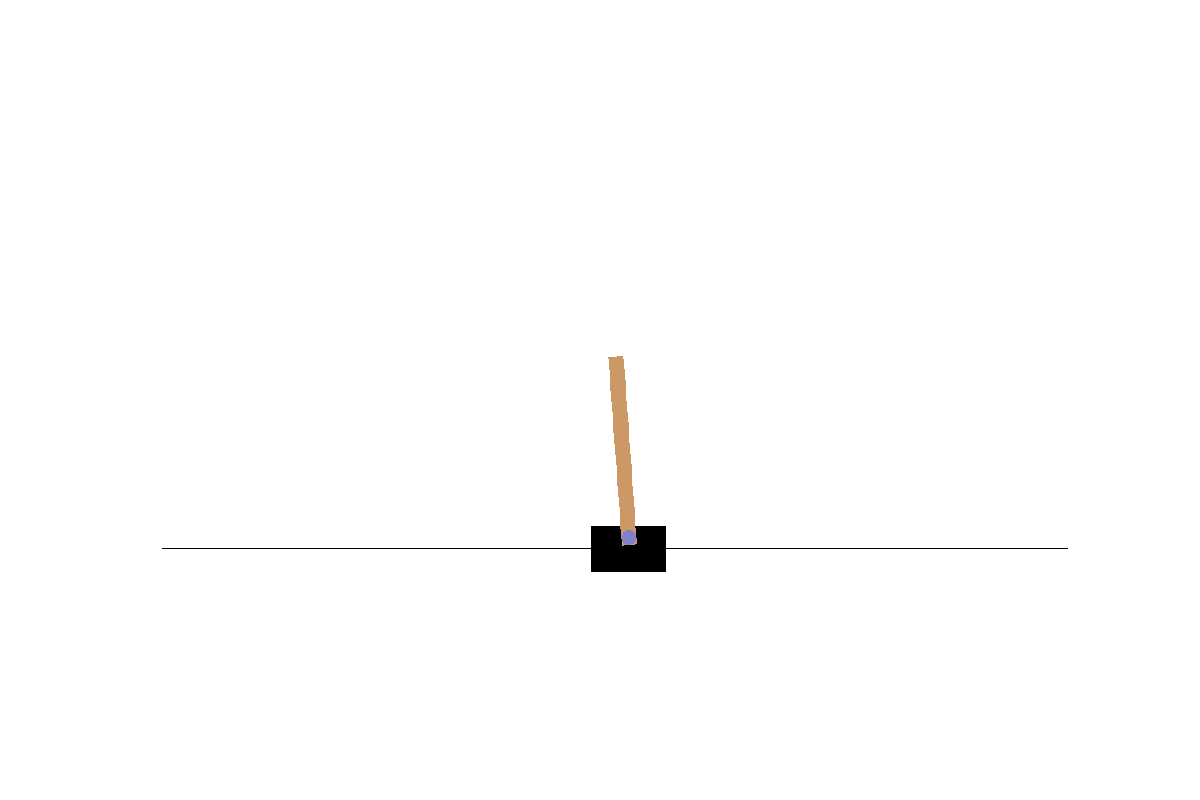
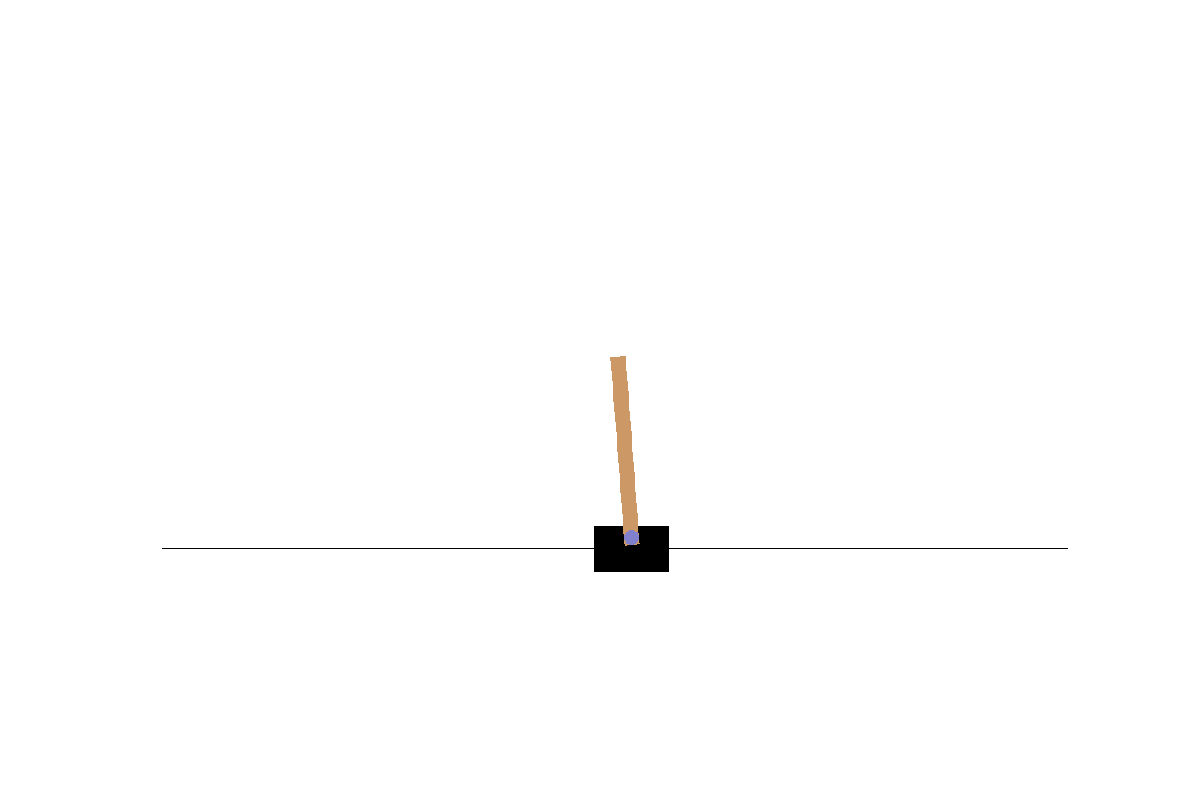
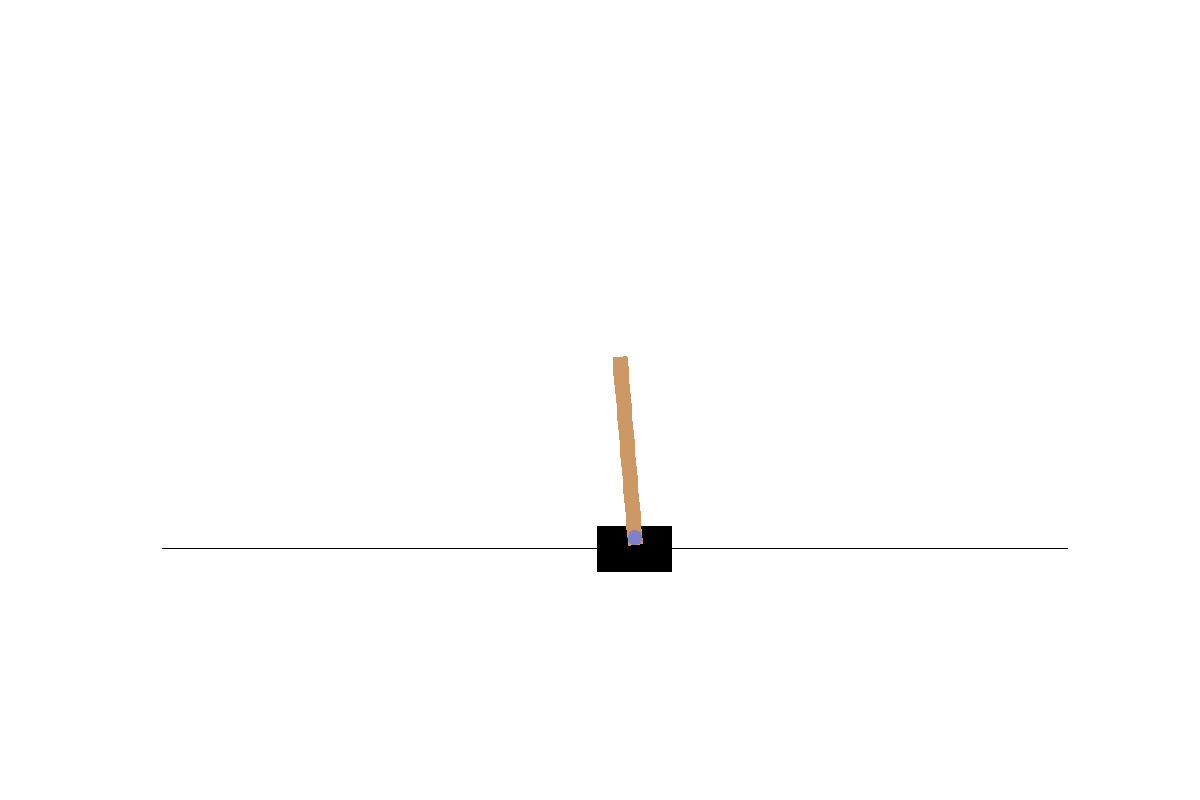
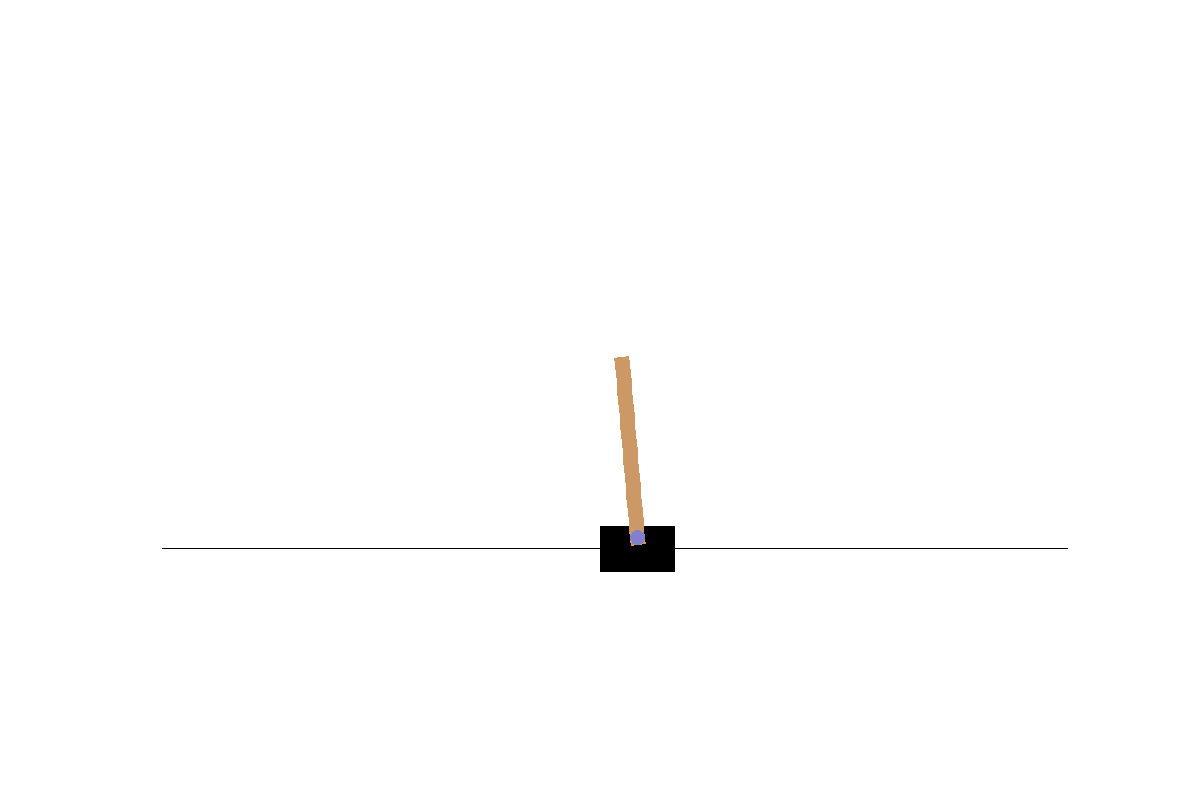
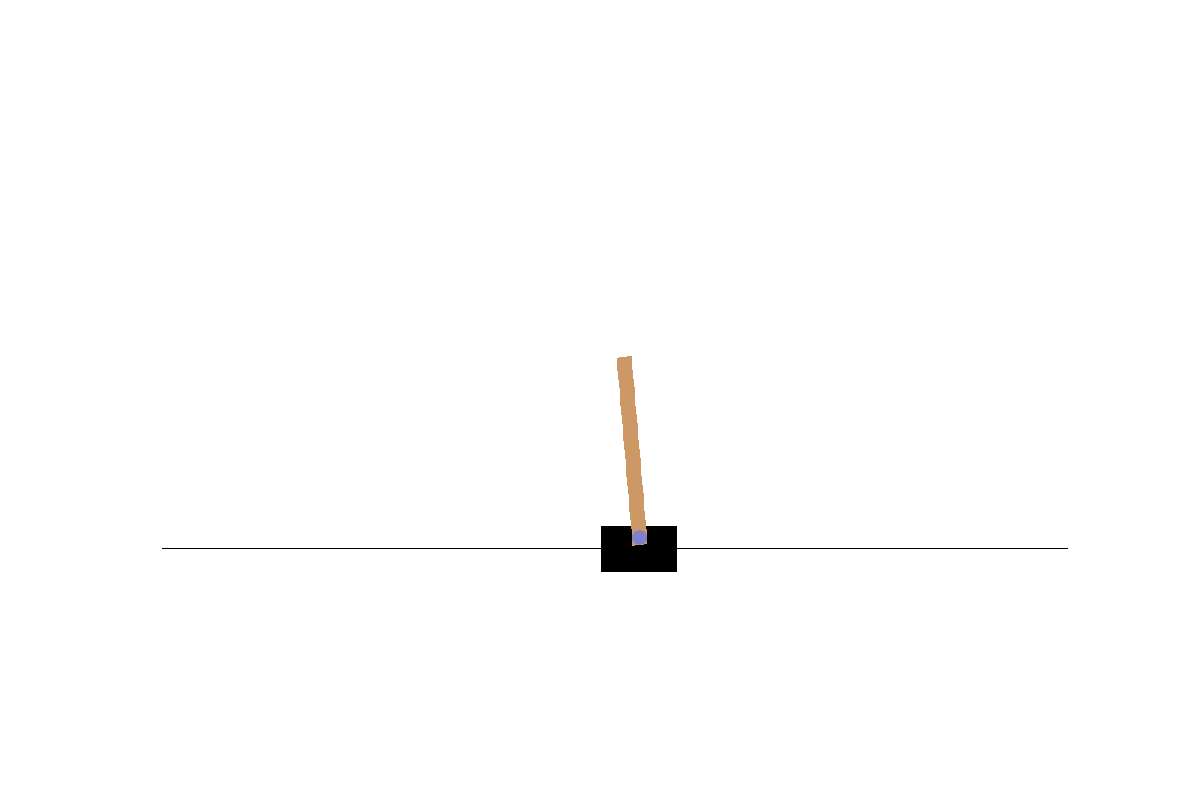
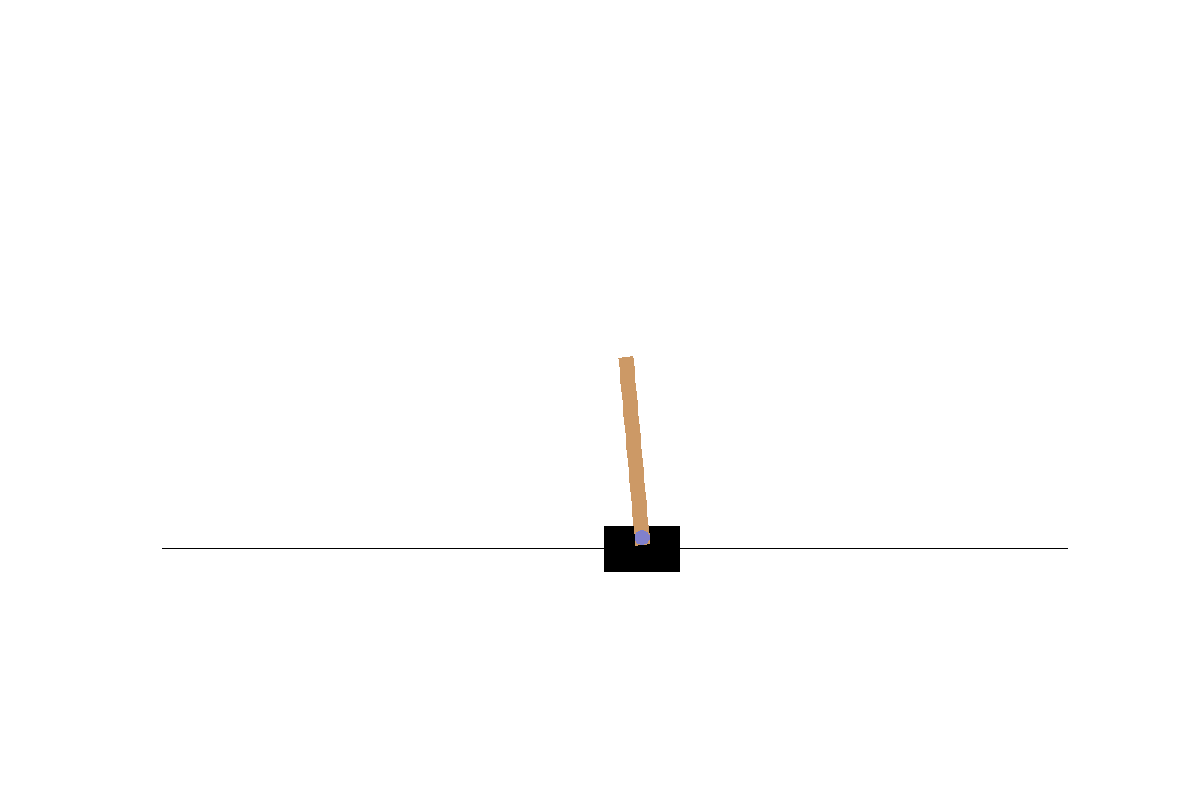
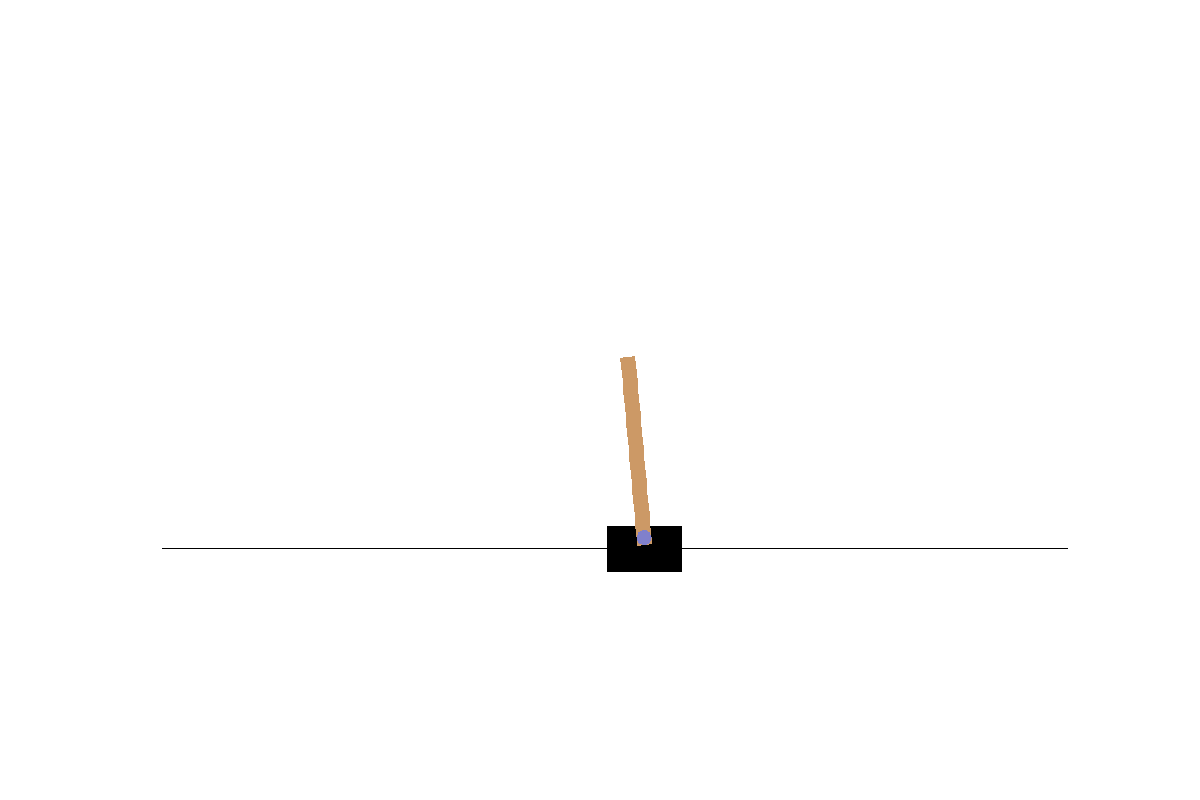
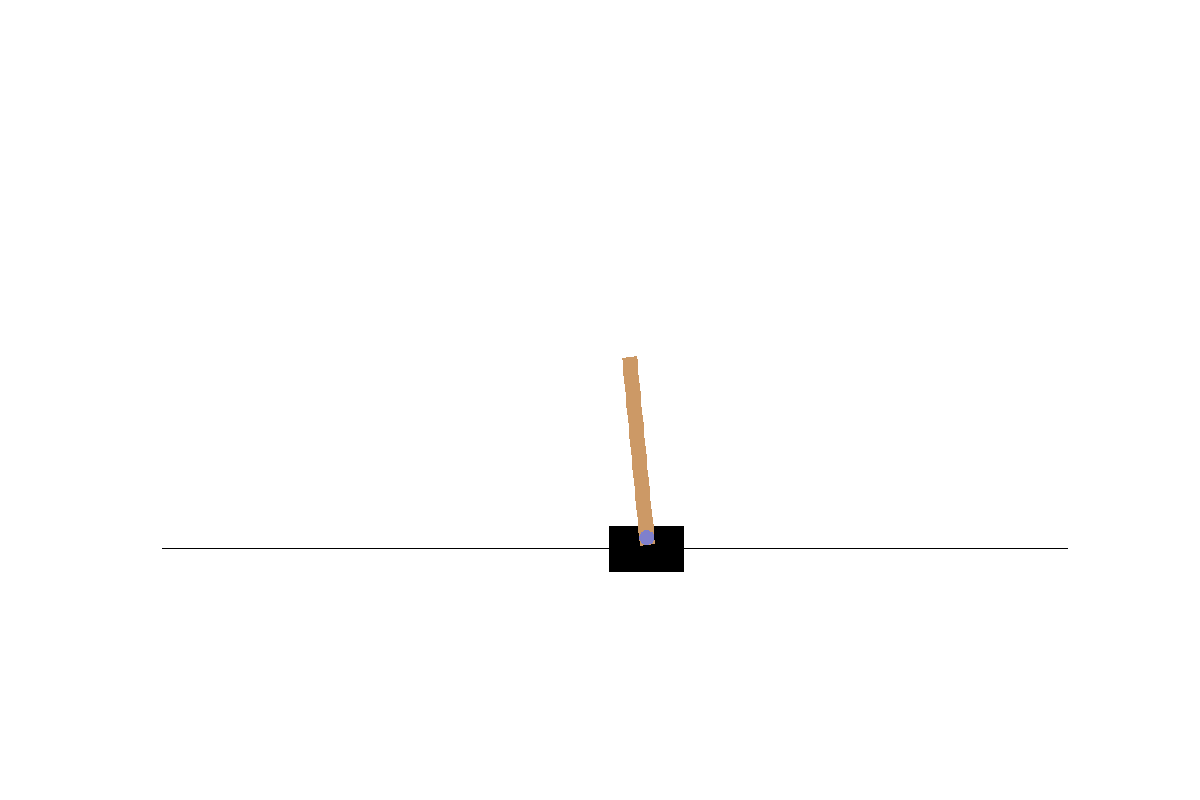
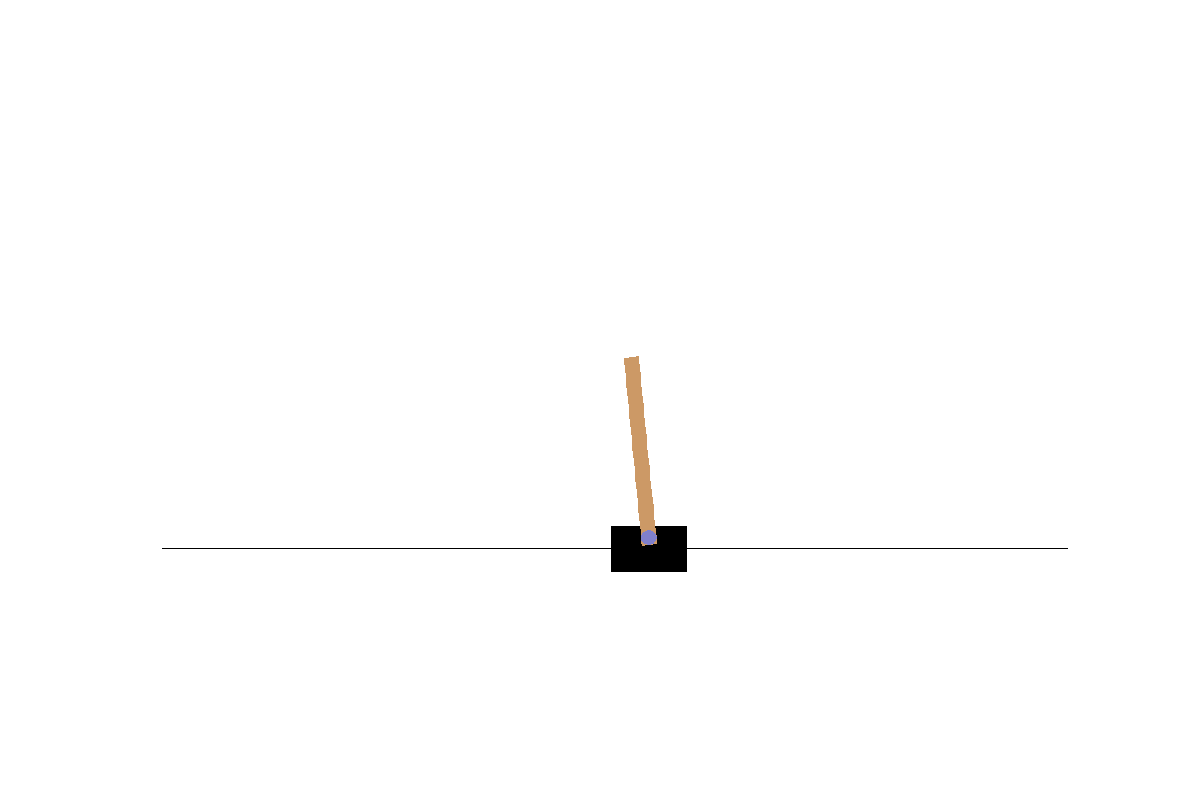
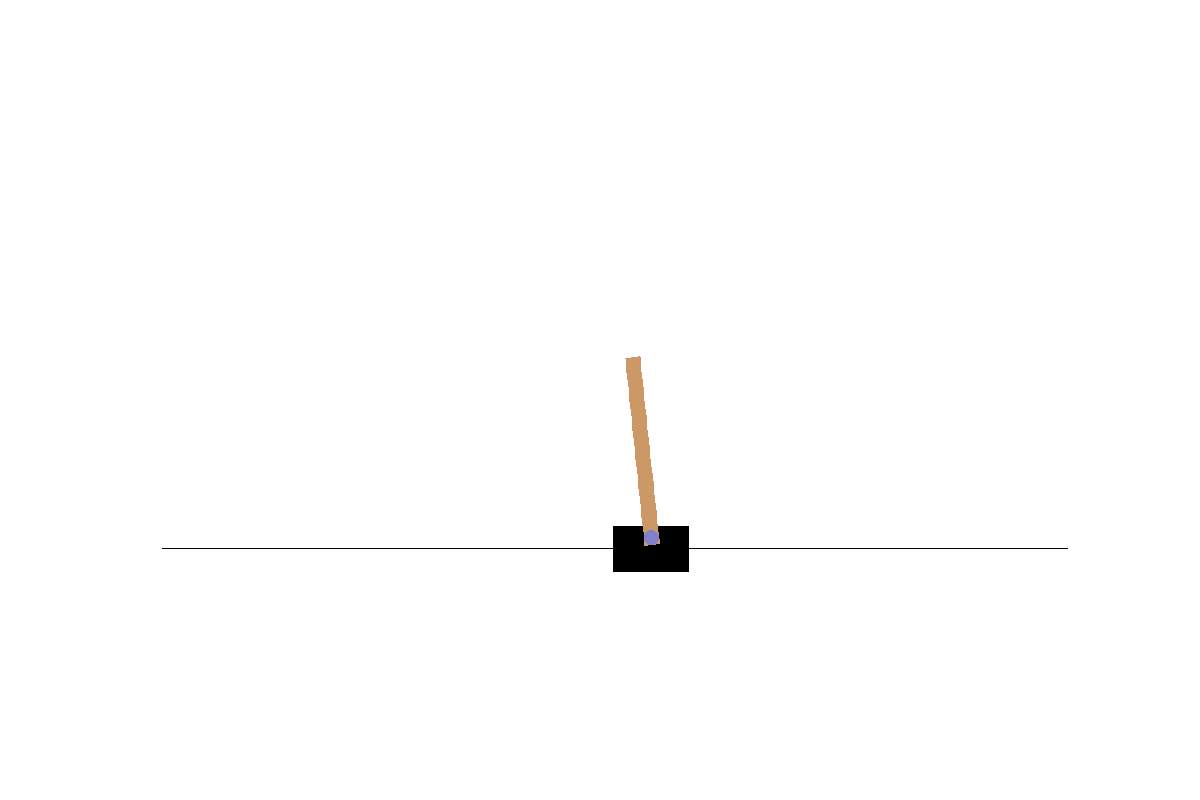
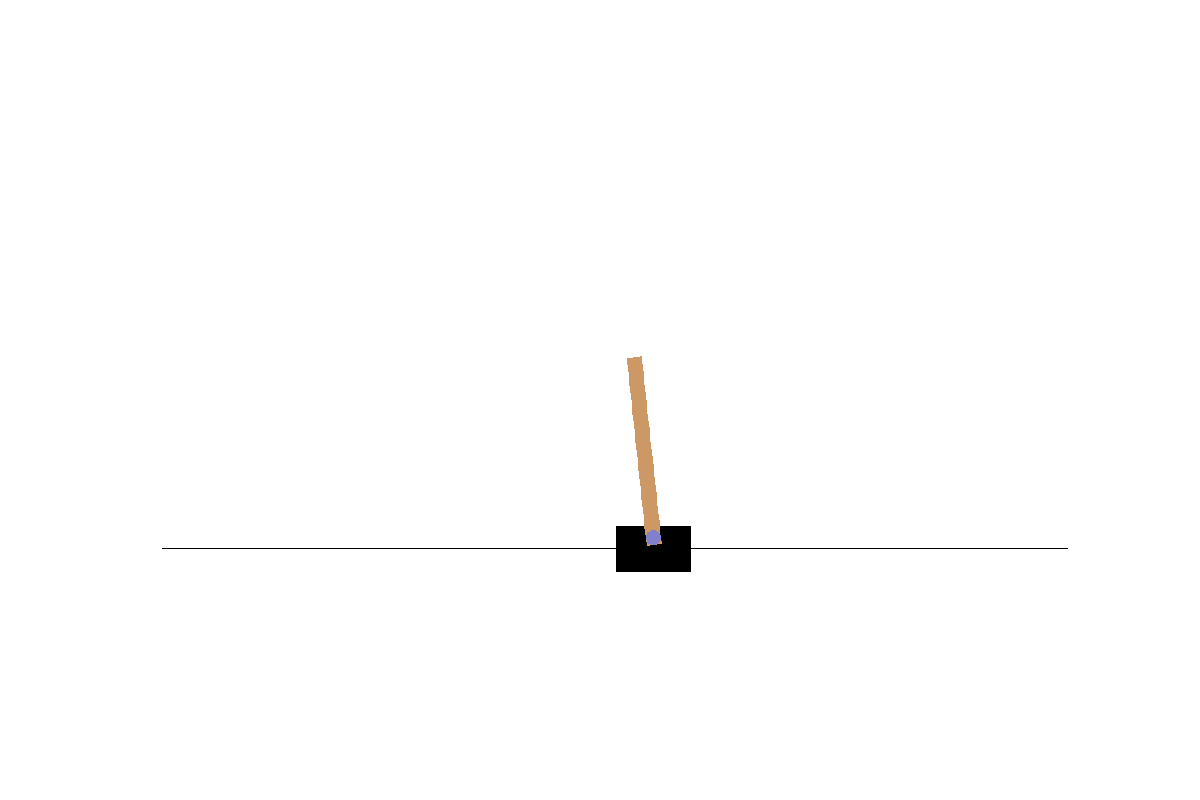
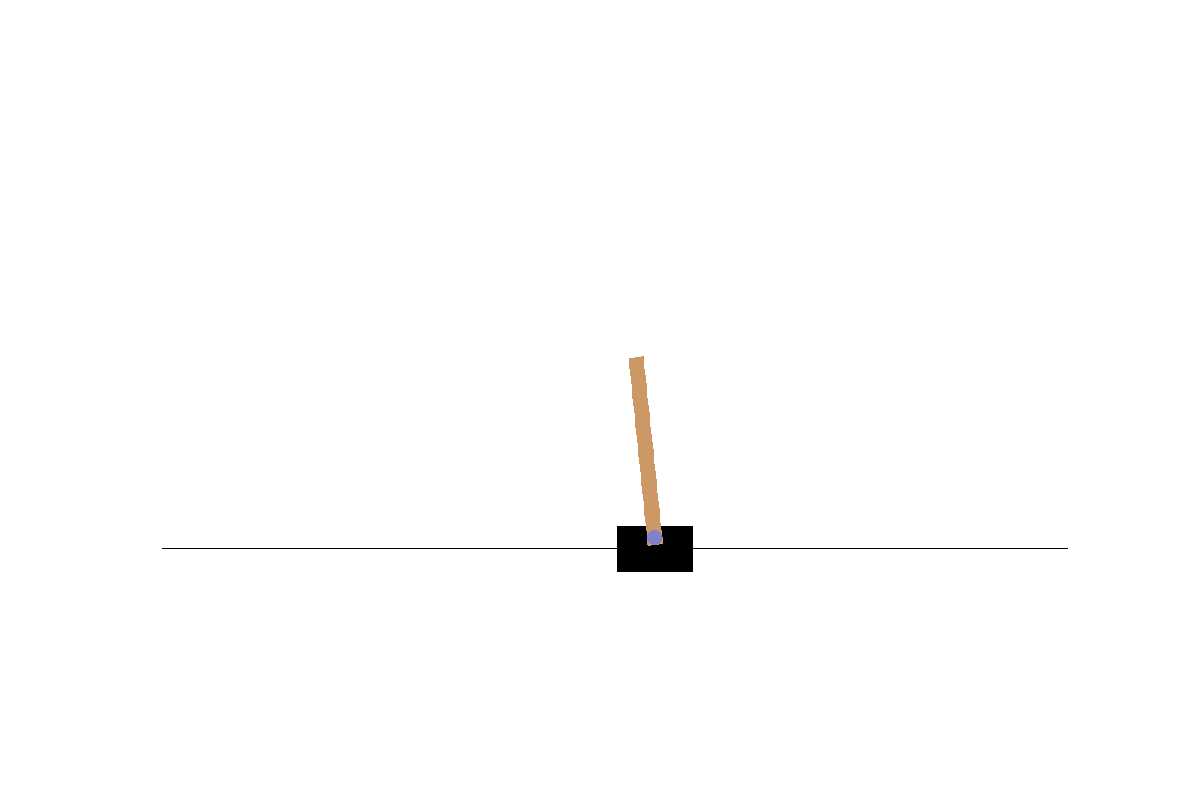
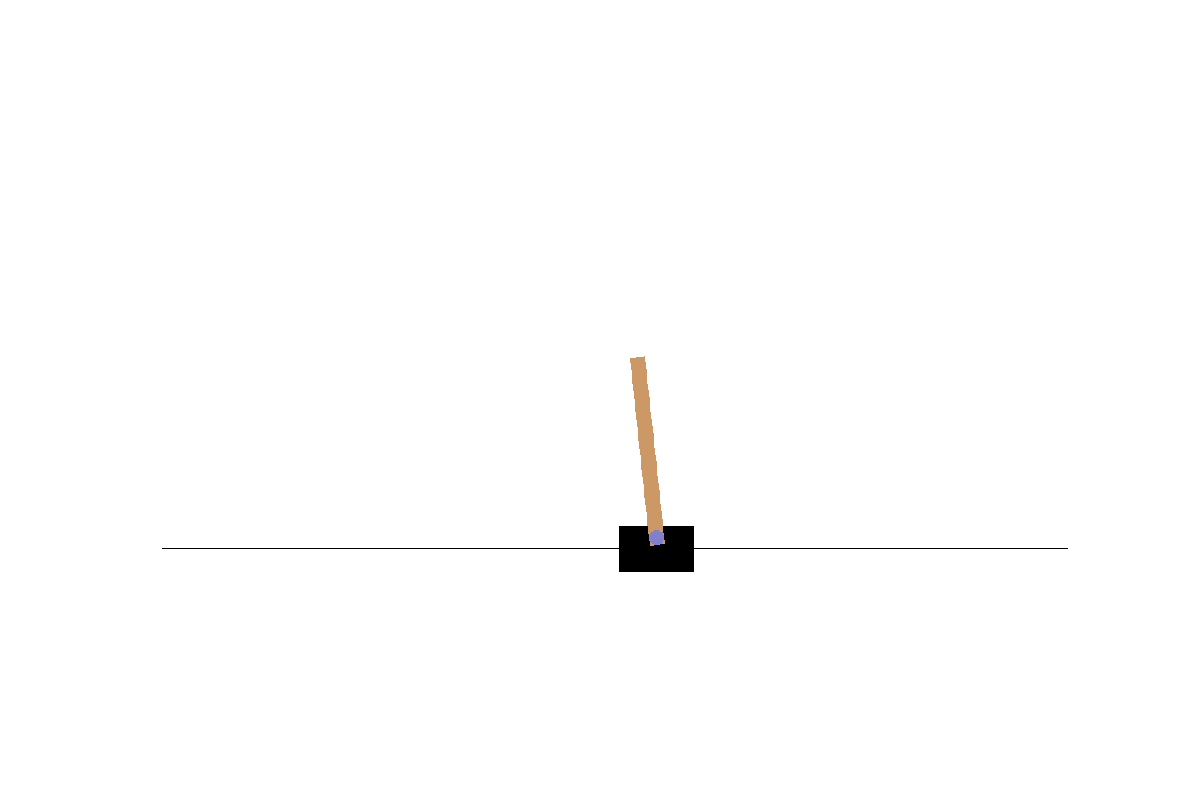
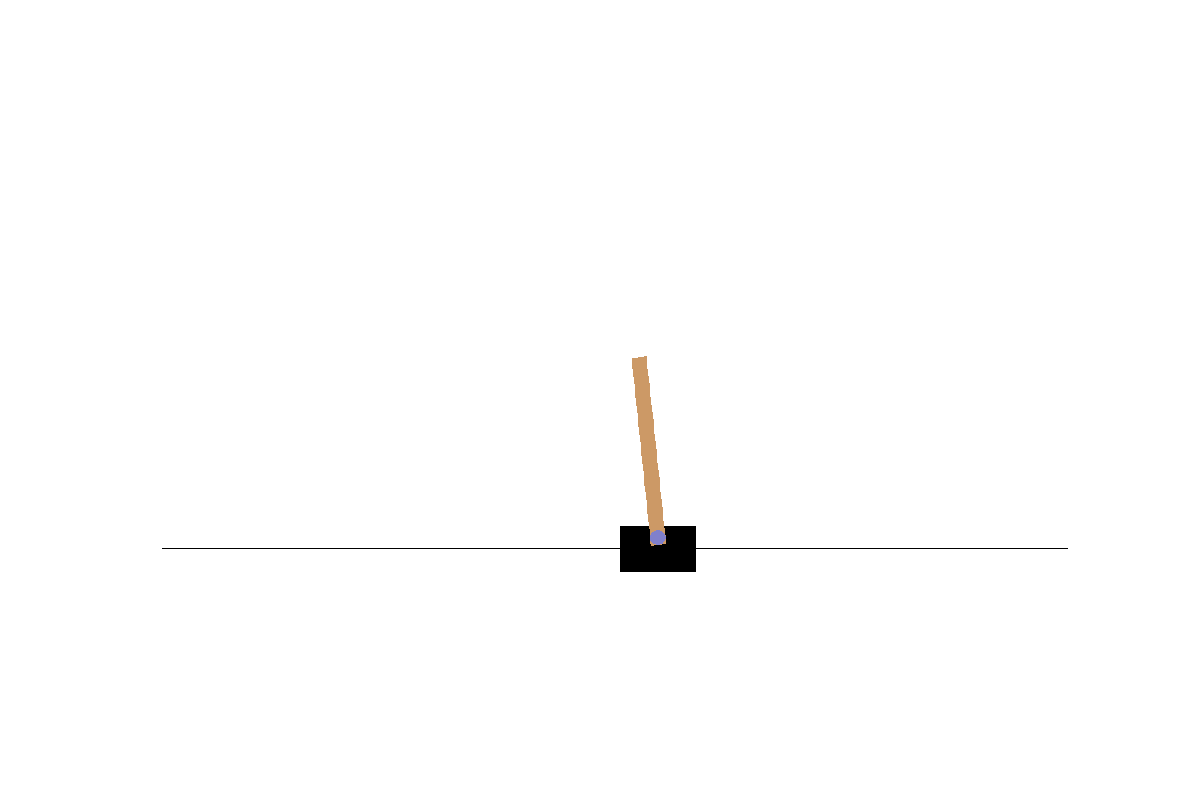
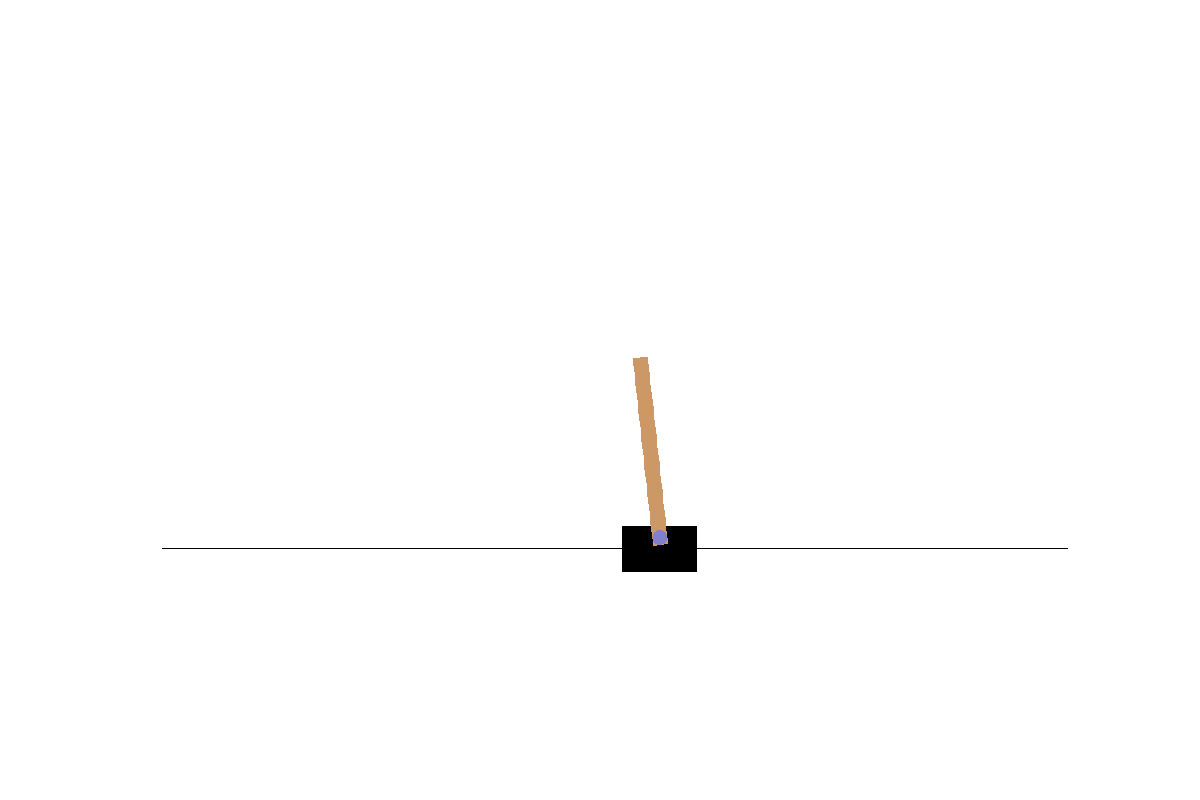
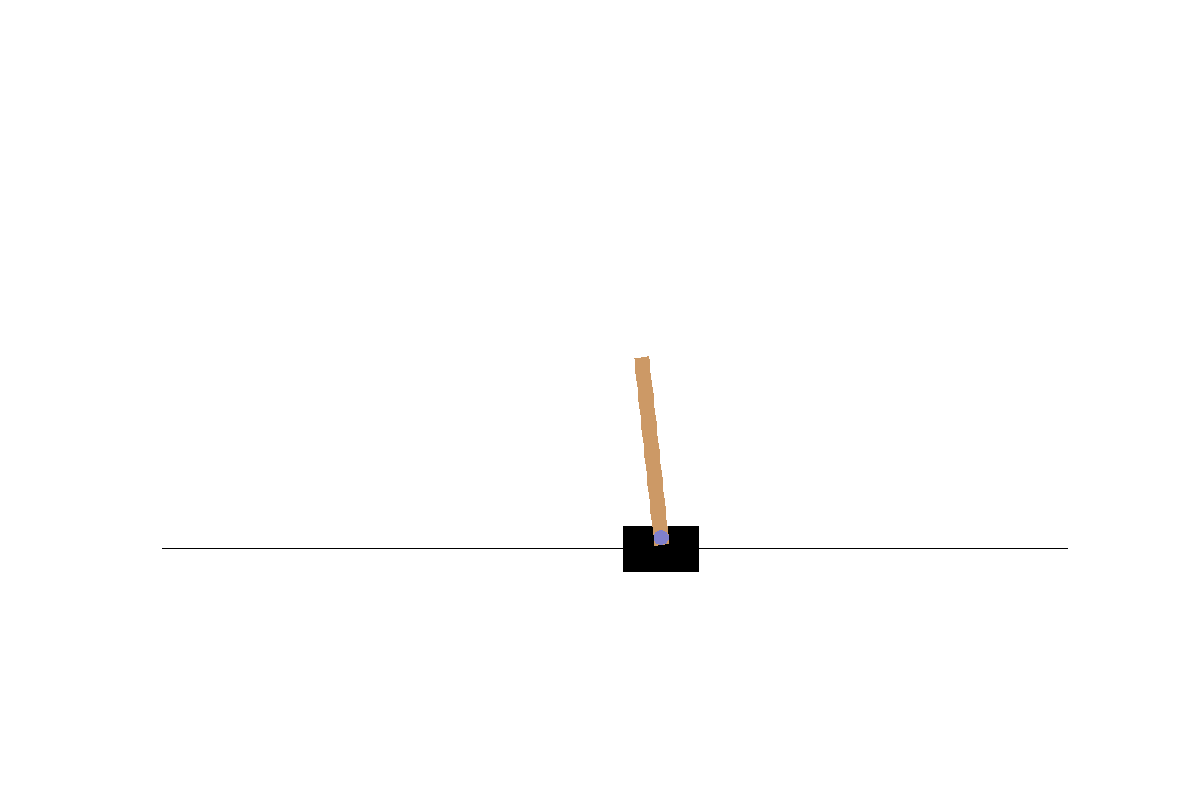
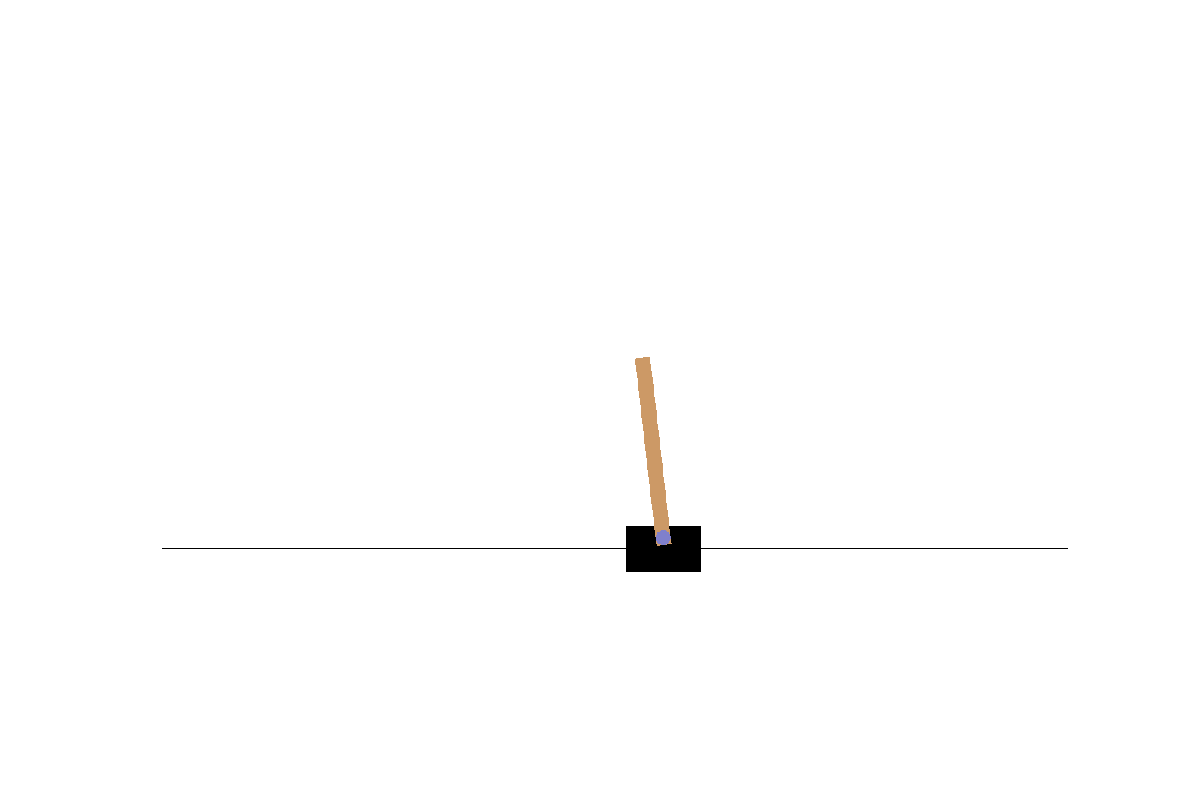
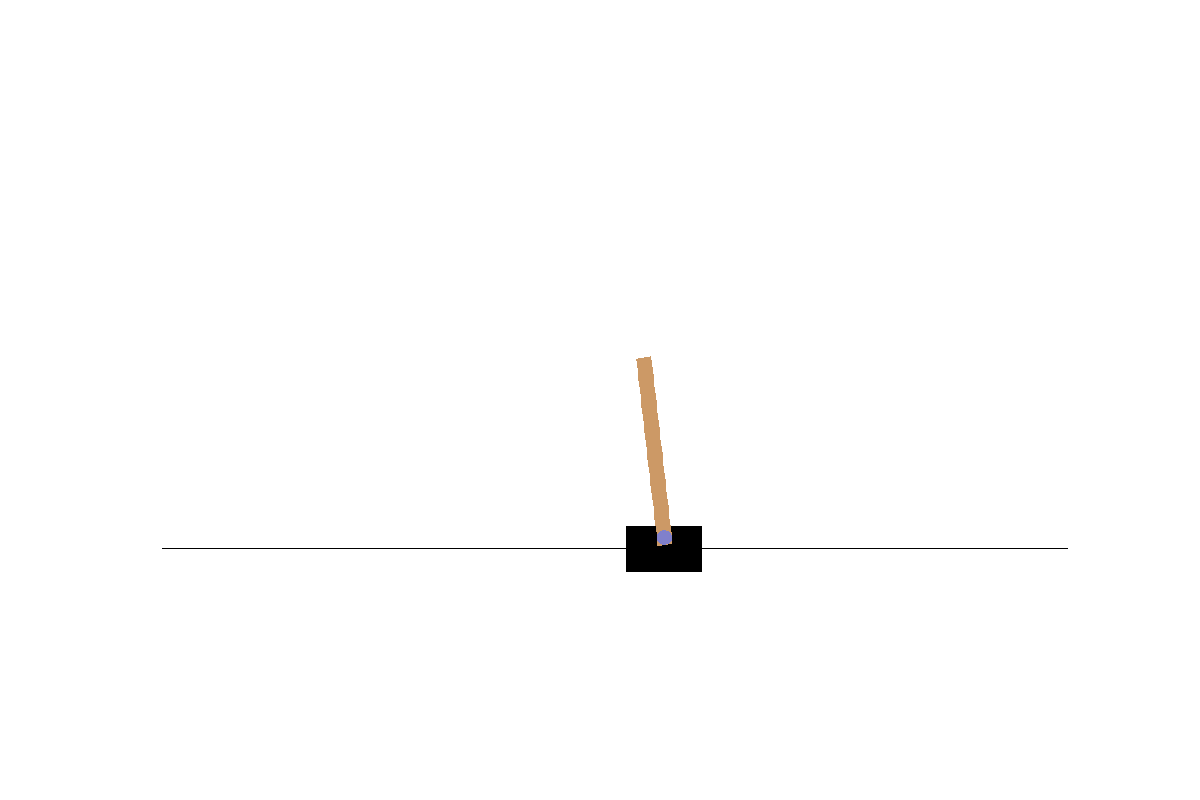
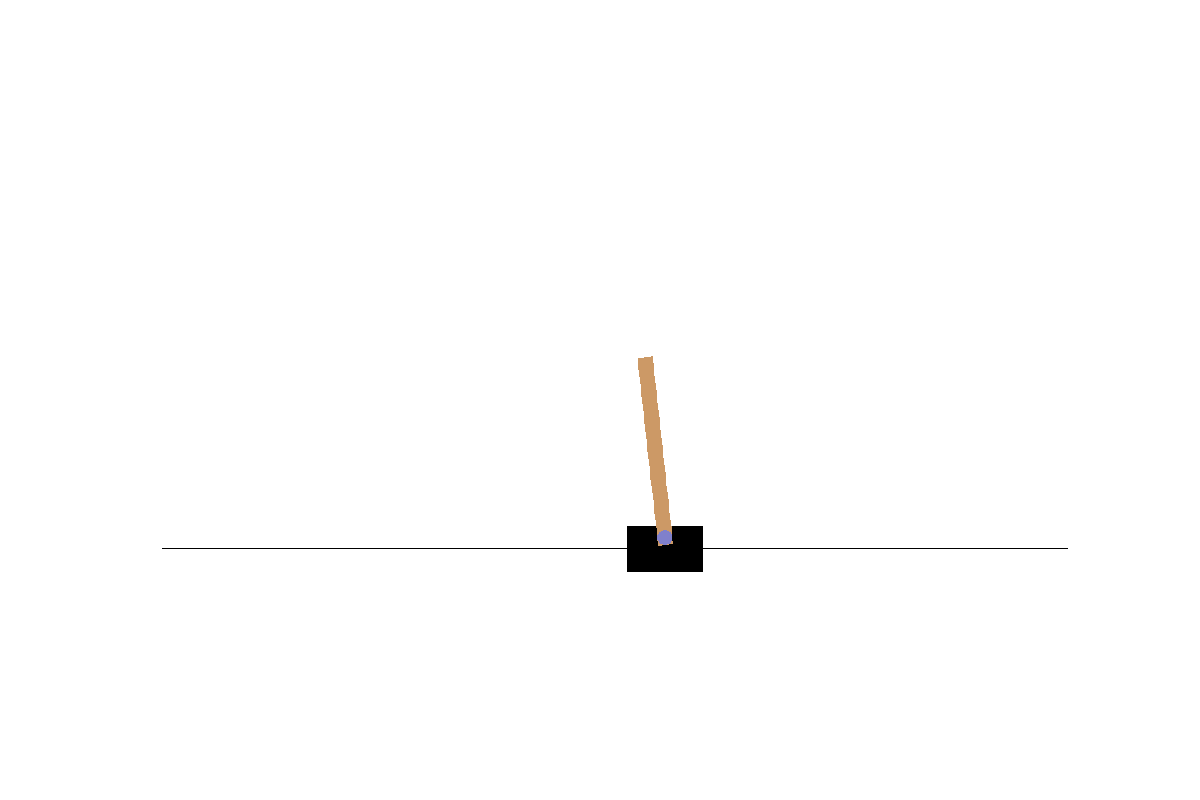
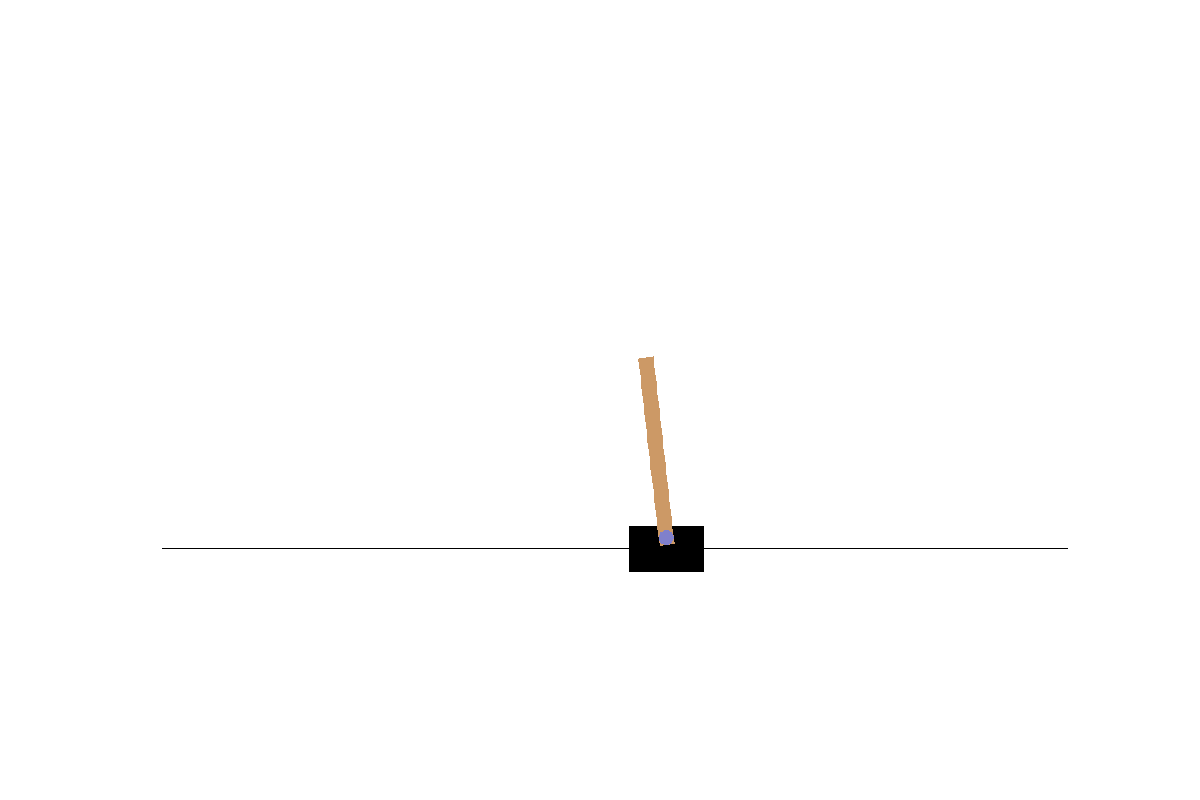
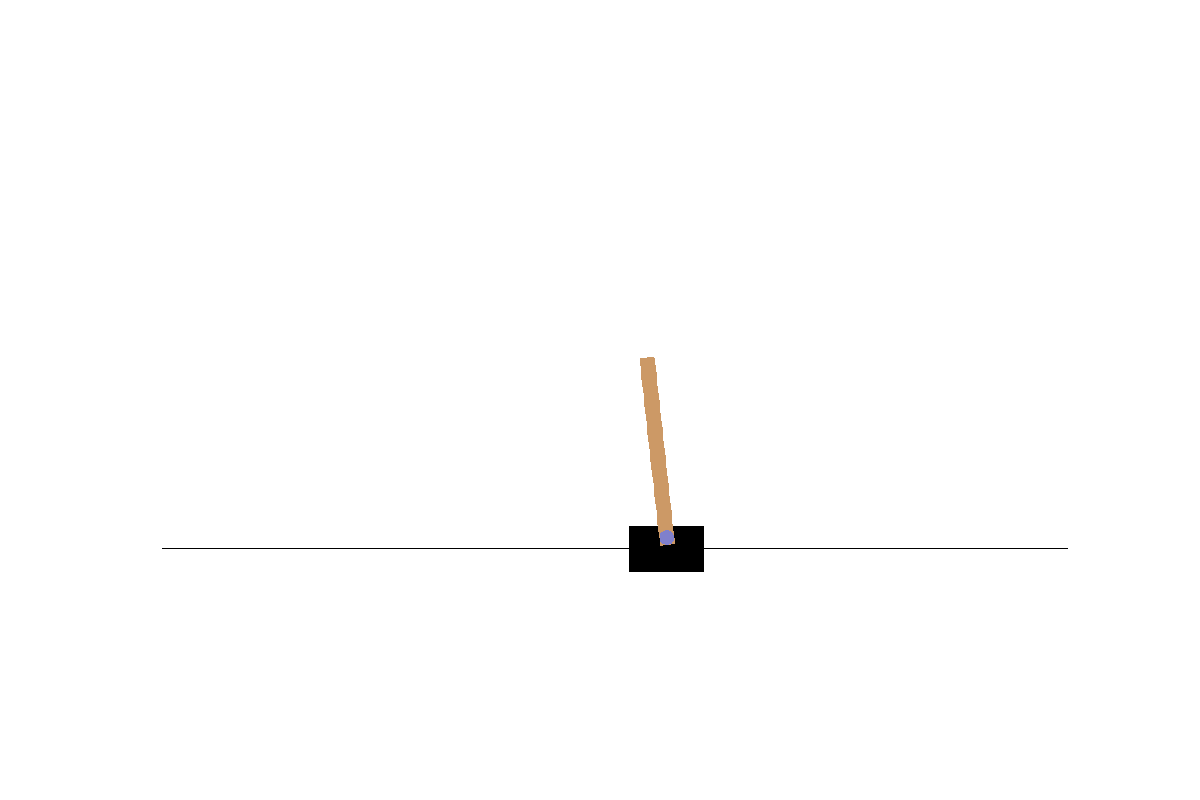
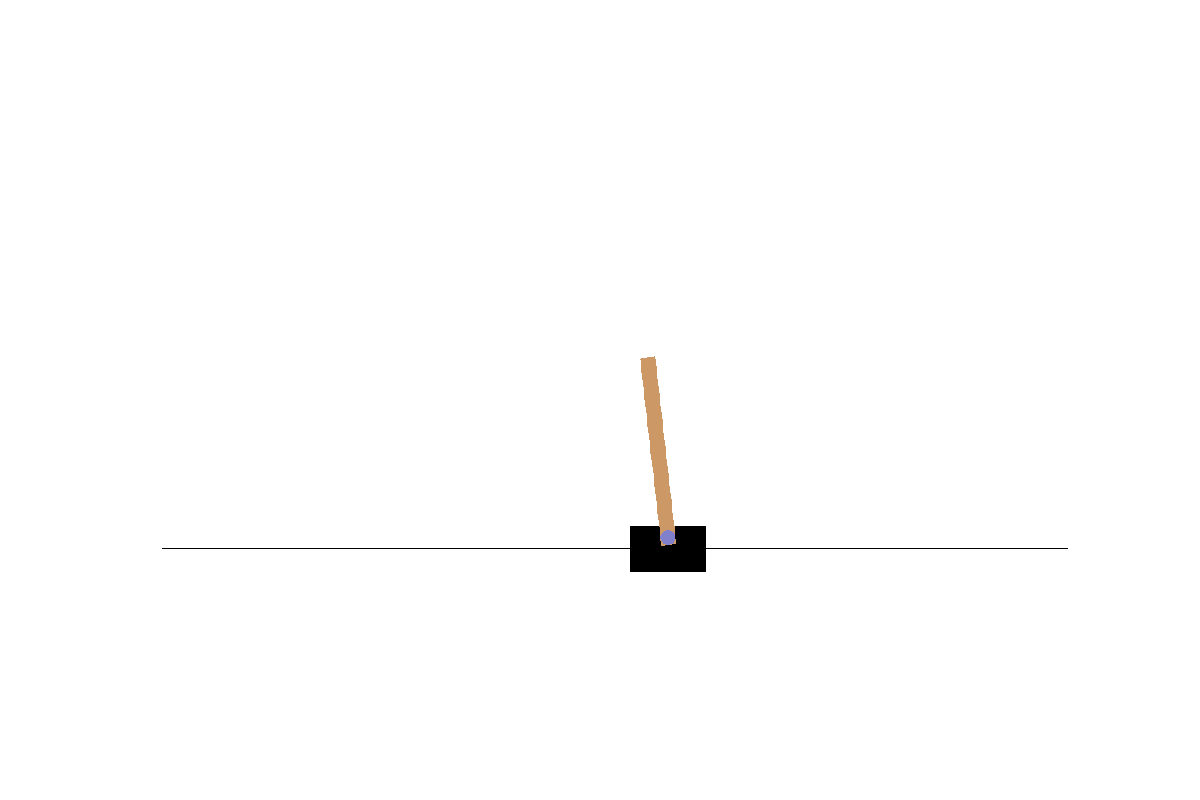
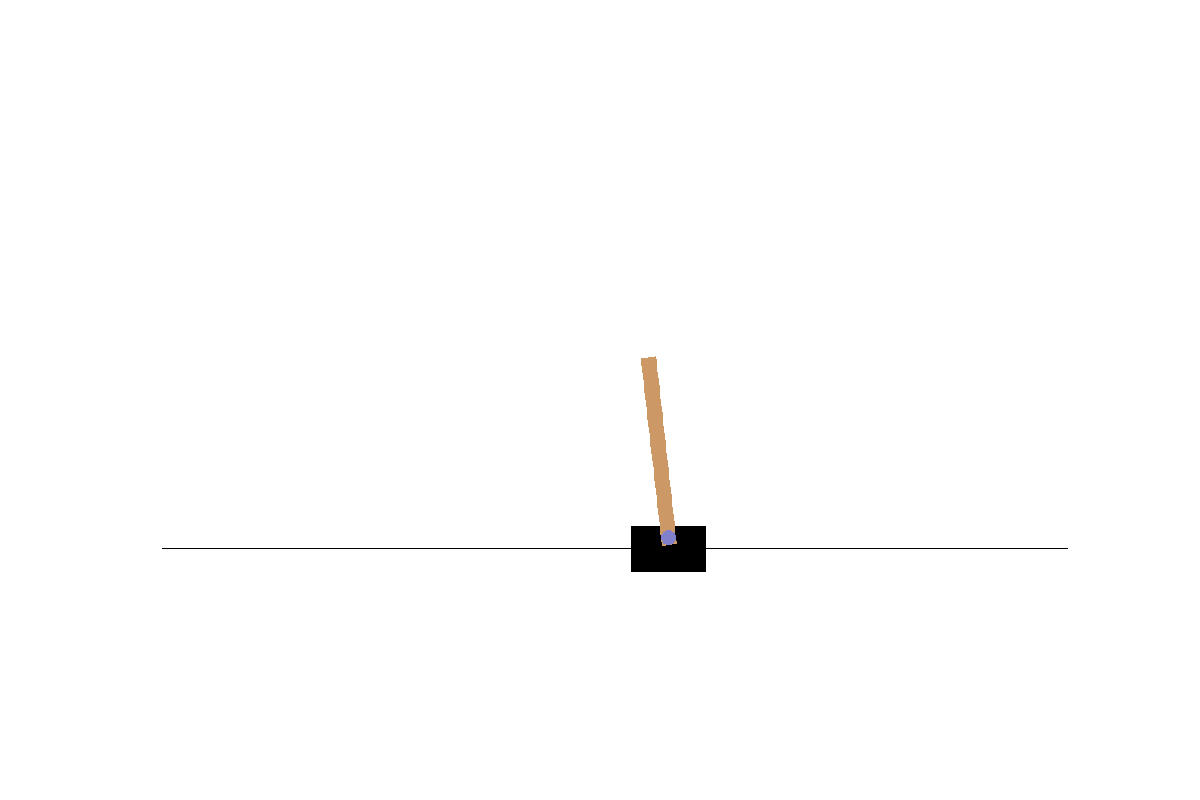
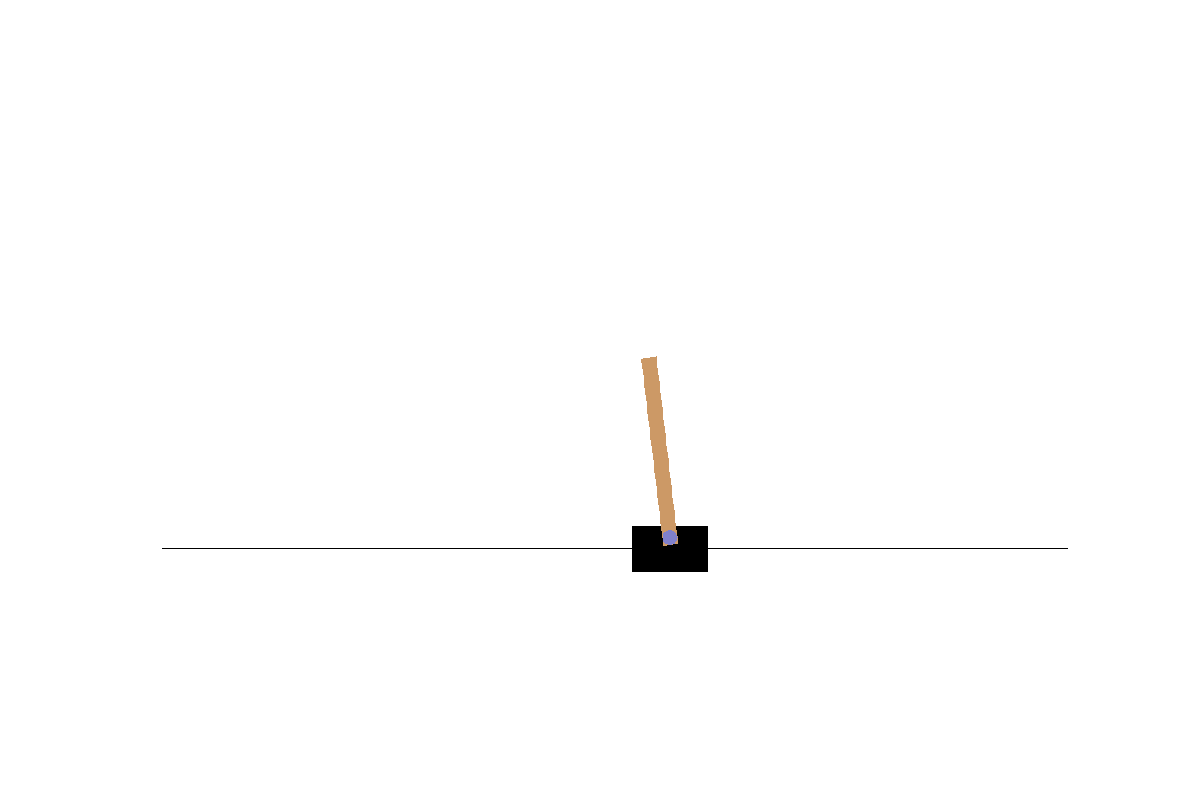
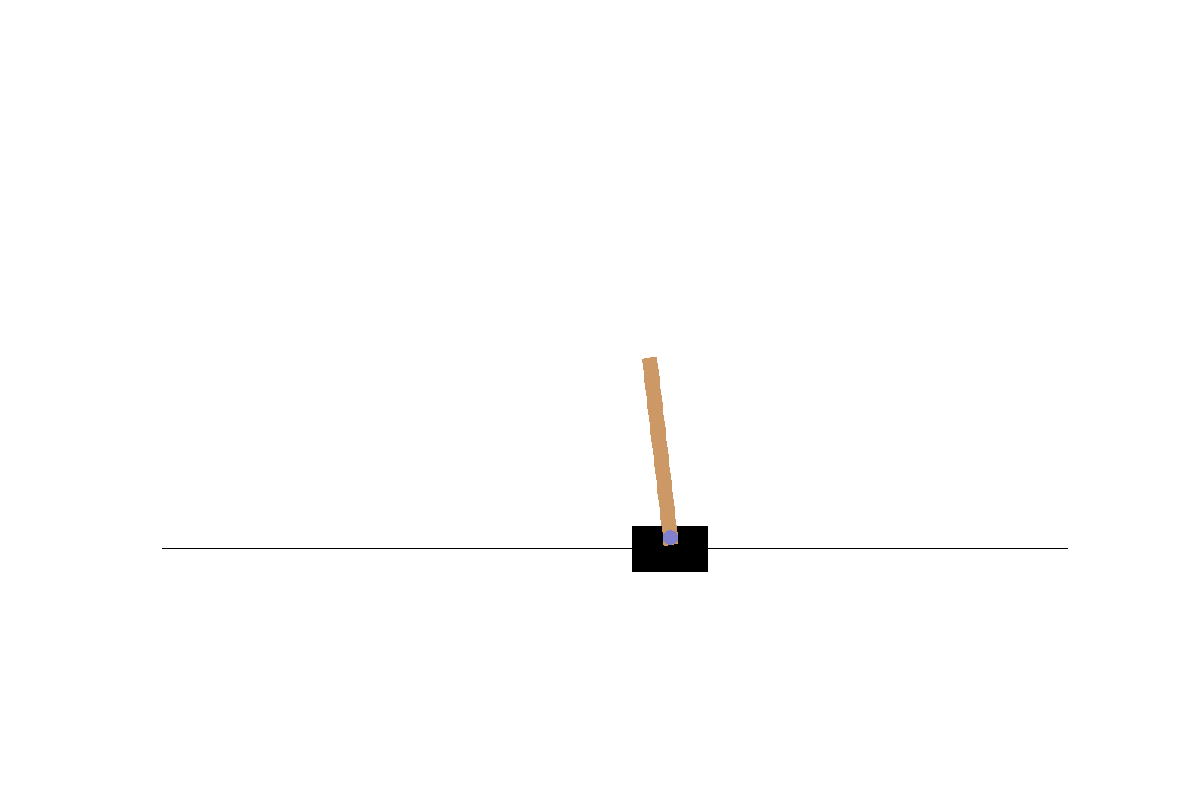
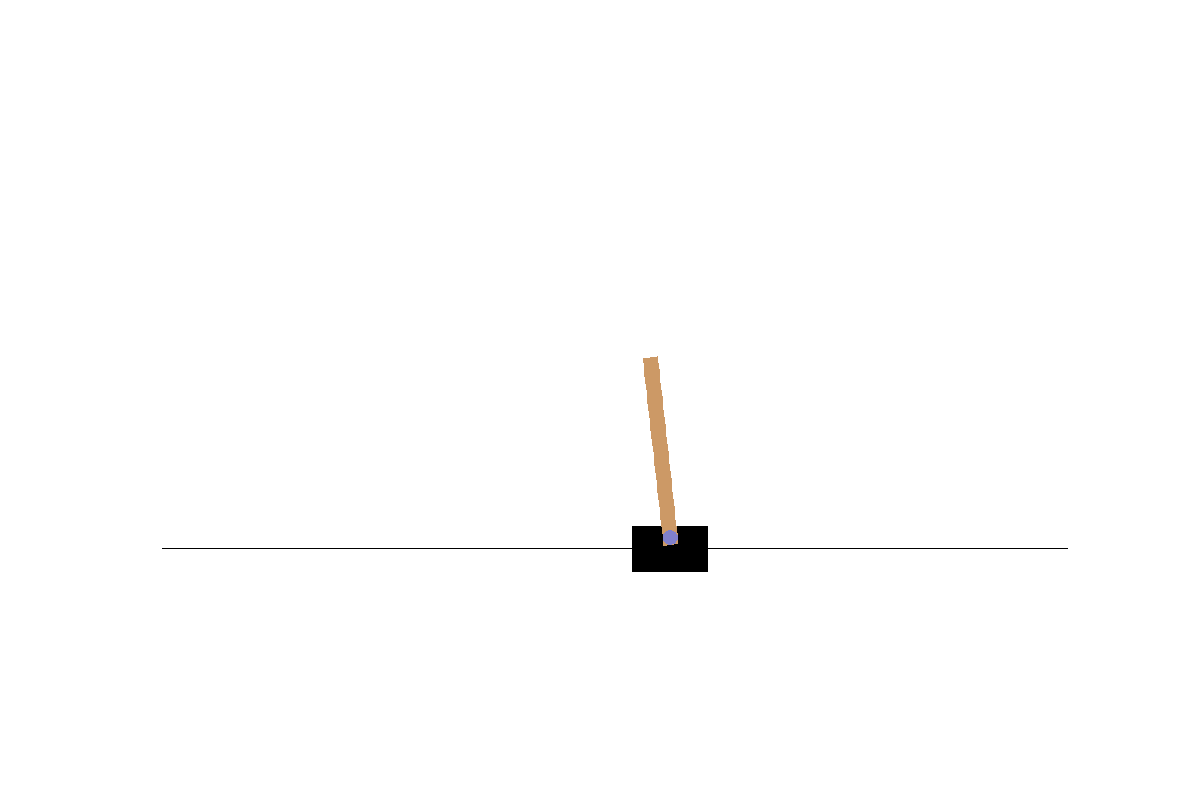
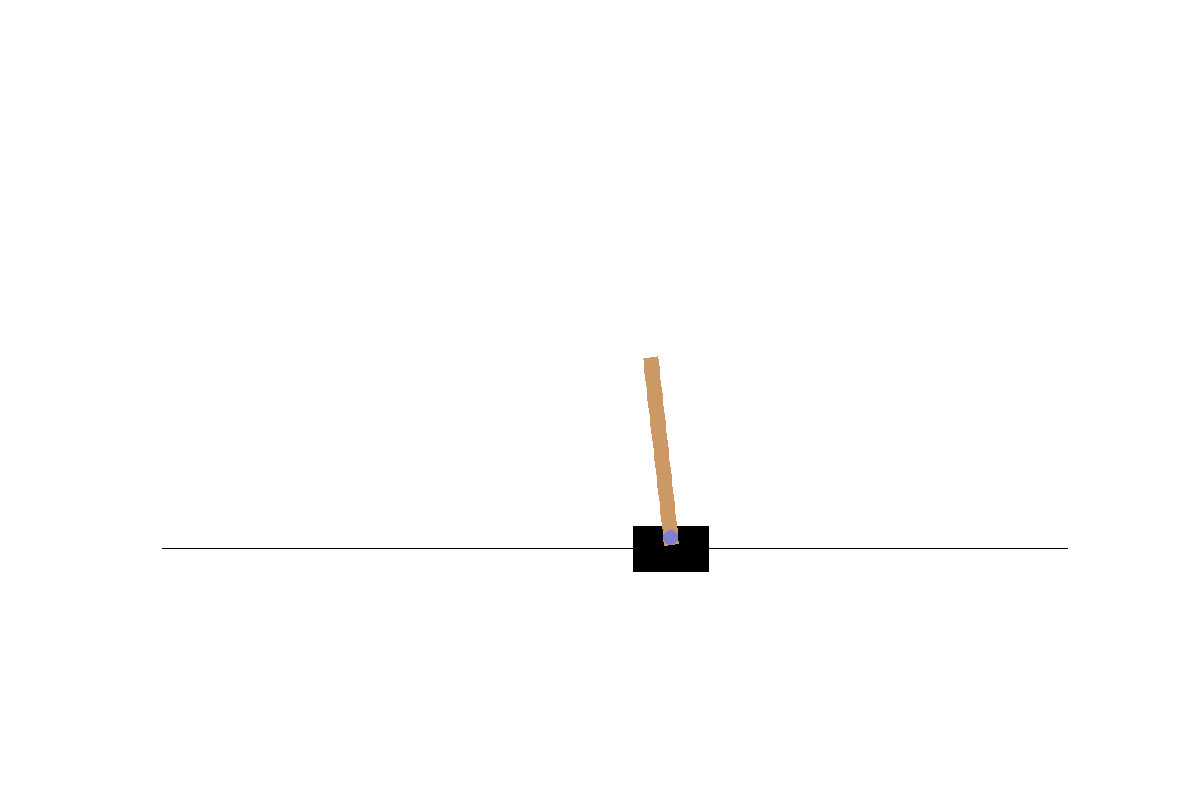
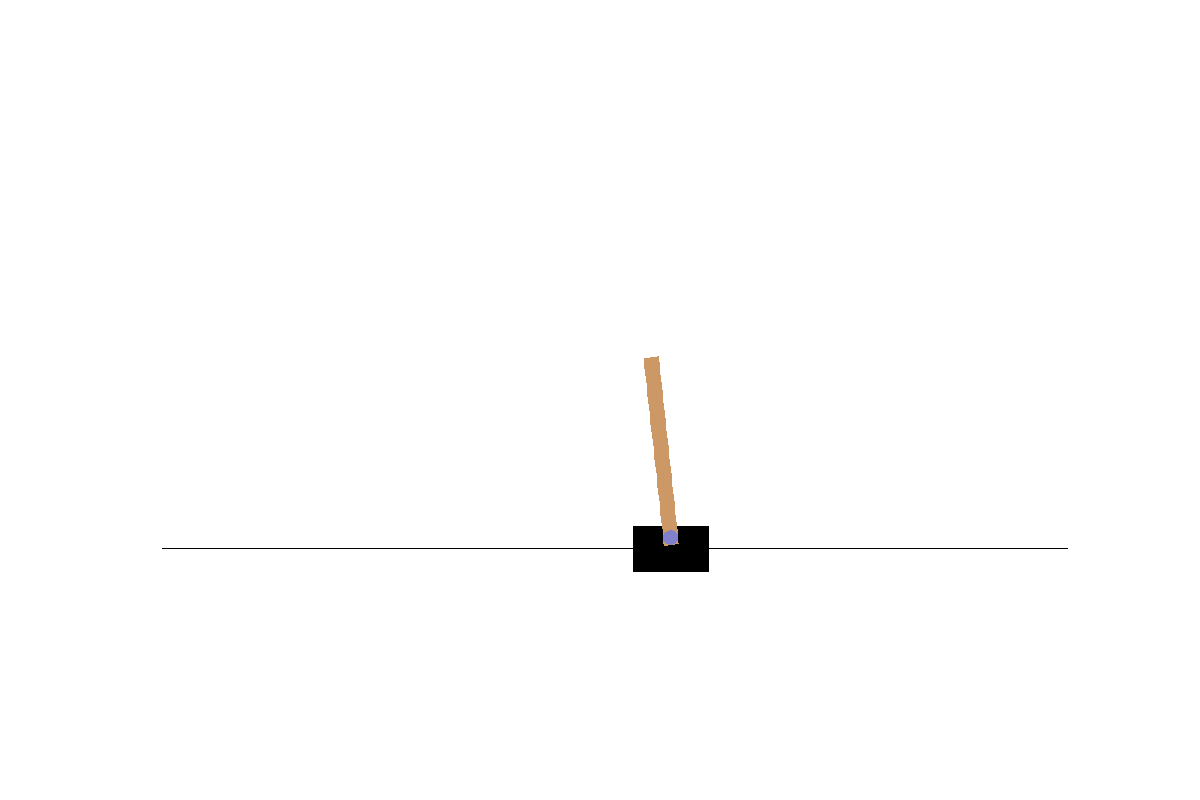
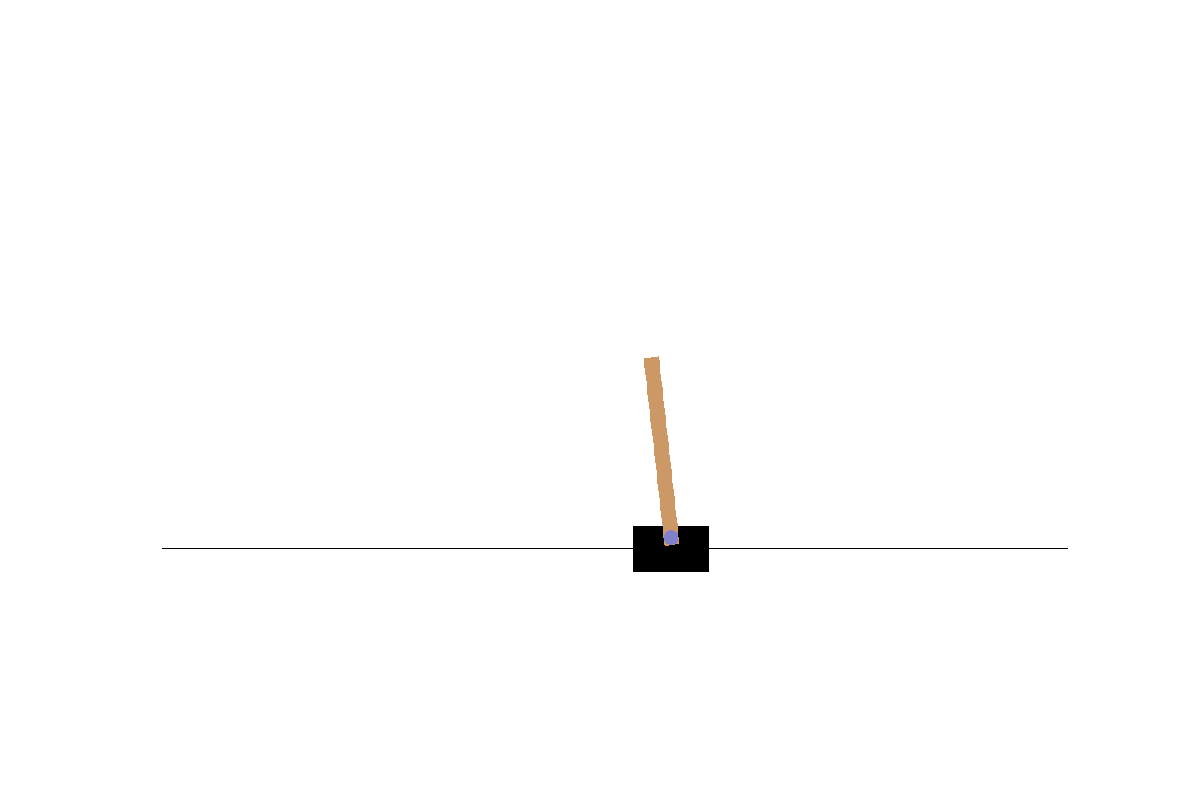
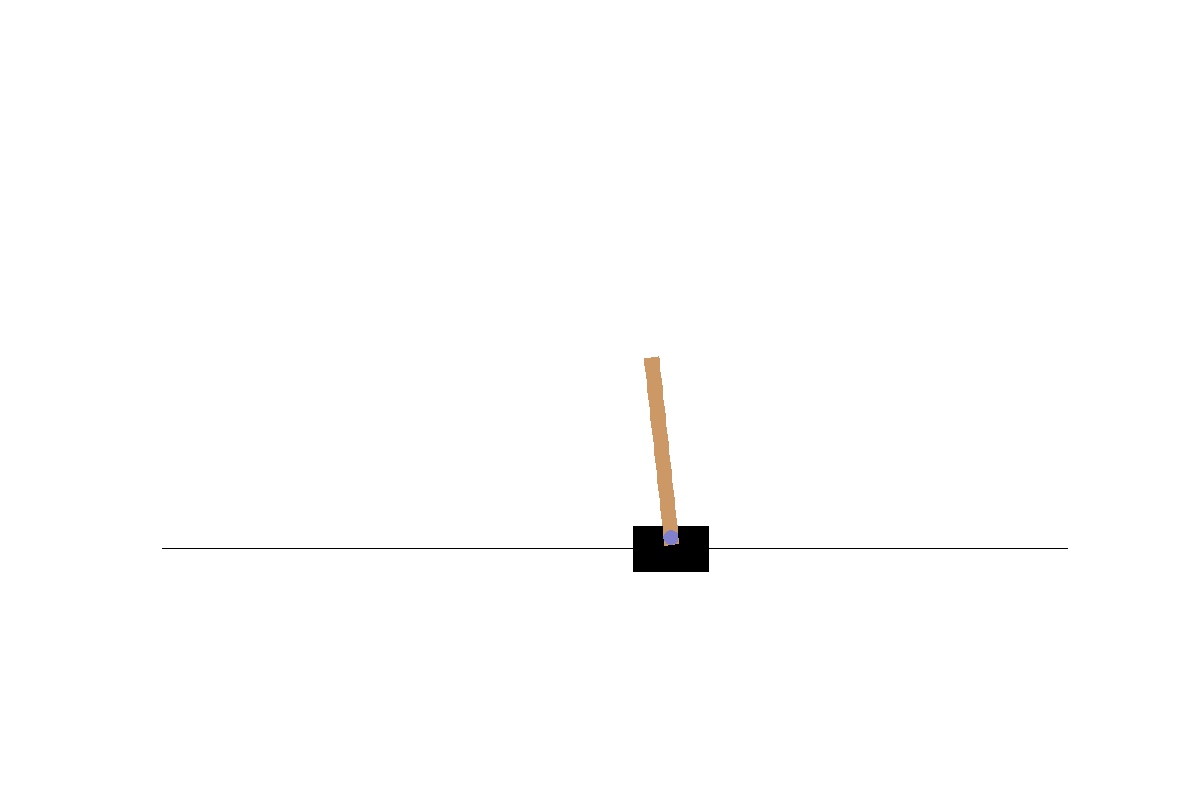
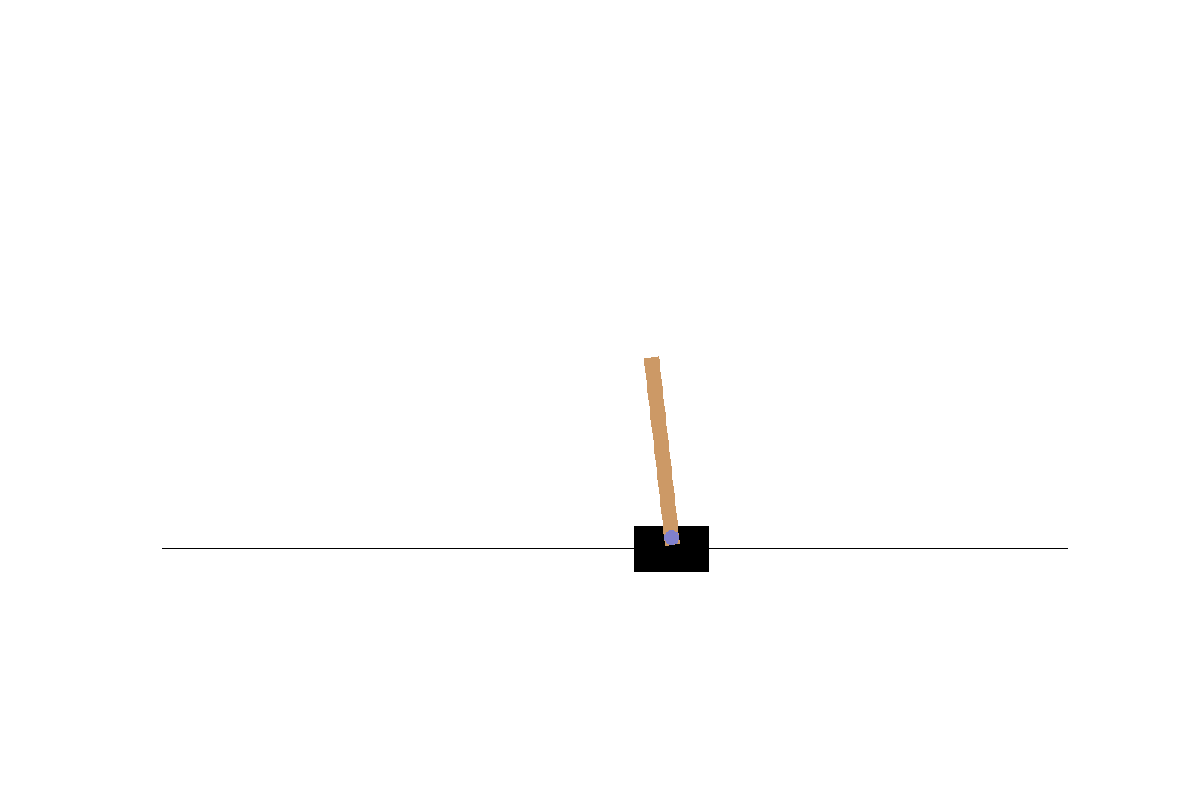
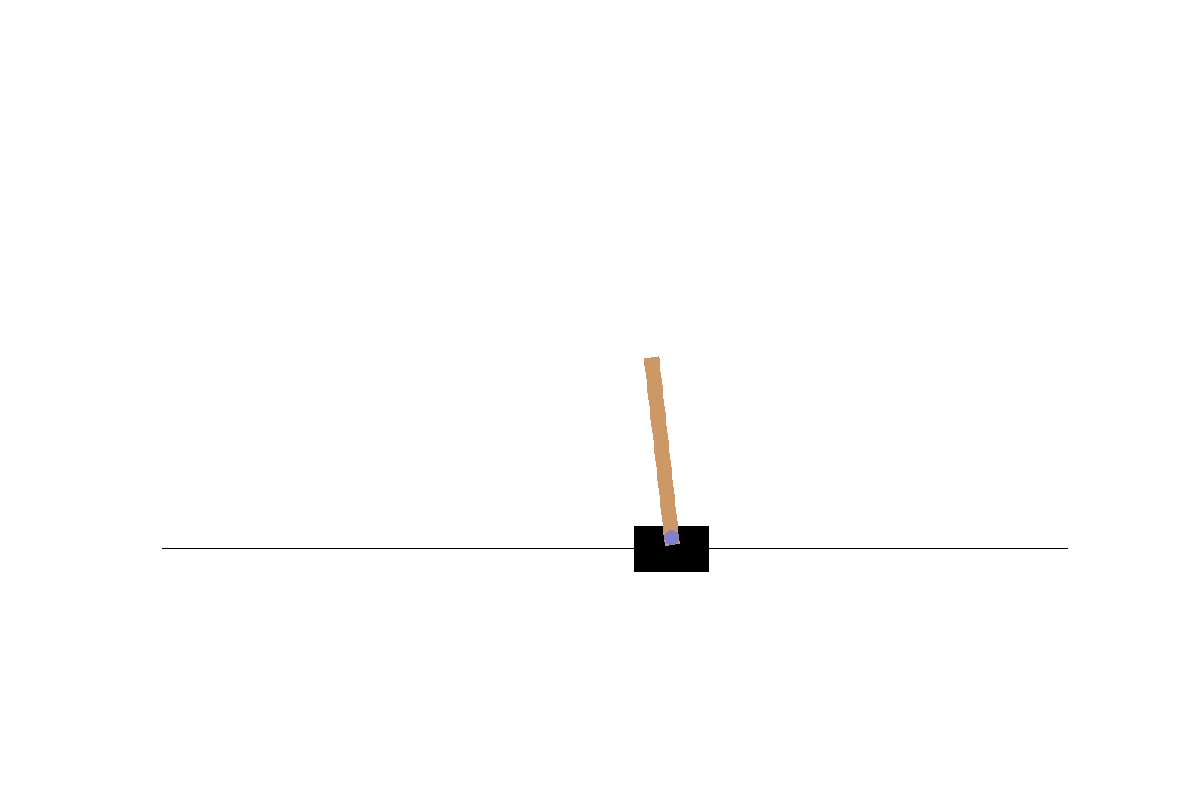
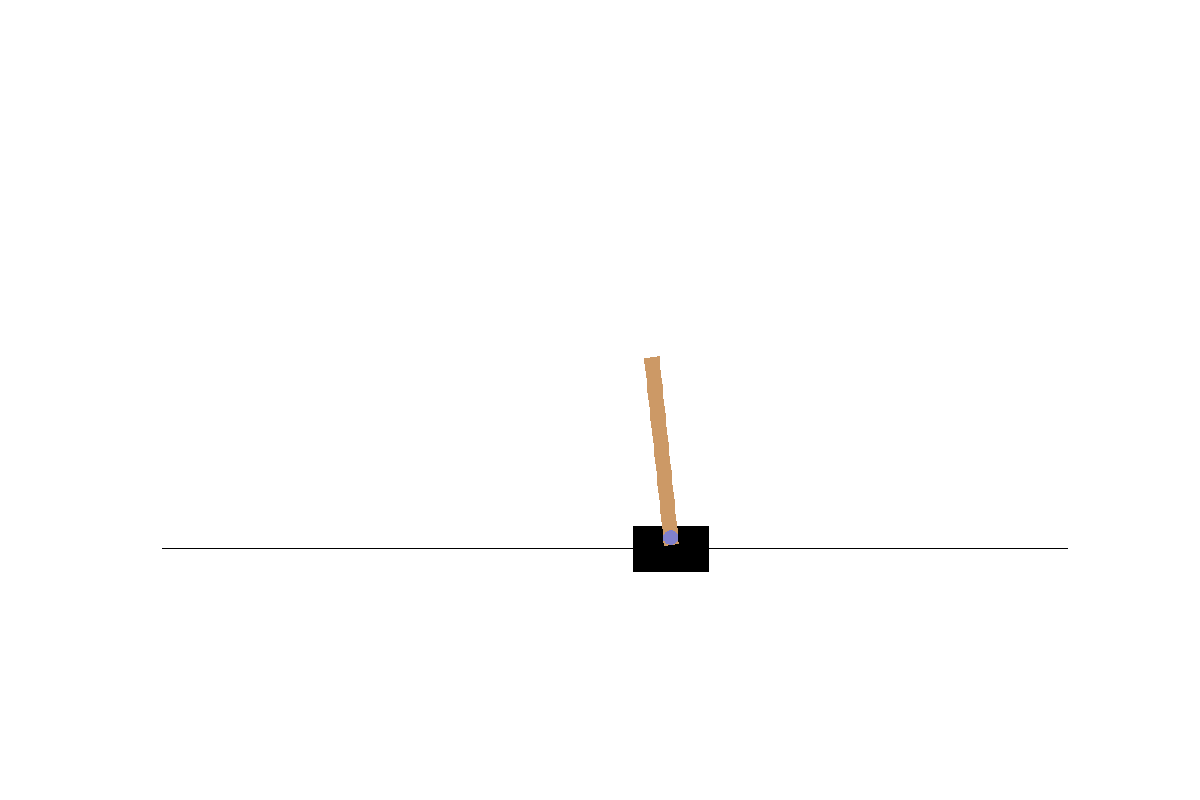
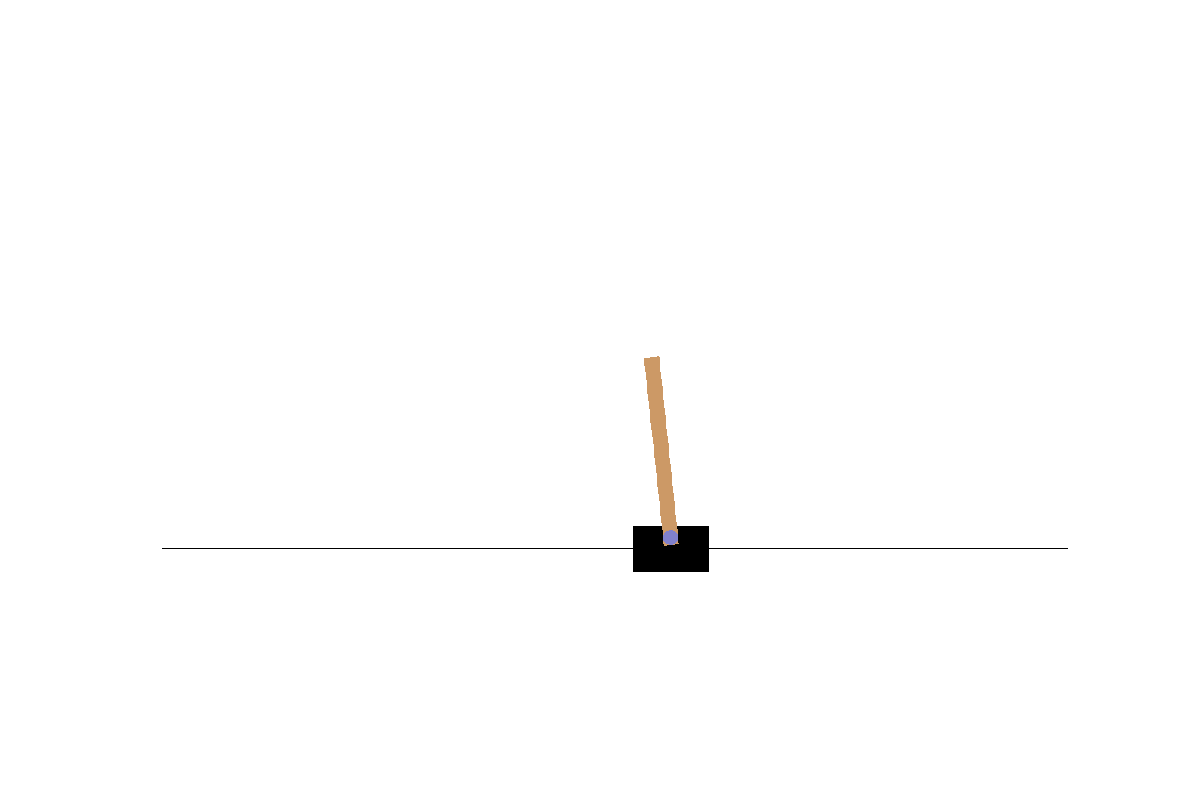
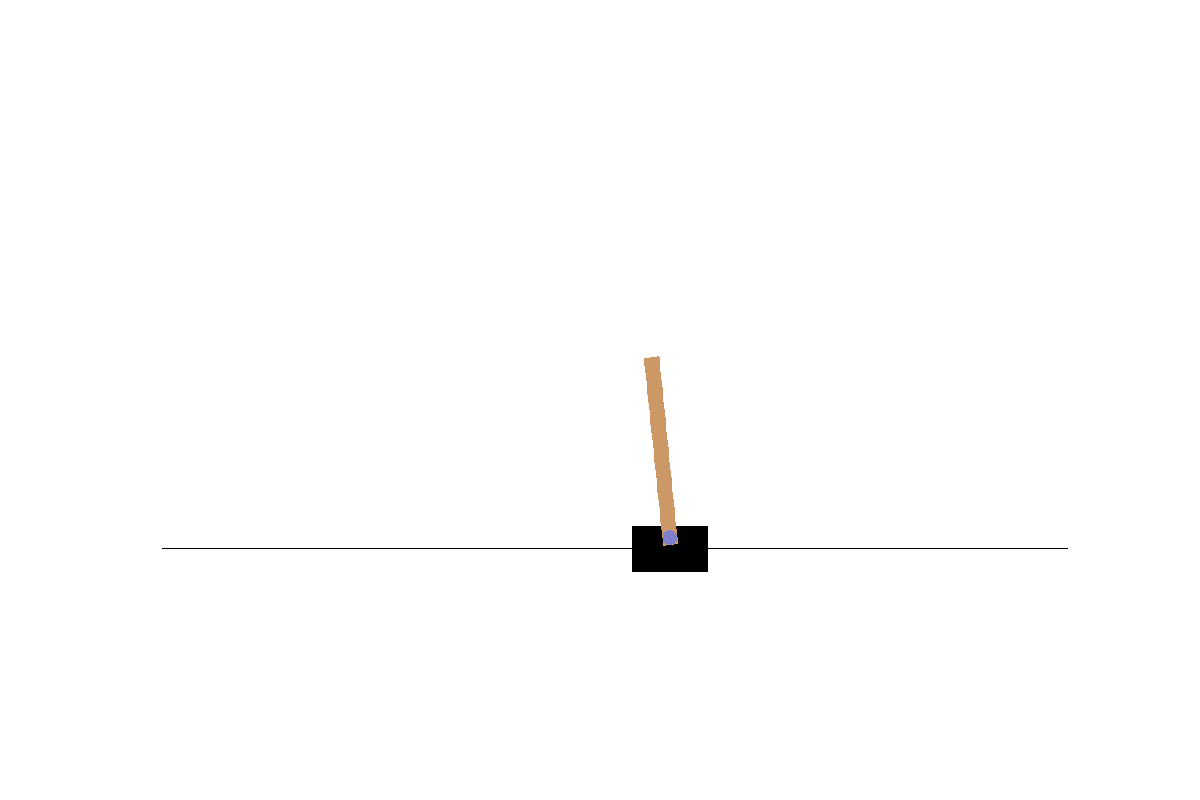
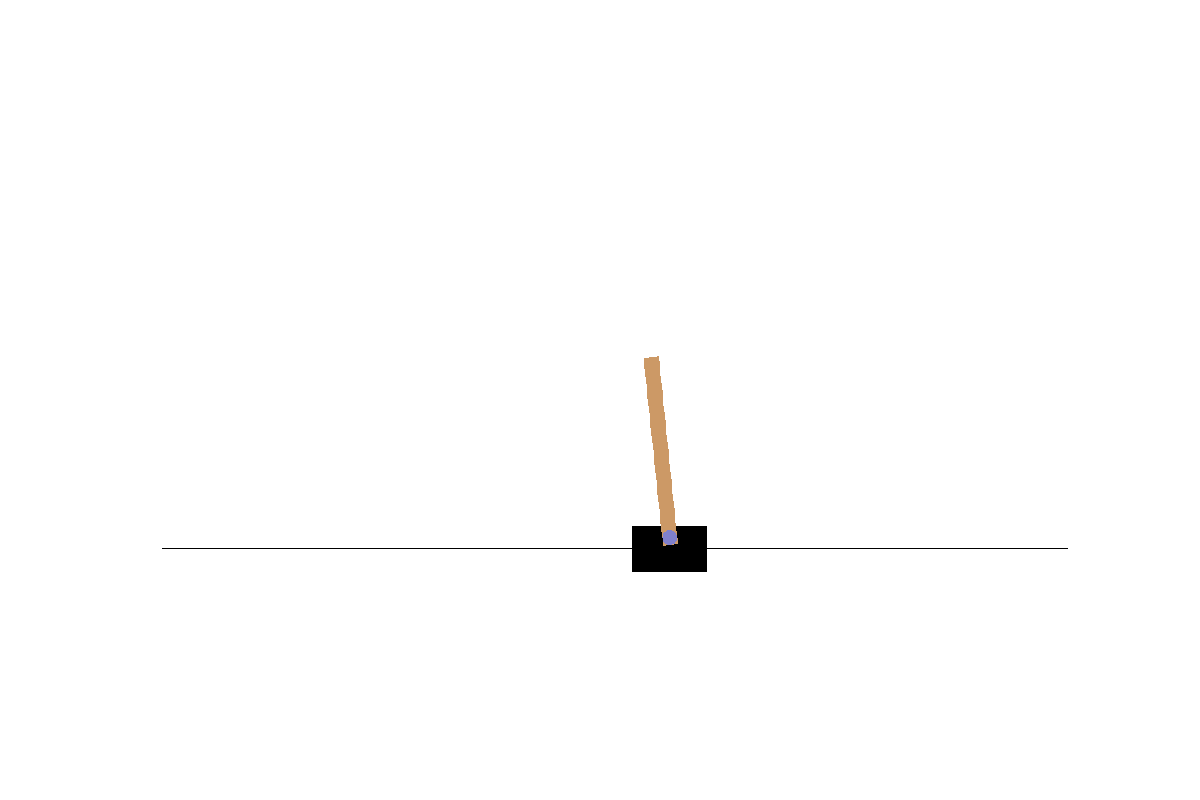
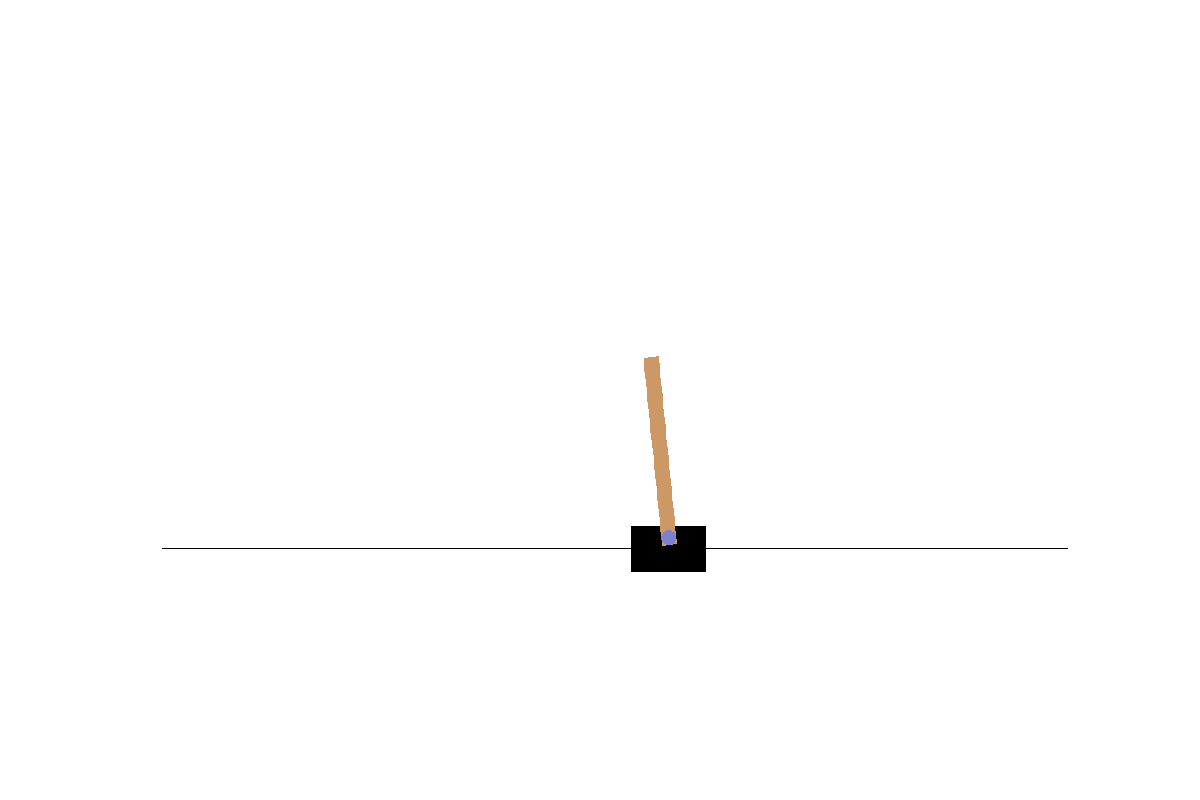
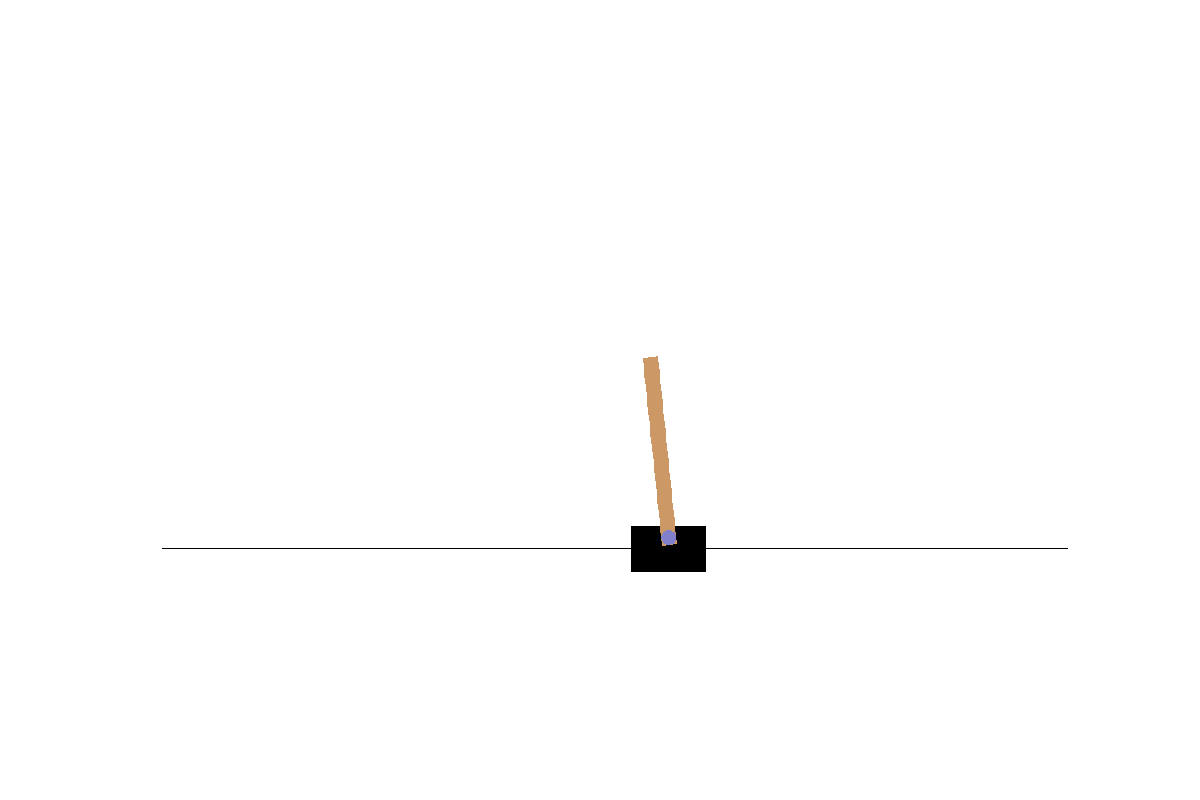
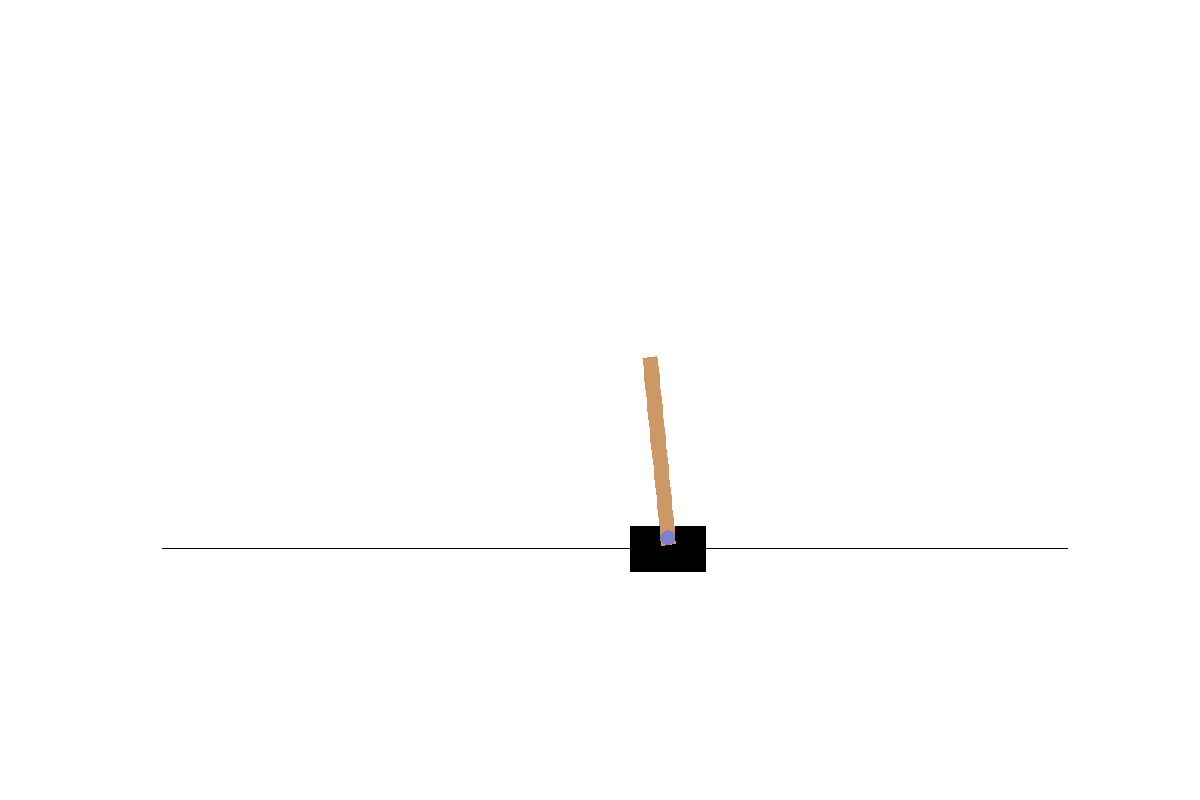
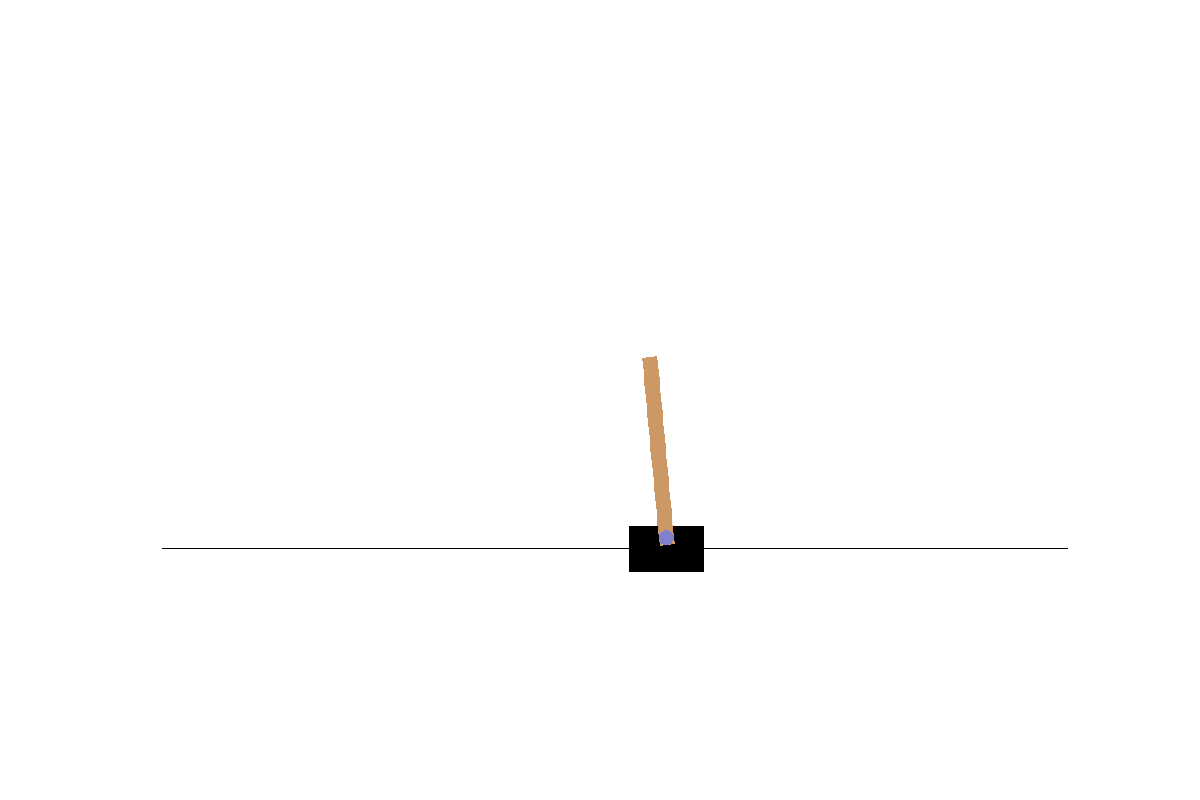
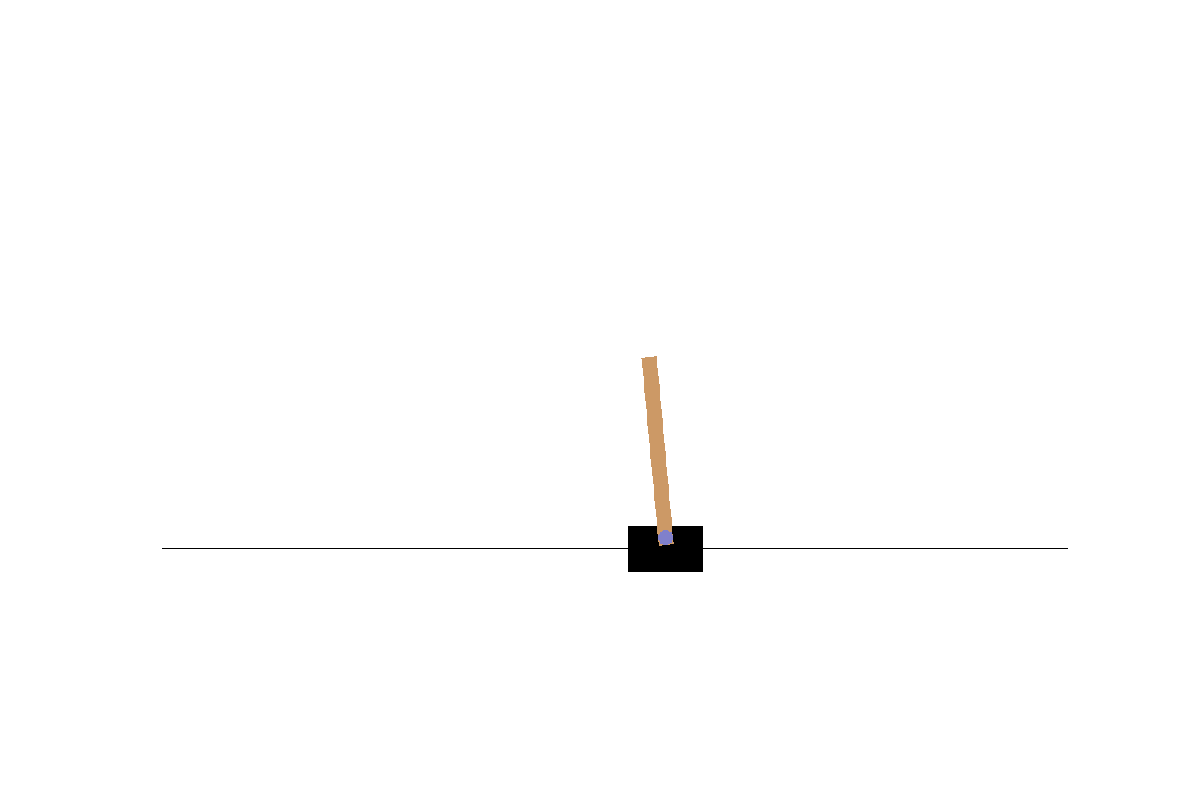
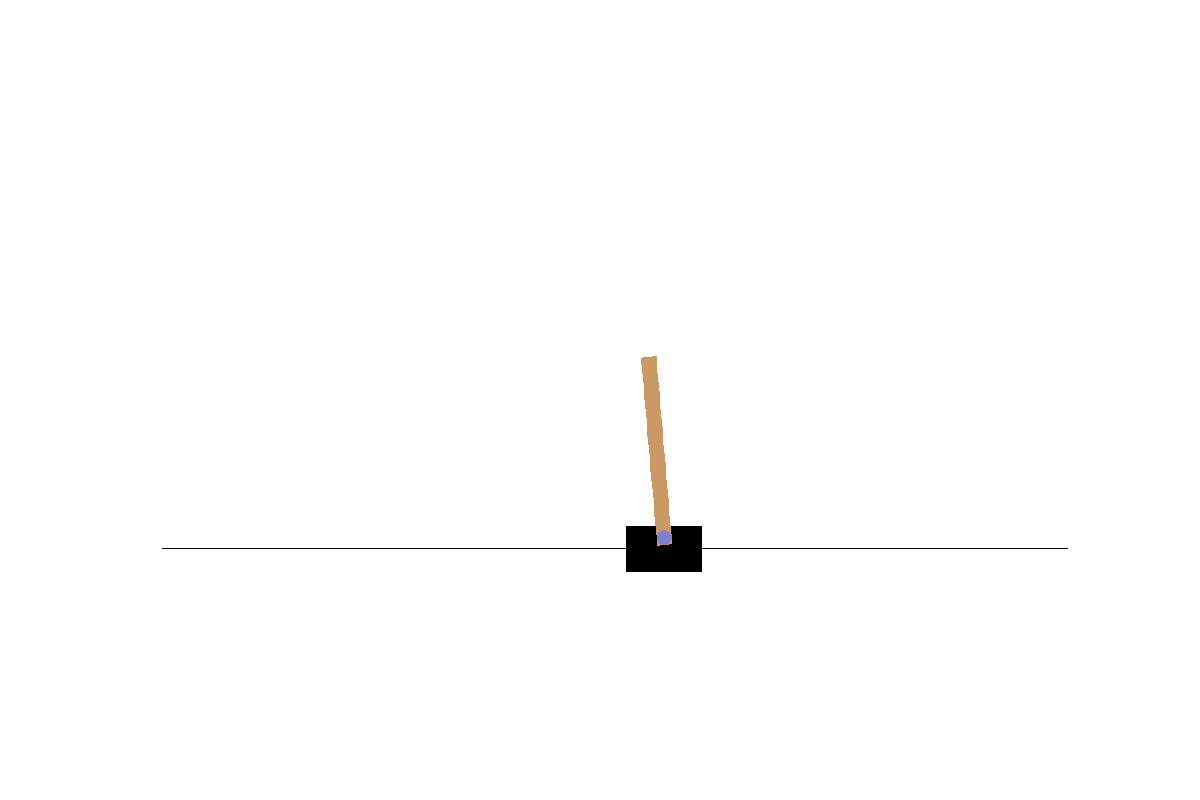
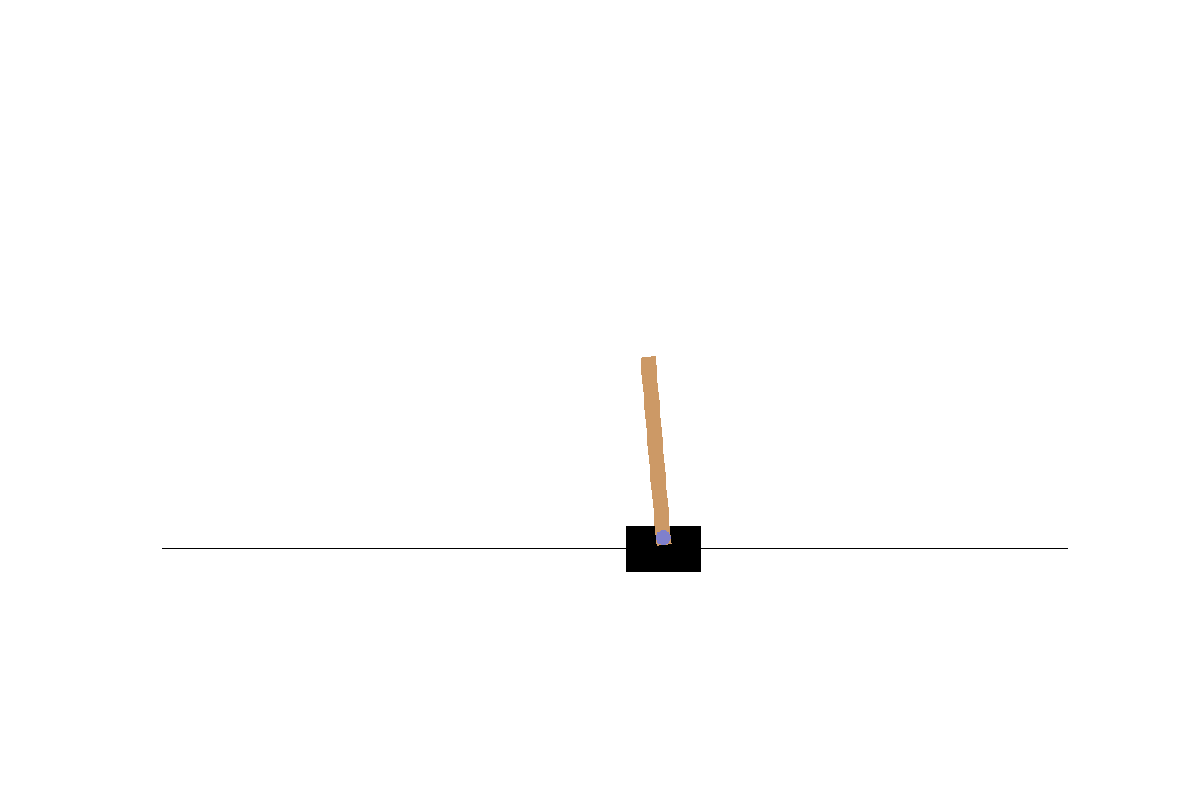
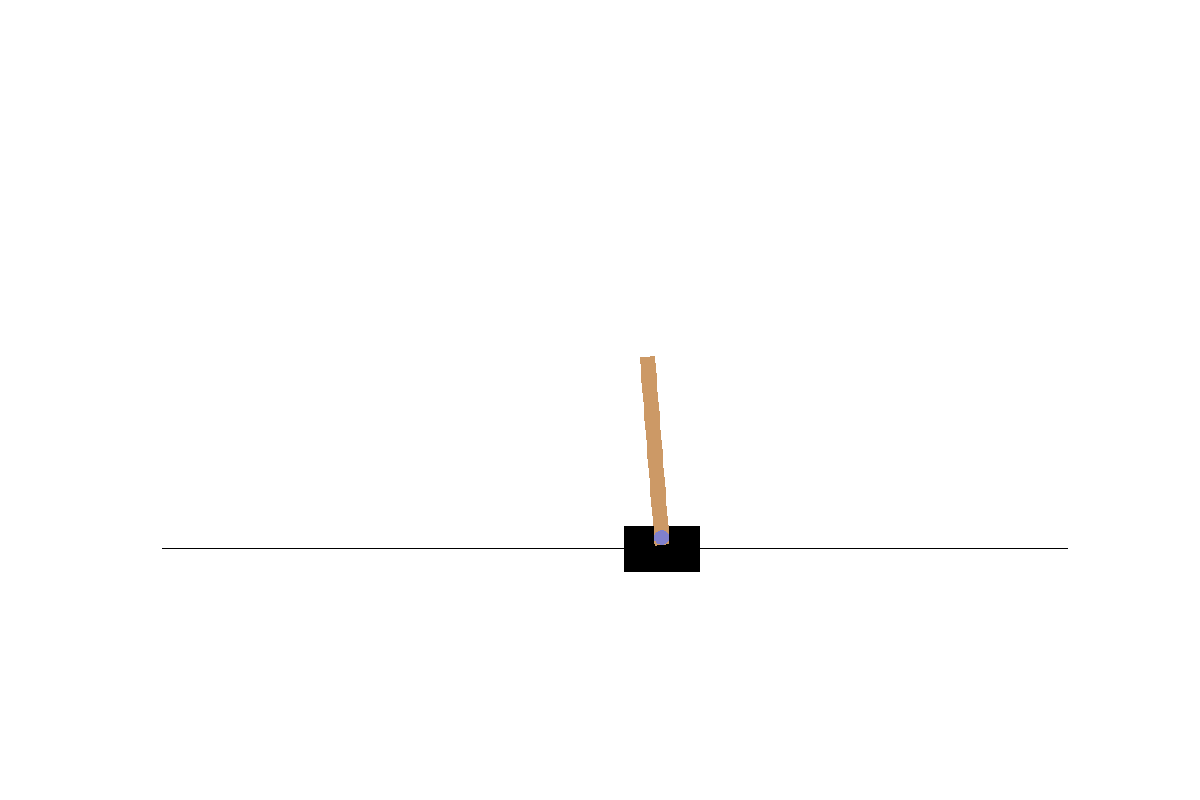
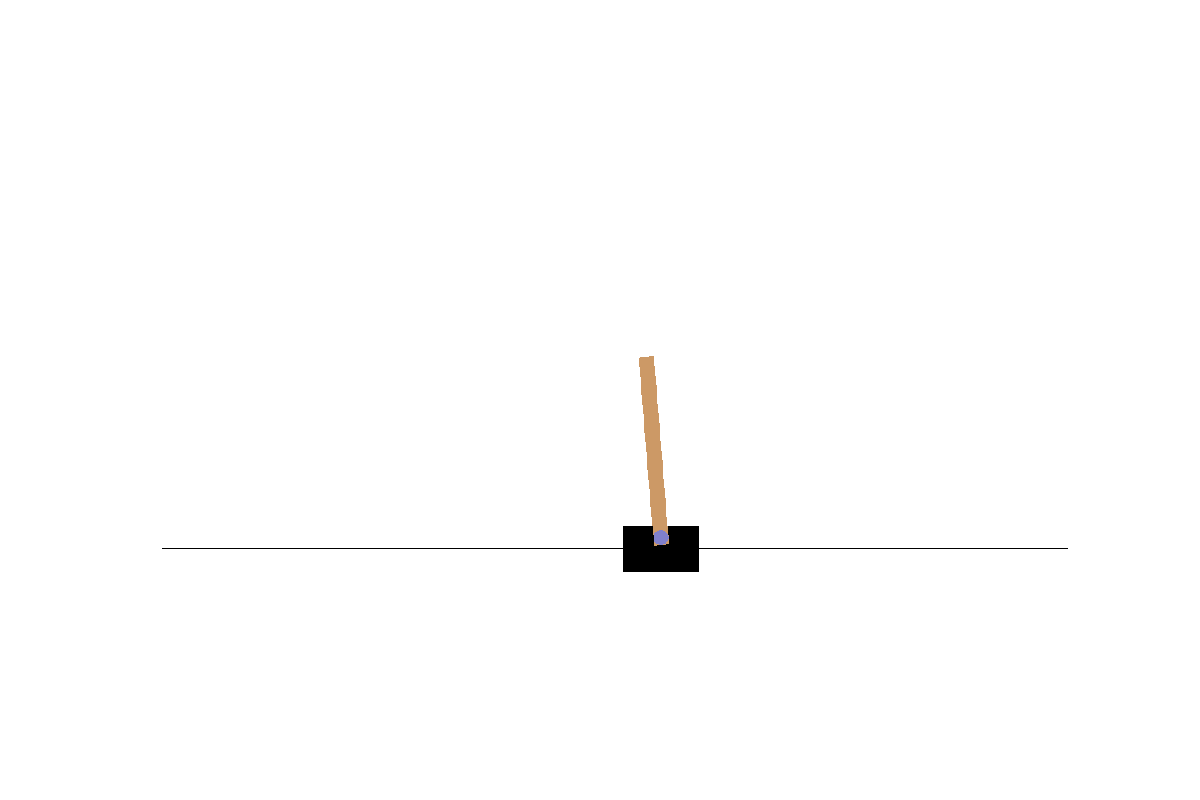
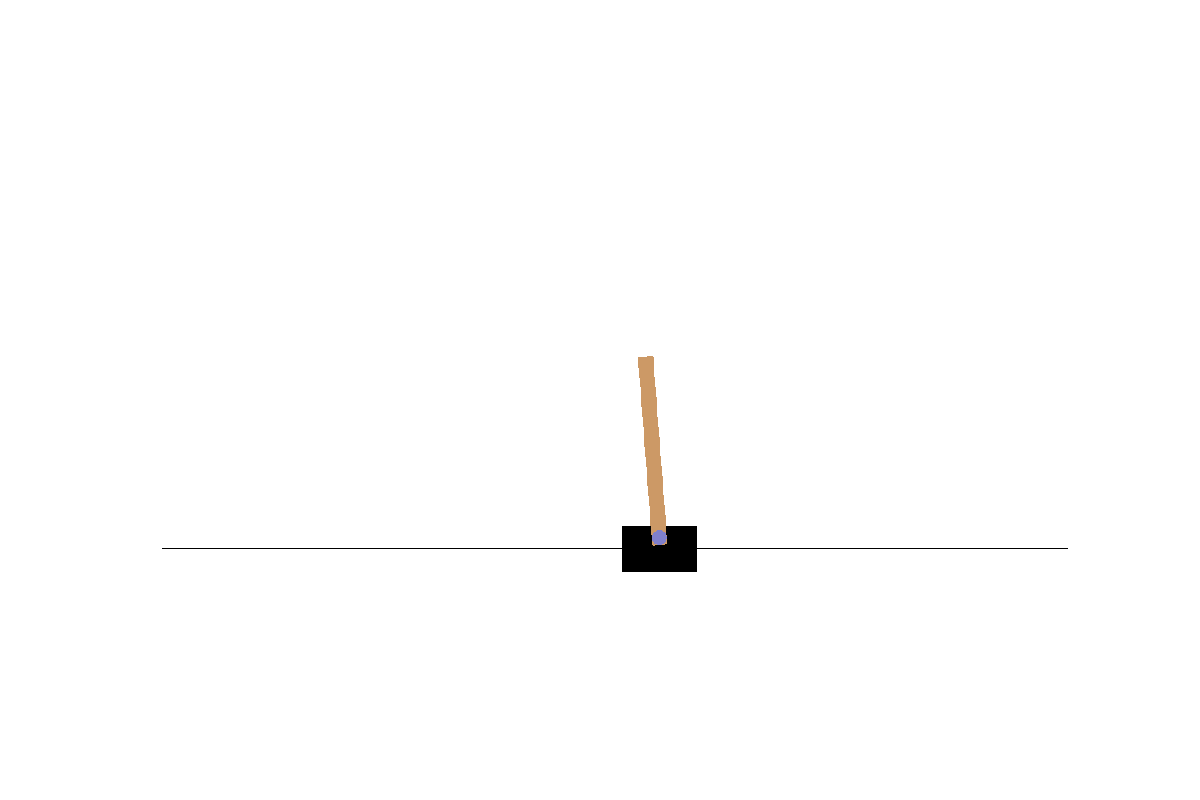
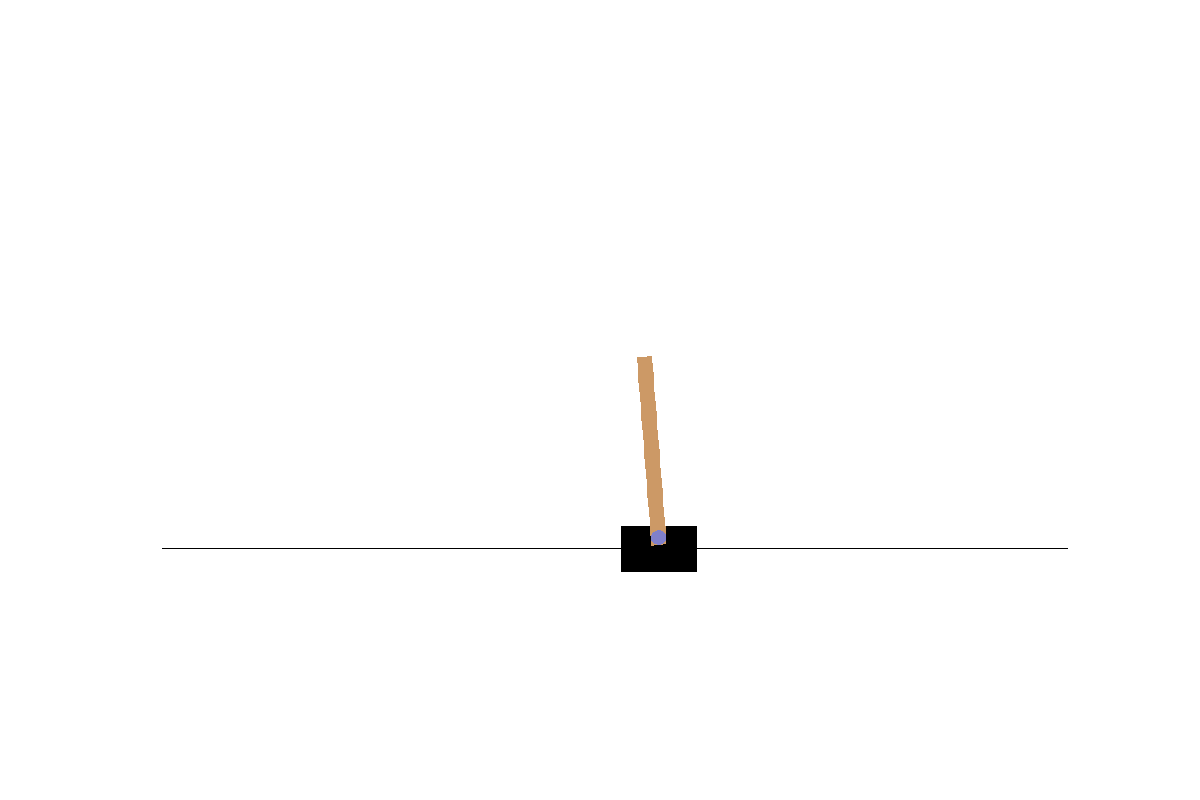
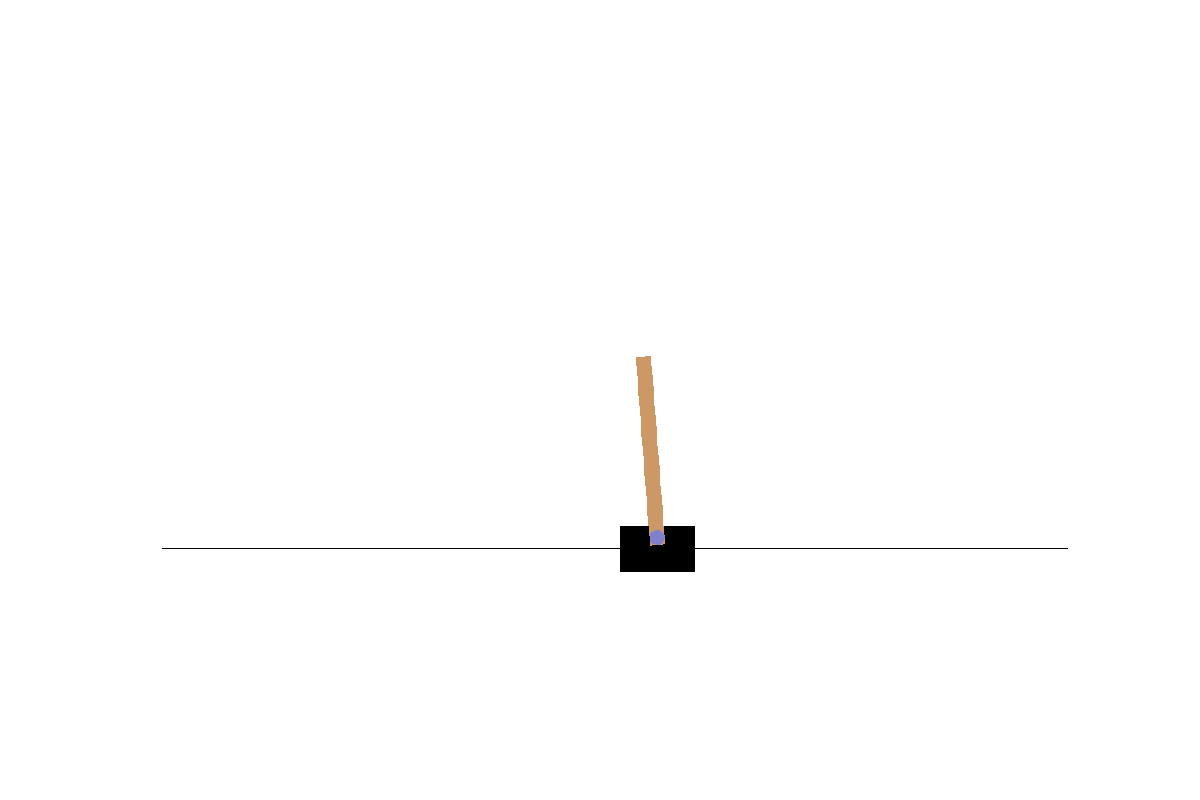
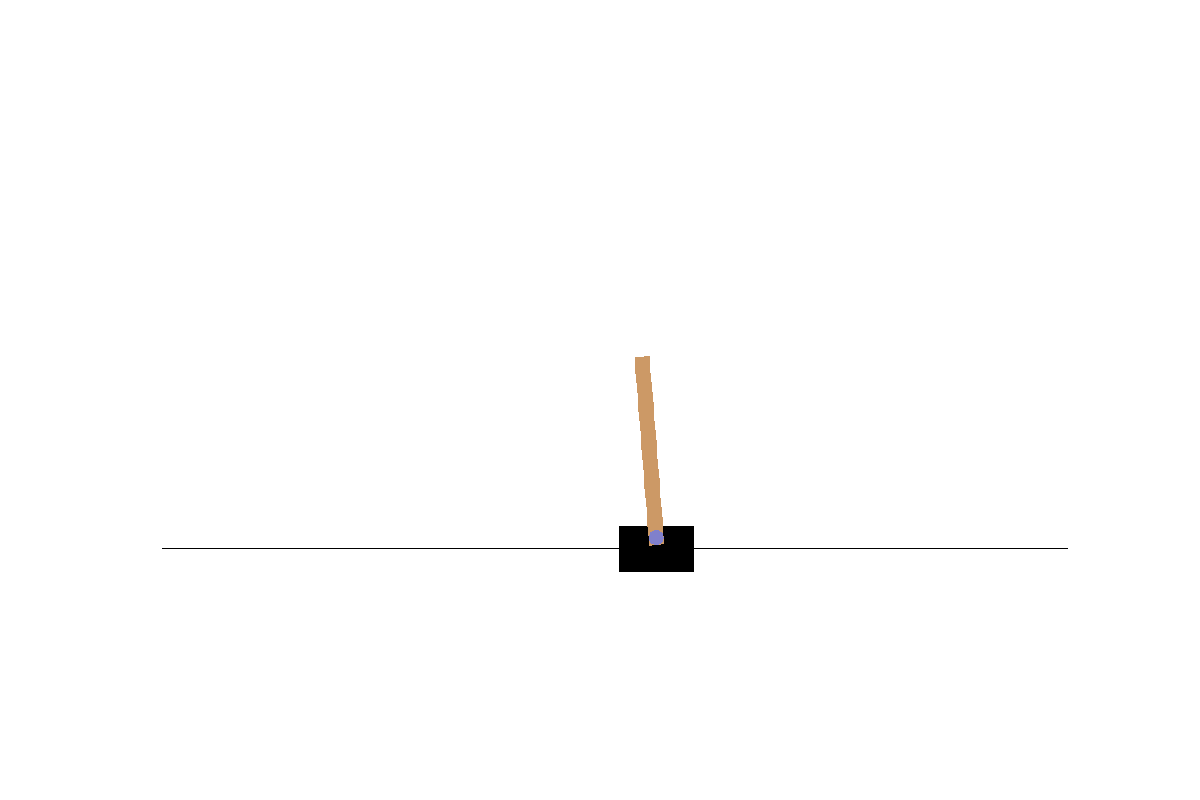
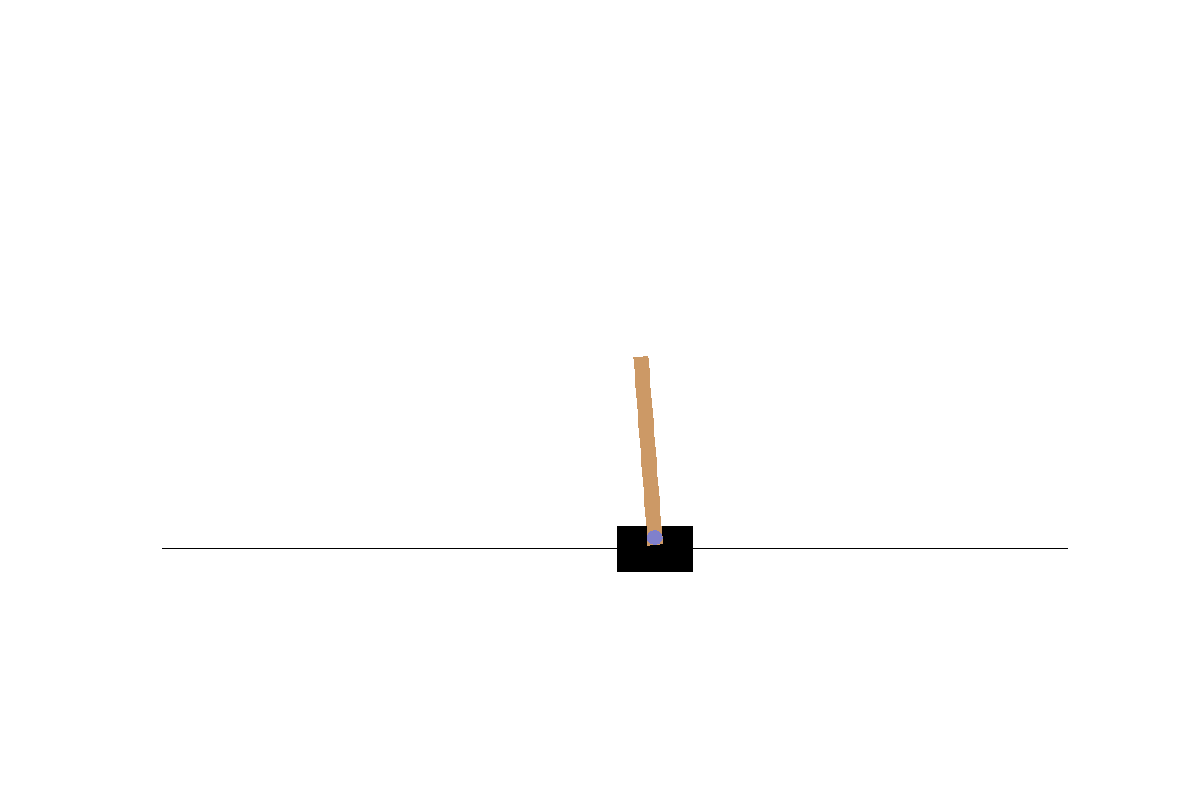
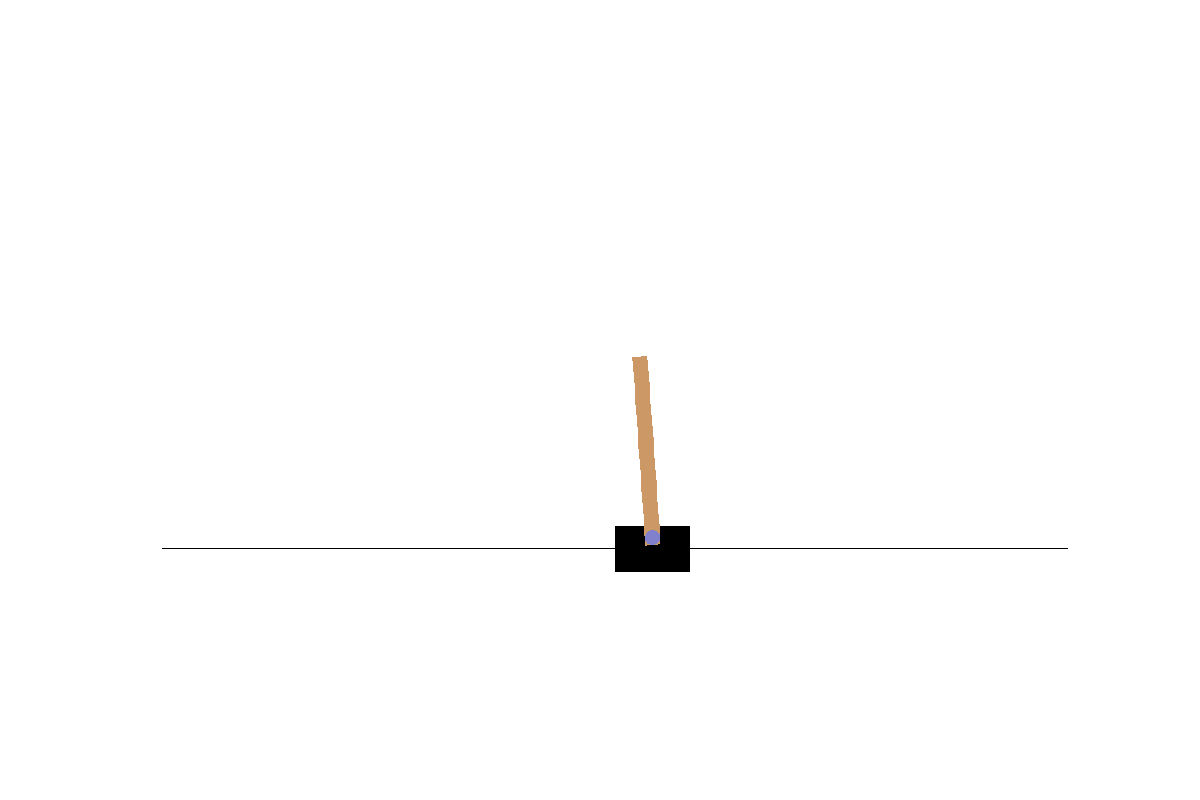
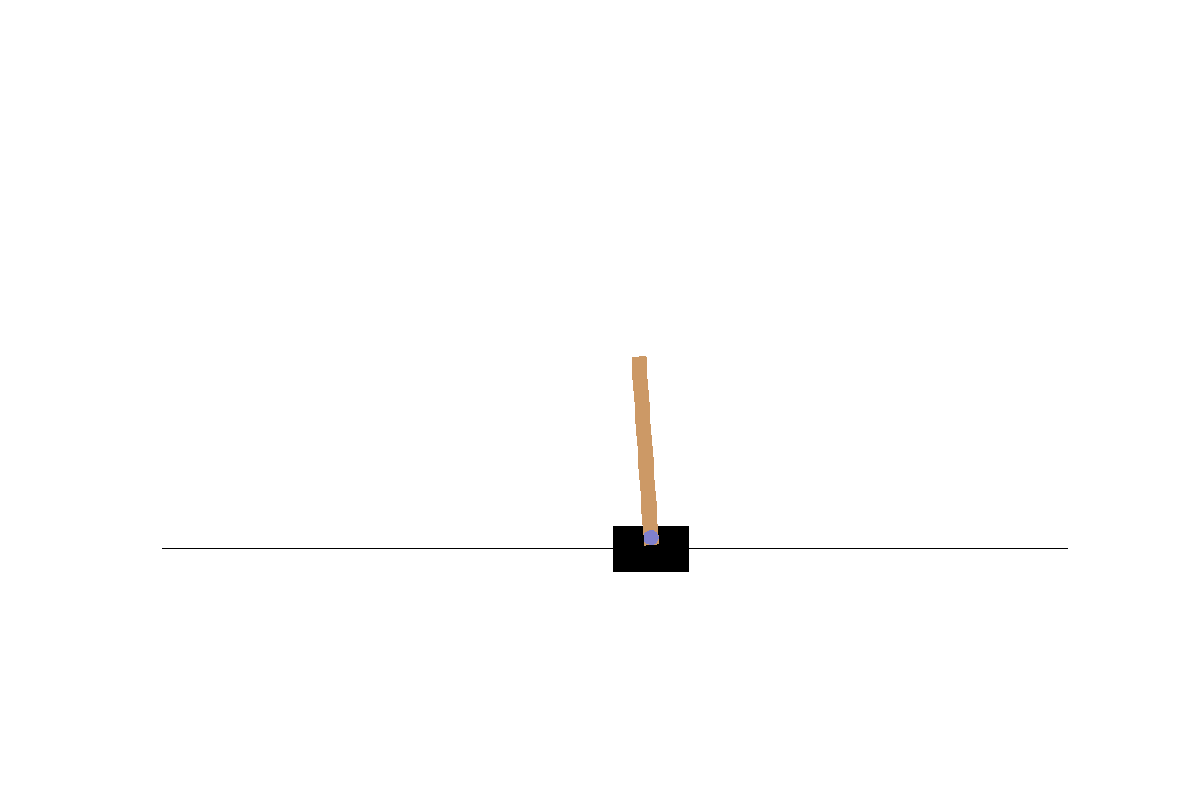
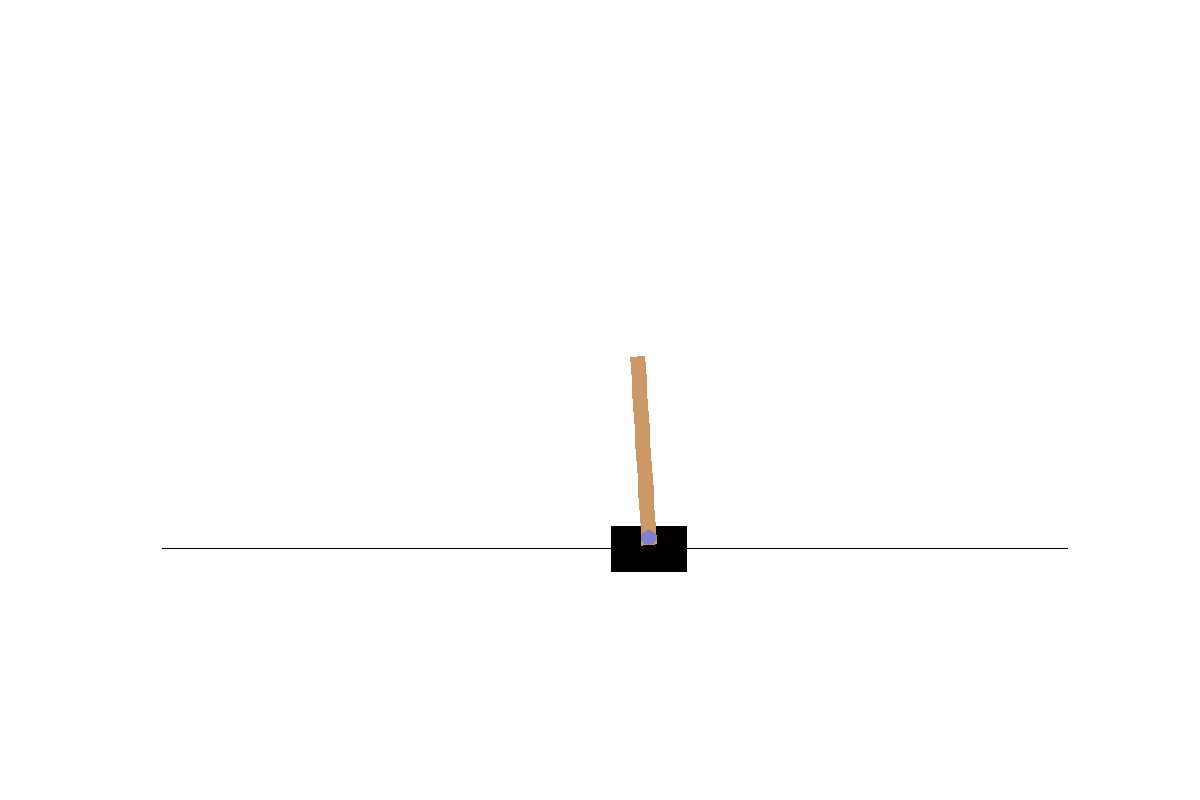
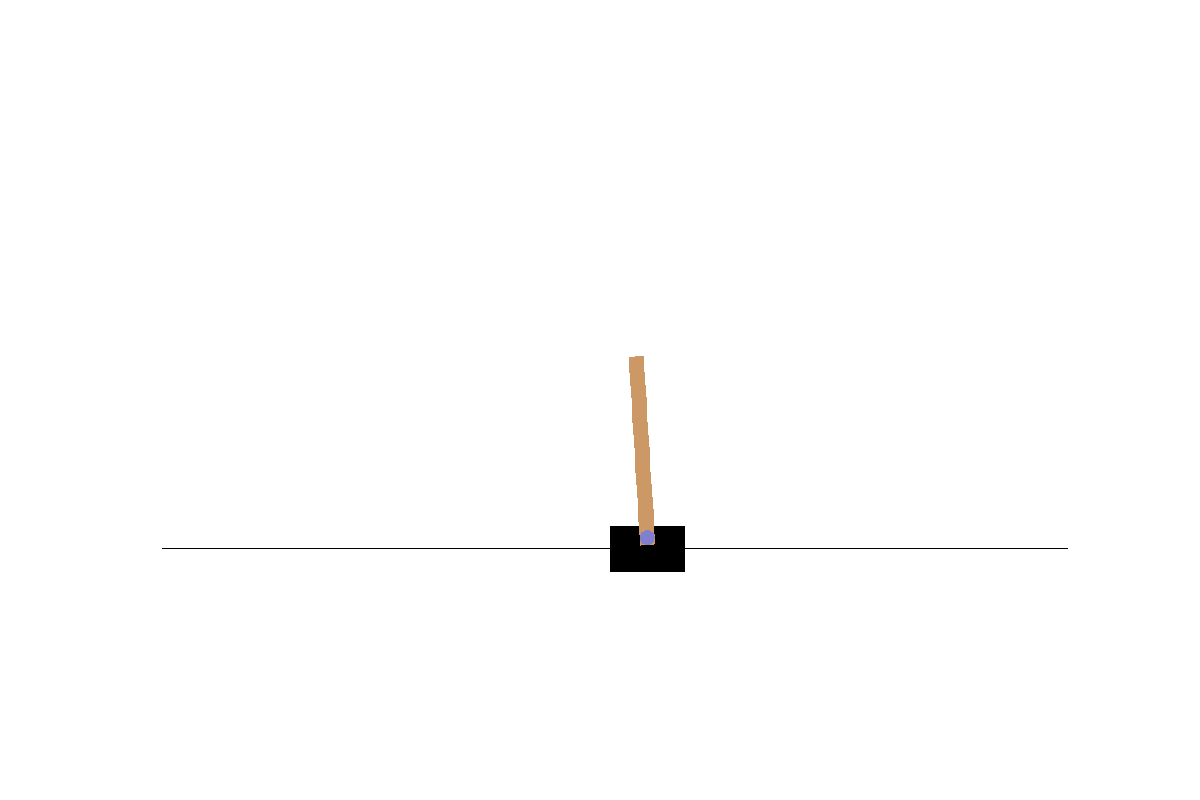
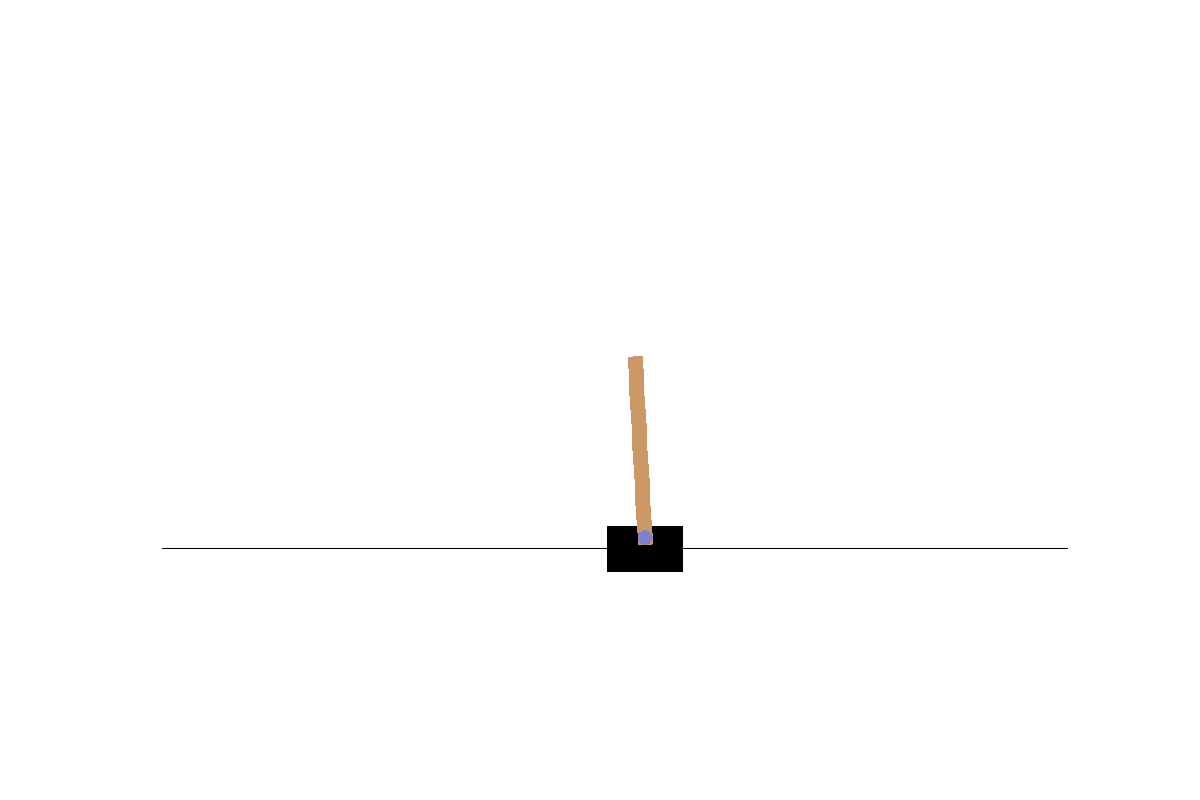
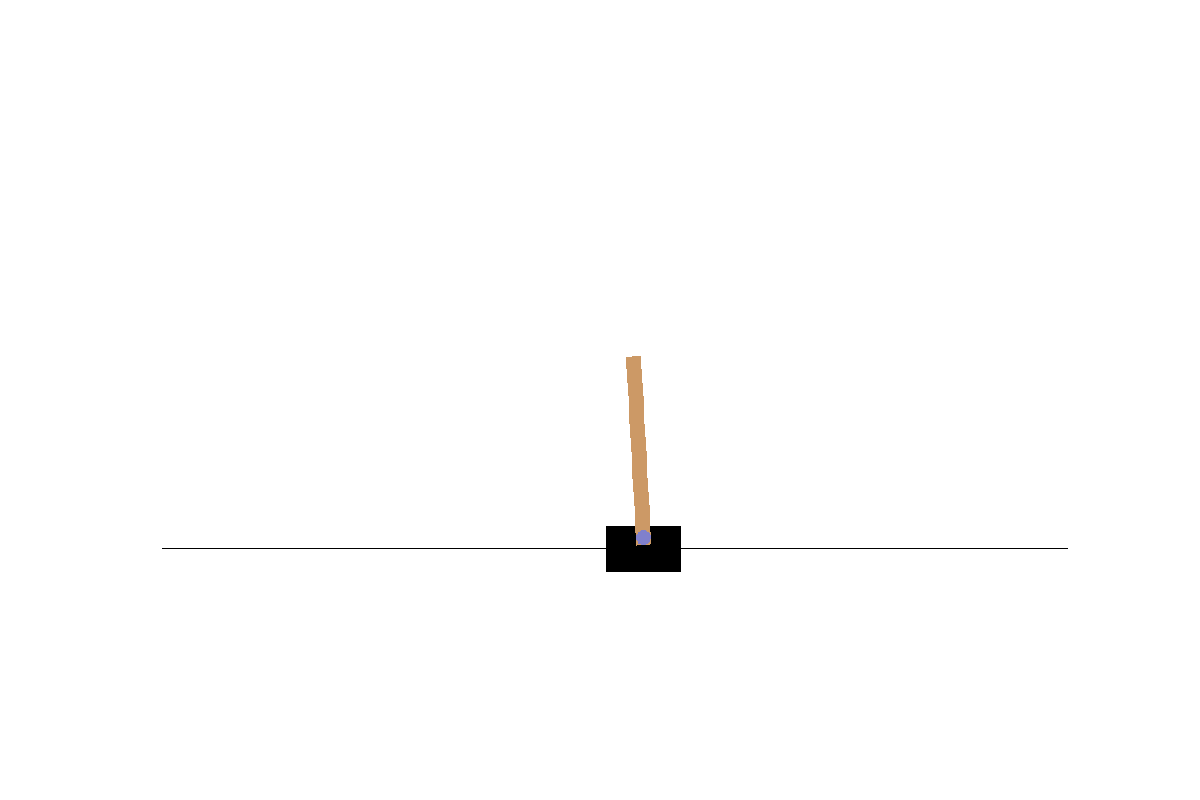
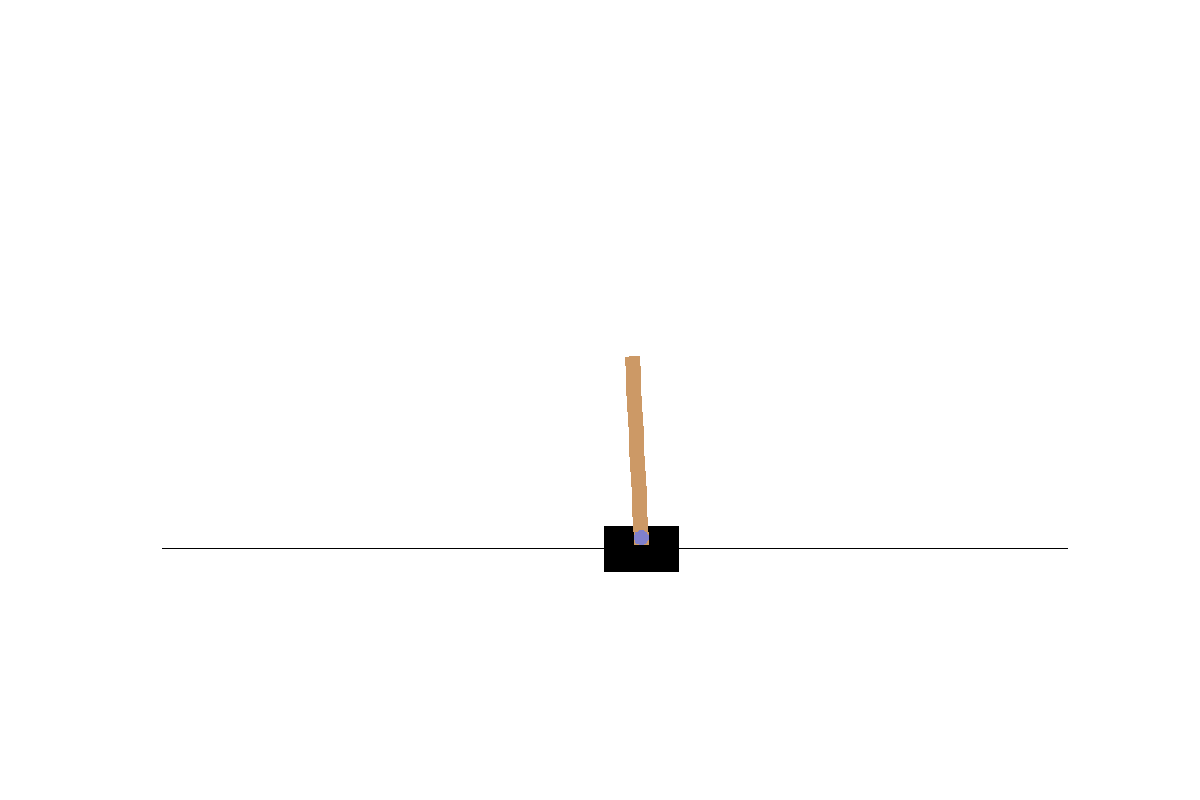
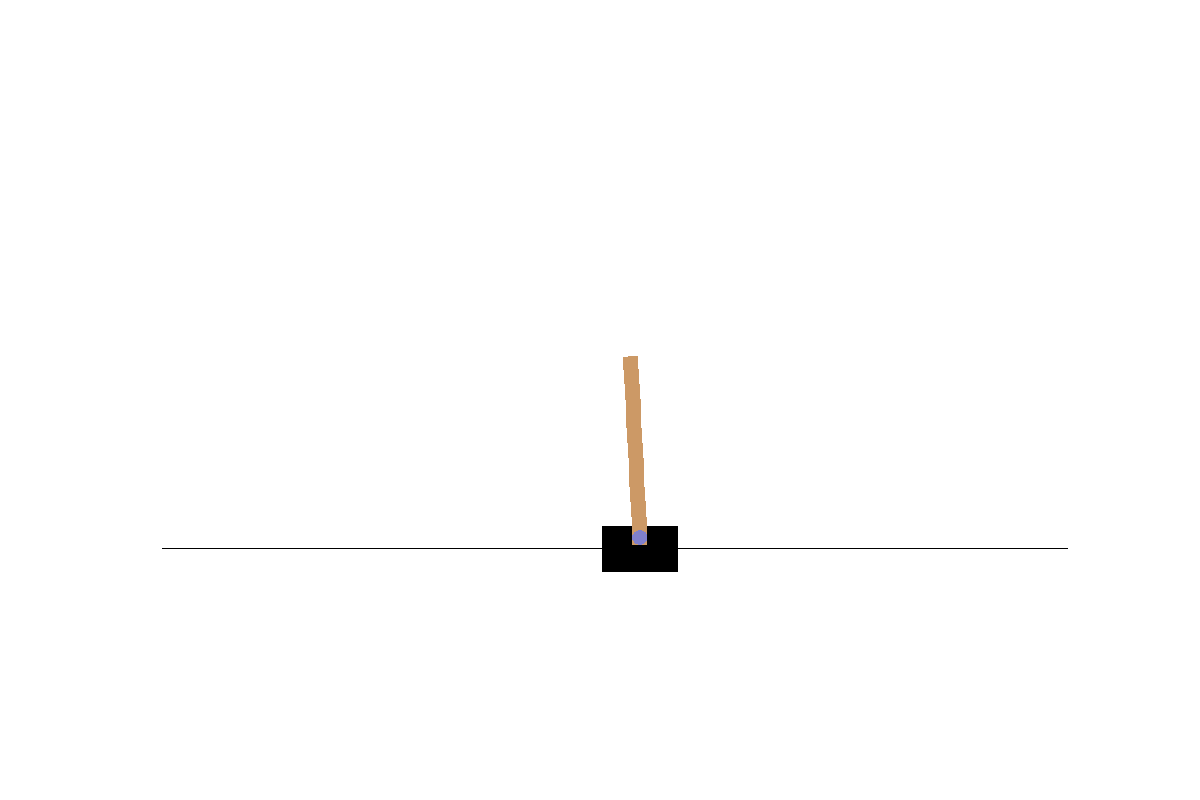
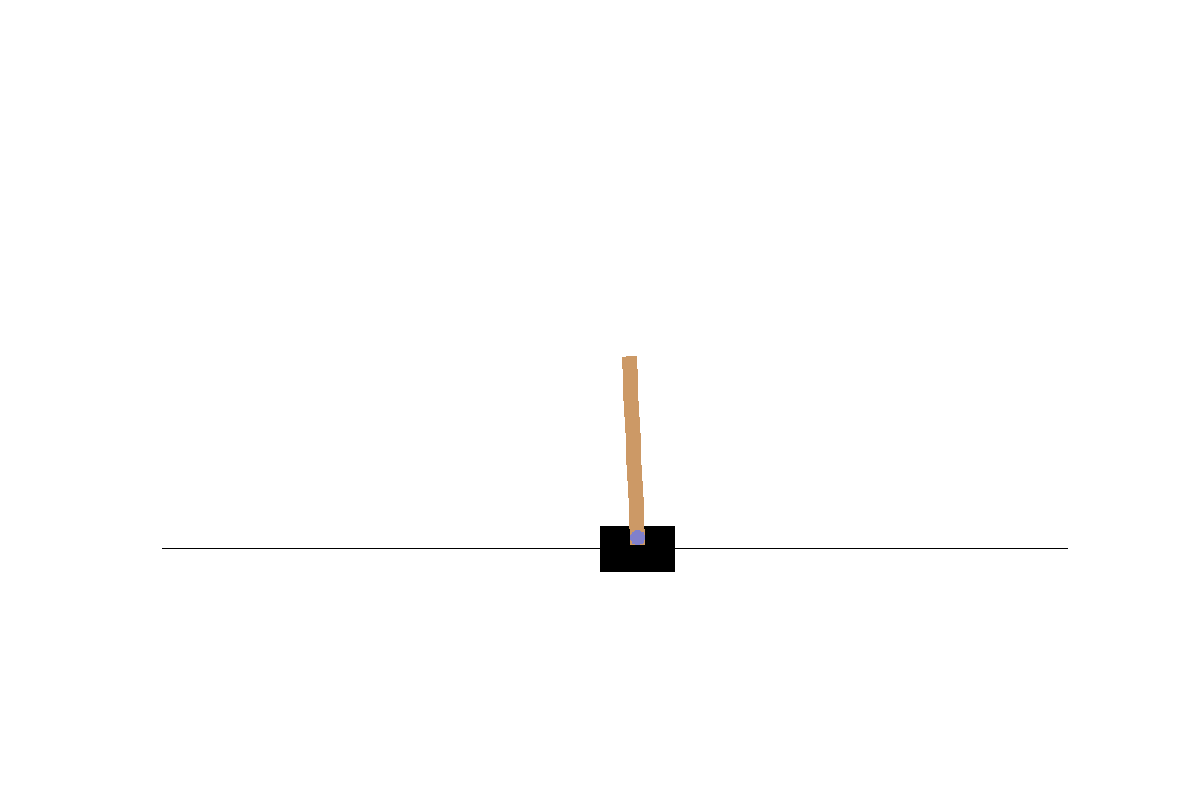
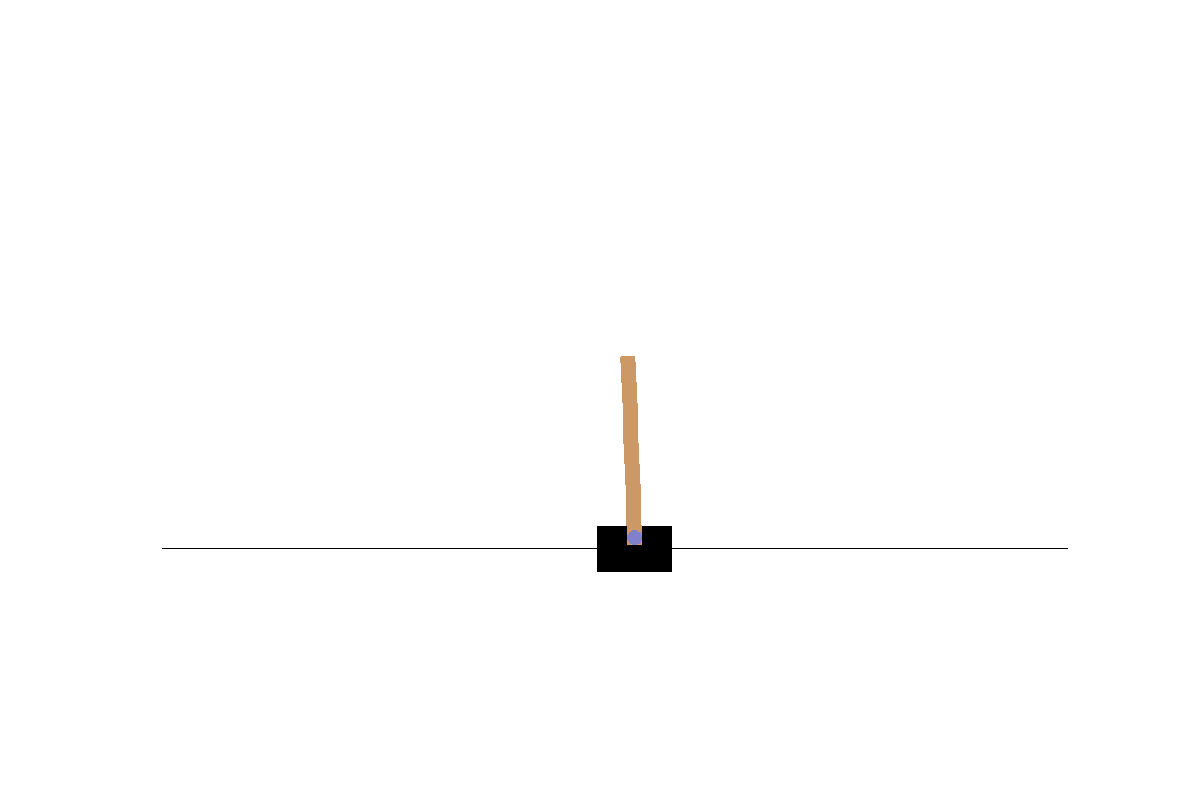

In [15]:
cartpole_env = Environment()
cartpole_env.run()